<a href="https://colab.research.google.com/github/khixson1/SAMpLR-METADATA/blob/main/SAMpLR_METADATA_BATCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **S**pectrum **A**nalyzer for **M**achine **L**earning **(SAMpLR)**-**METADATA_BATCH**
 This code takes as input *Compound Name* or *Pubchem ID (CID)* or *CAS*, or *InChIKey*. With at least one compund identifier, the script will perform webscraping of Pubchem (https://pubchem.ncbi.nlm.nih.gov/), ChEBI (https://www.ebi.ac.uk/chebi/) and ClassyFire (http://classyfire.wishartlab.com/) to retrieve other associated metadata for the defined compound. The script will display the user supplied ("Supplied"), parent ("Parent") which is the primary compound if supplied compound contains multiple components, and will return metadata on component compounds (e.g., salts, acids, water) in addition to parent compound if present.

 This script was created and tested in Google's Colaboratory Python Notebook environment (https://colab.research.google.com) which is a modified Jupyter Notebook environment. **WARNING:** Script performance is dependent on operational Pubchem, ChEBI, ChEMBL and ClassyFire websites.

**Retrieved Metadata Includes:**
***Pubchem Derived***
*   Compound Name
*   Synonyms
*   Pubchem ID (CID)
*   CAS
*   IUPAC Name
*   InChIKey
*   InChI
*   Canonical SMILES
*   Isomeric SMILES
*   Molecular Formula
*   Molecular Weight
*   Exact Mass
*   Associated Organisms

***ChEBI Derived***
*   ChEBI ID
*   ChEBI IS Descriptor
*   ChEBI Chemical Role
*   ChEBI Biological Role
*   ChEBI Application
*   KEGG Compound ID
*   KEGG Drug ID
*   Drug Central ID
*   Drug Bank ID
*   ChemSpider ID
*   MetaCyc ID
*   Veterinary Substances Database (VSDB) ID
*   Human Metabolome Database (HMDB) ID
*   Lipid Maps ID
*   Library of Integrated Network-based Cellular Signatures (LINCS) ID

***ClassyFire Derived***
*   Kingdom
*   Superclass
*   Class
*   Subclass
*   Direct Parent
*   Alternative Parents
*   CHEMONTIDs
*   CHEMONTID Names

Version 1.0
5/20/2023

#Mount Google Drive



In [ ]:
# Mount google drive. This cell can be deleted if using something other than the Google Colab Python environment
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import Libraries/Packages

In [ ]:
#Install chembl-webresource-client
%%capture
!pip install chembl-webresource-client

In [ ]:
#Install urlrequest (opens and reads url files)
%%capture
!pip install urlrequest

In [ ]:
#Install ijson (enables streaming of json file as pieces)
%%capture
!pip install ijson

In [ ]:
#Install chembl webresource client
%%capture
!pip install chembl-webresource-client

In [ ]:
#Install rdkit for molecular structure info (mol files)
%%capture
!pip install rdkit-pypi

In [ ]:
#Install BeautifulSoup webscraper
%%capture
!pip install bs4

In [ ]:
#Install Pyarrow's Parquet library
%%capture
!pip install pyarrow

In [ ]:
# os import to enable drive and folder structure setup and pandas to enable reading of input files
# Imports of other needed/desired libraries
import os
import pandas as pd
import numpy as np
import re
import urllib.request, urllib.error
import time
import glob
import datetime
import json
import ijson
import requests
import random
import pyarrow.parquet as pq
from PIL import Image
from chembl_webresource_client.new_client import new_client
from chembl_webresource_client.utils import utils
from urlrequest import UrlRequest
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import Recap
from rdkit.Chem import BRICS
from rdkit.Chem import Descriptors
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from bs4 import BeautifulSoup
from bs4 import SoupStrainer

#User Input

**Essential Metadata Inputs**
1. Define working directory
2. Define project folder
3. Define at least one of Compound Name, Pubchem ID, CAS and/or InChIKey (more than 1 identifer is better)

In [ ]:
#Define Input Data File and Working Directory
Work_Dir = '/content/drive/MyDrive/'                                                            # 1. Enter working directory here. Shown here is an example of the path to your Google Drive.

Project_Folder_Name = 'GNPS_Metadata_110123'                                                        # 2. Enter 'Project Name' you want to use for this specific project (which files you want to ultimately combine into single .csv file). '' if None.
Input_File_Location = '/content/drive/MyDrive/GNPS_Input_Data/'                          # 3. File directory where input .txt files are located# Modify or add file location here. Example: (work_dir +'Input_Files/'). '' if None.
Master_File = 'gnps_cleaned_for_metadata_analysis.csv'                                # 4b. Use this file name if a batch process and include extension.  '' if None.

In [ ]:
#Creating New Input File Folder in Project Folder Directory
if Project_Folder_Name != '':
  new_input_file_folder_path = (Work_Dir + Project_Folder_Name +'/Input_Files/')
  if not os.path.exists(new_input_file_folder_path):
    os.makedirs(new_input_file_folder_path)
    print("Directory '",new_input_file_folder_path, "' Created")
  else:
    print("Directory '",new_input_file_folder_path,  "' already exists")

  Input_File_Folder = new_input_file_folder_path
else:
  Input_File_Folder = ''

print("Input File Folder Path: " + Input_File_Folder)

Directory ' /content/drive/MyDrive/GNPS_Metadata_110123/Input_Files/ ' already exists
Input File Folder Path: /content/drive/MyDrive/GNPS_Metadata_110123/Input_Files/


In [ ]:
#Show columns of Master_File if it exists
if (Master_File != '' and Master_File != 'NaN'):
  os.chdir(Input_File_Location)
  if ".txt" in Master_File:
    try:
      file_list_df = pd.read_csv(Master_File, encoding='windows-1254',low_memory=False, sep='\t')
    except:
      raise NameError("Data File Not Found In Specified Directory. Please upload correctly spelled .txt file into " + Input_File_Folder + " and restart runtime.")
  if ".csv" in Master_File:
    try:
      file_list_df = pd.read_csv(Master_File, encoding='windows-1254',low_memory=False)
    except:
      raise NameError("Data File Not Found In Specified Directory. Please upload correctly spelled .txt file into " + Input_File_Folder + " and restart runtime.")

  Master_File_Columns = file_list_df.columns.values.tolist()
  display(Master_File_Columns)

['spectrum_id',
 'source_file',
 'Compound_Name',
 'CAS_Number',
 'Pubmed_ID',
 'InChIKey_smiles',
 'InChIKey_inchi',
 'InChIKey']

In [ ]:
#Define compound identifiers ether from a batch Master_File or directly enter known information
Chunk_Analysis = True                                         #Leave as False if not performing chunk analyses
Chunk_Count = 50                                              #If splitting analysis into chunks, list the number of chunks you want to perform. Put '0' if performing batch analysis on whole file.
Chunk_Number = '2'                                            #If populating one of the chunks list the one you want to populate. Put '0' if performing batch analysis on whole file.

Compound_Name = "Compound_Name"                               #Enter Compound Name if a single compound analysis or the compound name column name in the Master_File
Pubchem_ID = "Pubmed_ID"                                      #Enter Pubchem_ID if a single compound analysis or the Pubchem ID column name in the Master_File
CAS_ID = "CAS_Number"                                         #Enter CAS if a single compound analysis or the CAS number column name in the Master_File
InChIKey_ID = "InChIKey"                                      #Enter InChIKey if a single compound analysis or the InChIKey column name in the Master_File

#For Single Analysis
Analysis_Index = '1'                                           #Enter the index of the column in the Master_File to perform analysis on. If wanting to perform analysis on next unanalyzed compound leave blank ('')

#Place Master_File in Input Folder and Create Entered Data Dataframe - For Batch Analysis

In [ ]:
# Test if input .txt or .csv data file is spelled correctly and is in the defined input file folder
#Set directory to Input_File_Folder
file_ls = os.listdir(Input_File_Folder)
if file_ls == [] and 'entered_df.csv' not in file_ls:
  if (Master_File != '' and Master_File != 'NaN'):
    os.chdir(Input_File_Location)
    if ".txt" in Master_File:
      try:
        file_list_df = pd.read_csv(Master_File, encoding='windows-1254',low_memory=False, sep='\t')
      except:
        raise NameError("Data File Not Found In Specified Directory. Please upload correctly spelled .txt file into " + Input_File_Folder + " and restart runtime.")
    if ".csv" in Master_File:
      try:
        file_list_df = pd.read_csv(Master_File, encoding='windows-1254',low_memory=False)
      except:
        raise NameError("Data File Not Found In Specified Directory. Please upload correctly spelled .txt file into " + Input_File_Folder + " and restart runtime.")

  else:
    file_list_df = pd.DataFrame(columns=['Compound_Name','Pubchem_ID','CAS_ID','InChIKey_ID'])
    file_list_df['Compound_Name'] = [Compound_Name]
    file_list_df['Pubchem_ID'] = [Pubchem_ID]
    file_list_df['CAS_ID'] = [CAS_ID]
    file_list_df['InChIKey_ID'] = [InChIKey_ID]
else:
  file_list_df = pd.DataFrame(columns=['Compound_Name','Pubchem_ID','CAS_ID','InChIKey_ID'])
  file_list_df['Compound_Name'] = [Compound_Name]
  file_list_df['Pubchem_ID'] = [Pubchem_ID]
  file_list_df['CAS_ID'] = [CAS_ID]
  file_list_df['InChIKey_ID'] = [InChIKey_ID]

#Add Original Compound_Name column
cmp_nm_lst = file_list_df[Compound_Name].values.tolist()
cmp_nm_lst = [str(elem) for elem in cmp_nm_lst]
cmp_nm_lst = [elem.replace("!"," ") for elem in cmp_nm_lst]
file_list_df['Original_Compound_Name'] = cmp_nm_lst

display(file_list_df)

,Compound_Name,Pubchem_ID,CAS_ID,InChIKey_ID,Original_Compound_Name
0,Compound_Name,Pubmed_ID,CAS_Number,InChIKey,Compound_Name


In [ ]:
#Replace Compound Name column with values that have removed GNPS identifiers (e.g., MassBank:) and replace the Compound_Name column with these list values
old_compound_name_list = file_list_df['Compound_Name'].values.tolist()
old_compound_name_list = [str(elem) for elem in old_compound_name_list]
old_compound_name_list = [elem.replace('"','') for elem in old_compound_name_list]
old_compound_name_list = [elem.split(" Abbr: ")[0] for elem in old_compound_name_list]
old_compound_name_list = [elem.split(" (Putative)")[0] for elem in old_compound_name_list]
old_compound_name_list = [elem.split(" (non-chlorinated)")[0] for elem in old_compound_name_list]
old_compound_name_list = [elem.split(" (multiple species)")[0] for elem in old_compound_name_list]
old_compound_name_list = [elem.split(" (putative)")[0] for elem in old_compound_name_list]
old_compound_name_list = [elem.split("-unclear ")[0] for elem in old_compound_name_list]
old_compound_name_list = [elem.split(" from ")[0] for elem in old_compound_name_list]
old_compound_name_list = [' '.join(elem.split(" ")[1:]) if 'NCGC' in elem else elem for elem in old_compound_name_list]
old_compound_name_list = [' '.join(elem.split(" ")[1:]) if 'MONA:' in elem or 'MoNA:' in elem else elem for elem in old_compound_name_list]
old_compound_name_list = [' '.join(elem.split(" ")[1:]) if 'HMDB:' in elem else elem for elem in old_compound_name_list]
old_compound_name_list = [' '.join(elem.split(" ")[1:]) if 'MassbankEU:' in elem else elem for elem in old_compound_name_list]
old_compound_name_list = [' '.join(elem.split(" ")[1:]) if 'Massbank:' in elem else elem for elem in old_compound_name_list]
old_compound_name_list = [' '.join(elem.split(" ")[1:]) if 'ReSpect:' in elem else elem for elem in old_compound_name_list]
old_compound_name_list = [' '.join(elem.split(" ")[1:]) if 'Suspect_related_to_' in elem else elem for elem in old_compound_name_list]
old_compound_name_list = [' '.join(elem.split(" ")[1:]) if 'Suspect related to ' in elem else elem for elem in old_compound_name_list]
old_compound_name_list = [' '.join(elem.split(" ")[1:]) if 'Spectral_Match_to_' in elem else elem for elem in old_compound_name_list]
old_compound_name_list = [' '.join(elem.split(" ")[1:]) if 'Spectral Match to ' in elem else elem for elem in old_compound_name_list]
old_compound_name_list = [elem.replace("related_to_","") if 'related_to_' in elem else elem for elem in old_compound_name_list]
old_compound_name_list = [elem.replace("related to ","") if 'related to ' in elem else elem for elem in old_compound_name_list]
old_compound_name_list = [elem.split("(predict")[0] if '(predict' in elem else elem for elem in old_compound_name_list]

#Compound_Name list values replacement in file_list_df
file_list_df['Compound_Name'] = old_compound_name_list
display(file_list_df)

,Compound_Name,Pubchem_ID,CAS_ID,InChIKey_ID,Original_Compound_Name
0,Compound_Name,Pubmed_ID,CAS_Number,InChIKey,Compound_Name


In [ ]:
#If extracting data from GNPS this combines the InChIKey_smiles and InChIKey_inchi into single InChIKey column
#Save sorted file_list_df to entered_df and make chunk files, save all to Input_File_Folder if not present
file_ls = os.listdir(Input_File_Folder)
if file_ls == [] and 'entered_df.csv' not in file_ls:
  if 'entered_df.csv' not in file_ls:
    file_cols = file_list_df.columns.values.tolist()
    if 'InChIKey_smiles' in str(file_cols) and 'InChIKey_inchi' in str(file_cols):
      inchi_smiles = file_list_df['InChIKey_smiles'].values.tolist()
      inchi_inchi = file_list_df ['InChIKey_inchi'].values.tolist()
      ls_ls = []
      for i in range(0,len(inchi_smiles),1):
        x = inchi_smiles[i]
        if x == np.nan:
          x = 'NaN'
        y = inchi_inchi[i]
        if y == np.nan:
          y = 'NaN'
        if x != 'NaN':
          z = x
          ls_ls.append(z)
        elif x == 'NaN' and y != 'NaN':
          z = y
          ls_ls.append(z)
        else:
          z = 'NaN'
          ls_ls.append(z)
      file_list_df['InChIKey'] = ls_ls
      file_list_df.drop('InChIKey_smiles', inplace=True, axis=1)
      file_list_df.drop('InChIKey_inchi', inplace=True, axis=1)
      entered_df = file_list_df
    else:
      entered_df = file_list_df
  else:
    entered_df = file_list_df

  #Rename entered_df ID names
  entered_df.rename(columns={Compound_Name: "Compound_Name"}, inplace=True)
  entered_df.rename(columns={CAS_ID: "CAS_ID"}, inplace=True)
  entered_df.rename(columns={Pubchem_ID: "Pubchem_ID"}, inplace=True)
  entered_df.rename(columns={InChIKey_ID: "InChIKey_ID"}, inplace=True)

  #Correct common errors in pubchem cid and cas
  entered_df = entered_df.fillna('NaN')
  pubchem_ls = entered_df['Pubchem_ID'].values.tolist()
  cas_ls = entered_df['CAS_ID'].values.tolist()

  new_pubchem_ls = []
  for i in range(0,len(pubchem_ls),1):
    val = pubchem_ls[i]
    if val.isnumeric() and val[0] != '0':
      new_pubchem_ls.append(val)
    else:
      new_pubchem_ls.append('NaN')
  entered_df['Pubchem_ID'] = new_pubchem_ls

  new_cas_ls = []
  for i in range(0,len(cas_ls),1):
    val = cas_ls[i]
    if "-" in val:
      new_cas_ls.append(val)
    else:
      new_cas_ls.append('NaN')
  entered_df['CAS_ID'] = new_cas_ls

  #Sort Values of entered_df
  entered_df = entered_df.sort_values(by=["InChIKey_ID","Pubchem_ID","CAS_ID","Compound_Name"], ascending=[True,True,True,True])
  entered_df = entered_df.reset_index(drop=True)
  entered_df_cols = entered_df.columns.values.tolist()

  #Make unique identifiers for unique compound ids and append to entered_df
  entered_df_subset = entered_df.loc[0:,['Compound_Name','CAS_ID','Pubchem_ID','InChIKey_ID']]
  concat_df = entered_df_subset.stack().groupby(level=0).apply('_'.join)
  concat_list = concat_df.values.tolist()
  unique_list = [0]
  for i in range(1,len(concat_list)-1,1):
    if concat_list[i] == concat_list[i-1]:
      unique_list.append(unique_list[-1])
    else:
      unique_list.append(unique_list[-1]+1)
  if concat_list[-1] == concat_list[-2]:
    unique_list.append(unique_list[-1])
  else:
    unique_list.append(unique_list[-1]+1)
  entered_df['Compound_ID'] = unique_list

  #Add File ID column
  entered_df = entered_df.reset_index(drop=False)
  entered_df = entered_df.rename(columns={'index': 'File_ID'})

  #Reindex columns to make unique Compound_ID next to index and add analysis complete column
  entered_df['Metadata_Complete'] = [False]*entered_df.shape[0]
  entered_df['HTTP_Error'] = [False]*entered_df.shape[0]
  new_entered_df_cols = ['File_ID'] + ['Compound_ID'] + ['Metadata_Complete'] + ['HTTP_Error'] + entered_df_cols
  entered_df = entered_df.reindex(new_entered_df_cols, axis=1)

  display(entered_df.head(15))

In [ ]:
#Create Chunk File dataframe sets if they do not yet exist
file_ls = os.listdir(Input_File_Folder)
if 'entered_df_Chunk' not in str(file_ls):
  no_dup_entered_df = entered_df.drop_duplicates(subset=['Compound_ID'])
  no_dup_entered_df = no_dup_entered_df.reset_index(drop=True)
  #Distribution of runs into defined number of chunks for multiple simultaneous analysis
  my_length = int(round(no_dup_entered_df.shape[0]/Chunk_Count,0))
  print('There are ' + str(no_dup_entered_df.shape[0]) + ' total unique compound ids (unique compound name, CAS, CID and InChIKey)')
  print('Each chunk will contain ' + str(my_length) +  ' compound ids')

  all_batch_files = []
  for i in range(0,Chunk_Count,1):
    if i == 0:
      my_chunk_nm = 'entered_df_Chunk' + str(i+1) + '.csv'
      my_chunk_df = no_dup_entered_df.iloc[i:my_length*(i+1),:]
      my_chunk_df2 = no_dup_entered_df.iloc[my_length*(i+1):(my_length*(i+2)),:]
      my_chunk_lst = my_chunk_df['File_ID'].values.tolist()
      my_chunk_lst2 = my_chunk_df2['File_ID'].values.tolist()
      entered_df_Batch = entered_df.iloc[(my_chunk_lst[0]):my_chunk_lst2[0],:]
      entered_df_Batch = entered_df_Batch.reset_index(drop=True)
      os.chdir(Input_File_Folder)
      entered_df_Batch.to_csv(my_chunk_nm, index=False)
      all_batch_files.append(entered_df_Batch)

    elif i == Chunk_Count:
      my_chunk_nm = 'entered_df_Chunk' + str(i+1) + '.csv'
      my_chunk_df = no_dup_entered_df.iloc[(my_length*(i+1)):,:]
      my_chunk_lst = my_chunk_df['File_ID'].values.tolist()
      entered_df_Batch = entered_df.iloc[my_chunk_lst[0]:,:]
      entered_df_Batch = entered_df_Batch.reset_index(drop=True)
      os.chdir(Input_File_Folder)
      entered_df_Batch.to_csv(my_chunk_nm, index=False)
      all_batch_files.append(entered_df_Batch)

    else:
      my_chunk_nm = 'entered_df_Chunk' + str(i+1) + '.csv'
      my_chunk_df = no_dup_entered_df.iloc[my_length*(i):(my_length*(i+1)),:]
      if i != Chunk_Count - 1:
        my_chunk_df2 = no_dup_entered_df.iloc[(my_length*(i+1)):(my_length*(i+2)),:]
        my_chunk_lst = my_chunk_df['File_ID'].values.tolist()
        my_chunk_lst2 = my_chunk_df2['File_ID'].values.tolist()
      else:
        my_chunk_df2 = my_chunk_df
        my_chunk_lst = my_chunk_df['File_ID'].values.tolist()
        my_chunk_lst2 = [(my_chunk_df['File_ID'].values.tolist()[-1]) + 1]

      entered_df_Batch = entered_df.iloc[my_chunk_lst[0]:my_chunk_lst2[0],:]
      entered_df_Batch = entered_df_Batch.reset_index(drop=True)
      os.chdir(Input_File_Folder)
      entered_df_Batch.to_csv(my_chunk_nm, index=False)
      all_batch_files.append(entered_df_Batch)

  #Save concatenated batches to entered_df
  entered_df = pd.concat(all_batch_files, axis=0, ignore_index=True)
  entered_df = entered_df.reset_index(drop=True)

  #File directory (enter your directory to save file):
  os.chdir(Input_File_Folder)
  #Save to par in metadata output file folder
  entered_df_nm = "entered_df.par"
  entered_df.to_parquet(entered_df_nm, index=False)

  #File directory (enter your directory to save file in csv format):
  os.chdir(Input_File_Folder)
  #Save to csv in metadata output file folder
  entered_df_csv_nm = "entered_df.csv"
  entered_df.to_csv(entered_df_csv_nm, index=False)

  #File directory (enter your directory to save file in json format):
  os.chdir(Input_File_Folder)
  #Save to json in metadata output file folder
  entered_df_json_nm = "entered_df.json"
  entered_df.to_json(entered_df_json_nm, orient='index')

In [ ]:
#Extract current entered dataframe from Input File Folder
file_ls = os.listdir(Input_File_Folder)
if 'entered_df_Chunk' in str(file_ls):
  os.chdir(Input_File_Folder)
  #Define which chunk file to use for analysis set
  chunk_file_nm = 'entered_df_Chunk' + str(Chunk_Number) + '.csv'

  if Chunk_Number != '0':
    working_file = pd.read_csv(chunk_file_nm, low_memory=False)
  else:
    working_file = pd.read_csv('entered_df.csv', low_memory=False)

  #Determine number of analyzed files
  working_file_nodups = working_file.drop_duplicates(subset=['Compound_ID'])
  cmp_id_df_analyzed = working_file_nodups['Metadata_Complete'].values.tolist()
  list1 = []
  for i in range(0,len(cmp_id_df_analyzed),1):
    x = cmp_id_df_analyzed[i]
    if x == True:
      list1.append(1)
    else:
      list1.append(0)
  cmp_id_df_analyzed_sum = sum(list1)

  cmp_id_df2_analyzed = working_file['Metadata_Complete'].values.tolist()
  list2 = []
  for i in range(0,len(cmp_id_df2_analyzed),1):
    x = cmp_id_df2_analyzed[i]
    if x == True:
      list2.append(1)
    else:
      list2.append(0)
  cmp_id_df2_analyzed_sum = sum(list2)

  display(working_file)

  #Counts of analyzed compounds
  if Chunk_Number != '' and Chunk_Number != 'NaN' and Chunk_Number != '0':
    print("There are " + str(cmp_id_df_analyzed_sum) + " analyzed compounds out of " + str(working_file_nodups.shape[0]) + " unique compounds in Chunk " + str(Chunk_Number))
    print("There are " + str(cmp_id_df2_analyzed_sum) + " analyzed files out of " + str(working_file.shape[0]) + " entered_df compound id files in Chunk " + str(Chunk_Number))
  else:
    print("There are " + str(cmp_id_df_analyzed_sum) + " analyzed compounds out of " + str(working_file_nodups.shape[0]) + " unique compounds in full dataset")
    print("There are " + str(cmp_id_df2_analyzed_sum) + " analyzed files out of " + str(working_file.shape[0]) + " entered_df compound id files in full dataset")

,File_ID,Compound_ID,Metadata_Complete,HTTP_Error,spectrum_id,source_file,Compound_Name,CAS_ID,Pubchem_ID,InChIKey_ID,Original_Compound_Name
0,12336,1446,True,False,CCMSLIB00000079800,p1-C11_GC11_01_17907.mzXML,MLS001049126-01!6-methoxy-2-(4-methoxyphenyl)c...,NaN,NaN,ANVFDWBCVDQNEZ-UHFFFAOYSA-N,MLS001049126-01 6-methoxy-2-(4-methoxyphenyl)c...
1,12337,1447,True,True,CCMSLIB00009976449,suspect_list_batch_creation.mgf,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray...",NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,"Suspect related to NCGC00385789-01_C26H42O9_5,..."
2,12338,1447,True,True,CCMSLIB00009976450,suspect_list_batch_creation.mgf,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray...",NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,"Suspect related to NCGC00385789-01_C26H42O9_5,..."
3,12339,1448,False,False,CCMSLIB00000853735,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray..."
4,12340,1448,False,False,CCMSLIB00000853737,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray..."
...,...,...,...,...,...,...,...,...,...,...,...
10482,22818,2890,False,False,CCMSLIB00004693547,library_mgf.mgf,"(2R)-5-methoxy-2-methyl-2,3,8,9-tetrahydrofuro...",NaN,NaN,BCRRDBKZXSRMHL-SSDOTTSWSA-N,"(2R)-5-methoxy-2-methyl-2,3,8,9-tetrahydrofuro..."
10483,22819,2890,False,False,CCMSLIB00004693548,library_mgf.mgf,"(2R)-5-methoxy-2-methyl-2,3,8,9-tetrahydrofuro...",NaN,NaN,BCRRDBKZXSRMHL-SSDOTTSWSA-N,"(2R)-5-methoxy-2-methyl-2,3,8,9-tetrahydrofuro..."
10484,22820,2890,False,False,CCMSLIB00004693549,library_mgf.mgf,"(2R)-5-methoxy-2-methyl-2,3,8,9-tetrahydrofuro...",NaN,NaN,BCRRDBKZXSRMHL-SSDOTTSWSA-N,"(2R)-5-methoxy-2-methyl-2,3,8,9-tetrahydrofuro..."
10485,22821,2890,False,False,CCMSLIB00004693550,library_mgf.mgf,"(2R)-5-methoxy-2-methyl-2,3,8,9-tetrahydrofuro...",NaN,NaN,BCRRDBKZXSRMHL-SSDOTTSWSA-N,"(2R)-5-methoxy-2-methyl-2,3,8,9-tetrahydrofuro..."


There are 2 analyzed compounds out of 1446 unique compounds in Chunk 2
There are 3 analyzed files out of 10487 entered_df compound id files in Chunk 2


## Output Files within Project Folder
Pre-Defined and will automatically be created if not present, but can be modified to path of your choosing

*   Includes concatenated single analysis and concatenated .csv, .json, and .par (parquet) file folders if multiple analyses are run on multiple compounds in the same project

1. File directory where you want metadata.csv for compound analyzed.
2. File directory where you want completed Project Analysis Status Report .csv, .json, and .par deposited


In [ ]:
# 0. File directory where you want all concatenated .par files (if you analyze multiple compounds within same project)
if Input_File_Folder != '':
  concatenated_results = (Work_Dir + Project_Folder_Name +'/0_Concatenated_Files/par_files/')
  if not os.path.exists(concatenated_results):
    os.makedirs(concatenated_results)
    print("Directory '" , concatenated_results ,  "' Created")
  else:
    print("Directory '" , concatenated_results ,  "' already exists")

  # 0_csv. File directory where you want all concatenated .csv files (if you analyze multiple compounds within same project)
  concatenated_results_csv = (Work_Dir + Project_Folder_Name +'/0_Concatenated_Files/csv_files/')
  if not os.path.exists(concatenated_results_csv):
    os.makedirs(concatenated_results_csv)
    print("Directory '" , concatenated_results_csv ,  "' Created")
  else:
    print("Directory '" , concatenated_results_csv ,  "' already exists")

  # 0_json. File directory where you want all concatenated .json files (if you analyze multiple compounds within same project)
  concatenated_results_json = (Work_Dir + Project_Folder_Name +'/0_Concatenated_Files/json_files/')
  if not os.path.exists(concatenated_results_json):
    os.makedirs(concatenated_results_json)
    print("Directory '" , concatenated_results_json ,  "' Created")
  else:
    print("Directory '" , concatenated_results_json ,  "' already exists")


  # 1. File directory where you want metadata.par deposited
  metadata_entered_file_output = (Work_Dir + Project_Folder_Name + '/1_Metadata/par_files/Entered_Metadata/') # Modify or add file location. Example: (work_dir +'Output_Files/')
  if not os.path.exists(metadata_entered_file_output):
    os.makedirs(metadata_entered_file_output)
    print("Directory '" , metadata_entered_file_output ,  "' Created")
  else:
    print("Directory '" , metadata_entered_file_output ,  "' already exists")

  # 1_csv. File directory where you want metadata .csv deposited
  metadata_entered_file_output_csv = (Work_Dir + Project_Folder_Name + '/1_Metadata/csv_files/Entered_Metadata/') # Modify or add file location. Example: (work_dir +'Output_Files/')
  if not os.path.exists(metadata_entered_file_output_csv):
    os.makedirs(metadata_entered_file_output_csv)
    print("Directory '" , metadata_entered_file_output_csv ,  "' Created")
  else:
    print("Directory '" , metadata_entered_file_output_csv ,  "' already exists")

  # 1_json. File directory where you want metadata .json deposited
  metadata_entered_file_output_json = (Work_Dir + Project_Folder_Name + '/1_Metadata/json_files/Entered_Metadata/') # Modify or add file location. Example: (work_dir +'Output_Files/')
  if not os.path.exists(metadata_entered_file_output_json):
    os.makedirs(metadata_entered_file_output_json)
    print("Directory '" , metadata_entered_file_output_json ,  "' Created")
  else:
    print("Directory '" , metadata_entered_file_output_json ,  "' already exists")

  # 1_png. File directory where you want chemical structure image .png deposited
  metadata_entered_file_output_png = (Work_Dir + Project_Folder_Name + '/1_Metadata/png_files/') # Modify or add file location. Example: (work_dir +'Output_Files/')
  if not os.path.exists(metadata_entered_file_output_png):
    os.makedirs(metadata_entered_file_output_png)
    print("Directory '" , metadata_entered_file_output_png ,  "' Created")
  else:
    print("Directory '" , metadata_entered_file_output_png ,  "' already exists")

Directory ' /content/drive/MyDrive/GNPS_Metadata_110123/0_Concatenated_Files/par_files/ ' already exists
Directory ' /content/drive/MyDrive/GNPS_Metadata_110123/0_Concatenated_Files/csv_files/ ' already exists
Directory ' /content/drive/MyDrive/GNPS_Metadata_110123/0_Concatenated_Files/json_files/ ' already exists
Directory ' /content/drive/MyDrive/GNPS_Metadata_110123/1_Metadata/par_files/Entered_Metadata/ ' already exists
Directory ' /content/drive/MyDrive/GNPS_Metadata_110123/1_Metadata/csv_files/Entered_Metadata/ ' already exists
Directory ' /content/drive/MyDrive/GNPS_Metadata_110123/1_Metadata/json_files/Entered_Metadata/ ' already exists
Directory ' /content/drive/MyDrive/GNPS_Metadata_110123/1_Metadata/png_files/ ' already exists


#This script communicates with google to prevent timeout
while True:
  try:
    requests.get('https://www.google.com')
        print("Kept alive.")
    except:
        print("Failed to keep alive.")
    time.sleep(600)

##Start Loop

######################################################################################################################
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Analysis: 2 out of 10487 compound files in Chunk2
There are 2/1446 unique compounds that have been searched in Chunk2
There are 3/10487 entered_df compound id files that have been searched in Chunk2
___________________________________________________________________________________________
User-Defined Compound Name: NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygrayanotox-10-en-3-yl hexopyranoside
User-Defined Pubchem ID (CID): NaN
User-Defined CAS: NaN
User-Defined InChIKey: ANXMAYKAWZAHMB-UHFFFAOYSA-N
Pubchem User Defined Inchikey URL: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchikey/ANXMAYKAWZAHMB-UHFFFAOYSA-N/JSON


['1',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

[]

[]

[]

[]


[]

[]

CID_from_Various_Compound_Name: 14
Pubchem User Defined Compound URL: []
CID_from_Compound_Name: 
CID_from_Compound_Name: 
Pubchem CID from CAS Input: 
Pubchem CID from InChIKey Input: 45359849
Pubchem CID from CID Input: 
Pubchem CID from CAS Input: 
Pubchem CID from CAS Input: 
Pubchem CID from CAS Input: 
https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/14/JSON
Supplied_Name: 7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid
Supplied_CID: 14
CID URL: https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/14/JSON
Pubchem Metadata JSON File: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/14/property/IUPACName,MolecularWeight,MolecularFormula,ExactMass,Inchi,Inchikey,CanonicalSMILES,IsomericSMILES/JSON
7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid
14
VXPBDCBTMSKCKZ-UHFFFAOYSA-N
22973-19-9
Real_CID:14
mark:0
Supplied Compound Name: 7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid
Supplied_CAS: 22973-19-9
Supplie

,Supplied_Name,Supplied_PubchemID,Supplied_CAS,Supplied_MolecularFormula,Supplied_MolecularWeight,Supplied_ExactMass,Supplied_IUPACName,Supplied_InChIKey,Supplied_InChI,Supplied_CanonicalSMILES,Supplied_IsomericSMILES,Supplied_Synonyms,Supplied_Organisms
0,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.22497412,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,PD051112;FT\-0670654,NaN


Pubchem Supplied CID Source URL:  https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/14/JSON
Supplied Name: 7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid
Supplied CID: 14
Parent Name: 7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid
Parent CID: 14
Component CIDs: NaN
Component Names: NaN
Parent_CID URL: https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/14/JSON
Parent_CAS: 22973-19-9
Parent Compound Pubchem Metadata JSON File: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/14/property/IUPACName,MolecularWeight,MolecularFormula,ExactMass,Inchi,Inchikey,CanonicalSMILES,IsomericSMILES/JSON
Parent_Name: 7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid
Parent_CID: 14
Parent_IUPACName: 7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid
Parent_MolecularWeight: 352.5
Parent_MolecularFormula: C20H32O5
Parent_ExactMass: 352.2249741
Parent_InChI: InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16(18(22)14-19(

,Parent_Name,Parent_PubchemID,Parent_CAS,Parent_MolecularFormula,Parent_MolecularWeight,Parent_ExactMass,Parent_IUPACName,Parent_InChIKey,Parent_InChI,Parent_CanonicalSMILES,Parent_IsomericSMILES,Parent_Synonyms,Parent_Organisms
0,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.2249741,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,PD051112;FT\-0670654,NaN


Component Names: NaN
Component CID: NaN
Component IUPACName: NaN
Component MolecularFormula: NaN
Component MolecularWeight: NaN
Component ExactMass: NaN
Component CanonicalSMILES: NaN
Component IsomericSMILES: NaN
Component InChI: NaN
Component InChIKey: NaN
Component CAS: NaN


,Component_Name,Component_PubchemID,Component_CAS,Component_MolecularFormula,Component_MolecularWeight,Component_ExactMass,Component_IUPACName,Component_InChIKey,Component_InChI,Component_CanonicalSMILES,Component_IsomericSMILES
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ChEBI Data URL: https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/14/JSON
ChEBI ID from Parent Pubchem ID: NaN
UV_Spectra: 0
Dissociation Constant: NaN
Density: 0.0
Formal Charge: 0
CCS [M+H]+: 0.0
CCS [M+K]+: 0.0
CCS [M+Na]+: 0.0
CCS [M+H]-: 0.0
RTECS Number: NaN
UNII ID: NaN
DSSTox_SID: NaN
Nikkaji ID: NaN
Metabolomics Workbench ID: NaN
Hydrogen Bond Donor Count: 2
Hydrogen Bond Acceptor Count: 5
Rotatable Bond Count: 13
Topological Polar Surface Area: 91.7
Heavy Atom Count: 25
Isotope_Atom Cnt: 0
Solubility (mg/L at 18C): 0
LogP: 3.1
XLogP3: 3.1
Complexity: 469
Def Atom Stereocenter Count: 0
Undef Atom Stereocenter Count: 3
Def Bond Stereocenter Count: 0
Undef Bond Stereocenter Count: 1
Undef Bond Stereocenter Count: 1
Formal Charge: 0


,RTECS_ID,UNII_ID,DSSTox_SID,Nikkaji_ID,Met_Workbench_ID,XLogP3,Complexity,Isotope_Atom_Cnt,Def_Atom_Stero_Cnt,Undef_Atom_Stereo_Cnt,...,Undef_Bond_Stereo_Cnt,Formal_Charge,Solubility[mg/L_at_18C],Density,UV_Spectra,Dissociation_Constants,CCS[M+H]+,CCS[M+K]+,CCS[M+Na]+,CCS[M-H]-
0,NaN,NaN,NaN,NaN,NaN,3.1,469,0,0,3,...,1,0,0.0,0.0,0,NaN,0.0,0.0,0.0,0.0


False
NaN


,Lipid_Common_Name,Lipid_Abbreviations,Lipid_Map_ID,LIPIDAT_ID,SWISSLIPIDS_ID,Lipid_Category,Lipid_Main_Class,Lipid_Subclass,Molecular_Vol
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


ChEMBL_ID: NaN


['PD051112', 'FT\\-0670654']

ChEMBL_ID: NaN
CHEMBL_ID: NaN


{'molecular_species': 'NaN',
 'alogp': 0.0,
 'aromatic_rings': 0,
 'cx_logd': 0.0,
 'cx_logp': 0.0,
 'cx_most_apka': 0.0,
 'cx_most_bpka': 0.0,
 'hba': 0,
 'hba_lipinski': 0,
 'hbd': 0,
 'hbd_lipinski': 0,
 'heavy_atoms': 0,
 'num_ro5_violations': 0,
 'psa': 0,
 'qed_weighted': 0.0,
 'ro3_pass': 'NaN',
 'rtb': 0,
 'np_likeness_score': 0.0,
 'num_lipinski_ro5_violations': 0}

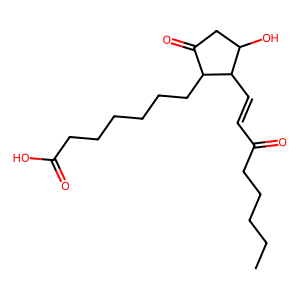

'7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid\n     RDKit          2D\n\n 25 25  0  0  0  0  0  0  0  0999 V2000\n   10.2760   -5.1962    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    9.5260   -3.8971    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    8.0260   -3.8971    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    7.2760   -2.5981    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    5.7760   -2.5981    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    5.0260   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    5.7760    0.0000    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n    3.5260   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.7760    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.2760    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.3943    1.2135    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.0323    0.7500    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.0323   -

'7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid\n     RDKit          3D\n\n 57 57  0  0  0  0  0  0  0  0999 V2000\n    7.1619    1.1779    1.5556 C   0  0  0  0  0  0  0  0  0  0  0  0\n    6.8599    1.8462    0.2342 C   0  0  0  0  0  0  0  0  0  0  0  0\n    5.6588    1.1014   -0.3776 C   0  0  0  0  0  0  0  0  0  0  0  0\n    4.5470    1.2454    0.5908 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.2384    0.5579    0.1570 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.6781    1.1116   -1.0667 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.3532    2.1218   -1.5479 O   0  0  0  0  0  0  0  0  0  0  0  0\n    1.5314    0.7525   -1.8318 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.6662   -0.1663   -1.6364 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.6188   -1.1162   -0.5511 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.5364   -2.5618   -1.0179 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.1160   -3.2693    0.2631 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.5402   -

'7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid\n     RDKit          2D\n\n 25 25  0  0  0  0  0  0  0  0999 V2000\n    3.5045   -7.5385    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    4.0904   -6.1577    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.1875   -4.9598    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.7734   -3.5790    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.8705   -2.3812    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.4565   -1.0003    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    4.9453   -0.8173    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n    2.5536    0.1975    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.1395    1.5783    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.2366    2.7762    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.6750    4.2107    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.4462    5.0709    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.2483    

Parent CanoicalSMILES: CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O
Parent IsomericSMILES: CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O


'NaN'

'NaN'

'NaN'

0

'NaN'

'NaN'

'NaN'

'NaN'

'CHEMBL268871;CHEMBL276851;CHEMBL278299;CHEMBL31370;CHEMBL284649;CHEMBL34623;CHEMBL32419;CHEMBL36231;CHEMBL37929;CHEMBL288849;CHEMBL40701;CHEMBL54156;CHEMBL298815;CHEMBL299901;CHEMBL300787;CHEMBL302861;CHEMBL304656;CHEMBL66649;CHEMBL308467;CHEMBL304579;CHEMBL305406;CHEMBL69461;CHEMBL423857;CHEMBL75917;CHEMBL309275;CHEMBL79468;CHEMBL312102;CHEMBL86061;CHEMBL421164;CHEMBL317386;CHEMBL101703;CHEMBL323145;CHEMBL316769;CHEMBL113510;CHEMBL113772;CHEMBL124401;CHEMBL121433;CHEMBL125536;CHEMBL124490;CHEMBL125489;CHEMBL130204;CHEMBL133412;CHEMBL144604;CHEMBL353041;CHEMBL349990;CHEMBL165538;CHEMBL166950;CHEMBL355432;CHEMBL173498;CHEMBL174494;CHEMBL368906;CHEMBL361606;CHEMBL183730;CHEMBL365926;CHEMBL370448;CHEMBL206531;CHEMBL208505;CHEMBL208665;CHEMBL209437;CHEMBL379005;CHEMBL376658;CHEMBL227783;CHEMBL394532;CHEMBL236671;CHEMBL235405;CHEMBL236208;CHEMBL236209;CHEMBL240483;CHEMBL400276;CHEMBL250496;CHEMBL250469;CHEMBL402446;CHEMBL481187;CHEMBL467956;CHEMBL482453;CHEMBL587822;CHEMBL582556;CHEMBL5480

'L-697661;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;

'351.0541;351.9531;351.0582;351.0793;351.0793;352.0841;352.0841;351.0582;351.0793;351.0793;351.0219;351.0000;351.0793;351.0793;351.0793;352.0635;351.0793;351.0331;351.0429;351.0470;351.0905;351.0905;351.0000;351.0429;351.0429;351.0000;351.0000;351.0541;352.0846;351.0541;351.0541;350.9929;350.9929;352.0671;351.9531;351.0753;351.1018;351.0582;351.0541;350.9847;352.0783;352.0783;351.0041;351.0582;351.0582;351.0541;351.0541;351.0662;351.0120;350.9888;352.0671;351.0371;350.9306;350.9895;351.0429;351.0793;350.9800;351.0000;351.0000;350.9929;352.0783;352.0646;351.0793;351.0517;351.0517;351.0517;351.0517;352.0471;352.0671;352.0646;351.0429;351.0259;351.0541;351.0429;351.0470;351.9419;351.0905;351.0793;351.0793;351.0834;351.0793;351.0793;351.0905;351.0905;350.9895;351.0000;351.0593;350.9841;350.9841;350.9841;350.9841;350.9841;352.0672;351.0541;351.0541;352.0419;351.0834;351.0834;351.0270;351.0793;351.0834;351.0793;351.0834;351.0834;351.0177;351.0041;351.0106;351.0007;351.0219;351.0259;352.0783;

'[#6]-[#6]-[#6]-[#6]-[#6]-[#6](=[#8])-[#6]=[#6]-[#6]1-[#6](-[#6]-[#6](=[#8])-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6](=[#8])-[#8])-[#8]'

'63;113;1029;1039;1040;1041;1069'

'Aliphatic long chain;Michael acceptor;Ketone;long chain hydrocarbon;Long aliphatic chain;Unbranched chain;vinyl michael acceptor1'

'Dundee;Dundee;MLSMR;MLSMR;MLSMR;MLSMR;MLSMR'

'[R0;D2][R0;D2][R0;D2][R0;D2], C=!@CC=[O,S], [#6]-C(=O)-[#6], [CD2;R0][CD2;R0][CD2;R0][CD2;R0][CD2;R0][CD2;R0], [N,C,S,O]!@[N,C,S,O]!@[N,C,S,O]!@[N,C,S,O]!@[N,C,S,O]!@[N,C,S,O]!@[N,C,S,O], [$([A&D2]),$([A&D1])]!@[A&D2]!@[A&D2]!@[A&D2]!@[A&D2]!@[$([A&D2]),$([A&D1])], [#6]-[CH1]=C-C(=O)[#6,#7,#8]'

,CHEMBL_ID,Preferred_Name,Molecular_Species,ALogP3,Aromatic_Rings,LogD_pH7_4,LogP,Acidic_pKa,Basic_pKa,H-Bond_Accpt_Cnt,...,Similar_Struct_Compounds,Similar_Struct_Name,Similar_Struct_Similariy,Mol_File_2D,Mol_File_3D,Coordinates_2D,All_Fragments,Fragments_Formula,Fragments_ExactMass,Biotherapeutic
0,NaN,NaN,NaN,0.0,0,0.0,0.0,0.0,0.0,0,...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,NaN,NaN,NaN,False


ChEBI URL Using InChIKey: https://www.ebi.ac.uk/chebi/advancedSearchFT.do?searchString=VXPBDCBTMSKCKZ-UHFFFAOYSA-N
ChEBI ID using InChIKey: NaN
ChEBI ID from Parent InChIKey: NaN
Most frequent ChEBI_ID from Pubchem synonyms: NaN
ChEBI Chemical Roles: NaN
ChEBI Biological Roles: NaN
ChEBI Applications: NaN
This compound is a: NaN
ClassyFire URL: http://classyfire.wishartlab.com/entities/VXPBDCBTMSKCKZ-UHFFFAOYSA-N.json
ClassyFire CHEMONTIDs: ['CHEMONTID:0000000', 'CHEMONTID:0000012', 'CHEMONTID:0003909', 'CHEMONTID:0000513', 'CHEMONTID:0000514', 'CHEMONTID:0002949', 'CHEMONTID:0000341', 'CHEMONTID:0002938', 'CHEMONTID:0001363', 'CHEMONTID:0000275', 'CHEMONTID:0003487', 'CHEMONTID:0001292', 'CHEMONTID:0001137', 'CHEMONTID:0001205', 'CHEMONTID:0003940', 'CHEMONTID:0004150']
Number of ClassyFire Classifiers: 16
ClassyFire Names: ['Organic compounds', 'Lipids and lipid-like molecules', 'Fatty Acyls', 'Eicosanoids', 'Prostaglandins and related compounds', 'Long-chain fatty acids', 'Hydroxy f

,SUPPLIED_CMPD_INFO:,Supplied_Name,Supplied_PubchemID,Supplied_CAS,Supplied_MolecularFormula,Supplied_MolecularWeight,Supplied_ExactMass,Supplied_IUPACName
0,________________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.22497412,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...


,Supplied_InChIKey,Supplied_InChI,Supplied_CanonicalSMILES,Supplied_IsomericSMILES,Supplied_Synonyms,Supplied_Organisms,PARENT_CMPD_INFO:,Parent_Name,Parent_PubchemID,Parent_CAS,Parent_MolecularFormula,Parent_MolecularWeight,Parent_ExactMass,Parent_IUPACName,Parent_InChIKey,Parent_InChI
0,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,PD051112;FT\-0670654,NaN,______________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.2249741,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...


,Parent_CanonicalSMILES,Parent_IsomericSMILES,Parent_Synonyms,Parent_Organisms,COMPONENT_CMPD_INFO:,Component_Name,Component_PubchemID,Component_CAS,Component_MolecularFormula,Component_MolecularWeight
0,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,PD051112;FT\-0670654,NaN,____________,NaN,NaN,NaN,NaN,NaN


,Component_ExactMass,Component_IUPACName,Component_InChIKey,Component_InChI,Component_CanonicalSMILES,Component_IsomericSMILES,CLASSYFIRE_INFO:,Kingdom,Superclass,Class
0,NaN,NaN,NaN,NaN,NaN,NaN,________,Organic compounds,Lipids and lipid-like molecules,Fatty Acyls


,Subclass,Direct_Parent,Alternative_Parents,CHEMONTID,CHEMONTID_Names,CHEBI_INFO:,ChEBI_ID,ChEBI_IS,ChEBI_Chem_Role,ChEBI_Biol_Role
0,Eicosanoids,Prostaglandins and related compounds,NaN,CHEMONTID:0000000;CHEMONTID:0000012;CHEMONTID:...,Organic compounds;Lipids and lipid-like molecu...,______,NaN,NaN,NaN,NaN


,ChEBI_Application,OTHER_CMPD_IDs:,Preferred_Name,Molecular_Species,CHEMBL_ID,KEGG_Compound,KEGG_Drug,Drug_Central,Drug_Bank,ChemSpider
0,NaN,____,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,MetaCyc,VSDB,HMDB,LIPID MAPS,LINCS,RTECS_ID,UNII_ID,DSSTox_SID,Nikkaji_ID,Met_Workbench_ID
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,LIPID_INFO:,Lipid_Common_Name,Lipid_Abbreviations,Lipid_Map_ID,LIPIDAT_ID,SWISSLIPIDS_ID,Lipid_Category,Lipid_Main_Class,Lipid_Subclass,PHYSIOCHEMICAL_INFO:,ALogP3
0,__________,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,__,0.0


,ALogP3,XLogP3,Aromatic_Rings,LogD_pH7_4,LogP,Acidic_pKa,Basic_pKa,H-Bond_Accpt_Cnt,H-Bond_Accpt_Lipinski,H-Bond_Don_Cnt,H-Bond_Don_Lipinski
0,0.0,3.1,0,0.0,0.0,0.0,0.0,0,0,0,0


,H-Bond_Don_Lipinski,Heavy_Atom_Cnt,Nat_Prod_Likeness,Ro5_Violations,Polar_Surface_Area,Molecular_Vol,QED_Weighted,Rotatable_Bond_Cnt,Chirality,Complexity,Isotope_Atom_Cnt
0,0,0,0.0,0,0,0.0,0.0,0,0,469,0


,Def_Atom_Stero_Cnt,Undef_Atom_Stereo_Cnt,Def_Bond_Stereo_Cnt,Undef_Bond_Stereo_Cnt,Formal_Charge,Solubility[mg/L_at_18C],Density,UV_Spectra,CCS[M+H]+,CCS[M+K]+
0,0,3,0,1,0,0.0,0.0,0,0.0,0.0


,CCS[M+Na]+,CCS[M-H]-,Dissociation_Constants,Ro3_Pass,Common_Substructure,Indication_Class,Target_IDs,Organism_Targets,Target_Names,Alert_IDs
0,0.0,0.0,NaN,NaN,[#6]-[#6]-[#6]-[#6]-[#6]-[#6](=[#8])-[#6]=[#6]...,NaN,NaN,NaN,NaN,63;113;1029;1039;1040;1041;1069


,Alert_Names,Alert_Sets,Alert_Smarts,Similar_MW_Compounds,Similar_MW_Names,Similar_MW_MonoMW,Similar_Struct_Compounds,Similar_Struct_Name,Similar_Struct_Similariy,Mol_File_2D
0,Aliphatic long chain;Michael acceptor;Ketone;l...,Dundee;Dundee;MLSMR;MLSMR;MLSMR;MLSMR;MLSMR,"[R0;D2][R0;D2][R0;D2][R0;D2], C=!@CC=[O,S], [#...",CHEMBL268871;CHEMBL276851;CHEMBL278299;CHEMBL3...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...


,PARENT_CMPD_INFO:,Parent_Name,Parent_PubchemID,Parent_CAS,Parent_MolecularFormula,Parent_MolecularWeight,Parent_ExactMass,Parent_IUPACName,Parent_InChIKey,Parent_InChI,...,Similar_MW_Names,Similar_MW_MonoMW,Similar_Struct_Compounds,Similar_Struct_Name,Similar_Struct_Similariy,Mol_File_2D,Mol_File_3D,Coordinates_2D,Biotherapeutic,_
0,______________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.2249741,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_


,PARENT_CMPD_INFO:,Parent_Name,Parent_PubchemID,Parent_CAS,Parent_MolecularFormula,Parent_MolecularWeight,Parent_ExactMass,Parent_IUPACName,Parent_InChIKey,Parent_InChI,...,Similar_MW_Names,Similar_MW_MonoMW,Similar_Struct_Compounds,Similar_Struct_Name,Similar_Struct_Similariy,Mol_File_2D,Mol_File_3D,Coordinates_2D,Biotherapeutic,_
3,______________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.2249741,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
4,______________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.2249741,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
5,______________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.2249741,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_


,SUPPLIED_CMPD_INFO:,Supplied_Name,Supplied_PubchemID,Supplied_CAS,Supplied_MolecularFormula,Supplied_MolecularWeight,Supplied_ExactMass,Supplied_IUPACName,Supplied_InChIKey,Supplied_InChI,...,Similar_MW_Names,Similar_MW_MonoMW,Similar_Struct_Compounds,Similar_Struct_Name,Similar_Struct_Similariy,Mol_File_2D,Mol_File_3D,Coordinates_2D,Biotherapeutic,_
3,________________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.22497412,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
4,________________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.22497412,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
5,________________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.22497412,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_


0
1
2


,File_ID,Compound_ID,Metadata_Complete,HTTP_Error,spectrum_id,source_file,Compound_Name,CAS_ID,Pubchem_ID,InChIKey_ID,...,Similar_MW_Names,Similar_MW_MonoMW,Similar_Struct_Compounds,Similar_Struct_Name,Similar_Struct_Similariy,Mol_File_2D,Mol_File_3D,Coordinates_2D,Biotherapeutic,_
0,12336,1446,True,False,CCMSLIB00000079800,p1-C11_GC11_01_17907.mzXML,MLS001049126-01!6-methoxy-2-(4-methoxyphenyl)c...,NaN,NaN,ANVFDWBCVDQNEZ-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12337,1447,True,True,CCMSLIB00009976449,suspect_list_batch_creation.mgf,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray...",NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12338,1447,True,True,CCMSLIB00009976450,suspect_list_batch_creation.mgf,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray...",NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12339,1448,True,True,CCMSLIB00000853735,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
4,12340,1448,False,False,CCMSLIB00000853737,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
5,12341,1448,False,False,CCMSLIB00000853738,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
6,12342,1449,False,False,CCMSLIB00000085401,p4-A04_GA4_01_18328.mzXML,MLS002153785-01!Bambuterol hydrochloride81732-...,NaN,NaN,ANZXOIAKUNOVQU-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,12343,1450,False,False,CCMSLIB00000085642,p4-D08_GD8_01_18368.mzXML,MLS002153875-01!Tubocurarine chloride pentahyd...,NaN,NaN,AOBPAKXXTHEDBT-JSPCEGANSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,12344,1451,False,False,CCMSLIB00000078746,p1-B03_GB3_01_17887.mzXML,NaN,NaN,NaN,AOCCRKXUBBAOQI-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,12345,1451,False,False,CCMSLIB00000078747,p1-B03_GB3_01_17887.mzXML,NaN,NaN,NaN,AOCCRKXUBBAOQI-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(10487, 124)

,File_ID,Compound_ID,Metadata_Complete,HTTP_Error,spectrum_id,source_file,Compound_Name,CAS_ID,Pubchem_ID,InChIKey_ID,...,Similar_MW_Names,Similar_MW_MonoMW,Similar_Struct_Compounds,Similar_Struct_Name,Similar_Struct_Similariy,Mol_File_2D,Mol_File_3D,Coordinates_2D,Biotherapeutic,_
0,12336,1446,True,False,CCMSLIB00000079800,p1-C11_GC11_01_17907.mzXML,MLS001049126-01!6-methoxy-2-(4-methoxyphenyl)c...,NaN,NaN,ANVFDWBCVDQNEZ-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12337,1447,True,True,CCMSLIB00009976449,suspect_list_batch_creation.mgf,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray...",NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12338,1447,True,True,CCMSLIB00009976450,suspect_list_batch_creation.mgf,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray...",NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12339,1448,True,True,CCMSLIB00000853735,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
4,12340,1448,False,False,CCMSLIB00000853737,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
5,12341,1448,False,False,CCMSLIB00000853738,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
6,12342,1449,False,False,CCMSLIB00000085401,p4-A04_GA4_01_18328.mzXML,MLS002153785-01!Bambuterol hydrochloride81732-...,NaN,NaN,ANZXOIAKUNOVQU-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,12343,1450,False,False,CCMSLIB00000085642,p4-D08_GD8_01_18368.mzXML,MLS002153875-01!Tubocurarine chloride pentahyd...,NaN,NaN,AOBPAKXXTHEDBT-JSPCEGANSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,12344,1451,False,False,CCMSLIB00000078746,p1-B03_GB3_01_17887.mzXML,NaN,NaN,NaN,AOCCRKXUBBAOQI-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,12345,1451,False,False,CCMSLIB00000078747,p1-B03_GB3_01_17887.mzXML,NaN,NaN,NaN,AOCCRKXUBBAOQI-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(10487, 150)

,File_ID,Compound_ID,Metadata_Complete,HTTP_Error,spectrum_id,source_file,Compound_Name,CAS_ID,Pubchem_ID,InChIKey_ID,Original_Compound_Name
0,12336,1446,True,False,CCMSLIB00000079800,p1-C11_GC11_01_17907.mzXML,MLS001049126-01!6-methoxy-2-(4-methoxyphenyl)c...,NaN,NaN,ANVFDWBCVDQNEZ-UHFFFAOYSA-N,MLS001049126-01 6-methoxy-2-(4-methoxyphenyl)c...
1,12337,1447,True,True,CCMSLIB00009976449,suspect_list_batch_creation.mgf,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray...",NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,"Suspect related to NCGC00385789-01_C26H42O9_5,..."
2,12338,1447,True,True,CCMSLIB00009976450,suspect_list_batch_creation.mgf,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray...",NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,"Suspect related to NCGC00385789-01_C26H42O9_5,..."
3,12339,1448,True,True,CCMSLIB00000853735,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray..."
4,12340,1448,False,False,CCMSLIB00000853737,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray..."
5,12341,1448,False,False,CCMSLIB00000853738,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray..."
6,12342,1449,False,False,CCMSLIB00000085401,p4-A04_GA4_01_18328.mzXML,MLS002153785-01!Bambuterol hydrochloride81732-...,NaN,NaN,ANZXOIAKUNOVQU-UHFFFAOYSA-N,MLS002153785-01 Bambuterol hydrochloride81732-...
7,12343,1450,False,False,CCMSLIB00000085642,p4-D08_GD8_01_18368.mzXML,MLS002153875-01!Tubocurarine chloride pentahyd...,NaN,NaN,AOBPAKXXTHEDBT-JSPCEGANSA-N,MLS002153875-01 Tubocurarine chloride pentahyd...
8,12344,1451,False,False,CCMSLIB00000078746,p1-B03_GB3_01_17887.mzXML,NaN,NaN,NaN,AOCCRKXUBBAOQI-UHFFFAOYSA-N,NCGC00160240-01 PERFAMINE
9,12345,1451,False,False,CCMSLIB00000078747,p1-B03_GB3_01_17887.mzXML,NaN,NaN,NaN,AOCCRKXUBBAOQI-UHFFFAOYSA-N,NCGC00160240-01 PERFAMINE


(10487, 11)

''

'7_(3_hydroxy_5_oxo_2_(3_oxooct_1_enyl)cy'

######################################################################################################################
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Analysis: 2 out of 10487 compound files in Chunk2
There are 3/1446 unique compounds that have been searched in Chunk2
There are 4/10487 entered_df compound id files that have been searched in Chunk2
___________________________________________________________________________________________
User-Defined Compound Name: NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygrayanotox-10-en-3-yl hexopyranoside
User-Defined Pubchem ID (CID): NaN
User-Defined CAS: NaN
User-Defined InChIKey: ANXMAYKAWZAHMB-UHFFFAOYSA-N
Pubchem User Defined Inchikey URL: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchikey/ANXMAYKAWZAHMB-UHFFFAOYSA-N/JSON


['1',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

[]

[]

[]

[]


[]

[]

CID_from_Various_Compound_Name: 14
Pubchem User Defined Compound URL: []
CID_from_Compound_Name: 
CID_from_Compound_Name: 
Pubchem CID from CAS Input: 
Pubchem CID from InChIKey Input: 45359849
Pubchem CID from CID Input: 
Pubchem CID from CAS Input: 
Pubchem CID from CAS Input: 
Pubchem CID from CAS Input: 
https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/14/JSON
Supplied_Name: 7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid
Supplied_CID: 14
CID URL: https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/14/JSON
Pubchem Metadata JSON File: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/14/property/IUPACName,MolecularWeight,MolecularFormula,ExactMass,Inchi,Inchikey,CanonicalSMILES,IsomericSMILES/JSON
7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid
14
VXPBDCBTMSKCKZ-UHFFFAOYSA-N
22973-19-9
Real_CID:14
mark:0
Supplied Compound Name: 7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid
Supplied_CAS: 22973-19-9
Supplie

,Supplied_Name,Supplied_PubchemID,Supplied_CAS,Supplied_MolecularFormula,Supplied_MolecularWeight,Supplied_ExactMass,Supplied_IUPACName,Supplied_InChIKey,Supplied_InChI,Supplied_CanonicalSMILES,Supplied_IsomericSMILES,Supplied_Synonyms,Supplied_Organisms
0,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.22497412,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,PD051112;FT\-0670654,NaN


Pubchem Supplied CID Source URL:  https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/14/JSON
Supplied Name: 7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid
Supplied CID: 14
Parent Name: 7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid
Parent CID: 14
Component CIDs: NaN
Component Names: NaN
Parent_CID URL: https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/14/JSON
Parent_CAS: 22973-19-9
Parent Compound Pubchem Metadata JSON File: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/14/property/IUPACName,MolecularWeight,MolecularFormula,ExactMass,Inchi,Inchikey,CanonicalSMILES,IsomericSMILES/JSON
Parent_Name: 7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid
Parent_CID: 14
Parent_IUPACName: 7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid
Parent_MolecularWeight: 352.5
Parent_MolecularFormula: C20H32O5
Parent_ExactMass: 352.2249741
Parent_InChI: InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16(18(22)14-19(

,Parent_Name,Parent_PubchemID,Parent_CAS,Parent_MolecularFormula,Parent_MolecularWeight,Parent_ExactMass,Parent_IUPACName,Parent_InChIKey,Parent_InChI,Parent_CanonicalSMILES,Parent_IsomericSMILES,Parent_Synonyms,Parent_Organisms
0,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.2249741,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,PD051112;FT\-0670654,NaN


Component Names: NaN
Component CID: NaN
Component IUPACName: NaN
Component MolecularFormula: NaN
Component MolecularWeight: NaN
Component ExactMass: NaN
Component CanonicalSMILES: NaN
Component IsomericSMILES: NaN
Component InChI: NaN
Component InChIKey: NaN
Component CAS: NaN


,Component_Name,Component_PubchemID,Component_CAS,Component_MolecularFormula,Component_MolecularWeight,Component_ExactMass,Component_IUPACName,Component_InChIKey,Component_InChI,Component_CanonicalSMILES,Component_IsomericSMILES
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ChEBI Data URL: https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/14/JSON
ChEBI ID from Parent Pubchem ID: NaN
UV_Spectra: 0
Dissociation Constant: NaN
Density: 0.0
Formal Charge: 0
CCS [M+H]+: 0.0
CCS [M+K]+: 0.0
CCS [M+Na]+: 0.0
CCS [M+H]-: 0.0
RTECS Number: NaN
UNII ID: NaN
DSSTox_SID: NaN
Nikkaji ID: NaN
Metabolomics Workbench ID: NaN
Hydrogen Bond Donor Count: 2
Hydrogen Bond Acceptor Count: 5
Rotatable Bond Count: 13
Topological Polar Surface Area: 91.7
Heavy Atom Count: 25
Isotope_Atom Cnt: 0
Solubility (mg/L at 18C): 0
LogP: 3.1
XLogP3: 3.1
Complexity: 469
Def Atom Stereocenter Count: 0
Undef Atom Stereocenter Count: 3
Def Bond Stereocenter Count: 0
Undef Bond Stereocenter Count: 1
Undef Bond Stereocenter Count: 1
Formal Charge: 0


,RTECS_ID,UNII_ID,DSSTox_SID,Nikkaji_ID,Met_Workbench_ID,XLogP3,Complexity,Isotope_Atom_Cnt,Def_Atom_Stero_Cnt,Undef_Atom_Stereo_Cnt,...,Undef_Bond_Stereo_Cnt,Formal_Charge,Solubility[mg/L_at_18C],Density,UV_Spectra,Dissociation_Constants,CCS[M+H]+,CCS[M+K]+,CCS[M+Na]+,CCS[M-H]-
0,NaN,NaN,NaN,NaN,NaN,3.1,469,0,0,3,...,1,0,0.0,0.0,0,NaN,0.0,0.0,0.0,0.0


False
NaN


,Lipid_Common_Name,Lipid_Abbreviations,Lipid_Map_ID,LIPIDAT_ID,SWISSLIPIDS_ID,Lipid_Category,Lipid_Main_Class,Lipid_Subclass,Molecular_Vol
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


ChEMBL_ID: NaN


['PD051112', 'FT\\-0670654']

ChEMBL_ID: NaN
CHEMBL_ID: NaN


{'molecular_species': 'NaN',
 'alogp': 0.0,
 'aromatic_rings': 0,
 'cx_logd': 0.0,
 'cx_logp': 0.0,
 'cx_most_apka': 0.0,
 'cx_most_bpka': 0.0,
 'hba': 0,
 'hba_lipinski': 0,
 'hbd': 0,
 'hbd_lipinski': 0,
 'heavy_atoms': 0,
 'num_ro5_violations': 0,
 'psa': 0,
 'qed_weighted': 0.0,
 'ro3_pass': 'NaN',
 'rtb': 0,
 'np_likeness_score': 0.0,
 'num_lipinski_ro5_violations': 0}

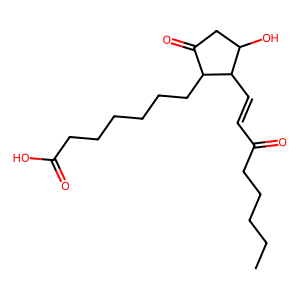

'7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid\n     RDKit          2D\n\n 25 25  0  0  0  0  0  0  0  0999 V2000\n   10.2760   -5.1962    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    9.5260   -3.8971    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    8.0260   -3.8971    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    7.2760   -2.5981    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    5.7760   -2.5981    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    5.0260   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    5.7760    0.0000    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n    3.5260   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.7760    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.2760    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.3943    1.2135    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.0323    0.7500    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.0323   -

'7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid\n     RDKit          3D\n\n 57 57  0  0  0  0  0  0  0  0999 V2000\n    7.1619    1.1779    1.5556 C   0  0  0  0  0  0  0  0  0  0  0  0\n    6.8599    1.8462    0.2342 C   0  0  0  0  0  0  0  0  0  0  0  0\n    5.6588    1.1014   -0.3776 C   0  0  0  0  0  0  0  0  0  0  0  0\n    4.5470    1.2454    0.5908 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.2384    0.5579    0.1570 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.6781    1.1116   -1.0667 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.3532    2.1218   -1.5479 O   0  0  0  0  0  0  0  0  0  0  0  0\n    1.5314    0.7525   -1.8318 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.6662   -0.1663   -1.6364 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.6188   -1.1162   -0.5511 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.5364   -2.5618   -1.0179 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.1160   -3.2693    0.2631 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.5402   -

'7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid\n     RDKit          2D\n\n 25 25  0  0  0  0  0  0  0  0999 V2000\n    3.5045   -7.5385    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    4.0904   -6.1577    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.1875   -4.9598    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.7734   -3.5790    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.8705   -2.3812    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.4565   -1.0003    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    4.9453   -0.8173    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n    2.5536    0.1975    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.1395    1.5783    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.2366    2.7762    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.6750    4.2107    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.4462    5.0709    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.2483    

Parent CanoicalSMILES: CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O
Parent IsomericSMILES: CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O


'NaN'

'NaN'

'NaN'

0

'NaN'

'NaN'

'NaN'

'NaN'

'CHEMBL268871;CHEMBL276851;CHEMBL278299;CHEMBL31370;CHEMBL284649;CHEMBL34623;CHEMBL32419;CHEMBL36231;CHEMBL37929;CHEMBL288849;CHEMBL40701;CHEMBL54156;CHEMBL298815;CHEMBL299901;CHEMBL300787;CHEMBL302861;CHEMBL304656;CHEMBL66649;CHEMBL308467;CHEMBL304579;CHEMBL305406;CHEMBL69461;CHEMBL423857;CHEMBL75917;CHEMBL309275;CHEMBL79468;CHEMBL312102;CHEMBL86061;CHEMBL421164;CHEMBL317386;CHEMBL101703;CHEMBL323145;CHEMBL316769;CHEMBL113510;CHEMBL113772;CHEMBL124401;CHEMBL121433;CHEMBL125536;CHEMBL124490;CHEMBL125489;CHEMBL130204;CHEMBL133412;CHEMBL144604;CHEMBL353041;CHEMBL349990;CHEMBL165538;CHEMBL166950;CHEMBL355432;CHEMBL173498;CHEMBL174494;CHEMBL368906;CHEMBL361606;CHEMBL183730;CHEMBL365926;CHEMBL370448;CHEMBL206531;CHEMBL208505;CHEMBL208665;CHEMBL209437;CHEMBL379005;CHEMBL376658;CHEMBL227783;CHEMBL394532;CHEMBL236671;CHEMBL235405;CHEMBL236208;CHEMBL236209;CHEMBL240483;CHEMBL400276;CHEMBL250496;CHEMBL250469;CHEMBL402446;CHEMBL481187;CHEMBL467956;CHEMBL482453;CHEMBL587822;CHEMBL582556;CHEMBL5480

'L-697661;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;

'351.0541;351.9531;351.0582;351.0793;351.0793;352.0841;352.0841;351.0582;351.0793;351.0793;351.0219;351.0000;351.0793;351.0793;351.0793;352.0635;351.0793;351.0331;351.0429;351.0470;351.0905;351.0905;351.0000;351.0429;351.0429;351.0000;351.0000;351.0541;352.0846;351.0541;351.0541;350.9929;350.9929;352.0671;351.9531;351.0753;351.1018;351.0582;351.0541;350.9847;352.0783;352.0783;351.0041;351.0582;351.0582;351.0541;351.0541;351.0662;351.0120;350.9888;352.0671;351.0371;350.9306;350.9895;351.0429;351.0793;350.9800;351.0000;351.0000;350.9929;352.0783;352.0646;351.0793;351.0517;351.0517;351.0517;351.0517;352.0471;352.0671;352.0646;351.0429;351.0259;351.0541;351.0429;351.0470;351.9419;351.0905;351.0793;351.0793;351.0834;351.0793;351.0793;351.0905;351.0905;350.9895;351.0000;351.0593;350.9841;350.9841;350.9841;350.9841;350.9841;352.0672;351.0541;351.0541;352.0419;351.0834;351.0834;351.0270;351.0793;351.0834;351.0793;351.0834;351.0834;351.0177;351.0041;351.0106;351.0007;351.0219;351.0259;352.0783;

'[#6]-[#6]-[#6]-[#6]-[#6]-[#6](=[#8])-[#6]=[#6]-[#6]1-[#6](-[#6]-[#6](=[#8])-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6](=[#8])-[#8])-[#8]'

'63;113;1029;1039;1040;1041;1069'

'Aliphatic long chain;Michael acceptor;Ketone;long chain hydrocarbon;Long aliphatic chain;Unbranched chain;vinyl michael acceptor1'

'Dundee;Dundee;MLSMR;MLSMR;MLSMR;MLSMR;MLSMR'

'[R0;D2][R0;D2][R0;D2][R0;D2], C=!@CC=[O,S], [#6]-C(=O)-[#6], [CD2;R0][CD2;R0][CD2;R0][CD2;R0][CD2;R0][CD2;R0], [N,C,S,O]!@[N,C,S,O]!@[N,C,S,O]!@[N,C,S,O]!@[N,C,S,O]!@[N,C,S,O]!@[N,C,S,O], [$([A&D2]),$([A&D1])]!@[A&D2]!@[A&D2]!@[A&D2]!@[A&D2]!@[$([A&D2]),$([A&D1])], [#6]-[CH1]=C-C(=O)[#6,#7,#8]'

,CHEMBL_ID,Preferred_Name,Molecular_Species,ALogP3,Aromatic_Rings,LogD_pH7_4,LogP,Acidic_pKa,Basic_pKa,H-Bond_Accpt_Cnt,...,Similar_Struct_Compounds,Similar_Struct_Name,Similar_Struct_Similariy,Mol_File_2D,Mol_File_3D,Coordinates_2D,All_Fragments,Fragments_Formula,Fragments_ExactMass,Biotherapeutic
0,NaN,NaN,NaN,0.0,0,0.0,0.0,0.0,0.0,0,...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,NaN,NaN,NaN,False


ChEBI URL Using InChIKey: https://www.ebi.ac.uk/chebi/advancedSearchFT.do?searchString=VXPBDCBTMSKCKZ-UHFFFAOYSA-N
ChEBI ID using InChIKey: NaN
ChEBI ID from Parent InChIKey: NaN
Most frequent ChEBI_ID from Pubchem synonyms: NaN
ChEBI Chemical Roles: NaN
ChEBI Biological Roles: NaN
ChEBI Applications: NaN
This compound is a: NaN
ClassyFire URL: http://classyfire.wishartlab.com/entities/VXPBDCBTMSKCKZ-UHFFFAOYSA-N.json
ClassyFire CHEMONTIDs: ['CHEMONTID:0000000', 'CHEMONTID:0000012', 'CHEMONTID:0003909', 'CHEMONTID:0000513', 'CHEMONTID:0000514', 'CHEMONTID:0002949', 'CHEMONTID:0000341', 'CHEMONTID:0002938', 'CHEMONTID:0001363', 'CHEMONTID:0000275', 'CHEMONTID:0003487', 'CHEMONTID:0001292', 'CHEMONTID:0001137', 'CHEMONTID:0001205', 'CHEMONTID:0003940', 'CHEMONTID:0004150']
Number of ClassyFire Classifiers: 16
ClassyFire Names: ['Organic compounds', 'Lipids and lipid-like molecules', 'Fatty Acyls', 'Eicosanoids', 'Prostaglandins and related compounds', 'Long-chain fatty acids', 'Hydroxy f

,SUPPLIED_CMPD_INFO:,Supplied_Name,Supplied_PubchemID,Supplied_CAS,Supplied_MolecularFormula,Supplied_MolecularWeight,Supplied_ExactMass,Supplied_IUPACName
0,________________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.22497412,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...


,Supplied_InChIKey,Supplied_InChI,Supplied_CanonicalSMILES,Supplied_IsomericSMILES,Supplied_Synonyms,Supplied_Organisms,PARENT_CMPD_INFO:,Parent_Name,Parent_PubchemID,Parent_CAS,Parent_MolecularFormula,Parent_MolecularWeight,Parent_ExactMass,Parent_IUPACName,Parent_InChIKey,Parent_InChI
0,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,PD051112;FT\-0670654,NaN,______________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.2249741,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...


,Parent_CanonicalSMILES,Parent_IsomericSMILES,Parent_Synonyms,Parent_Organisms,COMPONENT_CMPD_INFO:,Component_Name,Component_PubchemID,Component_CAS,Component_MolecularFormula,Component_MolecularWeight
0,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,PD051112;FT\-0670654,NaN,____________,NaN,NaN,NaN,NaN,NaN


,Component_ExactMass,Component_IUPACName,Component_InChIKey,Component_InChI,Component_CanonicalSMILES,Component_IsomericSMILES,CLASSYFIRE_INFO:,Kingdom,Superclass,Class
0,NaN,NaN,NaN,NaN,NaN,NaN,________,Organic compounds,Lipids and lipid-like molecules,Fatty Acyls


,Subclass,Direct_Parent,Alternative_Parents,CHEMONTID,CHEMONTID_Names,CHEBI_INFO:,ChEBI_ID,ChEBI_IS,ChEBI_Chem_Role,ChEBI_Biol_Role
0,Eicosanoids,Prostaglandins and related compounds,NaN,CHEMONTID:0000000;CHEMONTID:0000012;CHEMONTID:...,Organic compounds;Lipids and lipid-like molecu...,______,NaN,NaN,NaN,NaN


,ChEBI_Application,OTHER_CMPD_IDs:,Preferred_Name,Molecular_Species,CHEMBL_ID,KEGG_Compound,KEGG_Drug,Drug_Central,Drug_Bank,ChemSpider
0,NaN,____,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,MetaCyc,VSDB,HMDB,LIPID MAPS,LINCS,RTECS_ID,UNII_ID,DSSTox_SID,Nikkaji_ID,Met_Workbench_ID
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,LIPID_INFO:,Lipid_Common_Name,Lipid_Abbreviations,Lipid_Map_ID,LIPIDAT_ID,SWISSLIPIDS_ID,Lipid_Category,Lipid_Main_Class,Lipid_Subclass,PHYSIOCHEMICAL_INFO:,ALogP3
0,__________,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,__,0.0


,ALogP3,XLogP3,Aromatic_Rings,LogD_pH7_4,LogP,Acidic_pKa,Basic_pKa,H-Bond_Accpt_Cnt,H-Bond_Accpt_Lipinski,H-Bond_Don_Cnt,H-Bond_Don_Lipinski
0,0.0,3.1,0,0.0,0.0,0.0,0.0,0,0,0,0


,H-Bond_Don_Lipinski,Heavy_Atom_Cnt,Nat_Prod_Likeness,Ro5_Violations,Polar_Surface_Area,Molecular_Vol,QED_Weighted,Rotatable_Bond_Cnt,Chirality,Complexity,Isotope_Atom_Cnt
0,0,0,0.0,0,0,0.0,0.0,0,0,469,0


,Def_Atom_Stero_Cnt,Undef_Atom_Stereo_Cnt,Def_Bond_Stereo_Cnt,Undef_Bond_Stereo_Cnt,Formal_Charge,Solubility[mg/L_at_18C],Density,UV_Spectra,CCS[M+H]+,CCS[M+K]+
0,0,3,0,1,0,0.0,0.0,0,0.0,0.0


,CCS[M+Na]+,CCS[M-H]-,Dissociation_Constants,Ro3_Pass,Common_Substructure,Indication_Class,Target_IDs,Organism_Targets,Target_Names,Alert_IDs
0,0.0,0.0,NaN,NaN,[#6]-[#6]-[#6]-[#6]-[#6]-[#6](=[#8])-[#6]=[#6]...,NaN,NaN,NaN,NaN,63;113;1029;1039;1040;1041;1069


,Alert_Names,Alert_Sets,Alert_Smarts,Similar_MW_Compounds,Similar_MW_Names,Similar_MW_MonoMW,Similar_Struct_Compounds,Similar_Struct_Name,Similar_Struct_Similariy,Mol_File_2D
0,Aliphatic long chain;Michael acceptor;Ketone;l...,Dundee;Dundee;MLSMR;MLSMR;MLSMR;MLSMR;MLSMR,"[R0;D2][R0;D2][R0;D2][R0;D2], C=!@CC=[O,S], [#...",CHEMBL268871;CHEMBL276851;CHEMBL278299;CHEMBL3...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...


,PARENT_CMPD_INFO:,Parent_Name,Parent_PubchemID,Parent_CAS,Parent_MolecularFormula,Parent_MolecularWeight,Parent_ExactMass,Parent_IUPACName,Parent_InChIKey,Parent_InChI,...,Similar_MW_Names,Similar_MW_MonoMW,Similar_Struct_Compounds,Similar_Struct_Name,Similar_Struct_Similariy,Mol_File_2D,Mol_File_3D,Coordinates_2D,Biotherapeutic,_
0,______________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.2249741,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_


,PARENT_CMPD_INFO:,Parent_Name,Parent_PubchemID,Parent_CAS,Parent_MolecularFormula,Parent_MolecularWeight,Parent_ExactMass,Parent_IUPACName,Parent_InChIKey,Parent_InChI,...,Similar_MW_Names,Similar_MW_MonoMW,Similar_Struct_Compounds,Similar_Struct_Name,Similar_Struct_Similariy,Mol_File_2D,Mol_File_3D,Coordinates_2D,Biotherapeutic,_
4,______________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.2249741,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
5,______________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.2249741,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
6,______________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.2249741,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_


,SUPPLIED_CMPD_INFO:,Supplied_Name,Supplied_PubchemID,Supplied_CAS,Supplied_MolecularFormula,Supplied_MolecularWeight,Supplied_ExactMass,Supplied_IUPACName,Supplied_InChIKey,Supplied_InChI,...,Similar_MW_Names,Similar_MW_MonoMW,Similar_Struct_Compounds,Similar_Struct_Name,Similar_Struct_Similariy,Mol_File_2D,Mol_File_3D,Coordinates_2D,Biotherapeutic,_
4,________________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.22497412,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
5,________________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.22497412,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
6,________________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.22497412,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_


0
1
2


,File_ID,Compound_ID,Metadata_Complete,HTTP_Error,spectrum_id,source_file,Compound_Name,CAS_ID,Pubchem_ID,InChIKey_ID,...,Similar_MW_Names,Similar_MW_MonoMW,Similar_Struct_Compounds,Similar_Struct_Name,Similar_Struct_Similariy,Mol_File_2D,Mol_File_3D,Coordinates_2D,Biotherapeutic,_
0,12336,1446,True,False,CCMSLIB00000079800,p1-C11_GC11_01_17907.mzXML,MLS001049126-01!6-methoxy-2-(4-methoxyphenyl)c...,NaN,NaN,ANVFDWBCVDQNEZ-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12337,1447,True,True,CCMSLIB00009976449,suspect_list_batch_creation.mgf,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray...",NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12338,1447,True,True,CCMSLIB00009976450,suspect_list_batch_creation.mgf,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray...",NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12339,1448,True,True,CCMSLIB00000853735,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12340,1448,False,False,CCMSLIB00000853737,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
5,12341,1448,False,False,CCMSLIB00000853738,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
6,12342,1449,False,False,CCMSLIB00000085401,p4-A04_GA4_01_18328.mzXML,MLS002153785-01!Bambuterol hydrochloride81732-...,NaN,NaN,ANZXOIAKUNOVQU-UHFFFAOYSA-N,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
7,12343,1450,False,False,CCMSLIB00000085642,p4-D08_GD8_01_18368.mzXML,MLS002153875-01!Tubocurarine chloride pentahyd...,NaN,NaN,AOBPAKXXTHEDBT-JSPCEGANSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,12344,1451,False,False,CCMSLIB00000078746,p1-B03_GB3_01_17887.mzXML,NaN,NaN,NaN,AOCCRKXUBBAOQI-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,12345,1451,False,False,CCMSLIB00000078747,p1-B03_GB3_01_17887.mzXML,NaN,NaN,NaN,AOCCRKXUBBAOQI-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(10487, 124)

,File_ID,Compound_ID,Metadata_Complete,HTTP_Error,spectrum_id,source_file,Compound_Name,CAS_ID,Pubchem_ID,InChIKey_ID,...,Similar_MW_Names,Similar_MW_MonoMW,Similar_Struct_Compounds,Similar_Struct_Name,Similar_Struct_Similariy,Mol_File_2D,Mol_File_3D,Coordinates_2D,Biotherapeutic,_
0,12336,1446,True,False,CCMSLIB00000079800,p1-C11_GC11_01_17907.mzXML,MLS001049126-01!6-methoxy-2-(4-methoxyphenyl)c...,NaN,NaN,ANVFDWBCVDQNEZ-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12337,1447,True,True,CCMSLIB00009976449,suspect_list_batch_creation.mgf,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray...",NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12338,1447,True,True,CCMSLIB00009976450,suspect_list_batch_creation.mgf,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray...",NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12339,1448,True,True,CCMSLIB00000853735,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12340,1448,False,False,CCMSLIB00000853737,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
5,12341,1448,False,False,CCMSLIB00000853738,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
6,12342,1449,False,False,CCMSLIB00000085401,p4-A04_GA4_01_18328.mzXML,MLS002153785-01!Bambuterol hydrochloride81732-...,NaN,NaN,ANZXOIAKUNOVQU-UHFFFAOYSA-N,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
7,12343,1450,False,False,CCMSLIB00000085642,p4-D08_GD8_01_18368.mzXML,MLS002153875-01!Tubocurarine chloride pentahyd...,NaN,NaN,AOBPAKXXTHEDBT-JSPCEGANSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,12344,1451,False,False,CCMSLIB00000078746,p1-B03_GB3_01_17887.mzXML,NaN,NaN,NaN,AOCCRKXUBBAOQI-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,12345,1451,False,False,CCMSLIB00000078747,p1-B03_GB3_01_17887.mzXML,NaN,NaN,NaN,AOCCRKXUBBAOQI-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(10487, 150)

,File_ID,Compound_ID,Metadata_Complete,HTTP_Error,spectrum_id,source_file,Compound_Name,CAS_ID,Pubchem_ID,InChIKey_ID,Original_Compound_Name
0,12336,1446,True,False,CCMSLIB00000079800,p1-C11_GC11_01_17907.mzXML,MLS001049126-01!6-methoxy-2-(4-methoxyphenyl)c...,NaN,NaN,ANVFDWBCVDQNEZ-UHFFFAOYSA-N,MLS001049126-01 6-methoxy-2-(4-methoxyphenyl)c...
1,12337,1447,True,True,CCMSLIB00009976449,suspect_list_batch_creation.mgf,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray...",NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,"Suspect related to NCGC00385789-01_C26H42O9_5,..."
2,12338,1447,True,True,CCMSLIB00009976450,suspect_list_batch_creation.mgf,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray...",NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,"Suspect related to NCGC00385789-01_C26H42O9_5,..."
3,12339,1448,True,True,CCMSLIB00000853735,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray..."
4,12340,1448,False,False,CCMSLIB00000853737,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray..."
5,12341,1448,False,False,CCMSLIB00000853738,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray..."
6,12342,1449,False,False,CCMSLIB00000085401,p4-A04_GA4_01_18328.mzXML,MLS002153785-01!Bambuterol hydrochloride81732-...,NaN,NaN,ANZXOIAKUNOVQU-UHFFFAOYSA-N,MLS002153785-01 Bambuterol hydrochloride81732-...
7,12343,1450,False,False,CCMSLIB00000085642,p4-D08_GD8_01_18368.mzXML,MLS002153875-01!Tubocurarine chloride pentahyd...,NaN,NaN,AOBPAKXXTHEDBT-JSPCEGANSA-N,MLS002153875-01 Tubocurarine chloride pentahyd...
8,12344,1451,False,False,CCMSLIB00000078746,p1-B03_GB3_01_17887.mzXML,NaN,NaN,NaN,AOCCRKXUBBAOQI-UHFFFAOYSA-N,NCGC00160240-01 PERFAMINE
9,12345,1451,False,False,CCMSLIB00000078747,p1-B03_GB3_01_17887.mzXML,NaN,NaN,NaN,AOCCRKXUBBAOQI-UHFFFAOYSA-N,NCGC00160240-01 PERFAMINE


(10487, 11)

''

'7_(3_hydroxy_5_oxo_2_(3_oxooct_1_enyl)cy'

######################################################################################################################
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Analysis: 2 out of 10487 compound files in Chunk2
There are 3/1446 unique compounds that have been searched in Chunk2
There are 4/10487 entered_df compound id files that have been searched in Chunk2
___________________________________________________________________________________________
User-Defined Compound Name: NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygrayanotox-10-en-3-yl hexopyranoside
User-Defined Pubchem ID (CID): NaN
User-Defined CAS: NaN
User-Defined InChIKey: ANXMAYKAWZAHMB-UHFFFAOYSA-N
Pubchem User Defined Inchikey URL: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchikey/ANXMAYKAWZAHMB-UHFFFAOYSA-N/JSON


['1',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

[]

[]

[]

[]


[]

[]

CID_from_Various_Compound_Name: 14
Pubchem User Defined Compound URL: []
CID_from_Compound_Name: 
CID_from_Compound_Name: 
Pubchem CID from CAS Input: 
Pubchem CID from InChIKey Input: 45359849
Pubchem CID from CID Input: 
Pubchem CID from CAS Input: 
Pubchem CID from CAS Input: 
Pubchem CID from CAS Input: 
https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/14/JSON
Supplied_Name: 7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid
Supplied_CID: 14
CID URL: https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/14/JSON
Pubchem Metadata JSON File: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/14/property/IUPACName,MolecularWeight,MolecularFormula,ExactMass,Inchi,Inchikey,CanonicalSMILES,IsomericSMILES/JSON
7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid
14
VXPBDCBTMSKCKZ-UHFFFAOYSA-N
22973-19-9
Real_CID:14
mark:0
Supplied Compound Name: 7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid
Supplied_CAS: 22973-19-9
Supplie

,Supplied_Name,Supplied_PubchemID,Supplied_CAS,Supplied_MolecularFormula,Supplied_MolecularWeight,Supplied_ExactMass,Supplied_IUPACName,Supplied_InChIKey,Supplied_InChI,Supplied_CanonicalSMILES,Supplied_IsomericSMILES,Supplied_Synonyms,Supplied_Organisms
0,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.22497412,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,PD051112;FT\-0670654,NaN


Pubchem Supplied CID Source URL:  https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/14/JSON
Supplied Name: 7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid
Supplied CID: 14
Parent Name: 7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid
Parent CID: 14
Component CIDs: NaN
Component Names: NaN
Parent_CID URL: https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/14/JSON
Parent_CAS: 22973-19-9
Parent Compound Pubchem Metadata JSON File: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/14/property/IUPACName,MolecularWeight,MolecularFormula,ExactMass,Inchi,Inchikey,CanonicalSMILES,IsomericSMILES/JSON
Parent_Name: 7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid
Parent_CID: 14
Parent_IUPACName: 7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid
Parent_MolecularWeight: 352.5
Parent_MolecularFormula: C20H32O5
Parent_ExactMass: 352.2249741
Parent_InChI: InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16(18(22)14-19(

,Parent_Name,Parent_PubchemID,Parent_CAS,Parent_MolecularFormula,Parent_MolecularWeight,Parent_ExactMass,Parent_IUPACName,Parent_InChIKey,Parent_InChI,Parent_CanonicalSMILES,Parent_IsomericSMILES,Parent_Synonyms,Parent_Organisms
0,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.2249741,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,PD051112;FT\-0670654,NaN


Component Names: NaN
Component CID: NaN
Component IUPACName: NaN
Component MolecularFormula: NaN
Component MolecularWeight: NaN
Component ExactMass: NaN
Component CanonicalSMILES: NaN
Component IsomericSMILES: NaN
Component InChI: NaN
Component InChIKey: NaN
Component CAS: NaN


,Component_Name,Component_PubchemID,Component_CAS,Component_MolecularFormula,Component_MolecularWeight,Component_ExactMass,Component_IUPACName,Component_InChIKey,Component_InChI,Component_CanonicalSMILES,Component_IsomericSMILES
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ChEBI Data URL: https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/14/JSON
ChEBI ID from Parent Pubchem ID: NaN
UV_Spectra: 0
Dissociation Constant: NaN
Density: 0.0
Formal Charge: 0
CCS [M+H]+: 0.0
CCS [M+K]+: 0.0
CCS [M+Na]+: 0.0
CCS [M+H]-: 0.0
RTECS Number: NaN
UNII ID: NaN
DSSTox_SID: NaN
Nikkaji ID: NaN
Metabolomics Workbench ID: NaN
Hydrogen Bond Donor Count: 2
Hydrogen Bond Acceptor Count: 5
Rotatable Bond Count: 13
Topological Polar Surface Area: 91.7
Heavy Atom Count: 25
Isotope_Atom Cnt: 0
Solubility (mg/L at 18C): 0
LogP: 3.1
XLogP3: 3.1
Complexity: 469
Def Atom Stereocenter Count: 0
Undef Atom Stereocenter Count: 3
Def Bond Stereocenter Count: 0
Undef Bond Stereocenter Count: 1
Undef Bond Stereocenter Count: 1
Formal Charge: 0


,RTECS_ID,UNII_ID,DSSTox_SID,Nikkaji_ID,Met_Workbench_ID,XLogP3,Complexity,Isotope_Atom_Cnt,Def_Atom_Stero_Cnt,Undef_Atom_Stereo_Cnt,...,Undef_Bond_Stereo_Cnt,Formal_Charge,Solubility[mg/L_at_18C],Density,UV_Spectra,Dissociation_Constants,CCS[M+H]+,CCS[M+K]+,CCS[M+Na]+,CCS[M-H]-
0,NaN,NaN,NaN,NaN,NaN,3.1,469,0,0,3,...,1,0,0.0,0.0,0,NaN,0.0,0.0,0.0,0.0


False
NaN


,Lipid_Common_Name,Lipid_Abbreviations,Lipid_Map_ID,LIPIDAT_ID,SWISSLIPIDS_ID,Lipid_Category,Lipid_Main_Class,Lipid_Subclass,Molecular_Vol
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


ChEMBL_ID: NaN


['PD051112', 'FT\\-0670654']

ChEMBL_ID: NaN
CHEMBL_ID: NaN


{'molecular_species': 'NaN',
 'alogp': 0.0,
 'aromatic_rings': 0,
 'cx_logd': 0.0,
 'cx_logp': 0.0,
 'cx_most_apka': 0.0,
 'cx_most_bpka': 0.0,
 'hba': 0,
 'hba_lipinski': 0,
 'hbd': 0,
 'hbd_lipinski': 0,
 'heavy_atoms': 0,
 'num_ro5_violations': 0,
 'psa': 0,
 'qed_weighted': 0.0,
 'ro3_pass': 'NaN',
 'rtb': 0,
 'np_likeness_score': 0.0,
 'num_lipinski_ro5_violations': 0}

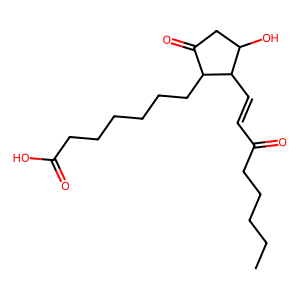

'7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid\n     RDKit          2D\n\n 25 25  0  0  0  0  0  0  0  0999 V2000\n   10.2760   -5.1962    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    9.5260   -3.8971    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    8.0260   -3.8971    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    7.2760   -2.5981    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    5.7760   -2.5981    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    5.0260   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    5.7760    0.0000    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n    3.5260   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.7760    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.2760    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.3943    1.2135    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.0323    0.7500    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.0323   -

'7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid\n     RDKit          3D\n\n 57 57  0  0  0  0  0  0  0  0999 V2000\n    7.1619    1.1779    1.5556 C   0  0  0  0  0  0  0  0  0  0  0  0\n    6.8599    1.8462    0.2342 C   0  0  0  0  0  0  0  0  0  0  0  0\n    5.6588    1.1014   -0.3776 C   0  0  0  0  0  0  0  0  0  0  0  0\n    4.5470    1.2454    0.5908 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.2384    0.5579    0.1570 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.6781    1.1116   -1.0667 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.3532    2.1218   -1.5479 O   0  0  0  0  0  0  0  0  0  0  0  0\n    1.5314    0.7525   -1.8318 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.6662   -0.1663   -1.6364 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.6188   -1.1162   -0.5511 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.5364   -2.5618   -1.0179 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.1160   -3.2693    0.2631 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.5402   -

'7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopentyl]heptanoic acid\n     RDKit          2D\n\n 25 25  0  0  0  0  0  0  0  0999 V2000\n    3.5045   -7.5385    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    4.0904   -6.1577    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.1875   -4.9598    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.7734   -3.5790    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.8705   -2.3812    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.4565   -1.0003    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    4.9453   -0.8173    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n    2.5536    0.1975    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.1395    1.5783    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.2366    2.7762    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.6750    4.2107    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.4462    5.0709    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.2483    

Parent CanoicalSMILES: CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O
Parent IsomericSMILES: CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O


'NaN'

'NaN'

'NaN'

0

'NaN'

'NaN'

'NaN'

'NaN'

'CHEMBL268871;CHEMBL276851;CHEMBL278299;CHEMBL31370;CHEMBL284649;CHEMBL34623;CHEMBL32419;CHEMBL36231;CHEMBL37929;CHEMBL288849;CHEMBL40701;CHEMBL54156;CHEMBL298815;CHEMBL299901;CHEMBL300787;CHEMBL302861;CHEMBL304656;CHEMBL66649;CHEMBL308467;CHEMBL304579;CHEMBL305406;CHEMBL69461;CHEMBL423857;CHEMBL75917;CHEMBL309275;CHEMBL79468;CHEMBL312102;CHEMBL86061;CHEMBL421164;CHEMBL317386;CHEMBL101703;CHEMBL323145;CHEMBL316769;CHEMBL113510;CHEMBL113772;CHEMBL124401;CHEMBL121433;CHEMBL125536;CHEMBL124490;CHEMBL125489;CHEMBL130204;CHEMBL133412;CHEMBL144604;CHEMBL353041;CHEMBL349990;CHEMBL165538;CHEMBL166950;CHEMBL355432;CHEMBL173498;CHEMBL174494;CHEMBL368906;CHEMBL361606;CHEMBL183730;CHEMBL365926;CHEMBL370448;CHEMBL206531;CHEMBL208505;CHEMBL208665;CHEMBL209437;CHEMBL379005;CHEMBL376658;CHEMBL227783;CHEMBL394532;CHEMBL236671;CHEMBL235405;CHEMBL236208;CHEMBL236209;CHEMBL240483;CHEMBL400276;CHEMBL250496;CHEMBL250469;CHEMBL402446;CHEMBL481187;CHEMBL467956;CHEMBL482453;CHEMBL587822;CHEMBL582556;CHEMBL5480

'L-697661;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;None;

'351.0541;351.9531;351.0582;351.0793;351.0793;352.0841;352.0841;351.0582;351.0793;351.0793;351.0219;351.0000;351.0793;351.0793;351.0793;352.0635;351.0793;351.0331;351.0429;351.0470;351.0905;351.0905;351.0000;351.0429;351.0429;351.0000;351.0000;351.0541;352.0846;351.0541;351.0541;350.9929;350.9929;352.0671;351.9531;351.0753;351.1018;351.0582;351.0541;350.9847;352.0783;352.0783;351.0041;351.0582;351.0582;351.0541;351.0541;351.0662;351.0120;350.9888;352.0671;351.0371;350.9306;350.9895;351.0429;351.0793;350.9800;351.0000;351.0000;350.9929;352.0783;352.0646;351.0793;351.0517;351.0517;351.0517;351.0517;352.0471;352.0671;352.0646;351.0429;351.0259;351.0541;351.0429;351.0470;351.9419;351.0905;351.0793;351.0793;351.0834;351.0793;351.0793;351.0905;351.0905;350.9895;351.0000;351.0593;350.9841;350.9841;350.9841;350.9841;350.9841;352.0672;351.0541;351.0541;352.0419;351.0834;351.0834;351.0270;351.0793;351.0834;351.0793;351.0834;351.0834;351.0177;351.0041;351.0106;351.0007;351.0219;351.0259;352.0783;

'[#6]-[#6]-[#6]-[#6]-[#6]-[#6](=[#8])-[#6]=[#6]-[#6]1-[#6](-[#6]-[#6](=[#8])-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6](=[#8])-[#8])-[#8]'

'63;113;1029;1039;1040;1041;1069'

'Aliphatic long chain;Michael acceptor;Ketone;long chain hydrocarbon;Long aliphatic chain;Unbranched chain;vinyl michael acceptor1'

'Dundee;Dundee;MLSMR;MLSMR;MLSMR;MLSMR;MLSMR'

'[R0;D2][R0;D2][R0;D2][R0;D2], C=!@CC=[O,S], [#6]-C(=O)-[#6], [CD2;R0][CD2;R0][CD2;R0][CD2;R0][CD2;R0][CD2;R0], [N,C,S,O]!@[N,C,S,O]!@[N,C,S,O]!@[N,C,S,O]!@[N,C,S,O]!@[N,C,S,O]!@[N,C,S,O], [$([A&D2]),$([A&D1])]!@[A&D2]!@[A&D2]!@[A&D2]!@[A&D2]!@[$([A&D2]),$([A&D1])], [#6]-[CH1]=C-C(=O)[#6,#7,#8]'

,CHEMBL_ID,Preferred_Name,Molecular_Species,ALogP3,Aromatic_Rings,LogD_pH7_4,LogP,Acidic_pKa,Basic_pKa,H-Bond_Accpt_Cnt,...,Similar_Struct_Compounds,Similar_Struct_Name,Similar_Struct_Similariy,Mol_File_2D,Mol_File_3D,Coordinates_2D,All_Fragments,Fragments_Formula,Fragments_ExactMass,Biotherapeutic
0,NaN,NaN,NaN,0.0,0,0.0,0.0,0.0,0.0,0,...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,NaN,NaN,NaN,False


ChEBI URL Using InChIKey: https://www.ebi.ac.uk/chebi/advancedSearchFT.do?searchString=VXPBDCBTMSKCKZ-UHFFFAOYSA-N
ChEBI ID using InChIKey: NaN
ChEBI ID from Parent InChIKey: NaN
Most frequent ChEBI_ID from Pubchem synonyms: NaN
ChEBI Chemical Roles: NaN
ChEBI Biological Roles: NaN
ChEBI Applications: NaN
This compound is a: NaN
ClassyFire URL: http://classyfire.wishartlab.com/entities/VXPBDCBTMSKCKZ-UHFFFAOYSA-N.json
ClassyFire CHEMONTIDs: ['CHEMONTID:0000000', 'CHEMONTID:0000012', 'CHEMONTID:0003909', 'CHEMONTID:0000513', 'CHEMONTID:0000514', 'CHEMONTID:0002949', 'CHEMONTID:0000341', 'CHEMONTID:0002938', 'CHEMONTID:0001363', 'CHEMONTID:0000275', 'CHEMONTID:0003487', 'CHEMONTID:0001292', 'CHEMONTID:0001137', 'CHEMONTID:0001205', 'CHEMONTID:0003940', 'CHEMONTID:0004150']
Number of ClassyFire Classifiers: 16
ClassyFire Names: ['Organic compounds', 'Lipids and lipid-like molecules', 'Fatty Acyls', 'Eicosanoids', 'Prostaglandins and related compounds', 'Long-chain fatty acids', 'Hydroxy f

,SUPPLIED_CMPD_INFO:,Supplied_Name,Supplied_PubchemID,Supplied_CAS,Supplied_MolecularFormula,Supplied_MolecularWeight,Supplied_ExactMass,Supplied_IUPACName
0,________________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.22497412,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...


,Supplied_InChIKey,Supplied_InChI,Supplied_CanonicalSMILES,Supplied_IsomericSMILES,Supplied_Synonyms,Supplied_Organisms,PARENT_CMPD_INFO:,Parent_Name,Parent_PubchemID,Parent_CAS,Parent_MolecularFormula,Parent_MolecularWeight,Parent_ExactMass,Parent_IUPACName,Parent_InChIKey,Parent_InChI
0,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,PD051112;FT\-0670654,NaN,______________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.2249741,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...


,Parent_CanonicalSMILES,Parent_IsomericSMILES,Parent_Synonyms,Parent_Organisms,COMPONENT_CMPD_INFO:,Component_Name,Component_PubchemID,Component_CAS,Component_MolecularFormula,Component_MolecularWeight
0,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O,PD051112;FT\-0670654,NaN,____________,NaN,NaN,NaN,NaN,NaN


,Component_ExactMass,Component_IUPACName,Component_InChIKey,Component_InChI,Component_CanonicalSMILES,Component_IsomericSMILES,CLASSYFIRE_INFO:,Kingdom,Superclass,Class
0,NaN,NaN,NaN,NaN,NaN,NaN,________,Organic compounds,Lipids and lipid-like molecules,Fatty Acyls


,Subclass,Direct_Parent,Alternative_Parents,CHEMONTID,CHEMONTID_Names,CHEBI_INFO:,ChEBI_ID,ChEBI_IS,ChEBI_Chem_Role,ChEBI_Biol_Role
0,Eicosanoids,Prostaglandins and related compounds,NaN,CHEMONTID:0000000;CHEMONTID:0000012;CHEMONTID:...,Organic compounds;Lipids and lipid-like molecu...,______,NaN,NaN,NaN,NaN


,ChEBI_Application,OTHER_CMPD_IDs:,Preferred_Name,Molecular_Species,CHEMBL_ID,KEGG_Compound,KEGG_Drug,Drug_Central,Drug_Bank,ChemSpider
0,NaN,____,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,MetaCyc,VSDB,HMDB,LIPID MAPS,LINCS,RTECS_ID,UNII_ID,DSSTox_SID,Nikkaji_ID,Met_Workbench_ID
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,LIPID_INFO:,Lipid_Common_Name,Lipid_Abbreviations,Lipid_Map_ID,LIPIDAT_ID,SWISSLIPIDS_ID,Lipid_Category,Lipid_Main_Class,Lipid_Subclass,PHYSIOCHEMICAL_INFO:,ALogP3
0,__________,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,__,0.0


,ALogP3,XLogP3,Aromatic_Rings,LogD_pH7_4,LogP,Acidic_pKa,Basic_pKa,H-Bond_Accpt_Cnt,H-Bond_Accpt_Lipinski,H-Bond_Don_Cnt,H-Bond_Don_Lipinski
0,0.0,3.1,0,0.0,0.0,0.0,0.0,0,0,0,0


,H-Bond_Don_Lipinski,Heavy_Atom_Cnt,Nat_Prod_Likeness,Ro5_Violations,Polar_Surface_Area,Molecular_Vol,QED_Weighted,Rotatable_Bond_Cnt,Chirality,Complexity,Isotope_Atom_Cnt
0,0,0,0.0,0,0,0.0,0.0,0,0,469,0


,Def_Atom_Stero_Cnt,Undef_Atom_Stereo_Cnt,Def_Bond_Stereo_Cnt,Undef_Bond_Stereo_Cnt,Formal_Charge,Solubility[mg/L_at_18C],Density,UV_Spectra,CCS[M+H]+,CCS[M+K]+
0,0,3,0,1,0,0.0,0.0,0,0.0,0.0


,CCS[M+Na]+,CCS[M-H]-,Dissociation_Constants,Ro3_Pass,Common_Substructure,Indication_Class,Target_IDs,Organism_Targets,Target_Names,Alert_IDs
0,0.0,0.0,NaN,NaN,[#6]-[#6]-[#6]-[#6]-[#6]-[#6](=[#8])-[#6]=[#6]...,NaN,NaN,NaN,NaN,63;113;1029;1039;1040;1041;1069


,Alert_Names,Alert_Sets,Alert_Smarts,Similar_MW_Compounds,Similar_MW_Names,Similar_MW_MonoMW,Similar_Struct_Compounds,Similar_Struct_Name,Similar_Struct_Similariy,Mol_File_2D
0,Aliphatic long chain;Michael acceptor;Ketone;l...,Dundee;Dundee;MLSMR;MLSMR;MLSMR;MLSMR;MLSMR,"[R0;D2][R0;D2][R0;D2][R0;D2], C=!@CC=[O,S], [#...",CHEMBL268871;CHEMBL276851;CHEMBL278299;CHEMBL3...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...


,PARENT_CMPD_INFO:,Parent_Name,Parent_PubchemID,Parent_CAS,Parent_MolecularFormula,Parent_MolecularWeight,Parent_ExactMass,Parent_IUPACName,Parent_InChIKey,Parent_InChI,...,Similar_MW_Names,Similar_MW_MonoMW,Similar_Struct_Compounds,Similar_Struct_Name,Similar_Struct_Similariy,Mol_File_2D,Mol_File_3D,Coordinates_2D,Biotherapeutic,_
0,______________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.2249741,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_


,PARENT_CMPD_INFO:,Parent_Name,Parent_PubchemID,Parent_CAS,Parent_MolecularFormula,Parent_MolecularWeight,Parent_ExactMass,Parent_IUPACName,Parent_InChIKey,Parent_InChI,...,Similar_MW_Names,Similar_MW_MonoMW,Similar_Struct_Compounds,Similar_Struct_Name,Similar_Struct_Similariy,Mol_File_2D,Mol_File_3D,Coordinates_2D,Biotherapeutic,_
4,______________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.2249741,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
5,______________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.2249741,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
6,______________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.2249741,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_


,SUPPLIED_CMPD_INFO:,Supplied_Name,Supplied_PubchemID,Supplied_CAS,Supplied_MolecularFormula,Supplied_MolecularWeight,Supplied_ExactMass,Supplied_IUPACName,Supplied_InChIKey,Supplied_InChI,...,Similar_MW_Names,Similar_MW_MonoMW,Similar_Struct_Compounds,Similar_Struct_Name,Similar_Struct_Similariy,Mol_File_2D,Mol_File_3D,Coordinates_2D,Biotherapeutic,_
4,________________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.22497412,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
5,________________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.22497412,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
6,________________,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,14,22973-19-9,C20H32O5,352.5,352.22497412,7-[3-hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,VXPBDCBTMSKCKZ-UHFFFAOYSA-N,InChI=1S/C20H32O5/c1-2-3-6-9-15(21)12-13-17-16...,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_


0
1
2


,File_ID,Compound_ID,Metadata_Complete,HTTP_Error,spectrum_id,source_file,Compound_Name,CAS_ID,Pubchem_ID,InChIKey_ID,...,Similar_MW_Names,Similar_MW_MonoMW,Similar_Struct_Compounds,Similar_Struct_Name,Similar_Struct_Similariy,Mol_File_2D,Mol_File_3D,Coordinates_2D,Biotherapeutic,_
0,12336,1446,True,False,CCMSLIB00000079800,p1-C11_GC11_01_17907.mzXML,MLS001049126-01!6-methoxy-2-(4-methoxyphenyl)c...,NaN,NaN,ANVFDWBCVDQNEZ-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12337,1447,True,True,CCMSLIB00009976449,suspect_list_batch_creation.mgf,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray...",NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12338,1447,True,True,CCMSLIB00009976450,suspect_list_batch_creation.mgf,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray...",NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12339,1448,True,True,CCMSLIB00000853735,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12340,1448,False,False,CCMSLIB00000853737,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
5,12341,1448,False,False,CCMSLIB00000853738,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
6,12342,1449,False,False,CCMSLIB00000085401,p4-A04_GA4_01_18328.mzXML,MLS002153785-01!Bambuterol hydrochloride81732-...,NaN,NaN,ANZXOIAKUNOVQU-UHFFFAOYSA-N,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
7,12343,1450,False,False,CCMSLIB00000085642,p4-D08_GD8_01_18368.mzXML,MLS002153875-01!Tubocurarine chloride pentahyd...,NaN,NaN,AOBPAKXXTHEDBT-JSPCEGANSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,12344,1451,False,False,CCMSLIB00000078746,p1-B03_GB3_01_17887.mzXML,NaN,NaN,NaN,AOCCRKXUBBAOQI-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,12345,1451,False,False,CCMSLIB00000078747,p1-B03_GB3_01_17887.mzXML,NaN,NaN,NaN,AOCCRKXUBBAOQI-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(10487, 124)

,File_ID,Compound_ID,Metadata_Complete,HTTP_Error,spectrum_id,source_file,Compound_Name,CAS_ID,Pubchem_ID,InChIKey_ID,...,Similar_MW_Names,Similar_MW_MonoMW,Similar_Struct_Compounds,Similar_Struct_Name,Similar_Struct_Similariy,Mol_File_2D,Mol_File_3D,Coordinates_2D,Biotherapeutic,_
0,12336,1446,True,False,CCMSLIB00000079800,p1-C11_GC11_01_17907.mzXML,MLS001049126-01!6-methoxy-2-(4-methoxyphenyl)c...,NaN,NaN,ANVFDWBCVDQNEZ-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12337,1447,True,True,CCMSLIB00009976449,suspect_list_batch_creation.mgf,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray...",NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12338,1447,True,True,CCMSLIB00009976450,suspect_list_batch_creation.mgf,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray...",NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12339,1448,True,True,CCMSLIB00000853735,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12340,1448,False,False,CCMSLIB00000853737,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
5,12341,1448,False,False,CCMSLIB00000853738,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
6,12342,1449,False,False,CCMSLIB00000085401,p4-A04_GA4_01_18328.mzXML,MLS002153785-01!Bambuterol hydrochloride81732-...,NaN,NaN,ANZXOIAKUNOVQU-UHFFFAOYSA-N,...,L-697661;None;None;None;None;None;None;None;No...,351.0541;351.9531;351.0582;351.0793;351.0793;3...,NaN,NaN,NaN,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,7-[3-Hydroxy-5-oxo-2-(3-oxooct-1-enyl)cyclopen...,False,_
7,12343,1450,False,False,CCMSLIB00000085642,p4-D08_GD8_01_18368.mzXML,MLS002153875-01!Tubocurarine chloride pentahyd...,NaN,NaN,AOBPAKXXTHEDBT-JSPCEGANSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,12344,1451,False,False,CCMSLIB00000078746,p1-B03_GB3_01_17887.mzXML,NaN,NaN,NaN,AOCCRKXUBBAOQI-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,12345,1451,False,False,CCMSLIB00000078747,p1-B03_GB3_01_17887.mzXML,NaN,NaN,NaN,AOCCRKXUBBAOQI-UHFFFAOYSA-N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(10487, 150)

,File_ID,Compound_ID,Metadata_Complete,HTTP_Error,spectrum_id,source_file,Compound_Name,CAS_ID,Pubchem_ID,InChIKey_ID,Original_Compound_Name
0,12336,1446,True,False,CCMSLIB00000079800,p1-C11_GC11_01_17907.mzXML,MLS001049126-01!6-methoxy-2-(4-methoxyphenyl)c...,NaN,NaN,ANVFDWBCVDQNEZ-UHFFFAOYSA-N,MLS001049126-01 6-methoxy-2-(4-methoxyphenyl)c...
1,12337,1447,True,True,CCMSLIB00009976449,suspect_list_batch_creation.mgf,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray...",NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,"Suspect related to NCGC00385789-01_C26H42O9_5,..."
2,12338,1447,True,True,CCMSLIB00009976450,suspect_list_batch_creation.mgf,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray...",NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,"Suspect related to NCGC00385789-01_C26H42O9_5,..."
3,12339,1448,True,True,CCMSLIB00000853735,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray..."
4,12340,1448,False,False,CCMSLIB00000853737,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray..."
5,12341,1448,False,False,CCMSLIB00000853738,G2_GG2_01_8186.mzXML,hexopyranoside,NaN,NaN,ANXMAYKAWZAHMB-UHFFFAOYSA-N,"NCGC00385789-01_C26H42O9_5,6,16-Trihydroxygray..."
6,12342,1449,False,False,CCMSLIB00000085401,p4-A04_GA4_01_18328.mzXML,MLS002153785-01!Bambuterol hydrochloride81732-...,NaN,NaN,ANZXOIAKUNOVQU-UHFFFAOYSA-N,MLS002153785-01 Bambuterol hydrochloride81732-...
7,12343,1450,False,False,CCMSLIB00000085642,p4-D08_GD8_01_18368.mzXML,MLS002153875-01!Tubocurarine chloride pentahyd...,NaN,NaN,AOBPAKXXTHEDBT-JSPCEGANSA-N,MLS002153875-01 Tubocurarine chloride pentahyd...
8,12344,1451,False,False,CCMSLIB00000078746,p1-B03_GB3_01_17887.mzXML,NaN,NaN,NaN,AOCCRKXUBBAOQI-UHFFFAOYSA-N,NCGC00160240-01 PERFAMINE
9,12345,1451,False,False,CCMSLIB00000078747,p1-B03_GB3_01_17887.mzXML,NaN,NaN,NaN,AOCCRKXUBBAOQI-UHFFFAOYSA-N,NCGC00160240-01 PERFAMINE


(10487, 11)

''

'7_(3_hydroxy_5_oxo_2_(3_oxooct_1_enyl)cy'

KeyboardInterrupt: ignored

In [ ]:
#Clean-up and defining compound name, CAS, CID, and inchikeys for subsequent analysis if empty entry
#Count the number of files that have been already analyzed in working_file
#Extract saved working_file file

#File directory (enter your directory to save file in csv format):
for indxy in range(0,working_file.shape[0]):
  file_ls = os.listdir(Input_File_Folder)
  os.chdir(Input_File_Folder)

  #Download current entered_df.csv file from Input_File_Folder
  entered_df = pd.read_csv('entered_df.csv', low_memory=False)

  #Define which chunk file to use for analysis set
  chunk_file_nm = 'entered_df_Chunk' + str(Chunk_Number) + '.csv'

  if Chunk_Number != '0':
    working_file = pd.read_csv(chunk_file_nm, low_memory=False)
  else:
    working_file = pd.read_csv('entered_df.csv', low_memory=False)

  if working_file['Metadata_Complete'][working_file.shape[0]-1] == True:
    break
  elif working_file['Metadata_Complete'][0] == False:
    indxy = 0
    compound_id = int(working_file['Compound_ID'][0])
    compound_id_count = working_file['Compound_ID'].values.tolist().count(compound_id)
    index_list = list(range(indxy,indxy+compound_id_count,1))
    file_id_df = working_file.loc[working_file['Compound_ID'] == compound_id]
    file_id_ls = file_id_df['File_ID'].values.tolist()
    file_id = file_id_ls[0]
  else:
    indxy = working_file.index[working_file['Metadata_Complete'] == False].tolist()[0]
    compound_id = int(working_file['Compound_ID'][indxy])
    compound_id_count = working_file['Compound_ID'].values.tolist().count(compound_id)
    index_list = list(range(indxy,indxy+compound_id_count,1))
    file_id_df = working_file.loc[working_file['Compound_ID'] == compound_id]
    file_id_ls = file_id_df['File_ID'].values.tolist()
    file_id = file_id_ls[0]

  #If single specific compound analysis is defined above:
  if Analysis_Index == '':
    indxy = indxy
  else:
    indxy = int(Analysis_Index)

  print("######################################################################################################################")
  print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

  if Chunk_Number != '' and Chunk_Number != '0' and Chunk_Number != 'NaN':
    print("Analysis: " + str(indxy+1)  + " out of " + str(working_file.shape[0]) + " compound files in Chunk" + str(Chunk_Number))
  else:
    print("Analysis: " + str(indxy+1)  + " out of " + str(working_file.shape[0]) + " compound files in total")

  #Determine number of analyzed files
  working_file_nodups = working_file.drop_duplicates(subset=['Compound_ID'])
  cmp_id_df_analyzed = working_file_nodups['Metadata_Complete'].values.tolist()
  list1 = []
  for i in range(0,len(cmp_id_df_analyzed),1):
    x = cmp_id_df_analyzed[i]
    if x == True:
      list1.append(1)
    else:
      list1.append(0)
  cmp_id_df_analyzed_sum = sum(list1)

  cmp_id_df2_analyzed = working_file['Metadata_Complete'].values.tolist()
  list2 = []
  for i in range(0,len(cmp_id_df2_analyzed),1):
    x = cmp_id_df2_analyzed[i]
    if x == True:
      list2.append(1)
    else:
      list2.append(0)
  cmp_id_df2_analyzed_sum = sum(list2)

  #Counts of analyzed compounds
  if Chunk_Number != '' and Chunk_Number != 'NaN' and Chunk_Number != '0':
    print("There are " + str(cmp_id_df_analyzed_sum) + "/" + str(working_file_nodups.shape[0]) + " unique compounds that have been searched in Chunk" + str(Chunk_Number))
    print("There are " + str(cmp_id_df2_analyzed_sum) + "/" + str(working_file.shape[0]) + " entered_df compound id files that have been searched in Chunk" + str(Chunk_Number))
  else:
    print("There are " + str(cmp_id_df_analyzed_sum) + "/" + str(working_file_nodups.shape[0]) + " unique compounds that have been searched in full dataset")
    print("There are " + str(cmp_id_df2_analyzed_sum) + "/" + str(working_file.shape[0]) + " entered_df compound id files that have been searched in full dataset")

  # Problematic Character Removal from Compound IDs

  #Removal of potential odd characters that might interfer with code from user compound IDs
  if Input_File_Folder != '':
    if working_file['Compound_Name'].values.tolist()[indxy] != "":
      cmp_nm = str(working_file['Compound_Name'].values.tolist()[indxy])
      cmp_nm = cmp_nm.encode("ascii", "ignore")
      cmp_nm = cmp_nm.decode('latin-1')
    else:
      cmp_nm = "NaN"
    #if ";" in working_file['Compound_Name'].values.tolist()[indxy]:
      #cmp_nm = working_file['Compound_Name'].values.tolist()[indxy].split(";")[0]
    #else:
      #cmp_nm = 'NaN'
  else:
    cmp_nm = Compound_Name
    cmp_nm = cmp_nm.encode("ascii", "ignore")
    cmp_nm = cmp_nm.decode('latin-1')

  if Input_File_Folder != '':
    if working_file['CAS_ID'].values.tolist()[indxy] != "":
      CAS = str(working_file['CAS_ID'].values.tolist()[indxy])
      CAS = CAS.encode("ascii", "ignore")
      CAS = CAS.decode('latin-1')
      CAS = CAS.replace(" ","")
      CAS = CAS.replace("(","")
      CAS = CAS.replace(")","")
      CAS = CAS.replace("!","")
      CAS = CAS.replace(";","")
      CAS = CAS.replace(":","")
      CAS = CAS.replace("[","")
      CAS = CAS.replace("]","")
      CAS =re.sub("[abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ]","",CAS)
    else:
      CAS = "NaN"
  else:
    CAS = CAS_ID
    CAS = CAS.encode("ascii", "ignore")
    CAS = CAS.decode('latin-1')
    CAS = CAS.replace(" ","")
    CAS = CAS.replace("(","")
    CAS = CAS.replace(")","")
    CAS = CAS.replace("!","")
    CAS = CAS.replace(";","")
    CAS = CAS.replace(":","")
    CAS = CAS.replace("[","")
    CAS = CAS.replace("]","")
    CAS =re.sub("[abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ]","",CAS)

  if Input_File_Folder != '':
    if working_file['Pubchem_ID'].values.tolist()[indxy] != "":
      CID = str(working_file['Pubchem_ID'].values.tolist()[indxy])
      CID = CID.encode("ascii", "ignore")
      CID = CID.decode('latin-1')
      CID = CID.replace(" ","")
      CID = CID.replace("(","")
      CID = CID.replace(")","")
      CID = CID.replace("!","")
      CID = CID.replace(";","")
      CID = CID.replace(":","")
      CID = CID.replace("[","")
      CID = CID.replace("]","")
      CID =re.sub("[abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ]","",CID)
      if CID == '' or CID == 'NaN' or CID  == 'nan':
        CID = 'NaN'
      else:
        CID = str(int(float(CID)))
    else:
      CID = "NaN"
  else:
    CID = Pubchem_ID
    CID = CID.encode("ascii", "ignore")
    CID = CID.decode('latin-1')
    CID = CID.replace(" ","")
    CID = CID.replace("(","")
    CID = CID.replace(")","")
    CID = CID.replace("!","")
    CID = CID.replace(";","")
    CID = CID.replace(":","")
    CID = CID.replace("[","")
    CID = CID.replace("]","")
    CID =re.sub("[abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ]","",CID)
    if CID == '' or CID == 'NaN' or CID  == 'nan':
      CID = 'NaN'
    else:
      CID = str(int(float(CID)))

  if Input_File_Folder != '':
    if working_file['InChIKey_ID'].values.tolist()[indxy] != "":
      inchi = str(working_file['InChIKey_ID'].values.tolist()[indxy])
      inchi = inchi.encode("ascii", "ignore")
      inchi = inchi.decode('latin-1')
    else:
      inchi = "NaN"
  else:
    inchi = InChIKey_ID
    inchi = inchi.encode("ascii", "ignore")
    inchi = inchi.decode('latin-1')

  # Problematic Character Removal from Compound ID
  # Abbreviate compound name and change entries to 'NaN' if none

  #UPDATE IF BATCH
  cmp_nm = cmp_nm.rstrip()
  cmp_nm = cmp_nm.lstrip()
  if cmp_nm == "":
    cmp_nm = "NaN"
  elif cmp_nm == None:
    cmp_nm = "NaN"
  elif cmp_nm == "nan":
    cmp_nm = "NaN"
  elif cmp_nm == " ":
    cmp_nm = "NaN"
  elif cmp_nm == "N/A":
    cmp_nm = "NaN"
  elif cmp_nm == "n/a":
    cmp_nm = "NaN"
  elif cmp_nm == "NA":
    cmp_nm = "NaN"
  elif cmp_nm =="NaN":
    cmp_nm = "NaN"
  else:
    cmp_nm = cmp_nm
  User_Compound_Name = cmp_nm

  # Remove whitespaces and other control characters
  cmp_nm = cmp_nm.rstrip()
  cmp_nm = cmp_nm.lstrip()

  if "[" in cmp_nm:
    cmp_nm = cmp_nm.replace("[","(")
  if "]" in cmp_nm:
    cmp_nm = cmp_nm.replace("]",")")

  # Abbreviate CAS and change entries to 'NaN' if none
  CAS = CAS.rstrip()
  CAS = CAS.lstrip()
  if CAS == "":
    CAS = "NaN"
  elif CAS == None:
    CAS = "NaN"
  elif CAS == "nan":
    CAS = "NaN"
  elif CAS == " ":
    CAS = "NaN"
  elif CAS == "N/A":
    CAS = "NaN"
  elif CAS == "n/a":
    CAS = "NaN"
  elif CAS == "NA":
    CAS = "NaN"
  elif CAS == "NaN":
    CAS = "NaN"
  else:
    CAS = CAS

  # Abbreviate Pubchem ID (CID) and change entries to 'NaN' if none
  CID = CID.rstrip()
  CID = CID.lstrip()
  if CID == "":
    CID = "NaN"
  elif CID == None:
    CID = "NaN"
  elif CID == "nan":
    CID = "NaN"
  elif CID == " ":
    CID = "NaN"
  elif CID == "N/A":
    CID = "NaN"
  elif CID == "n/a":
    CID = "NaN"
  elif CID == "NA":
    CID = "NaN"
  elif CID == "NaN":
    CID = "NaN"
  else:
    CID = CID

  # Abbreviate InChiKey and change entries to 'NaN' if none
  inchi = inchi.rstrip()
  inchi = inchi.lstrip()
  if inchi == "":
    inchi = "NaN"
  elif inchi == None:
    inchi = "NaN"
  elif inchi == "nan":
    inchi = "NaN"
  elif inchi == " ":
    inchi = "NaN"
  elif inchi == "N/A":
    inchi = "NaN"
  elif inchi == "n/a":
    inchi = "NaN"
  elif inchi =="NA":
    inchi = "NaN"
  elif inchi == "NaN":
    inchi = "NaN"
  else:
    inchi = inchi

  if '"' in cmp_nm:
    cmp_nm = cmp_nm.replace('"','')
  if ' CollisionEnergy' in cmp_nm:
    cmp_nm = cmp_nm.split(' CollisionEnergy')[0]
  cmp_nm2 = cmp_nm

  print("___________________________________________________________________________________________")
  print("User-Defined Compound Name: " + cmp_nm)
  print("User-Defined Pubchem ID (CID): " + CID)
  print("User-Defined CAS: " + CAS)
  print("User-Defined InChIKey: " + inchi)

  # Metadata Webscraping for Compound

  ## Pubchem Metadata Extraction

  ## Pubchem Metadata Extraction
  if CID != 'NaN':
    cid_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/' + CID + '/JSON'
    print('Pubchem User Defined CID Source URL: ', cid_url)

  if inchi != 'NaN':
    inchikey_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchikey/' + inchi + '/JSON'
    print('Pubchem User Defined Inchikey URL:', inchikey_url)

  if CAS != 'NaN':
    CAS_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/' + CAS + '/cids/JSON'
    print('Pubchem User Defined CAS URL:', CAS_url)

  #Remove common text added to some GNPS compound names
  if 'ReSpect:' in cmp_nm:
    cmp_nm_ls = cmp_nm.split(" ")[1:]
    cmp_nm = ' '.join(cmp_nm_ls)

  if 'Massbank:' in cmp_nm:
    cmp_nm_lst = cmp_nm.split(" ")[1:]
    cmp_nm = " ".join(cmp_nm_lst)

  if 'MassbankEU:' in cmp_nm:
    cmp_nm_lst = cmp_nm.split(" ")[1:]
    cmp_nm = " ".join(cmp_nm_lst)

  if 'HMDB:' in cmp_nm:
    cmp_nm_lst = cmp_nm.split(" ")[1:]
    cmp_nm = " ".join(cmp_nm_lst)

  if 'MONA:' in cmp_nm or 'MoNA:' in cmp_nm:
    cmp_nm_lst = cmp_nm.split(" ")[1:]
    cmp_nm = " ".join(cmp_nm_lst)

  if 'NCGC' in cmp_nm[0:4]:
    cmp_nm_lst = cmp_nm.split("!")[1:]
    cmp_nm = " ".join(cmp_nm_lst)

  cmp_nm = cmp_nm.replace('Suspect_related_to_','')
  cmp_nm = cmp_nm.replace('related_to_','')
  cmp_nm = cmp_nm.replace('Spectral_Match_to_','')
  cmp_nm = cmp_nm.replace('Abbr: ','')
  cmp_nm = cmp_nm.replace(' (Putative)','')
  cmp_nm = cmp_nm.replace(' (non-chlorinated)','')
  cmp_nm = cmp_nm.replace(' (multiple species)','')
  cmp_nm = cmp_nm.replace(' (putative)','')
  cmp_nm = cmp_nm.replace('-unclear ','')
  cmp_nm = cmp_nm.replace(' from ','')
  cmp_nm = cmp_nm.replace('NCGC','')
  cmp_nm = cmp_nm.replace('MONA:','')
  cmp_nm = cmp_nm.replace('HMDB:','')
  cmp_nm = cmp_nm.replace('MassbankEU:','')
  cmp_nm = cmp_nm.replace('Massbank:','')
  cmp_nm = cmp_nm.replace('ReSpect:','')
  cmp_nm = cmp_nm.replace('Suspect_related_to_','')
  cmp_nm = cmp_nm.replace('Suspect related to ','')
  cmp_nm = cmp_nm.replace('Spectral_Match_to_','')
  cmp_nm = cmp_nm.replace('Spectral Match to ','')
  cmp_nm = cmp_nm.replace('related_to_','')
  cmp_nm = cmp_nm.replace('related to ','')
  cmp_nm = cmp_nm.replace('(predict','')
  cmp_nm = cmp_nm.replace('Predicted_','')
  cmp_nm = cmp_nm.replace('Predict_','')
  cmp_nm = cmp_nm.replace('to Spectral Match to ','')
  cmp_nm = cmp_nm.replace('Spectral Match to ','')

  #Pubchem compound search query using just compound name without spaces
  if cmp_nm != 'NaN':
    my_cmpd_home = 'https://pubchem.ncbi.nlm.nih.gov/sdq/sdqagent.cgi?infmt=json&outfmt=json&query={%22download%22:%22*%22,%22collection%22:%22compound%22,'

    #where terms
    if " " in cmp_nm:
      my_terms_ls = cmp_nm.split(" ")
      terms_lst = []
      for i in range(0,len(my_terms_ls),1):
        term = my_terms_ls[i]
        term = term.replace(" ","%20")
        term = term.replace(",","%2C")
        term = term.replace(":","%3A")
        #term = term.replace(";","%3B")
        term = term.replace("/","%2F")
        term_pub = '{%22*%22:%22' + term + '%22}'
        terms_lst.append(term_pub)
    else:
      my_terms_ls = cmp_nm.split(" ")
      term = cmp_nm
      term = term.replace(" ","%20")
      term = term.replace(",","%2C")
      term = term.replace(":","%3A")
      #term = term.replace(";","%3B")
      term = term.replace("/","%2F")
      term_pub = '{%22*%22:%22' + term + '%22}'
      terms_lst = [term]

    terms_lst = [elem.replace(";","") for elem in terms_lst]
    my_terms_ls2 = ['{%22*%22:%22' + str(elem) + '%22}' for elem in my_terms_ls]
    my_terms_ls2 = [elem.replace(";","") for elem in my_terms_ls2]
    my_cmp_nm = cmp_nm.split(" ")
    my_cmp_nm = [elem.replace(";","") for elem in my_cmp_nm]
    my_cmp_nm = ['{%22*%22:%22' + str(elem) + '%22}' for elem in my_cmp_nm]
    my_cmp_nm = str(my_cmp_nm)
    my_cmp_nm = my_cmp_nm.replace(', ',',')
    my_cmp_nm = my_cmp_nm.replace("'","")
    my_cmp_nm = my_cmp_nm.replace("[","")
    my_cmp_nm = my_cmp_nm.replace("]","")

    terms_lst2 = terms_lst + my_terms_ls2 + [my_cmp_nm]

    values_list = []
    for i in range(0,len(terms_lst2),1):
      my_term = terms_lst2[i]
      my_term_end = my_term.replace('{%22*%22:%22','')
      my_term_end = my_term_end.replace('%22}','')
      my_term_end = my_term_end.replace(',','%20')

      my_where = '%22where%22:{%22ands%22:[' + str(my_term) + ']},'
      my_order = '%22order%22:[%22relevancescore,desc%22],'
      my_start = '%22start%22:1,'
      my_limit = '%22limit%22:20,'

      #wrapper
      my_wrapper = '%22downloadfilename%22:%22PubChem_compound_text_' + my_term_end + '%22}'

      pubchem_cmpd_query_url = my_cmpd_home + my_where + my_order + my_start + my_limit + my_wrapper
      try:
        r = requests.get(pubchem_cmpd_query_url)
        soup = BeautifulSoup(r.content, 'html5lib')
        cid_option = str(soup)
        cid_option_ls = cid_option.split('cid": "')[1:]
        cid_option_ls = [elem.split('",')[0] for elem in cid_option_ls]

        url_lst_clean = [elem for elem in cid_option_ls if elem != 'Status: 404']
        url_lst_clean = [elem for elem in url_lst_clean if elem != 'Status: 503']
        url_lst_clean = [elem for elem in url_lst_clean if elem != 'Status: 400']
        url_lst_clean = [elem for elem in url_lst_clean if elem != '943']
        url_lst_clean = [elem for elem in url_lst_clean if elem != '5362487']
        url_lst_clean = [elem for elem in url_lst_clean if elem != '961']
        url_lst_clean = [elem for elem in url_lst_clean if elem != '175']
        url_lst_clean = [elem for elem in url_lst_clean if elem != '313']
        url_lst_clean0 = [elem for elem in url_lst_clean if elem != '157278295']

        #Flatten list if nested
        if len(url_lst_clean0) != 0 and "[" in str(url_lst_clean0[0]):
          url_lst_clean0 = [item for sublist in url_lst_clean0 for item in sublist]
        values_list.append(url_lst_clean0)
      except:
        url_lst_clean0 = []
        values_list.append('')

    if len(values_list) != 0 and "[" in str(values_list[0]):
      url_lst_clean0 = [item for sublist in values_list for item in sublist]
      url_lst_clean0 = list(np.unique(url_lst_clean0))
    else:
      url_lst_clean0 = []
  else:
    url_lst_clean0 = []


  display(url_lst_clean0)

  #Pubchem compound search query if compound if found in substance list of Pubchem
  if cmp_nm != 'NaN':
    my_substance_home = 'https://pubchem.ncbi.nlm.nih.gov/sdq/sdqagent.cgi?infmt=json&outfmt=json&query={%22download%22:%22*%22,%22collection%22:%22substance%22,'

    #where terms
    if " " in cmp_nm:
      my_terms_ls = cmp_nm.split(" ")
      terms_lst = []
      for i in range(0,len(my_terms_ls),1):
        term = my_terms_ls[i]
        term = term.replace(" ","%20")
        term = term.replace(",","%2C")
        term = term.replace(":","%3A")
        #term = term.replace(";","%3B")
        term = term.replace("/","%2F")
        term_pub = '{%22*%22:%22' + term + '%22}'
        terms_lst.append(term_pub)
    else:
      my_terms_ls = cmp_nm.split(" ")
      term = cmp_nm
      term = term.replace(" ","%20")
      term = term.replace(",","%2C")
      term = term.replace(":","%3A")
      #term = term.replace(";","%3B")
      term = term.replace("/","%2F")
      term_pub = '{%22*%22:%22' + term + '%22}'
      terms_lst = [term]
    terms_lst = [elem.replace(";","") for elem in terms_lst]
    my_terms_ls2 = ['{%22*%22:%22' + str(elem) + '%22}' for elem in my_terms_ls]
    my_terms_ls2 = [elem.replace(";","") for elem in my_terms_ls2]
    my_cmp_nm = cmp_nm.split(" ")
    my_cmp_nm = [elem.replace(";","") for elem in my_cmp_nm]
    my_cmp_nm = ['{%22*%22:%22' + str(elem) + '%22}' for elem in my_cmp_nm]
    my_cmp_nm = str(my_cmp_nm)
    my_cmp_nm = my_cmp_nm.replace(', ',',')
    my_cmp_nm = my_cmp_nm.replace("'","")
    my_cmp_nm = my_cmp_nm.replace("[","")
    my_cmp_nm = my_cmp_nm.replace("]","")

    terms_lst2 = terms_lst + my_terms_ls2 + [my_cmp_nm]

    values_list = []
    for i in range(0,len(terms_lst2),1):
      my_term = terms_lst2[i]
      my_term_end = my_term.replace('{%22*%22:%22','')
      my_term_end = my_term_end.replace('%22}','')
      my_term_end = my_term_end.replace(',','%20')

      my_where = '%22where%22:{%22ands%22:[' + str(my_term) + ']},'
      my_order = '%22order%22:[%22relevancescore,desc%22],'
      my_start = '%22start%22:1,'
      my_limit = '%22limit%22:20,'

      #wrapper
      my_wrapper = '%22downloadfilename%22:%22PubChem_compound_text_' + my_term_end + '%22}'

      pubchem_substance_query_url = my_substance_home + my_where + my_order + my_start + my_limit + my_wrapper

      #Identify compound from compund spelling options
      try:
        r = requests.get(pubchem_cmpd_query_url)
        soup = BeautifulSoup(r.content, 'html5lib')
        cid_option = str(soup)
        cid_option_ls = cid_option.split('cid": "')[1:]
        cid_option_ls = [elem.split('",')[0] for elem in cid_option_ls]

        url_lst_clean = [elem for elem in cid_option_ls if elem != 'Status: 404']
        url_lst_clean = [elem for elem in url_lst_clean if elem != 'Status: 503']
        url_lst_clean = [elem for elem in url_lst_clean if elem != 'Status: 400']
        url_lst_clean = [elem for elem in url_lst_clean if elem != '943']
        url_lst_clean = [elem for elem in url_lst_clean if elem != '5362487']
        url_lst_clean = [elem for elem in url_lst_clean if elem != '961']
        url_lst_clean = [elem for elem in url_lst_clean if elem != '175']
        url_lst_clean = [elem for elem in url_lst_clean if elem != '313']
        url_lst_clean1 = [elem for elem in url_lst_clean if elem != '157278295']

        #Flatten list if nested
        if len(url_lst_clean1) != 0 and "[" in str(url_lst_clean1[0]):
          url_lst_clean1 = [item for sublist in url_lst_clean1 for item in sublist]
        values_list.append(url_lst_clean1)
      except:
        url_lst_clean1 = []
        values_list.append(url_lst_clean1[0])

    if len(values_list) != 0 and "[" in str(values_list[0]):
      url_lst_clean1 = [item for sublist in values_list for item in sublist]
      url_lst_clean1 = list(np.unique(url_lst_clean1))
    else:
      url_lst_clean1 = []
  else:
    url_lst_clean1 = []


  display(url_lst_clean1)

  #Pubchem possible urls from componets of the compound names
  if cmp_nm != 'NaN':
    if "|" in cmp_nm:
      my_terms_ls2 = cmp_nm.split("|")

      cid_options_list = []
      for i in range(0,len(my_terms_ls2),1):
        my_var = my_terms_ls2[i]
        if " " in my_var:
          terms_lst = []
          my_terms_ls = my_var.split(" ")
          for i in range(0,len(my_terms_ls),1):
            term = my_terms_ls[i]
            term = term.replace(" ","%20")
            term = term.replace(",","%2C")
            term = term.replace(":","%3A")
            term = term.replace(";","")
            term_pub = '{%22*%22:%22' + term + '%22}'
            terms_lst.append(term_pub)

          terms_lst = str(terms_lst)
          terms_lst = terms_lst.replace("', '",",")
          terms_lst = terms_lst.replace("'","")
        else:
          my_terms_ls = cmp_nm.split(" ")
          terms_lst = ['{%22*%22:%22' + my_var + '%22}']

        my_cmpd_home = 'https://pubchem.ncbi.nlm.nih.gov/sdq/sdqagent.cgi?infmt=json&outfmt=json&query={%22download%22:%22*%22,%22collection%22:%22compound%22,'
        my_where = '%22where%22:{%22ands%22:' + str(terms_lst).replace("'","") + '},'
        my_order = '%22order%22:[%22relevancescore,desc%22],'
        my_start = '%22start%22:1,'
        my_limit = '%22limit%22:20,'

        #convert interferring characters to html compatible form
        my_var_html_form = my_var.replace(" ","%20")
        my_var_html_form = my_var_html_form.replace(",","%2C")
        my_var_html_form = my_var_html_form.replace(":","%3A")
        my_var_html_form = my_var_html_form.replace(";","")

        my_wrapper = '%22downloadfilename%22:%22PubChem_compound_text_' + my_var_html_form + '%22}'

        pubchem_cmpd_query_url = my_cmpd_home + my_where + my_order + my_start + my_limit + my_wrapper

        #Identify compound from compund spelling options
        url_val = pubchem_cmpd_query_url
        try:
          r = requests.get(url_val)
          soup = BeautifulSoup(r.content, 'html5lib')
          cid_option = str(soup)
          cid_option_ls = cid_option.split('cid": "')[1:]
          cid_option_ls = [elem.split('",')[0] for elem in cid_option_ls]

          url_lst_clean = [elem for elem in cid_option_ls if elem != 'Status: 404']
          url_lst_clean = [elem for elem in url_lst_clean if elem != 'Status: 503']
          url_lst_clean = [elem for elem in url_lst_clean if elem != 'Status: 400']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '943']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '5362487']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '961']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '175']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '313']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '157278295']
          cid_options_list.append(url_lst_clean)

        except:
          cid_options_list = []

      url_lst_clean4 = cid_options_list

      #Flatten list if nested
      if len(url_lst_clean4) != 0 and "[" in str(url_lst_clean4[0]):
        url_lst_clean4 = [item for sublist in url_lst_clean4 for item in sublist]
    else:
      url_lst_clean4 = []
  else:
    url_lst_clean4 = []


  display(url_lst_clean4)

  #Pubchem possible urls from componets of the compound names if found as substances
  if cmp_nm != 'NaN':
    if "|" in cmp_nm:
      my_terms_ls2 = cmp_nm.split("|")

      cid_options_list = []
      for i in range(0,len(my_terms_ls2),1):
        my_var = my_terms_ls2[i]
        if " " in my_var:
          terms_lst = []
          my_terms_ls = my_var.split(" ")
          for i in range(0,len(my_terms_ls),1):
            term = my_terms_ls[i]
            term = term.replace(" ","%20")
            term = term.replace(",","%2C")
            term = term.replace(":","%3A")
            term = term.replace(";","")
            term_pub = '{%22*%22:%22' + term + '%22}'
            terms_lst.append(term_pub)

          terms_lst = str(terms_lst)
          terms_lst = terms_lst.replace("', '",",")
          terms_lst = terms_lst.replace("'","")
        else:
          terms_lst = ['{%22*%22:%22' + my_var + '%22}']
          my_terms_ls = cmp_nm.split(" ")

        my_cmpd_home = 'https://pubchem.ncbi.nlm.nih.gov/sdq/sdqagent.cgi?infmt=json&outfmt=json&query={%22download%22:%22*%22,%22collection%22:%22substance%22,'
        my_where = '%22where%22:{%22ands%22:' + str(terms_lst) + '},'
        my_order = '%22order%22:[%22relevancescore,desc%22],'
        my_start = '%22start%22:1,'
        my_limit = '%22limit%22:20,'

        #convert interferring characters to html compatible form
        my_var_html_form = my_var.replace(" ","%20")
        my_var_html_form = my_var_html_form.replace(",","%2C")
        my_var_html_form = my_var_html_form.replace(":","%3A")
        my_var_html_form = my_var_html_form.replace(";","%3B")

        my_wrapper = '%22downloadfilename%22:%22PubChem_substance_text_' + my_var_html_form + '%22}'

        pubchem_cmpd_query_url = my_cmpd_home + my_where + my_order + my_start + my_limit + my_wrapper

        #Identify compound from compund spelling options
        url_val = pubchem_cmpd_query_url
        try:
          r = requests.get(url_val)
          soup = BeautifulSoup(r.content, 'html5lib')
          cid_option = str(soup)
          cid_option_ls = cid_option.split('cid": "')[1:]
          cid_option_ls = [elem.split('",')[0] for elem in cid_option_ls]

          url_lst_clean = [elem for elem in cid_option_ls if elem != 'Status: 404']
          url_lst_clean = [elem for elem in url_lst_clean if elem != 'Status: 503']
          url_lst_clean = [elem for elem in url_lst_clean if elem != 'Status: 400']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '943']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '5362487']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '961']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '175']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '313']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '157278295']
          cid_options_list.append(url_lst_clean)

        except:
          cid_options_list = []

      url_lst_clean5 = cid_options_list

      #Flatten list if nested
      if len(url_lst_clean5) != 0 and "[" in str(url_lst_clean5[0]):
        url_lst_clean5 = [item for sublist in url_lst_clean5 for item in sublist]
    else:
      url_lst_clean5 = []
  else:
    url_lst_clean5 = []

  display(url_lst_clean5)

  #Test variations of cmp_nm with spaces
  if cmp_nm != 'NaN':
    if " " in cmp_nm:
      space_count = cmp_nm.count(" ")

      variation_ls = []
      for i in range(0,space_count,1):
        my_var = my_terms_ls[i:i+2]
        variation = " ".join(my_var)
        if ";" in variation:
          variation = variation.split(';')[0]
        variation_ls.append(variation)
    else:
      variation_ls = []
  else:
    variation_ls = []
  print(variation_ls)

  #Pubchem possible urls from componets of the compound names
  if cmp_nm != 'NaN':
    if len(variation_ls) != 0:
      cid_options_list = []
      for i in range(0,len(variation_ls),1):
        my_var = variation_ls[i]
        if " " in my_var:
          terms_lst = []
          my_terms_ls = my_var.split(" ")
          for i in range(0,len(my_terms_ls),1):
            term = my_terms_ls[i]
            term = term.replace(" ","%20")
            term = term.replace(",","%2C")
            term = term.replace(":","%3A")
            term = term.replace(";","%3B")
            term_pub = '{%22*%22:%22' + term + '%22}'
            terms_lst.append(term_pub)

          terms_lst = str(terms_lst)
          terms_lst = terms_lst.replace("', '",",")
          terms_lst = terms_lst.replace("'","")

        else:
          terms_lst = ['{%22*%22:%22' + my_var + '%22}']
          my_terms_ls = cmp_nm.split(" ")

        my_cmpd_home = 'https://pubchem.ncbi.nlm.nih.gov/sdq/sdqagent.cgi?infmt=json&outfmt=json&query={%22download%22:%22*%22,%22collection%22:%22compound%22,'
        my_where = '%22where%22:{%22ands%22:' + str(terms_lst) + '},'
        my_order = '%22order%22:[%22relevancescore,desc%22],'
        my_start = '%22start%22:1,'
        my_limit = '%22limit%22:20,'

        #convert interferring characters to html compatible form
        my_var_html_form = my_var.replace(" ","%20")
        my_var_html_form = my_var_html_form.replace(",","%2C")
        my_var_html_form = my_var_html_form.replace(":","%3A")
        my_var_html_form = my_var_html_form.replace(";","%3B")

        my_wrapper = '%22downloadfilename%22:%22PubChem_compound_text_' + my_var_html_form + '%22}'

        pubchem_cmpd_query_url = my_cmpd_home + my_where + my_order + my_start + my_limit + my_wrapper

        #Identify compound from compund spelling options
        url_val = pubchem_cmpd_query_url
        try:
          r = requests.get(url_val)
          soup = BeautifulSoup(r.content, 'html5lib')
          cid_option = str(soup)
          cid_option_ls = cid_option.split('cid": "')[1:]
          cid_option_ls = [elem.split('",')[0] for elem in cid_option_ls]

          url_lst_clean = [elem for elem in cid_option_ls if elem != 'Status: 404']
          url_lst_clean = [elem for elem in url_lst_clean if elem != 'Status: 503']
          url_lst_clean = [elem for elem in url_lst_clean if elem != 'Status: 400']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '943']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '5362487']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '961']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '175']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '313']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '157278295']
          cid_options_list.append(url_lst_clean)

        except:
          cid_options_list = []

      url_lst_clean6 = cid_options_list

      #Flatten list if nested
      if len(url_lst_clean6) != 0 and "[" in str(url_lst_clean6[0]):
        url_lst_clean6 = [item for sublist in url_lst_clean6 for item in sublist]
    else:
      url_lst_clean6 = []
  else:
    url_lst_clean6 = []


  display(url_lst_clean6)

  #Pubchem possible urls from componets of the compound names
  if cmp_nm != 'NaN':
    if len(variation_ls) != 0:
      cid_options_list = []
      for i in range(0,len(variation_ls),1):
        my_var = variation_ls[i]
        if " " in my_var:
          terms_lst = []
          my_terms_ls = my_var.split(" ")
          for i in range(0,len(my_terms_ls),1):
            term = my_terms_ls[i]
            term = term.replace(" ","%20")
            term = term.replace(",","%2C")
            term = term.replace(":","%3A")
            term = term.replace(";","%3B")
            term_pub = '{%22*%22:%22' + term + '%22}'
            terms_lst.append(term_pub)

          terms_lst = str(terms_lst)
          terms_lst = terms_lst.replace("', '",",")
          terms_lst = terms_lst.replace("'","")

        else:
          terms_lst = ['{%22*%22:%22' + my_var + '%22}']
          my_terms_ls = cmp_nm.split(" ")

        my_cmpd_home = 'https://pubchem.ncbi.nlm.nih.gov/sdq/sdqagent.cgi?infmt=json&outfmt=json&query={%22download%22:%22*%22,%22collection%22:%22substance%22,'
        my_where = '%22where%22:{%22ands%22:' + str(terms_lst) + '},'
        my_order = '%22order%22:[%22relevancescore,desc%22],'
        my_start = '%22start%22:1,'
        my_limit = '%22limit%22:20,'

        #convert interferring characters to html compatible form
        my_var_html_form = my_var.replace(" ","%20")
        my_var_html_form = my_var_html_form.replace(",","%2C")
        my_var_html_form = my_var_html_form.replace(":","%3A")
        my_var_html_form = my_var_html_form.replace(";","%3B")

        my_wrapper = '%22downloadfilename%22:%22PubChem_substance_text_' + my_var_html_form + '%22}'

        pubchem_cmpd_query_url = my_cmpd_home + my_where + my_order + my_start + my_limit + my_wrapper

        #Identify compound from compund spelling options
        url_val = pubchem_cmpd_query_url
        try:
          r = requests.get(url_val)
          soup = BeautifulSoup(r.content, 'html5lib')
          cid_option = str(soup)
          cid_option_ls = cid_option.split('cid": "')[1:]
          cid_option_ls = [elem.split('",')[0] for elem in cid_option_ls]

          url_lst_clean = [elem for elem in cid_option_ls if elem != 'Status: 404']
          url_lst_clean = [elem for elem in url_lst_clean if elem != 'Status: 503']
          url_lst_clean = [elem for elem in url_lst_clean if elem != 'Status: 400']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '943']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '5362487']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '961']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '175']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '313']
          url_lst_clean = [elem for elem in url_lst_clean if elem != '157278295']
          cid_options_list.append(url_lst_clean)

        except:
          cid_options_list = []

      url_lst_clean7 = cid_options_list

      #Flatten list if nested
      if len(url_lst_clean7) != 0 and "[" in str(url_lst_clean7[0]):
        url_lst_clean7 = [item for sublist in url_lst_clean7 for item in sublist]
    else:
      url_lst_clean7 = []
  else:
    url_lst_clean7 = []


  display(url_lst_clean7)

  #Determine most frequent CID from all search options based on compound name
  combined_cids = url_lst_clean0 + url_lst_clean1 + url_lst_clean4 + url_lst_clean5 + url_lst_clean6 + url_lst_clean7

  section_ls = []
  combined_cids_mw_ls = []
  for i in range(0,len(combined_cids),1):
    val = combined_cids[i]
    if val != '':
      my_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/' + val+ '/JSON'

      # read in txt file
      try:
        request = urllib.request.urlopen(my_url)
      except:
        request = 'HTTPError'
        time.sleep(2) # Sleep for 5 seconds
        if request == 'HTTPError':
          try:
            request = urllib.request.urlopen(my_url)
          except urllib.error.HTTPError:
            request = 'HTTPError'
            time.sleep(5) # Sleep for 5 seconds
            if request == 'HTTPError':
              try:
                request = urllib.request.urlopen(my_url)
              except urllib.error.HTTPError:
                request = 'HTTPError'

      # Give the output/reply back as string
      if request != 'HTTPError':
        reply = request.read()
        meta = reply.decode('latin-1').split('\n')
        section = str(meta).split('"RecordTitle": "')[1].split('",')[0]
        section_ls.append(section)

        section2 = str(meta).split('"TOCHeading": "Exact Mass"')[1].split("TOCHeading")[0].split(",\', \' ")
        my_value = [elem for elem in section2 if '"String": "' in elem][0]
        my_value = my_value.split('"String": "')[1].split('"')[0]
        combined_cids_mw_ls.append(my_value)

  section_ls = [elem.lower() for elem in section_ls]
  cmp_nm_lower = cmp_nm.lower()

  if cmp_nm_lower in section_ls:
    my_indx = section_ls.index(cmp_nm_lower)
    my_cid = combined_cids[my_indx]

    if my_cid.isnumeric() and my_cid != '':
      CID_from_multi_cmpnm = my_cid
    else:
      CID_from_multi_cmpnm = []
  else:
    if len(combined_cids_mw_ls) != 0:
      floaty = [float(elem) for elem in combined_cids_mw_ls]
      max_idx = floaty.index(max(floaty))
      the_val = combined_cids[max_idx]
    else:
      the_val = ''

    if len(combined_cids) != 0:
      max_cid = the_val
    else:
      max_cid = ''
    if max_cid.isnumeric() and max_cid != '':
      CID_from_multi_cmpnm = max_cid
    else:
      CID_from_multi_cmpnm = []

  print("CID_from_Various_Compound_Name: " + str(CID_from_multi_cmpnm))

  # Search list of various spellings of compound name and other testing if pubchem query didn't return results
  if cmp_nm != '' and cmp_nm != 'NaN':
    # Creates option for database references in compound name
    if ":" in cmp_nm and " " in cmp_nm:
      cmp_val = cmp_nm.split(" ")[1:]
      cmp_val1 = cmp_val[0]
      cmp_val1 = cmp_val1.replace(" ","%20")
      cmp_val2 = " ".join(cmp_val)
      cmp_val2 = cmp_val2.replace(" ","%20")
    else:
      cmp_val1 = cmp_nm
      cmp_val2 = cmp_nm

    # Remove strange dialog from several of gpns compound names
    if "Suspect related to " in cmp_nm:
      cmp_nm_var = cmp_nm.replace("Suspect related to ","")
      cmp_nm_var = cmp_nm_var.split(" (")[0]
      cmp_nm_var = cmp_nm_var.replace(" ","-")
      cmp_nm_var = cmp_nm_var.replace("-acid"," acid")
      cmp_nm_var = cmp_nm_var.replace("-","%2D")
      cmp_nm_var_lst = [cmp_nm_var.replace(" ","%20")]
      cmp_nm_var_lst = [cmp_nm_var_lst[0].replace(",","%2C")]
    else:
      cmp_nm_var_lst = [cmp_nm.replace(" ","%20")]
      cmp_nm_var_lst = [cmp_nm_var_lst[0].replace(",","%2C")]

    # Search first element of variation_ls
    if variation_ls != []:
      varELE = variation_ls[0]
      varELE = varELE.replace("/","%2F")
      varELE = varELE.replace(":","%3A")
      varELE = [varELE]
    else:
      varELE = [cmp_nm]

    #Full compound name option search
    varCMP1 = [cmp_val1]
    varCMP2 = [cmp_val2]
    varsol = cmp_nm.replace(" solution","")
    varsol = varsol.replace(" mixture","")
    varsol = varsol.replace("Suspect related to ","")
    varsal2 = varsol.replace("'-","%2C%2D")
    varsal = [varsol.split("(")[0]]
    varENT = [varsol]
    varCOM = [varsol.replace("'","")]
    varSLT = [varsol.replace(" salt","")]
    varHYD = [varsol.replace(" hydrate","")]
    varHYDdi = [varHYD[0].replace("sodium","disodium")]
    varHYDtri = [varHYD[0].replace("sodium","trisodium")]
    varHPLC = [varsol.replace(",%20%3E%3D95%25%20(HPLC)","")]
    varHPLC2 = [varsol + ",%20%3E%3D95%25%20(HPLC)"]
    varHPLC3 = [varsol + ",%20%3E%3D99%25%20(HPLC)"]
    varGAMMA = [varsol.replace("-gamma,-gamma-","GAMMA,GAMMA-")]
    varGAMMA2 = [varsol.replace("-gamma","gamma")]
    varPIP = [varsol.replace("piperazine","hemipiperazinium")]
    varSPC = [varsol.replace(" ","")]
    varSPC2 = [varSPC[0].replace("sodium","disodium")]
    varCOL = [varsol.replace(",",":")]
    varMS1 = [varsol.replace("stein","stin")]
    varMS2 = varMS1[0].split("-")[2:]
    varMS2 = ["-".join(str(item) for item in varMS2)]
    varMS2 = [varMS2[0].replace("_","-")]
    varMS3 = [varsol.replace("ini","ino")]
    varMS4 = [varsol.replace("ino","ini")]
    varMS5 = [varsol.replace("lin","line")]
    varMS6 = [varsol.replace("line","lin")]
    varMS1E = [varMS1[0].split(" ")[0]]
    varMS2E = [varMS2[0].split(" ")[0]]
    varMS3E = [varMS3[0].split(" ")[0]]
    varMS4E = [varMS4[0].split(" ")[0]]
    varMS5E = [varMS5[0].split(" ")[0]]
    varMS6E = [varMS6[0].split(" ")[0]]
    varCEG = [varsol[0].split('CollisionEnergy')[0]]
    varEND = [varsol.split(" ")[0]]
    varSPT1 = varsol.split(" from")[0]
    varSPT2 = [varSPT1.replace(" ","s ")]
    varSPT3 = [varsol.split(";")[0]]
    varSPT4 = [varsol.split(";")[-1]]
    varSPT5 = [varsol.split(" ")[0]]
    varSPT6 = [varsol.split(" ")[-1]]
    varSPT7 = [varsol.split("-")[0]]
    varSPT8 = [varsol.split("-")[-1]]
    var0 = [cmp_nm]
    var1 = [cmp_nm.replace("(","").replace(")","")]
    var2 = [var1[0].replace("D-","").replace("L-","")]
    var3 = [varENT[0].split("-")[0:-1]]
    var3 = [elem if type(elem) == list else [elem] for elem in var3]
    var3 = [item for sublist in var3 for item in sublist]
    var3 = ["-".join([str(item) for item in var3])]
    var4 = [var0[0].split("-")[0:-1]]
    var4 = [elem if type(elem) == list else [elem] for elem in var4]
    var4 = [item for sublist in var4 for item in sublist]
    var4 = ["-".join([str(item) for item in var4])]
    var5 = var2[0].split('-')[0:-1]
    var5 = [elem if type(elem) == list else [elem] for elem in var5]
    var5 = [item for sublist in var5 for item in sublist]
    var5 = ["-".join([str(item) for item in var5])]
    var6 = [var3[0].replace("-","")]
    var7 = [var4[0].replace("-","")]
    var8 = ["[" + var3[0].replace("-","")[2:]]
    var9 = ["(" + var4[0].replace("-","")[2:]]
    var10 = [var5[0].replace("-","")]
    var11 = [varENT[0].replace("-","%20")]
    var12 = [var0[0].replace("-","%20")]
    var13 = [var1[0].replace("-","%20")]
    var14 = [var2[0].replace("-","%20")]
    var15 = [var3[0].replace("-","%20")]
    var16 = [var4[0].replace("-","%20")]
    var17 = [var5[0].replace("-","%20")]
    var18 = [var6[0]+ ("-" + (var1[0].split("-")[-1]))]
    var19 = [var7[0]+ ("-" + (var1[0].split("-")[-1]))]
    var20 = [var8[0]+ ("-" + (var1[0].split("-")[-1]))]
    var21 = [var9[0]+ ("-" + (var1[0].split("-")[-1]))]
    var22 = [var10[0]+ ("-" + (var1[0].split("-")[-1]))]
    var23 = [var18[0].replace("-","%20")]
    var24 = [var19[0].replace("-","%20")]
    var25 = [var20[0].replace("-","%20")]
    var26 = [var21[0].replace("-","%20")]
    var27 = [var22[0].replace("-","%20")]
    var28 = [varENT[0].replace("-","%20",1)]
    var29 = [varENT[0].replace("-","%20",2)]
    var30 = [var0[0].replace("-","%20",1)]
    var31 = [var0[0].replace("-","%20",2)]
    var32 = [var1[0].replace("-","%20",1)]
    var33 = [var1[0].replace("-","%20",2)]
    var34 = [var2[0].replace("-","%20",1)]
    var35 = [var11[0].replace("%20","-",1)]
    var36 = [var11[0].replace("%20","-",2)]
    var37 = [var12[0].replace("%20","-",1)]
    var38 = [var12[0].replace("%20","-",2)]
    var39 = [var13[0].replace("%20","-",1)]
    var40 = [var13[0].replace("%20","-",2)]
    var40 = [var13[0].replace("%20","-",2)]
    var41 = [var34[0].replace("-","%20",2)]
    var41 = [var41[0].replace("%20","-",1)]

    full_op_lst = [varCMP1,varCMP2,varSPT1,varSPT2,varSPT3,varSPT5,varSPT7,varsal,varENT,varELE,varCOM,varSLT,varHYD,varHYDdi,varHYDtri,varHPLC,varHPLC2,varHPLC3,
                   varPIP,varGAMMA,varGAMMA2,varSPC,varSPC2,varCOL,varMS1,varMS2,varMS3,varMS4,varMS5,varMS6,varMS1E,varMS2E,varMS3E,varMS4E,varMS5E,varMS6E,
                   varCEG,var0,var1,var2,var3,var4,var5,var6,var7,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,
                 var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,var40,var41,varSPT4,varSPT6,varSPT8,varEND]

    full_op_lst = [item for sublist in full_op_lst for item in sublist]
    full_op_lst = [elem for elem in full_op_lst if len(elem) > 5]
    full_op_lst = list(np.unique(full_op_lst))
    full_op_lst2 = cmp_nm_var_lst + full_op_lst


    full_op_lst3 = [elem.replace(" ","%20") for elem in full_op_lst]
    full_op_lst3 = [elem.replace('"','') for elem in full_op_lst3]
    full_op_lst3 = [elem.replace('<','&lt;') for elem in full_op_lst3]
    full_op_lst3 = [elem.replace('>','&gt;') for elem in full_op_lst3]
    full_op_lst3 = [elem.split('CollisionEnergy')[0] for elem in full_op_lst3]
    full_op_lst3 =[elem for elem in full_op_lst3 if len(elem) > 5]
    full_op_lst3 = list(np.unique(full_op_lst3))

    full_op_lst_all = full_op_lst2 + full_op_lst3

    #Pubchem possible urls from compound names
    cmp_nm_url_lst = []
    cmp_nm_url_lst2 = []
    for i in range(0,len(full_op_lst_all),1):
      cmp_url = full_op_lst_all[i]
      cmp_nm_high = cmp_url.upper()
      cmp_nm_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/' + cmp_nm_high + '/cids/txt'
      #cmp_nm_url2 = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/" + cmp_nm_high + "/JSON/?response_type=display"
      cmp_nm_url_lst.append(cmp_nm_url)
      #cmp_nm_url_lst2.append(cmp_nm_url2)

  else:
    cmp_nm_url_lst = []

  print('Pubchem User Defined Compound URL:', cmp_nm_url_lst)

  #Identify compound from compund spelling options if CID_from_Compound still hasn't been found
  if cmp_nm != '' and cmp_nm != 'NaN':
    if len(cmp_nm_url_lst) != 0:
      url_lst = []
      for i in range(0,len(cmp_nm_url_lst),1):
        url_val = cmp_nm_url_lst[i]
        try:
          r = requests.get(url_val)
          soup = BeautifulSoup(r.content, 'html5lib')
          cid_option = str(soup)
          my_cid = cid_option.split("<body>")[-1]
          my_cid = my_cid.split("</body>")[0]
          my_cid = my_cid.split("\n")[0]
          url_lst.append(my_cid)
        except:
          url_lst + []
    url_lst_clean = [elem for elem in url_lst if elem != 'Status: 404']
    url_lst_clean = [elem for elem in url_lst_clean if elem != 'Status: 503']
    url_lst_clean = [elem for elem in url_lst_clean if elem != 'Status: 400']
    url_lst_clean = [elem for elem in url_lst_clean if elem != '943']
    url_lst_clean = [elem for elem in url_lst_clean if elem != '5362487']
    url_lst_clean = [elem for elem in url_lst_clean if elem != '961']
    url_lst_clean = [elem for elem in url_lst_clean if elem != '175']
    url_lst_clean = [elem for elem in url_lst_clean if elem != '313']
    url_lst_clean = [elem for elem in url_lst_clean if elem != '157278295']
    if len(url_lst_clean) != 0:
      CID_from_cmpnm = url_lst_clean[0]
    else:
      CID_from_cmpnm = ''

  else:
    CID_from_cmpnm = ''

  print("CID_from_Compound_Name: " + CID_from_cmpnm)

  #Checking if compound is a lipid if not found in pubchem already
  if 'CID_from_cmpnm' not in locals() or 'CID_from_cmpnm' == '':
    cmp_nm = cmp_nm.split(";")[0]
    lipid_nm = cmp_nm.replace(':','%3A')
    lipid_nm = lipid_nm.replace(' ','%20')
    if "_" in lipid_nm:
      lipid_nm = lipid_nm.replace("_","%2F")
    lipid_nm = lipid_nm.replace('/','%2F')
    lipid_test_url = 'https://www.ncbi.nlm.nih.gov/pcsubstance/?term=%22' + lipid_nm + '%22[CompleteSynonym]'
    print(lipid_test_url)

    #Use BeutifulSoup to webscrap xml page
    url_link = requests.get(lipid_test_url)
    soup = BeautifulSoup(url_link.text, "xml")

    soup_str = str(soup)
    meta_ls = soup_str.split("SID")
    meta_ls = meta_ls[1:]
    my_val_ls = [elem for elem in meta_ls if ":" in elem[0]]
    my_val_ls = [elem for elem in meta_ls if "CID:" in elem]
    my_val_ls = [elem.split("[CID: </dt><dd>")[1] for elem in my_val_ls]
    my_val_ls = [elem.split("]</dd></dl></div><p")[0] for elem in my_val_ls]

    if len(my_val_ls) != 0:
      max_cid = max(set(my_val_ls), key = my_val_ls.count)
    else:
      max_cid = ''
    if max_cid.isnumeric() and max_cid != '':
      CID_from_cmpnm = max_cid

  #Test back half of semi-colon in name
  if 'CID_from_cmpnm' not in locals():
    if ";" in cmp_nm:
      cmp_nm = cmp_nm.split(";")[1]
    else:
      cmp_nm = cmp_nm
    lipid_nm = cmp_nm.replace(':','%3A')
    lipid_nm = lipid_nm.replace(' ','%20')
    if "_" in lipid_nm:
      lipid_nm = lipid_nm.replace("_","%2F")
    lipid_nm = lipid_nm.replace('/','%2F')
    lipid_test_url = 'https://www.ncbi.nlm.nih.gov/pcsubstance/?term=%22' + lipid_nm + '%22[CompleteSynonym]'
    print(lipid_test_url)

    #Use BeutifulSoup to webscrap xml page
    url_link = requests.get(lipid_test_url)
    soup = BeautifulSoup(url_link.text, "xml")

    soup_str = str(soup)
    meta_ls = soup_str.split("SID")
    meta_ls = meta_ls[1:]
    my_val_ls = [elem for elem in meta_ls if ":" in elem[0]]
    my_val_ls = [elem for elem in meta_ls if "CID:" in elem]
    my_val_ls = [elem.split("[CID: </dt><dd>")[1] for elem in my_val_ls]
    my_val_ls = [elem.split("]</dd></dl></div><p")[0] for elem in my_val_ls]

    if len(my_val_ls) != 0:
      max_cid = max(set(my_val_ls), key = my_val_ls.count)
    else:
      max_cid = ''
    if max_cid.isnumeric() and max_cid != '':
      CID_from_cmpnm = max_cid

  print("CID_from_Compound_Name: " + CID_from_cmpnm)

  # Checking if CID can be found from CAS
  if CAS != 'NaN':
    try:
      request = urllib.request.urlopen(CAS_url)
    except urllib.error.HTTPError:
      request = 'HTTPError'
      time.sleep(2) # Sleep for 3 seconds
      if request == 'HTTPError':
        try:
          request = urllib.request.urlopen(CAS_url)
        except urllib.error.HTTPError:
          request = 'HTTPError'
          time.sleep(5) # Sleep for 3 seconds
          if request == 'HTTPError':
            try:
              request = urllib.request.urlopen(CAS_url)
            except urllib.error.HTTPError:
              request = 'HTTPError'

    if request == 'HTTPError':
      CID_from_CAS = 'HTTPError'

    else:
      reply = request.read()
      reply = str(reply)
      if reply is not None and len(reply) > 3:
        left = 'CID": ['
        right = '\\n    ]'
        reply = reply[reply.index(left)+len(left):reply.index(right)]
        reply = reply.replace(r"\n",",")
        reply = reply.replace(r',      ','')
        reply = reply.replace(r',',' ')
        reply = reply.split()
        CID_from_CAS = reply[0]
      else:
        CID_from_CAS = 'NaN'

      if CID_from_CAS == 'HTTPError':
        CID_from_CAS = 'HTTPError'
  else:
    CID_from_CAS = ''


  print("Pubchem CID from CAS Input: "  + str(CID_from_CAS))

  # Checking if CID can be found from inchikey
  if inchi != 'NaN':
    try:
      request = urllib.request.urlopen(inchikey_url)
    except urllib.error.HTTPError:
      request = 'HTTPError'
      time.sleep(2) # Sleep for 3 seconds
      if request == 'HTTPError':
        try:
          request = urllib.request.urlopen(inchikey_url)
        except urllib.error.HTTPError:
          request = 'HTTPError'
          time.sleep(5) # Sleep for 3 seconds
          if request == 'HTTPError':
            try:
              request = urllib.request.urlopen(inchikey_url)
            except urllib.error.HTTPError:
              request = 'HTTPError'

    if request == 'HTTPError':
      CID_from_inchi = 'HTTPError'

    else:
      reply = request.read()
      meta = reply.decode('latin-1').split('\n')
      meta = str(meta)
      meta = meta.replace('"','')
      meta = meta.split("', '")
      CID_from_inchi = [y for y in meta if "cid: " in y][0].split("cid: ")[1]

    if CID_from_inchi == 'HTTPError':
      CID_from_inchi = 'HTTPError'

  else:
    CID_from_inchi = ''

  print("Pubchem CID from InChIKey Input: "  + str(CID_from_inchi))

  #Test if compound name points to Pubchem Substance if 'HTTPError' is returned
  if CID == 'HTTPError' or CID == 'NaN' or CID == '':
    #Test if the CAS points to SID instead of CID
    sid_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/name/" + CID + "/cids/JSON"
    sid_url = sid_url.replace(" ","%20")


    # Give the output/reply back as JSON and return CID number from request
    if CID == 'HTTPError':
      try:
        request = urllib.request.urlopen(sid_url)
      except urllib.error.HTTPError:
        request = 'HTTPError'
        time.sleep(2) # Sleep for 3 seconds
        if request == 'HTTPError':
          try:
            request = urllib.request.urlopen(sid_url)
          except urllib.error.HTTPError:
            request = 'HTTPError'
            time.sleep(5) # Sleep for 3 seconds
            if request == 'HTTPError':
              try:
                request = urllib.request.urlopen(sid_url)
              except urllib.error.HTTPError:
                request = 'HTTPError'
      if request == 'HTTPError':
        CID_from_CID = 'HTTPError'

      else:
        reply = request.read()
        reply = str(reply)

        meta = reply.split('\\n')
        my_val = [elem for elem in meta if "CID" in elem or '          ' in elem]
        all_cids_ls = []
        for i in range(0,len(my_val),1):
          if '"CID": ' in my_val[i]:
            x = my_val[i+1].replace(" ","")
            all_cids_ls.append(x)
        if len(all_cids_ls) == 0:
          CID_from_CID = ''
        else:
          CID_from_CID = all_cids_ls[0]

      if CID_from_CID == 'HTTPError' or CID_from_CID == 'NaN':
        CID_from_CID = ''

      else:
        CID_from_CID = ''

    else:
      CID_from_CID = ''

  else:
    CID_from_CID = CID

  print("Pubchem CID from CID Input: "  + str(CID_from_CID))

  #Test if compound name points to Pubchem Substance if 'HTTPError' is returned
  if CID_from_cmpnm == 'HTTPError' or CID_from_cmpnm == 'NaN' or CID_from_cmpnm == '':
    #Test if the CAS points to SID instead of CID
    sid_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/name/" + cmp_nm + "/cids/JSON"
    sid_url = sid_url.replace(" ","%20")


    # Give the output/reply back as JSON and return CID number from request
    if CID_from_cmpnm == 'HTTPError':
      try:
        request = urllib.request.urlopen(sid_url)
      except urllib.error.HTTPError:
        request = 'HTTPError'
        time.sleep(2) # Sleep for 3 seconds
        if request == 'HTTPError':
          try:
            request = urllib.request.urlopen(sid_url)
          except urllib.error.HTTPError:
            request = 'HTTPError'
            time.sleep(5) # Sleep for 3 seconds
            if request == 'HTTPError':
              try:
                request = urllib.request.urlopen(sid_url)
              except urllib.error.HTTPError:
                request = 'HTTPError'
      if request == 'HTTPError':
        CID_from_cmpnm = 'HTTPError'

      else:
        reply = request.read()
        reply = str(reply)

        meta = reply.split('\\n')
        my_val = [elem for elem in meta if "CID" in elem or '          ' in elem]
        all_cids_ls = []
        for i in range(0,len(my_val),1):
          if '"CID": ' in my_val[i]:
            x = my_val[i+1].replace(" ","")
            all_cids_ls.append(x)
        if len(all_cids_ls) != 0:
          CID_from_cmpnm = all_cids_ls[0]
        else:
          CID_from_cmpnm = ''

      if CID_from_cmpnm == 'HTTPError' or CID_from_cmpnm == 'NaN':
        CID_from_cmpnm = ''

      else:
        CID_from_cmpnm = ''

    print("Pubchem CID from CAS Input: "  + str(CID_from_cmpnm))

  #Test if inchykey points to Pubchem Substance if 'HTTPError' is returned
  if CID_from_inchi == 'HTTPError' or CID_from_inchi == 'NaN' or CID_from_inchi == '':
    #Test if the CAS points to SID instead of CID
    sid_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/name/" + inchi + "/cids/JSON"
    sid_url = sid_url.replace(" ","%20")

    # Give the output/reply back as JSON and return CID number from requ
    if CID_from_inchi == 'HTTPError':
      try:
        request = urllib.request.urlopen(sid_url)
      except urllib.error.HTTPError:
        request = 'HTTPError'
        time.sleep(2) # Sleep for 3 seconds
        if request == 'HTTPError':
          try:
            request = urllib.request.urlopen(sid_url)
          except urllib.error.HTTPError:
            request = 'HTTPError'
            time.sleep(5) # Sleep for 3 seconds
            if request == 'HTTPError':
              try:
                request = urllib.request.urlopen(sid_url)
              except urllib.error.HTTPError:
                request = 'HTTPError'
      if request == 'HTTPError':
        CID_from_inchi = 'HTTPError'

      else:
        reply = request.read()
        reply = str(reply)

        meta = reply.split('\\n')
        my_val = [elem for elem in meta if "CID" in elem or '          ' in elem]
        all_cids_ls = []
        for i in range(0,len(my_val),1):
          if '"CID": ' in my_val[i]:
            x = my_val[i+1].replace(" ","")
            all_cids_ls.append(x)
        if len(all_cids_ls) != 0:
          CID_from_inchi = all_cids_ls[0]
        else:
          CID_from_inchi = ''

      if CID_from_inchi == 'HTTPError' or CID_from_inchi == 'NaN':
        CID_from_inchi = ''

      else:
        CID_from_inchi = ''

    print("Pubchem CID from InChIKey Input: "  + str(CID_from_inchi))

  #Test if CAS point to Pubchem Substance if 'HTTPError' is returned
  if CID_from_CAS == 'HTTPError' or CID_from_CAS == 'NaN' or CID_from_CAS == '':
    #Test if the CAS points to SID instead of CID
    sid_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/name/" + CAS + "/cids/JSON"
    sid_url = sid_url.replace(" ","%20")


    # Give the output/reply back as JSON and return CID number from request
    if CID_from_CAS == 'HTTPError':
      try:
        request = urllib.request.urlopen(sid_url)
      except urllib.error.HTTPError:
        request = 'HTTPError'
        time.sleep(2) # Sleep for 3 seconds
        if request == 'HTTPError':
          try:
            request = urllib.request.urlopen(sid_url)
          except urllib.error.HTTPError:
            request = 'HTTPError'
            time.sleep(5) # Sleep for 3 seconds
            if request == 'HTTPError':
              try:
                request = urllib.request.urlopen(sid_url)
              except urllib.error.HTTPError:
                request = 'HTTPError'
      if request == 'HTTPError':
        CID_from_CAS = 'HTTPError'

      else:
        reply = request.read()
        reply = str(reply)

        meta = reply.split('\\n')
        my_val = [elem for elem in meta if "CID" in elem or '          ' in elem]
        all_cids_ls = []
        for i in range(0,len(my_val),1):
          if '"CID": ' in my_val[i]:
            x = my_val[i+1].replace(" ","")
            all_cids_ls.append(x)
        if len(all_cids_ls) != 0:
          CID_from_CAS = all_cids_ls[0]
        else:
          CID_from_CAS = ''

      if CID_from_CAS == 'HTTPError' or CID_from_CAS == 'NaN':
        CID_from_CAS = ''

      else:
        CID_from_CAS = ''

  print("Pubchem CID from CAS Input: "  + str(CID_from_CAS))

  #Test if CAS point to Pubchem Substance if 'HTTPError' is returned
  if CID_from_CAS == 'HTTPError' or CID_from_CAS == 'NaN' or CID_from_CAS == '':
    #Test if the CAS points to SID instead of CID
    sid_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/name/" + CAS + "/cids/JSON"
    sid_url = sid_url.replace(" ","%20")


    # Give the output/reply back as JSON and return CID number from request
    if CID_from_CAS == 'HTTPError':
      try:
        request = urllib.request.urlopen(sid_url)
      except urllib.error.HTTPError:
        request = 'HTTPError'
        time.sleep(2) # Sleep for 3 seconds
        if request == 'HTTPError':
          try:
            request = urllib.request.urlopen(sid_url)
          except urllib.error.HTTPError:
            request = 'HTTPError'
            time.sleep(5) # Sleep for 3 seconds
            if request == 'HTTPError':
              try:
                request = urllib.request.urlopen(sid_url)
              except urllib.error.HTTPError:
                request = 'HTTPError'
      if request == 'HTTPError':
        CID_from_CAS = 'HTTPError'

      else:
        reply = request.read()
        reply = str(reply)

        meta = reply.split('\\n')
        my_val = [elem for elem in meta if "CID" in elem or '          ' in elem]
        all_cids_ls = []
        for i in range(0,len(my_val),1):
          if '"CID": ' in my_val[i]:
            x = my_val[i+1].replace(" ","")
            all_cids_ls.append(x)
        if len(all_cids_ls) != 0:
          CID_from_CAS = all_cids_ls[0]
        else:
          CID_from_CAS = ''

      if CID_from_CAS == 'HTTPError' or CID_from_CAS == 'NaN':
        CID_from_CAS = ''

      else:
        CID_from_CAS = ''

  print("Pubchem CID from CAS Input: "  + str(CID_from_CAS))

  #Verify which CID to use if multiple CIDs are found
  if (CID != 'NaN' or CID != 'HTTPError' or CID_from_cmpnm != 'NaN' or CID_from_CAS != 'HTTPError' or CID_from_CAS != 'NaN' or CID_from_CAS != 'HTTPError' or CID_from_inchi != 'NaN' or CID_from_inchi != 'HTTPError'):
    if type(CID_from_multi_cmpnm) == list:
      if CID_from_multi_cmpnm == []:
        CID_from_multi_cmpnm = ''
      else:
        CID_from_multi_cmpnm = CID_from_multi_cmpnm[0]
    CID_list = [CID_from_cmpnm, CID_from_multi_cmpnm, CID_from_CID, CID_from_CAS, CID_from_inchi]

    if CID_list == ['', '', '', '', ''] and CID != 'NaN':
      Supplied_CID = CID
      CID_list = [CID]

    short_CID_list = []
    for i in range(0,len(CID_list),1):
      val = CID_list[i]
      if val != '':
        x = val
        short_CID_list.append(x)

    #If multiple CIDs are the same use this to select the CID
    if len(short_CID_list) != 0:
      Supplied_CID = max(set(short_CID_list), key = short_CID_list.count)
    else:
      Supplied_CID = 'NaN'

    if Supplied_CID == 'NaN':
      CID_ls = []
      for i in range(0,len(short_CID_list),1):
        val = short_CID_list[i]
        if val not in CID_ls and val != 'NaN' and val != 'HTTPError':
          x = val
          CID_ls.append(x)

      if len(CID_ls) == 0:
        Supplied_CID = 'NaN'
        Supplied_Name = 'NaN'

    #Extraction of Supplied Name from Supplied_CID
    cid_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/' + Supplied_CID + '/JSON'
    print(cid_url)
    try:
      request1 = urllib.request.urlopen(cid_url)
    except urllib.error.HTTPError:
      request1 = 'HTTPError'
      time.sleep(2) # Sleep for 3 seconds
      if request1 == 'HTTPError':
        try:
          request1 = urllib.request.urlopen(cid_url)
        except urllib.error.HTTPError:
          request1 = 'HTTPError'
          time.sleep(5) # Sleep for 3 seconds
          if request1 == 'HTTPError':
            try:
              request1 = urllib.request.urlopen(cid_url)
            except urllib.error.HTTPError:
              request1 = 'HTTPError'
    # Give the output/reply back as string
    if request1 == 'HTTPError':
      test_name = 'HTTPError'
      Supplied_Name = test_name
    else:
      reply5 = request1.read()
      reply5 = reply5.decode('latin-1').split('\n')
      test_name = reply5[4]
      test_name = test_name.split(": ")[-1][1:-2]
      if "CID " in test_name:
        if "MeSH Entry Terms" in test_name:
          test_name2 = str(reply5).split("MeSH Entry Terms")[1]
          test_name2 = test_name2.split('"String": "')[1]
          test_name2 = test_name2.split("', '")[0][0:-1]
          test_name = test_name2
        if "Synonyms" in str(reply5):
          test_name2 = str(reply5).split('TOCHeading": "Synonyms')[1]
          test_name2 = str(test_name2).split('TOCHeading": "Removed Synonyms')[0]
          test_name2 = str(test_name2).split("{\', \'")
          test_name2 = [y for y in test_name2 if '                          "String": "' in y]
          test_name2 = [str(elem).replace('                          "String": "','').split('"')[0] for elem in test_name2]
          if len(test_name2) != 0:
            test_name = test_name2[0]
          elif cmp_nm != 'NaN':
            test_name = cmp_nm
          else:
            test_name = []
    Supplied_Name = test_name
  else:
    Supplied_Name = 'NaN'
    Supplied_CID = 'NaN'
  print("Supplied_Name: " + str(Supplied_Name))
  print("Supplied_CID: " + str(Supplied_CID))

  # Identify CAS in Pubchem dataset using CID if not provided by user
  if (Supplied_CID != 'NaN' and Supplied_CID != 'HTTPError'):
    CID_data_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/' + Supplied_CID + '/JSON'
    print("CID URL: " + CID_data_url)

    try:
      request = urllib.request.urlopen(CID_data_url)
    except urllib.error.HTTPError:
      request = 'HTTPError'
      time.sleep(2) # Sleep for 3 seconds
      if request == 'HTTPError':
        try:
          request = urllib.request.urlopen(CID_data_url)
        except urllib.error.HTTPError:
          request = 'HTTPError'
          time.sleep(5) # Sleep for 3 seconds
          if request == 'HTTPError':
            try:
              request = urllib.request.urlopen(CID_data_url)
            except urllib.error.HTTPError:
              request = 'HTTPError'

    if request == 'HTTPError':
      Supplied_CAS = 'HTTPError'
    # Give the output/reply back as string
    if request != 'NaN' and request != 'HTTPError':
      reply = request.read()
      meta = reply.decode('latin-1').split('\n')
      meta = str(meta)
      meta = meta.replace('"','')
      meta = meta.replace(',','')
      meta = meta.replace("'","")
      meta2 = meta.split("         ")
      if "TOCHeading: CAS" in str(meta2):
        the_indx = meta2.index("        TOCHeading: CAS")
        meta3 = meta2[the_indx:the_indx+25]
        meta_filter = [y for y in meta2 if "String" in y and "-" in y]
        meta_filter = [y.split(" ")[1] for y in meta_filter]
        meta_filter = [y for y in meta_filter if len(y) < 16]
        meta_filter = [y for y in meta_filter if y.count("-") == 2]
        meta_filter = [y for y in meta_filter if y[0].isdigit() == True]
        meta_filter = [y for y in meta_filter if y[-1].isdigit() == True]
        if meta_filter == []:
          Supplied_CAS = 'NaN'
        else:
          Supplied_CAS = meta_filter[0]
      elif "cas_rn" in meta:
        meta_filter = [y for y in meta2 if "''," not in y]
        meta_filter = [y for y in meta_filter if len(y) > 1]
        meta_filter = [y for y in meta_filter if "cas_rn" in y]
        meta_filter = [y for y in meta_filter if y.count("-") == 2]
        meta_filter = meta_filter[0].split("=")[-1]
        Supplied_CAS = meta_filter
      elif "String" in meta and "-" in meta:
        meta_filter = [y for y in meta2 if "String" in y and "-" in y]
        meta_filter = [y.split(" ")[1] for y in meta_filter]
        meta_filter = [y for y in meta_filter if len(y) < 16]
        meta_filter = [y for y in meta_filter if y.count("-") == 2]
        meta_filter = [y for y in meta_filter if y[0].isdigit() == True]
        meta_filter = [y for y in meta_filter if y[-1].isdigit() == True]
        if meta_filter == []:
          Supplied_CAS = 'NaN'
        else:
          Supplied_CAS = meta_filter[0]
      else:
        Supplied_CAS = CAS
    if Supplied_CAS == '' or Supplied_CAS == None or Supplied_CAS == 'NaN' or Supplied_CAS == 'HTTPError':
      Supplied_CAS = 'NaN'
  else:
    Supplied_CAS = 'NaN'


  # Identify other metadata for Supplied CID
  if (Supplied_CID != 'NaN' and Supplied_CID != 'HTTPError'):
    metadata_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/' + Supplied_CID + '/property/IUPACName,MolecularWeight,MolecularFormula,ExactMass,Inchi,Inchikey,CanonicalSMILES,IsomericSMILES/JSON'
    print("Pubchem Metadata JSON File: " + metadata_url)

    if 'String' in metadata_url:
      metadata_url = str(metadata_url)
      metadata_url = metadata_url.replace('"String":',CID)

    try:
      request = urllib.request.urlopen(metadata_url)
    except urllib.error.HTTPError:
      request = 'HTTPError'
      time.sleep(2) # Sleep for 3 seconds
      if request == 'HTTPError':
        try:
          request = urllib.request.urlopen(metadata_url)
        except urllib.error.HTTPError:
          request = 'HTTPError'
          time.sleep(5) # Sleep for 3 seconds
          if request == 'HTTPError':
            try:
              request = urllib.request.urlopen(metadata_url)
            except urllib.error.HTTPError:
              request = 'HTTPError'

    # Give the reply as string, select data
    if request == 'HTTPError':
      list_ls2 = ['NaN']*9
      list_ls = ['NaN']*9
      Supplied_Name = 'HTTPError'
      Supplied_CID = 'HTTPError'
      Supplied_IUPACName = 'HTTPError'
      Supplied_MolecularWeight = 'HTTPError'
      Supplied = 'HTTPError'
      Supplied_ExactMass = 'HTTPError'
      Supplied_InChI = 'HTTPError'
      Supplied_InChIKey = 'HTTPError'
      Supplied_CanonicalSMILES = 'HTTPError'
      Supplied_IsomericSMILES = 'HTTPError'
    else:
      reply = request.read()
      meta = reply.decode('latin-1').split('\n')
      if 'IUPACName' not in str(meta):
        Supplied_IUPACName = 'NaN'
      else:
        iupac = [y for y in meta if 'IUPACName' in y][0].split('        "IUPACName')[1]
        iupac = iupac.replace('": "','')
        iupac = iupac.replace('",','')
        Supplied_IUPACName = iupac
        Supplied_IUPACName = iupac

      Supplied_CID = [y for y in meta if "CID" in y][0].split(": ")[1][0:-1]
      Supplied_MolecularWeight = [y for y in meta if "MolecularWeight" in y][0].split(": ")[1][0:-1]
      Supplied_MolecularWeight = Supplied_MolecularWeight.replace('"','')
      Supplied_MolecularFormula = [y for y in meta if "MolecularFormula" in y][0].split(": ")[1][0:-1]
      Supplied_MolecularFormula = Supplied_MolecularFormula.replace('"','')
      Supplied_CanonicalSMILES = [y for y in meta if "CanonicalSMILES" in y][0].split(": ")[1][0:-1]
      Supplied_CanonicalSMILES =  Supplied_CanonicalSMILES.replace('"','')
      Supplied_IsomericSMILES = [y for y in meta if "IsomericSMILES" in y][0].split(": ")[1][0:-1]
      Supplied_IsomericSMILES = Supplied_IsomericSMILES.replace('"','')
      Supplied_InChI = [y for y in meta if "InChI" in y][0].split(": ")[1][0:-1]
      Supplied_InChI = Supplied_InChI.replace('"','')
      Supplied_InChIKey = [y for y in meta if "InChIKey" in y][0].split(": ")[1][0:-1]
      Supplied_InChIKey = Supplied_InChIKey.replace('"','')
      Supplied_ExactMass = [y for y in meta if "ExactMass" in y][0].split(": ")[1].split(" ")[0][0:-1]
      Supplied_ExactMass = Supplied_ExactMass.replace('"','')
  else:
    list_ls2 = ['NaN']*9
    list_ls = ['NaN']*9
    Supplied_Name = 'NaN'
    Supplied_CID = 'NaN'
    Supplied_IUPACName = 'NaN'
    Supplied_MolecularWeight = 'NaN'
    Supplied_MolecularFormula = 'NaN'
    Supplied_ExactMass = 'NaN'
    Supplied_InChI = 'NaN'
    Supplied_InChIKey = 'NaN'
    Supplied_CanonicalSMILES = 'NaN'
    Supplied_IsomericSMILES = 'NaN'

  print(Supplied_Name)
  print(Supplied_CID)
  print(Supplied_InChIKey)
  print(Supplied_CAS)

  #Check if there is a match between CID and CAS
  if Supplied_InChIKey == inchi or Supplied_CAS == CAS or Supplied_CID == CID or Supplied_Name == cmp_nm:
    no_match = False
    if Supplied_Name != cmp_nm or cmp_nm == 'NaN':
      if CID_from_multi_cmpnm != '' or CID_from_multi_cmpnm != 'NaN':
        Real_CID = CID_from_multi_cmpnm
        mark = 5
    else:
      Real_CID = Supplied_CID
      mark = 5
    if Supplied_Name != cmp_nm or cmp_nm == 'NaN':
      if CID_from_cmpnm != '' or CID_from_cmpnm != 'NaN':
        Real_CID = CID_from_cmpnm
        mark = 4
    else:
      Real_CID = Supplied_CID
      mark = 4
    if Supplied_CID != CID or CID == 'NaN':
      if CID_from_CID != '' or CID_from_CID != 'NaN':
        Real_CID = CID_from_CID
        mark = 3
    else:
      Real_CID = Supplied_CID
      mark = 3
    if Supplied_CAS != CAS or CAS == 'NaN':
      if CID_from_CAS != '' or CID_from_CAS != 'NaN':
        Real_CID = CID_from_CAS
        mark = 2
    else:
      Real_CID = Supplied_CID
      mark = 2
    if Supplied_InChIKey != inchi or inchi == 'NaN':
      if CID_from_inchi != '' or CID_from_inchi != 'NaN':
        Real_CID = CID_from_inchi
        mark = 1
    else:
      Real_CID = Supplied_CID
      mark = 1

  else:
    no_match = True
    if CID_from_multi_cmpnm != '' or CID_from_multi_cmpnm != 'NaN':
      Real_CID = CID_from_multi_cmpnm
      mark = 5
    else:
      Real_CID = Supplied_CID
      mark = 5
    if CID_from_cmpnm != '' or CID_from_cmpnm != 'NaN':
      Real_CID = CID_from_cmpnm
      mark = 4
    else:
      Real_CID = Supplied_CID
      mark = 4
    if CID_from_CID != '' or CID_from_CID != 'NaN':
      Real_CID = CID_from_CID
      mark = 3
    else:
      Real_CID = Supplied_CID
      mark = 3
    if CID_from_CAS != '' or CID_from_CAS != 'NaN':
      Real_CID = CID_from_CAS
      mark = 2
    else:
      Real_CID = Supplied_CID
      mark = 2
    if CID_from_inchi != '' or CID_from_inchi != 'NaN':
      Real_CID = CID_from_inchi
      mark = 1
    else:
      Real_CID = Supplied_CID
      mark = 1

  if Real_CID == '':
    Real_CID = Supplied_CID
    mark = 0

  print('Real_CID:' + str(Real_CID))
  print('mark:' + str(mark))

  # Identify CAS in Pubchem dataset using CID if not provided by user
  if mark > 0:
    if (Real_CID != 'NaN' and Real_CID != 'HTTPError'):
      CID_data_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/' + Real_CID + '/JSON'
      print("CID URL: " + CID_data_url)

      try:
        request = urllib.request.urlopen(CID_data_url)
      except urllib.error.HTTPError:
        request = 'HTTPError'
        time.sleep(2) # Sleep for 3 seconds
        if request == 'HTTPError':
          try:
            request = urllib.request.urlopen(CID_data_url)
          except urllib.error.HTTPError:
            request = 'HTTPError'
            time.sleep(5) # Sleep for 3 seconds
            if request == 'HTTPError':
              try:
                request = urllib.request.urlopen(CID_data_url)
              except urllib.error.HTTPError:
                request = 'HTTPError'

      if request == 'HTTPError':
        Supplied_CAS = 'HTTPError'
      # Give the output/reply back as string
      if request != 'NaN' and request != 'HTTPError':
        reply = request.read()
        meta = reply.decode('latin-1').split('\n')
        meta = str(meta)
        meta = meta.replace('"','')
        meta = meta.replace(',','')
        meta = meta.replace("'","")
        meta2 = meta.split("         ")

        if "RecordTitle: " in str(meta2):
          meta2_select = [elem for elem in meta2 if "RecordTitle" in elem][0].split("RecordTitle: ")[1].split("     ")[0]
          Supplied_Name = meta2_select
        if "TOCHeading: CAS" in str(meta2):
          the_indx = meta2.index("        TOCHeading: CAS")
          meta3 = meta2[the_indx:the_indx+25]
          meta_filter = [y for y in meta2 if "String" in y and "-" in y]
          meta_filter = [y.split(" ")[1] for y in meta_filter]
          meta_filter = [y for y in meta_filter if len(y) < 16]
          meta_filter = [y for y in meta_filter if y.count("-") == 2]
          meta_filter = [y for y in meta_filter if y[0].isdigit() == True]
          meta_filter = [y for y in meta_filter if y[-1].isdigit() == True]
          if meta_filter == []:
            Supplied_CAS = 'NaN'
          else:
            Supplied_CAS = meta_filter[0]
        elif "cas_rn" in meta:
          meta_filter = [y for y in meta2 if "''," not in y]
          meta_filter = [y for y in meta_filter if len(y) > 1]
          meta_filter = [y for y in meta_filter if "cas_rn" in y]
          meta_filter = [y for y in meta_filter if y.count("-") == 2]
          meta_filter = meta_filter[0].split("=")[-1]
          Supplied_CAS = meta_filter
        elif "String" in meta and "-" in meta:
          meta_filter = [y for y in meta2 if "String" in y and "-" in y]
          meta_filter = [y.split(" ")[1] for y in meta_filter]
          meta_filter = [y for y in meta_filter if len(y) < 16]
          meta_filter = [y for y in meta_filter if y.count("-") == 2]
          meta_filter = [y for y in meta_filter if y[0].isdigit() == True]
          meta_filter = [y for y in meta_filter if y[-1].isdigit() == True]
          if meta_filter == []:
            Supplied_CAS = 'NaN'
          else:
            Supplied_CAS = meta_filter[0]
        else:
          Supplied_CAS = CAS
      if Supplied_CAS == '' or Supplied_CAS == None or Supplied_CAS == 'NaN' or Supplied_CAS == 'HTTPError':
        Supplied_CAS = 'NaN'
    else:
      Supplied_CAS = 'NaN'

  # Identify other metadata for Supplied CID
  if mark > 0:
    if (Real_CID != 'NaN' and Real_CID != 'HTTPError'):
      metadata_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/' + Real_CID + '/property/IUPACName,MolecularWeight,MolecularFormula,ExactMass,Inchi,Inchikey,CanonicalSMILES,IsomericSMILES/JSON'
      print("Pubchem Metadata JSON File: " + metadata_url)

      if 'String' in metadata_url:
        metadata_url = str(metadata_url)
        metadata_url = metadata_url.replace('"String":',CID)

      try:
        request = urllib.request.urlopen(metadata_url)
      except urllib.error.HTTPError:
        request = 'HTTPError'
        time.sleep(2) # Sleep for 3 seconds
        if request == 'HTTPError':
          try:
            request = urllib.request.urlopen(metadata_url)
          except urllib.error.HTTPError:
            request = 'HTTPError'
            time.sleep(5) # Sleep for 3 seconds
            if request == 'HTTPError':
              try:
                request = urllib.request.urlopen(metadata_url)
              except urllib.error.HTTPError:
                request = 'HTTPError'

      # Give the reply as string, select data
      if request == 'HTTPError':
        list_ls2 = ['NaN']*9
        list_ls = ['NaN']*9
        Supplied_Name = 'HTTPError'
        Supplied_CID = 'HTTPError'
        Supplied_IUPACName = 'HTTPError'
        Supplied_MolecularWeight = 'HTTPError'
        Supplied = 'HTTPError'
        Supplied_ExactMass = 'HTTPError'
        Supplied_InChI = 'HTTPError'
        Supplied_InChIKey = 'HTTPError'
        Supplied_CanonicalSMILES = 'HTTPError'
        Supplied_IsomericSMILES = 'HTTPError'
      else:
        reply = request.read()
        meta = reply.decode('latin-1').split('\n')
        if 'IUPACName' not in str(meta):
          Supplied_IUPACName = 'NaN'
        else:
          iupac = [y for y in meta if 'IUPACName' in y][0].split('        "IUPACName')[1]
          iupac = iupac.replace('": "','')
          iupac = iupac.replace('",','')
          Supplied_IUPACName = iupac
          Supplied_IUPACName = iupac

        Supplied_CID = [y for y in meta if "CID" in y][0].split(": ")[1][0:-1]
        Supplied_MolecularWeight = [y for y in meta if "MolecularWeight" in y][0].split(": ")[1][0:-1]
        Supplied_MolecularWeight = Supplied_MolecularWeight.replace('"','')
        Supplied_MolecularFormula = [y for y in meta if "MolecularFormula" in y][0].split(": ")[1][0:-1]
        Supplied_MolecularFormula = Supplied_MolecularFormula.replace('"','')
        Supplied_CanonicalSMILES = [y for y in meta if "CanonicalSMILES" in y][0].split(": ")[1][0:-1]
        Supplied_CanonicalSMILES =  Supplied_CanonicalSMILES.replace('"','')
        Supplied_IsomericSMILES = [y for y in meta if "IsomericSMILES" in y][0].split(": ")[1][0:-1]
        Supplied_IsomericSMILES = Supplied_IsomericSMILES.replace('"','')
        Supplied_InChI = [y for y in meta if "InChI" in y][0].split(": ")[1][0:-1]
        Supplied_InChI = Supplied_InChI.replace('"','')
        Supplied_InChIKey = [y for y in meta if "InChIKey" in y][0].split(": ")[1][0:-1]
        Supplied_InChIKey = Supplied_InChIKey.replace('"','')
        Supplied_ExactMass = [y for y in meta if "ExactMass" in y][0].split(": ")[1].split(" ")[0][0:-1]
        Supplied_ExactMass = Supplied_ExactMass.replace('"','')

    else:
      list_ls2 = ['NaN']*9
      list_ls = ['NaN']*9
      Supplied_Name = 'NaN'
      Supplied_CID = 'NaN'
      Supplied_IUPACName = 'NaN'
      Supplied_MolecularWeight = 'NaN'
      Supplied_MolecularFormula = 'NaN'
      Supplied_ExactMass = 'NaN'
      Supplied_InChI = 'NaN'
      Supplied_InChIKey = 'NaN'
      Supplied_CanonicalSMILES = 'NaN'
      Supplied_IsomericSMILES = 'NaN'

  else:
    Supplied_Name = Supplied_Name
    Supplied_CID = Supplied_CID
    Supplied_IUPACName = Supplied_IUPACName
    Supplied_MolecularWeight = Supplied_MolecularWeight
    Supplied_MolecularFormula = Supplied_MolecularFormula
    Supplied_ExactMass = Supplied_ExactMass
    Supplied_InChI = Supplied_InChI
    Supplied_InChIKey = Supplied_InChIKey
    Supplied_CanonicalSMILES = Supplied_CanonicalSMILES
    Supplied_IsomericSMILES = Supplied_IsomericSMILES


  print("Supplied Compound Name: " + Supplied_Name)
  print("Supplied_CAS: " + Supplied_CAS)
  print("Supplied Pubchem ID: " + Supplied_CID)
  print("Supplied IUPAC Name: " + Supplied_IUPACName)
  print("Supplied Molecular Weight: " + Supplied_MolecularWeight)
  print("Supplied Molecular Formula: " + Supplied_MolecularFormula)
  print("Supplied Exact Mass: " + Supplied_ExactMass)
  print("Supplied InChI: " + Supplied_InChI)
  print("Supplied InChIKey: " + Supplied_InChIKey)
  print("Supplied Canonical SMILES: " + Supplied_CanonicalSMILES)
  print("Supplied Canonical IsomericSMILES: " + Supplied_IsomericSMILES)

  # Obtain synonyms from PubchemID if available
  if Supplied_CID != 'NaN' and Supplied_CID != 'HTTPError':
    syn_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/' + Supplied_CID + '/synonyms/JSON'
    print("Pubchem Synonyms URL: " + syn_url)

    # Make a PUG-REST request and store the output as syns
    try:
      request = urllib.request.urlopen(syn_url)
    except urllib.error.HTTPError:
      request = 'HTTPError'
      time.sleep(2) # Sleep for 3 seconds
      if request == 'HTTPError':
        try:
          request = urllib.request.urlopen(syn_url)
        except urllib.error.HTTPError:
          request = 'HTTPError'
          time.sleep(5) # Sleep for 3 seconds
          if request == 'HTTPError':
            try:
              request = urllib.request.urlopen(syn_url)
            except urllib.error.HTTPError:
              request = 'HTTPError'


    if request == 'HTTPError':
      Supplied_syns = 'HTTPError'
    # Give the reply in JSON format, access and return the synonyms
    if request != 'HTTPError':
      reply = request.read()
      reply = str(reply)
      reply = reply.replace(",'",",")
      reply = reply.replace("   ","")
      reply = reply.replace("  ","")
      reply = reply.replace('",','')
      my_splits = reply.split('\\n')
      test = [elem.replace("\\","") for elem in my_splits]
      test2 = [elem.replace("\'-","-") for elem in test]
      test3 = [elem.replace("-","'-") for elem in test2]
      for i,x in enumerate(test3):
        if '": [' in x:
          del test3[i]
      for i,y in enumerate(test3):
        if '": {' in y:
          del test3[i]
      for i,y in enumerate(test3):
        if 'CID' in y:
          del test3[i]
      my_selection = [x for x in test3 if '"' in x]
      res = [sub.replace(' "', '') for sub in my_selection]
      Supplied_syns = res

  else:
    Supplied_syns = 'NaN'

  if Supplied_syns != 'NaN' and Supplied_syns != 'HTTPError':
    Supplied_syns = str(Supplied_syns)
    Supplied_syns = Supplied_syns.replace(", ",";")
    Supplied_syns = Supplied_syns.replace(";'",";")
    Supplied_syns = Supplied_syns.replace("';",";")
    Supplied_syns = Supplied_syns.replace("[","")
    Supplied_syns = Supplied_syns.replace("]","")
    Supplied_syns = Supplied_syns.replace('"','')
    if Supplied_syns[0] == "'":
      Supplied_syns = Supplied_syns[1:]
    if Supplied_syns[-1] == "'":
      Supplied_syns = Supplied_syns[0:-1]
    Supplied_syns = Supplied_syns.replace("'","")

  if Supplied_syns == []:
    Supplied_syns = 'NaN'
  Supplied_syns = Supplied_syns.replace(" inverted exclamation marka","")
  print("Supplied Synonyms: " + Supplied_syns)


  #Test for Supplied_CID from SID if synonyms from Pubchem CID was unsuccessful
  if Supplied_syns == 'NaN':
    syn_cid_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/rdf/substance/SID' + Supplied_CID
    print("Pubchem CID from SID URL: " + syn_cid_url)

    # Make a PUG-REST request and store the output as syns
    try:
      request = urllib.request.urlopen(syn_cid_url)
    except urllib.error.HTTPError:
      request = 'HTTPError'
      time.sleep(2) # Sleep for 3 seconds
      if request == 'HTTPError':
        try:
          request = urllib.request.urlopen(syn_cid_url)
        except urllib.error.HTTPError:
          request = 'HTTPError'
          time.sleep(5) # Sleep for 3 seconds
          if request == 'HTTPError':
            try:
              request = urllib.request.urlopen(syn_cid_url)
            except urllib.error.HTTPError:
              request = 'HTTPError'

    # Give the reply in JSON format, access and return the synonyms
    if request != 'HTTPError':
      try:
        r = requests.get(syn_cid_url)
        my_request = r.text
      except:
        my_request = 'HTTPError'

      if my_request != 'HTTPError':
        my_request_ls = my_request.split('\n')
        syn_vals = [y for y in my_request_ls if "CID" in y and 'nih' in y][0]
        cid_from_sid = syn_vals.split("CID")[1].split('"')[0]
        print("Pubchem CID from SID because provided CID did not work: " + cid_from_sid)


        syn_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/' + cid_from_sid + '/synonyms/JSON'
        print("Pubchem Synonyms URL: " + syn_url)

        # Make a PUG-REST request and store the output as syns
        try:
          request = urllib.request.urlopen(syn_url)
        except urllib.error.HTTPError:
          request = 'HTTPError'
          time.sleep(2) # Sleep for 3 seconds
          if request == 'HTTPError':
            try:
              request = urllib.request.urlopen(syn_url)
            except urllib.error.HTTPError:
              request = 'HTTPError'
              time.sleep(5) # Sleep for 3 seconds
              if request == 'HTTPError':
                try:
                  request = urllib.request.urlopen(syn_url)
                except urllib.error.HTTPError:
                  request = 'HTTPError'

        # Give the reply in JSON format, access and return the synonyms
        if request != 'HTTPError':
          reply = request.read()
          reply = str(reply)
          reply = reply.replace(",'",",")
          reply = reply.replace("   ","")
          reply = reply.replace("  ","")
          reply = reply.replace('",','')
          my_splits = reply.split('\\n')
          for i,x in enumerate(my_splits):
            if '": [' in x:
              del my_splits[i]
          for i,y in enumerate(my_splits):
            if '": {' in y:
              del my_splits[i]
          for i,y in enumerate(my_splits):
            if 'CID' in y:
              del my_splits[i]
          my_selection = [x for x in my_splits if '"' in x]
          res = [sub.replace(' "', '') for sub in my_selection]
          Supplied_syns = res
        else:
          Supplied_syns = 'NaN'

    else:
      Supplied_syns = 'HTTPError'

    if Supplied_syns != 'NaN' and Supplied_syns != 'HTTPError':
      Supplied_syns = [re.sub(r"\\","",lis) for lis in Supplied_syns]

    if Supplied_syns != 'NaN' and Supplied_syns != 'HTTPError':
      Supplied_syns = str(Supplied_syns)
      Supplied_syns = Supplied_syns.replace(", ",";")
      Supplied_syns = Supplied_syns.replace(";'",";")
      Supplied_syns = Supplied_syns.replace("';",";")
      Supplied_syns = Supplied_syns.replace("[","")
      Supplied_syns = Supplied_syns.replace("]","")
      Supplied_syns = Supplied_syns.replace('"','')
      if Supplied_syns[0] == "'":
        Supplied_syns = Supplied_syns[1:]
      if Supplied_syns[-1] == "'":
        Supplied_syns = Supplied_syns[0:-1]


    Supplied_syns = Supplied_syns.replace(" inverted exclamation marka","")
    print("Supplied Synonyms: " + Supplied_syns)

  # Test CAS in Pubchem dataset using CID if not provided by user
  if Supplied_CAS == 'NaN' and 'cid_from_sid' in locals() and Supplied_syns != 'HTTPError':
    CID_data_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/' + cid_from_sid + '/JSON'
    print("CID URL: " + CID_data_url)

    try:
      request = urllib.request.urlopen(CID_data_url)
    except urllib.error.HTTPError:
      request = 'HTTPError'
      time.sleep(2) # Sleep for 3 seconds
      if request == 'HTTPError':
        try:
          request = urllib.request.urlopen(CID_data_url)
        except urllib.error.HTTPError:
          request = 'HTTPError'
          time.sleep(5) # Sleep for 3 seconds
          if request == 'HTTPError':
            try:
              request = urllib.request.urlopen(CID_data_url)
            except urllib.error.HTTPError:
              request = 'HTTPError'

    if request == 'HTTPError':
      Supplied_CAS = 'HTTPError'
    # Give the output/reply back as string
    if request != 'NaN':
      reply = request.read()
      meta  = reply.decode('latin-1').split('\n')
      meta = str(meta)
      meta = meta.replace('"','')
      meta = meta.replace(',','')
      meta = meta.replace("'","")
      meta2 = meta.split("         ")
      if "cas_rn" in meta:
        meta_filter = [y for y in meta2 if "''," not in y]
        meta_filter = [y for y in meta_filter if len(y) > 1]
        meta_filter = [y for y in meta_filter if "cas_rn" in y]
        meta_filter = [y for y in meta_filter if y.count("-") == 2]
        meta_filter = meta_filter[0].split("=")[-1]
        Supplied_CAS = meta_filter
      elif "String" in meta and "-" in meta:
        meta_filter = [y for y in meta2 if "String" in y and "-" in y]
        meta_filter = [y.split(" ")[1] for y in meta_filter]
        meta_filter = [y for y in meta_filter if len(y) < 16]
        meta_filter = [y for y in meta_filter if y.count("-") == 2]
        meta_filter = [y for y in meta_filter if y[0].isdigit() == True]
        meta_filter = [y for y in meta_filter if y[-1].isdigit() == True]
        if meta_filter == []:
          Supplied_CAS = 'NaN'
        else:
          Supplied_CAS = meta_filter[0]
      else:
        Supplied_CAS = CAS
    if Supplied_CAS == '' or Supplied_CAS == None or Supplied_CAS == 'NaN':
      Supplied_CAS = 'NaN'

  else:
    Supplied_CAS = Supplied_CAS

  print("Supplied_CAS: " + str(Supplied_CAS))

  # Identify CAS from Pubchem synonym list (if not identified already elsewhere on the Pubchem site)
  if Supplied_CAS == 'NaN' or Supplied_CAS == 'HTTPError':
    lst = []
    for i in range(0,len(Supplied_syns),1):
      sub = ["-"]
      num = ["1","2","3","4","5","6","7","8","9","0"]
      alp = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z","A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
      if any(letter in sub for letter in Supplied_syns[i]) and any(letter in num for letter in Supplied_syns[i]):
        x = True
      else:
        x = False
      lst.append(x)

    lst2 = []
    for i in range(0,len(Supplied_syns),1):
      alp = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z","A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
      if any(letter in alp for letter in Supplied_syns[i]):
        x = False
      else:
        x = True
      lst2.append(x)

    products = []
    for num1, num2 in zip(lst, lst2):
      products.append(num1 * num2)

    products2 = []
    for num1, num2 in zip(products, Supplied_syns):
      products2.append(num1 * num2)

    while("" in products2):
      products2.remove("")

    if Supplied_CAS != 'NaN' and Supplied_CAS != 'HTTPError':
      Supplied_CAS = products2[0]
    else:
      Supplied_CAS = CAS
    print("CAS from Pubchem Synonym List if CAS not previously identified: " + str(Supplied_CAS))
  else:
    Supplied_CAS = Supplied_CAS

    if Supplied_CAS == []:
      Supplied_CAS = 'NaN'
    print("CAS from Pubchem Synonym List if CAS not previously identified: " + str(Supplied_CAS))

  # Extract organism associated data from PubchemID
  if Supplied_CID != 'NaN' and Supplied_CID != 'HTTPError':
    org_url = 'https://pubchem.ncbi.nlm.nih.gov/sdq/sdqagent.cgi?infmt=json&outfmt=csv&query={%22download%22:%22*%22,%22collection%22:%22lotus%22,%22where%22:{%22ands%22:[{%22cid%22:%22' + Supplied_CID + '%22}]},%22order%22:[%22relevancescore,desc%22],%22start%22:1,%22limit%22:10000000,%22downloadfilename%22:%22CID_' + Supplied_CID + '_lotus%22}'
    print("Organism URL: " + org_url)

    if 'String' in org_url:
      org_url = str(org_url)
      org_url = org_url.replace('"String":', Supplied_CID)

    # read in txt file
    try:
      request = urllib.request.urlopen(org_url)
    except urllib.error.HTTPError:
      request = 'HTTPError'
      time.sleep(2) # Sleep for 3 seconds
      if request == 'HTTPError':
        try:
          request = urllib.request.urlopen(org_url)
        except urllib.error.HTTPError:
          request = 'HTTPError'
          time.sleep(5) # Sleep for 3 seconds
          if request == 'HTTPError':
            try:
              request = urllib.request.urlopen(org_url)
            except urllib.error.HTTPError:
              request = 'HTTPError'

    if request != 'HTTPError':
      organism_df = pd.read_csv(org_url)
      Supplied_organism_lst = organism_df['taxname'].values.tolist()
    else:
      Supplied_organism_lst = ['HTTPError']
    if Supplied_organism_lst == []:
      Supplied_organism_lst = ['NaN']
    else:
      Supplied_organism_lst = Supplied_organism_lst

  else:
    Supplied_organism_lst = 'NaN'

    if (Supplied_organism_lst == 'NaN' or Supplied_organism_lst == 'HTTPError') and 'syn_vals' in locals():
      org_url = 'https://pubchem.ncbi.nlm.nih.gov/sdq/sdqagent.cgi?infmt=json&outfmt=csv&query={%22download%22:%22*%22,%22collection%22:%22lotus%22,%22where%22:{%22ands%22:[{%22cid%22:%22' + syn_vals + '%22}]},%22order%22:[%22relevancescore,desc%22],%22start%22:1,%22limit%22:10000000,%22downloadfilename%22:%22CID_' + syn_vals + '_lotus%22}'
      print("Organism URL: " + org_url)

      if 'String' in org_url:
        org_url = str(org_url)
        org_url = org_url.replace('"String":', Supplied_CID)

      # read in txt file
      try:
        request = urllib.request.urlopen(org_url)
      except urllib.error.HTTPError:
        request = 'HTTPError'
        time.sleep(2) # Sleep for 3 seconds
        if request == 'HTTPError':
          try:
            request = urllib.request.urlopen(org_url)
          except urllib.error.HTTPError:
            request = 'HTTPError'
            time.sleep(5) # Sleep for 3 seconds
            if request == 'HTTPError':
              try:
                request = urllib.request.urlopen(org_url)
              except urllib.error.HTTPError:
                request = 'HTTPError'

      if request != 'HTTPError':
        organism_df = pd.read_csv(org_url)
        Supplied_organism_lst = organism_df['taxname'].values.tolist()
      else:
        Supplied_organism_lst = ['HTTPError']
      if Supplied_organism_lst == []:
        Supplied_organism_lst = ['NaN']
      else:
        Supplied_organism_lst = Supplied_organism_lst

    if Supplied_organism_lst == ['NaN']:
      Supplied_organism_lst = 'NaN'
    else:
      Supplied_organism_lst = Supplied_organism_lst

  if Supplied_organism_lst != 'NaN' and Supplied_organism_lst != 'HTTPError':
    Supplied_organism_lst = str(Supplied_organism_lst)
    Supplied_organism_lst = Supplied_organism_lst.replace(", ",";")
    Supplied_organism_lst = Supplied_organism_lst.replace("[","")
    Supplied_organism_lst = Supplied_organism_lst.replace("]","")
    Supplied_organism_lst = Supplied_organism_lst.replace("'","")

  if Supplied_organism_lst == []:
    Supplied_organism_lst = 'NaN'

  print("Supplied Name Associated Organisms: " + Supplied_organism_lst)

  # Combine user defined metadata, MS text metadata and pubchem derived metadata and put into dictionary
  my_supplied_dict = {'Supplied_Name': Supplied_Name,
                  'Supplied_IUPACName': Supplied_IUPACName,
                  'Supplied_CID': Supplied_CID,
                  'Supplied_CAS': Supplied_CAS,
                  'Supplied_Canonical_SMILES': Supplied_CanonicalSMILES,
                  'Supplied_Isomeric_SMILES': Supplied_IsomericSMILES,
                  'Supplied_InChI': Supplied_InChI,
                  'Supplied_InChIKey': Supplied_InChIKey,
                  'Supplied_Formula': Supplied_MolecularFormula,
                  'Supplied_MolecularWeight': Supplied_MolecularWeight,
                  'Supplied_ExactMass': Supplied_ExactMass,
              }

  # Make Supplied Metadata DataFrame
  if cmp_nm != "" or CID != "" or CAS != "" or inchi != "":
    supplied_df = pd.DataFrame(columns=['Supplied_Name','Supplied_PubchemID','Supplied_CAS','Supplied_MolecularFormula','Supplied_MolecularWeight','Supplied_ExactMass','Supplied_IUPACName','Supplied_InChIKey','Supplied_InChI','Supplied_CanonicalSMILES','Supplied_IsomericSMILES','Supplied_Synonyms','Supplied_Organisms'])
    supplied_df['Supplied_Name'] = [Supplied_Name]
    supplied_df['Supplied_PubchemID'] = [Supplied_CID]
    supplied_df['Supplied_CAS'] = [Supplied_CAS]
    supplied_df['Supplied_MolecularFormula'] = [Supplied_MolecularFormula]
    supplied_df['Supplied_MolecularWeight'] = [Supplied_MolecularWeight]
    supplied_df['Supplied_ExactMass'] = [Supplied_ExactMass]
    supplied_df['Supplied_IUPACName'] = [Supplied_IUPACName]
    supplied_df['Supplied_InChIKey'] = [Supplied_InChIKey]
    supplied_df['Supplied_InChI'] = [Supplied_InChI]
    supplied_df['Supplied_CanonicalSMILES'] = [Supplied_CanonicalSMILES]
    supplied_df['Supplied_IsomericSMILES'] = [Supplied_IsomericSMILES]
    supplied_df['Supplied_Synonyms'] = [Supplied_syns]
    supplied_df['Supplied_Organisms'] = [Supplied_organism_lst]
  else:
    supplied_df = pd.DataFrame(columns=['Supplied_Name','Supplied_PubchemID','Supplied_CAS','Supplied_MolecularFormula','Supplied_MolecularWeight','Supplied_ExactMass','Supplied_IUPACName','Supplied_InChIKey','Supplied_InChI','Supplied_CanonicalSMILES','Supplied_IsomericSMILES','Supplied_Synonyms','Supplied_Organisms'])
    supplied_df['Supplied_Name'] = ["NaN"]
    supplied_df['Supplied_PubchemID'] = ["NaN"]
    supplied_df['Supplied_CAS'] = ["NaN"]
    supplied_df['Supplied_MolecularFormula'] = ["NaN"]
    supplied_df['Supplied_MolecularWeight'] = ["NaN"]
    supplied_df['Supplied_ExactMass'] = ["NaN"]
    supplied_df['Supplied_IUPACName'] = ["NaN"]
    supplied_df['Supplied_InChIKey'] = ["NaN"]
    supplied_df['Supplied_InChI'] = ["NaN"]
    supplied_df['Supplied_CanonicalSMILES'] = ["NaN"]
    supplied_df['Supplied_IsomericSMILES'] = ["NaN"]
    supplied_df['Supplied_Synonyms'] = ["NaN"]
    supplied_df['Supplied_Organisms'] = ["NaN"]
  display(supplied_df)

  #Extract Parent and Component Compound Names and CIDs
  #Check if Supplied CID is acutally an SID:
  if (Supplied_CID != 'NaN' and Supplied_CID != 'HTTPError'):
    supplied_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/' + Supplied_CID + '/JSON'
    print('Pubchem Supplied CID Source URL: ', supplied_url)
    try:
      request = urllib.request.urlopen(supplied_url)
    except urllib.error.HTTPError:
      request = 'HTTPError'
      time.sleep(2) # Sleep for 3 seconds
      if request == 'HTTPError':
        try:
          request = urllib.request.urlopen(supplied_url)
        except urllib.error.HTTPError:
          request = 'HTTPError'
          time.sleep(5) # Sleep for 3 seconds
          if request == 'HTTPError':
            try:
              request = urllib.request.urlopen(supplied_url)
            except urllib.error.HTTPError:
              request = 'HTTPError'

    # Give the output/reply back as string
    if request != 'HTTPError':
      reply1 = request.read()
      reply1 = str(reply1)
      if 'Parent Compound' in reply1 and 'Component Compounds' not in reply1:
        reply2 = reply1.replace(",'",",")
        reply2 = reply2.replace("   ","")
        reply2 = reply2.replace("  ","")
        reply2 = reply2.replace('",','')
        my_splits1 = reply2.split('\\n')
        comp_nms = str([y for y in my_splits1 if "RecordTitle" in y and ';' in y])
        comp_nms = comp_nms.replace(' "RecordTitle": ','')[3:-2]
        if comp_nms == '' or comp_nms == '[]':
          Parent_Name = Supplied_Name
          Parent_CID = Supplied_CID
          Component_Name = 'NaN'
          Component_CID = 'NaN'
        else:
          Component_Name = comp_nms
          Parent_Name = comp_nms.split(";")[0]

          cid_vals = [y for y in my_splits1 if "String" in y and '": "CID ' in y]
          cid_vals = [elem.replace(r' "String": "CID ',"") for elem in cid_vals]
          cid_vals = [elem.split(" ")[0] for elem in cid_vals]
          ls_ls = []
          for i in range(0,len(cid_vals),1):
            val = cid_vals[i]
            if val not in ls_ls:
              ls_ls.append(val)
          cid_comps = ls_ls
          Component_CID = str(cid_comps)
          Component_CID = Component_CID.replace("', '",";")
          Component_CID = Component_CID.replace("['","")
          Component_CID = Component_CID.replace("']","")
          Parent_CID = Component_CID.split(";")[0]
      elif 'Parent Compound' in reply1 and 'Component Compounds' in reply1:
        reply3 = reply1.replace(",'",",")
        reply3 = reply3.replace("   ","")
        reply3 = reply3.replace("  ","")
        reply3 = reply3.replace('",','')

        #Parent CID Extraction
        reply_par = reply3.split("Parent Compound")[1]
        reply_par = reply_par.split("Component Compounds")[0]
        my_splits_par = reply_par.split('\\n')
        par_cid_val = [y for y in my_splits_par if "String" in y and '": "CID ' in y]
        par_cid_val = par_cid_val[0].split(' "String": "CID ')[1]
        par_cid_val = par_cid_val.split(" ")[0]
        if par_cid_val != '':
          Parent_CID = par_cid_val
        else:
          Parent_CID = 'NaN'

        #Parent Name Extraction
        par_cid_nm = [y for y in my_splits_par if "String" in y and '": "CID ' in y]
        if ")" in str(par_cid_nm):
          par_cid_nm = par_cid_nm[0].split('(')[1]
          par_cid_nm = par_cid_nm.split(')')[0]
          if par_cid_nm != '':
            Parent_Name = par_cid_nm
          else:
            Parent_Name = 'NaN'
        else:
          if Parent_CID != 'NaN' and Parent_CID != 'HTTPError':
            parent_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/' + Parent_CID + '/JSON'
            print('Pubchem Supplied CID Source URL: ', parent_url)
            try:
              request = urllib.request.urlopen(parent_url)
            except urllib.error.HTTPError:
              request = 'HTTPError'
              time.sleep(2) # Sleep for 3 seconds
              if request == 'HTTPError':
                try:
                  request = urllib.request.urlopen(parent_url)
                except urllib.error.HTTPError:
                  request = 'HTTPError'
                  time.sleep(5) # Sleep for 3 seconds
                  if request == 'HTTPError':
                    try:
                      request = urllib.request.urlopen(parent_url)
                    except urllib.error.HTTPError:
                      request = 'HTTPError'
            if request != 'HTTPError':
              reply4 = request.read()
              reply4 = str(reply4)
              if 'RecordTitle' in reply4:
                reply5 = reply4.replace(",'",",")
                reply5 = reply5.replace("   ","")
                reply5 = reply5.replace("  ","")
                reply5 = reply5.replace('",','')
                my_splits_par = reply5.split('\\n')
                par_nm_val = [y for y in my_splits_par if 'RecordTitle' in y][0]
                par_nm_val = par_nm_val.replace(' "RecordTitle": "','')
                Parent_Name = par_nm_val
              else:
                Parent_Name = Supplied_Name

        #Component CID List Extraction
        reply_comp = reply3.split("Component Compounds")[1]
        reply_comp = reply_comp.split("TOCHeading")[0]
        my_splits_comp = reply_comp.split('\\n')
        comp_cid_vals = [y for y in my_splits_comp if "String" in y and '": "CID ' in y]
        comp_cid_vals = [elem.split(' "String": "CID ')[1] for elem in comp_cid_vals]
        comp_cid_vals = [elem.split(" ")[0] for elem in comp_cid_vals]
        comp_cid_vals = str(comp_cid_vals).replace("', '",";")
        comp_cid_vals = comp_cid_vals.replace("['","")
        comp_cid_vals = comp_cid_vals.replace("']","")
        Component_CID = comp_cid_vals

        #Component CID Names Extraction
        comp_cid_nm = [y for y in my_splits_comp if "String" in y and '": "CID ' in y]
        if Supplied_IUPACName != 'NaN':
          Component_Name = Supplied_IUPACName

        else:
          if str(comp_cid_nm).count("(") == len(comp_cid_nm):
            comp_cid_nm = [elem.split('(')[1] for elem in comp_cid_nm]
            comp_cid_nm = [elem.split(')')[0] for elem in comp_cid_nm]
            comp_cid_nm = str(comp_cid_nm).replace("', '",";")
            comp_cid_nm = comp_cid_nm.replace("['","")
            comp_cid_nm = comp_cid_nm.replace("']","")
            Component_Name = comp_cid_nm
            if comp_cid_nm != '':
              Component_Name = comp_cid_nm
            else:
              Component_Name = 'NaN'
          else:
            comp_cid_nm = str(comp_cid_nm).replace("','",";")
            comp_cid_nm = comp_cid_nm.replace('[\' "String": "','')
            comp_cid_nm = comp_cid_nm.replace('"String": "','')
            comp_cid_nm = comp_cid_nm.replace("']","")
            comp_cid_nm = comp_cid_nm.replace("', ' ",";")
            comp_ls = comp_cid_nm.split(";")
            comp_ls = [elem if "(" in elem else 'my_fillin' for elem in comp_ls]
            comp_ls = [elem.split("(")[1] if "(" in elem else elem for elem in comp_ls]
            comp_ls = [elem.split(")")[0] if ")" in elem else elem for elem in comp_ls]
            comp_ls = [elem.replace('my_fillin',Parent_Name) for elem in comp_ls]
            comp_ls = str(comp_ls).replace("', '","").replace("['","").replace("']","")
            Component_Name = comp_ls

      else:
        Parent_CID = Supplied_CID
        Parent_Name = Supplied_Name
        Component_CID = 'NaN'
        Component_Name = 'NaN'

    else:
      Parent_Name = 'HTTPError'
      Parent_CID = 'HTTPError'
      Component_Name = 'HTTPError'
      Component_CID = 'HTTPError'

  else:
    Supplied_Name = 'NaN'
    Supplied_CID = 'NaN'
    Parent_Name = 'NaN'
    Parent_CID = 'NaN'
    Component_Name = 'NaN'
    Component_CID = 'NaN'

  print("Supplied Name: " + Supplied_Name)
  print("Supplied CID: " + Supplied_CID)
  print("Parent Name: " + Parent_Name)
  print("Parent CID: " + Parent_CID)
  print("Component CIDs: " + Component_CID)
  print("Component Names: " + Component_Name)

  # Identify CAS in Pubchem dataset using CID if not provided by user
  if (Parent_CID != 'NaN' and Parent_CID != 'HTTPError'):
    CID_data_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/' + Parent_CID + '/JSON'
    print("Parent_CID URL: " + CID_data_url)

    try:
      request = urllib.request.urlopen(CID_data_url)
    except urllib.error.HTTPError:
      request = 'HTTPError'
      time.sleep(2) # Sleep for 3 seconds
      if request == 'HTTPError':
        try:
          request = urllib.request.urlopen(CID_data_url)
        except urllib.error.HTTPError:
          request = 'HTTPError'
          time.sleep(5) # Sleep for 3 seconds
          if request == 'HTTPError':
            try:
              request = urllib.request.urlopen(CID_data_url)
            except urllib.error.HTTPError:
              request = 'HTTPError'

    if request == 'HTTPError':
      Parent_CAS = 'HTTPError'
    else:
      reply = request.read()
      reply = str(reply)
      reply = reply.replace('"','')
      reply = reply.replace(',','')
      reply = reply.replace("'","")
      reply = reply.split("         ")
      cas_vals = [y for y in reply if "String" in y and "-" in y]
      cas_vals = [y[0:-2] for y in cas_vals]
      cas_vals = [y for y in cas_vals if len(y) < 45]
      cas_vals = [y for y in cas_vals if y.count("-") == 2]
      cas_vals = [y.replace(r"        String: ","") for y in cas_vals]
      cas_vals = [y for y in cas_vals if y[0].isdigit() == True]
      cas_vals = [y for y in cas_vals if y[-1].isdigit() == True]
      if cas_vals == []:
        Parent_CAS = CAS
      else:
        Parent_CAS = cas_vals[0]

    if Parent_CAS == []:
      Parent_CAS = 'NaN'

  else:
    Parent_CAS = 'NaN'

  print("Parent_CAS: " + str(Parent_CAS))

  #Obtain other metadata for Parent CID
  if (Parent_CID != 'NaN' and Parent_CID != 'HTTPError'):
    metadata_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/' + Parent_CID + '/property/IUPACName,MolecularWeight,MolecularFormula,ExactMass,Inchi,Inchikey,CanonicalSMILES,IsomericSMILES/JSON'
    print("Parent Compound Pubchem Metadata JSON File: " + metadata_url)

    if 'String' in metadata_url:
      metadata_url = str(metadata_url)
      metadata_url = metadata_url.replace('"String":', Parent_CID)

    try:
      request = urllib.request.urlopen(metadata_url)
    except urllib.error.HTTPError:
      request = 'HTTPError'
      time.sleep(2) # Sleep for 3 seconds
      if request == 'HTTPError':
        try:
          request = urllib.request.urlopen(metadata_url)
        except urllib.error.HTTPError:
          request = 'HTTPError'
          time.sleep(5) # Sleep for 3 seconds
          if request == 'HTTPError':
            try:
              request = urllib.request.urlopen(metadata_url)
            except urllib.error.HTTPError:
              request = 'HTTPError'

    # Give the reply as string, select data
    if request != 'HTTPError':
      reply = request.read()
      meta = reply.decode('latin-1').split('\n')
      meta = str(meta)
      meta = meta.replace('"','')
      meta = meta.split("', '")
      if 'IUPAC' in str(meta):
        Parent_IUPACName = [y for y in meta if "IUPACName" in y][0].split(": ")[1][0:-1]
      else:
        Parent_IUPACName = 'NaN'
      Parent_CID = [y for y in meta if "CID" in y][0].split(": ")[1][0:-1]
      Parent_MolecularWeight = [y for y in meta if "MolecularWeight" in y][0].split(": ")[1][0:-1]
      Parent_MolecularFormula = [y for y in meta if "MolecularFormula" in y][0].split(": ")[1][0:-1]
      Parent_CanonicalSMILES = [y for y in meta if "CanonicalSMILES" in y][0].split(": ")[1][0:-1]
      Parent_IsomericSMILES = [y for y in meta if "IsomericSMILES" in y][0].split(": ")[1][0:-1]
      Parent_InChI = [y for y in meta if "InChI" in y][0].split(": ")[1][0:-1]
      Parent_InChIKey = [y for y in meta if "InChIKey" in y][0].split(": ")[1][0:-1]
      Parent_ExactMass = [y for y in meta if "ExactMass" in y][0].split(": ")[1][0:-1]

    else:
      list_ls2 = ['NaN']*9
      list_ls = ['NaN']*9
      Parent_Name = 'HTTPError'
      Parent_CID = 'HTTPError'
      Parent_IUPACName = 'HTTPError'
      Parent_MolecularWeight = 'HTTPError'
      Parent_MolecularFormula = 'HTTPError'
      Parent_ExactMass = 'HTTPError'
      Parent_InChI = 'HTTPError'
      Parent_InChIKey = 'HTTPError'
      Parent_CanonicalSMILES = 'HTTPError'
      Parent_IsomericSMILES = 'HTTPError'

  else:
    list_ls2 = ['NaN']*9
    list_ls = ['NaN']*9
    Parent_Name = 'NaN'
    Parent_CID = 'NaN'
    Parent_IUPACName = 'NaN'
    Parent_MolecularWeight = 'NaN'
    Parent_MolecularFormula = 'NaN'
    Parent_ExactMass = 'NaN'
    Parent_InChI = 'NaN'
    Parent_InChIKey = 'NaN'
    Parent_CanonicalSMILES = 'NaN'
    Parent_IsomericSMILES = 'NaN'

  if len(Parent_Name) < 4 and Parent_IUPACName != 'NaN':
    Parent_Name = Parent_IUPACName

  print("Parent_Name: " + Parent_Name)
  print("Parent_CID: " + Parent_CID)
  print("Parent_IUPACName: " + Parent_IUPACName)
  print("Parent_MolecularWeight: " + Parent_MolecularWeight)
  print("Parent_MolecularFormula: " + Parent_MolecularFormula)
  print("Parent_ExactMass: " + Parent_ExactMass)
  print("Parent_InChI: " + Parent_InChI)
  print("Parent_InChIKey: " + Parent_InChIKey)
  print("Parent_CanonicalSMILES: " + Parent_CanonicalSMILES)
  print("Parent_IsomericSMILES: " + Parent_IsomericSMILES)

  # Obtain synonyms from PubchemID if available
  if Parent_CID != 'NaN' and Parent_CID != 'HTTPError':
    syn_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/' + Parent_CID + '/synonyms/JSON'
    print("Pubchem Synonyms URL: " + syn_url)

    # Make a PUG-REST request and store the output as syns
    try:
      request = urllib.request.urlopen(syn_url)
    except urllib.error.HTTPError:
      request = 'HTTPError'
      time.sleep(2) # Sleep for 3 seconds
      if request == 'HTTPError':
        try:
          request = urllib.request.urlopen(syn_url)
        except urllib.error.HTTPError:
          request = 'HTTPError'
          time.sleep(5) # Sleep for 3 seconds
          if request == 'HTTPError':
            try:
              request = urllib.request.urlopen(syn_url)
            except urllib.error.HTTPError:
              request = 'HTTPError'


    if request == 'HTTPError':
      Parent_syns = 'HTTPError'
    # Give the reply in JSON format, access and return the synonyms
    if request != 'HTTPError':
      reply = request.read()
      reply = str(reply)
      reply = reply.replace(",'",",")
      reply = reply.replace("   ","")
      reply = reply.replace("  ","")
      reply = reply.replace('",','')
      my_splits = reply.split('\\n')
      test = [elem.replace("\\","") for elem in my_splits]
      test2 = [elem.replace("\'-","-") for elem in test]
      test3 = [elem.replace("-","'-") for elem in test2]
      for i,x in enumerate(test3):
        if '": [' in x:
          del test3[i]
      for i,y in enumerate(test3):
        if '": {' in y:
          del test3[i]
      for i,y in enumerate(test3):
        if 'CID' in y:
          del test3[i]
      my_selection = [x for x in test3 if '"' in x]
      res = [sub.replace(' "', '') for sub in my_selection]
      Parent_syns = res

  else:
    Parent_syns = 'NaN'

  if Parent_syns != 'NaN' and Parent_syns != 'HTTPError':
    Parent_syns = str(Parent_syns)
    Parent_syns = Parent_syns.replace(", ",";")
    Parent_syns = Parent_syns.replace(";'",";")
    Parent_syns = Parent_syns.replace("';",";")
    Parent_syns = Parent_syns.replace("[","")
    Parent_syns = Parent_syns.replace("]","")
    Parent_syns = Parent_syns.replace('"','')
    if Parent_syns[0] == "'":
      Parent_syns = Parent_syns[1:]
    if Parent_syns[-1] == "'":
      Parent_syns = Parent_syns[0:-1]
    Parent_syns = Parent_syns.replace("'","")

  if Parent_syns == []:
    Parent_syns = 'NaN'
  Parent_syns = Parent_syns.replace(" inverted exclamation marka","")
  print("Parent Synonyms: " + Parent_syns)

  # Identify CAS from Pubchem synonym list (if not identified already elsewhere on the Pubchem site)
  if Parent_CAS == 'NaN' or Parent_CAS == 'HTTPError':
    lst = []
    for i in range(0,len(Parent_syns),1):
      sub = ["-"]
      num = ["1","2","3","4","5","6","7","8","9","0"]
      alp = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z","A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
      if any(letter in sub for letter in Parent_syns[i]) and any(letter in num for letter in Parent_syns[i]):
        x = True
      else:
        x = False
      lst.append(x)

    lst2 = []
    for i in range(0,len(Parent_syns),1):
      alp = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z","A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
      if any(letter in alp for letter in Parent_syns[i]):
        x = False
      else:
        x = True
      lst2.append(x)

    products = []
    for num1, num2 in zip(lst, lst2):
      products.append(num1 * num2)

    products2 = []
    for num1, num2 in zip(products, Parent_syns):
      products2.append(num1 * num2)

    while("" in products2):
      products2.remove("")

    if Parent_CAS != 'NaN' and Parent_CAS != 'HTTPError':
      Parent_CAS = products2[0]
    else:
      Parent_CAS = CAS

  else:
    if Parent_CAS == 'HTTPError':
      Parent_CAS = 'HTTPError'
    elif Parent_CAS != 'NaN':
      Parent_CAS = Parent_CAS
    else:
      Parent_CAS = 'NaN'

  if Parent_CAS == []:
    Parent_CAS = 'NaN'

  print("Parent CAS: " + Parent_CAS)

  # Extract organism associated data from PubchemID for Parent Compound
  if Parent_CID != 'NaN' and Parent_CID != 'HTTPError':
    org_url = 'https://pubchem.ncbi.nlm.nih.gov/sdq/sdqagent.cgi?infmt=json&outfmt=csv&query={%22download%22:%22*%22,%22collection%22:%22lotus%22,%22where%22:{%22ands%22:[{%22cid%22:%22' + Parent_CID + '%22}]},%22order%22:[%22relevancescore,desc%22],%22start%22:1,%22limit%22:10000000,%22downloadfilename%22:%22CID_' + Parent_CID + '_lotus%22}'
    print("Organism URL: " + org_url)

    # read in txt file
    try:
      request = urllib.request.urlopen(org_url)
    except urllib.error.HTTPError:
      request = 'HTTPError'
      time.sleep(2) # Sleep for 3 seconds
      if request == 'HTTPError':
        try:
          request = urllib.request.urlopen(org_url)
        except urllib.error.HTTPError:
          request = 'HTTPError'
          time.sleep(5) # Sleep for 3 seconds
          if request == 'HTTPError':
            try:
              request = urllib.request.urlopen(org_url)
            except urllib.error.HTTPError:
              request = 'HTTPError'

    if request == 'HTTPError':
      Parent_organism = 'HTTPError'
    if request != 'HTTPError':
      Parent_organism_df = pd.read_csv(org_url)
      Parent_organism = Parent_organism_df['taxname'].values.tolist()
    else:
      Parent_organism = Parent_organism

  else:
    Parent_organism = ['NaN']

  if Parent_organism == ['NaN'] or Parent_organism == []:
    Parent_organism = 'NaN'
  else:
    Parent_organism = Parent_organism

  if Parent_organism != 'NaN' and Parent_organism != 'HTTPError':
    Parent_organism = str(Parent_organism)
    Parent_organism = Parent_organism.replace("', '",";")
    Parent_organism = Parent_organism.replace(r"['","")
    Parent_organism = Parent_organism.replace(r"']","")

  print("Parent Organism: " + Parent_organism)

  # Combine user defined metadata, MS text metadata and pubchem derived metadata and put into dictionary
  my_dict = {'Parent_Name': Parent_Name,
             'Parent_IUPACName': Parent_IUPACName,
             'Parent_Synonyms': Parent_syns,
             'Parent_CID': Parent_CID,
             'Parent_CAS': Parent_CAS,
             'Parent_Canonical_SMILES': Parent_CanonicalSMILES,
             'Parent_Isomeric_SMILES': Parent_IsomericSMILES,
             'Parent_InChI': Parent_InChI,
             'Parent_InChIKey': Parent_InChIKey,
             'Parent_Formula': Parent_MolecularFormula,
             'Parent_MW': Parent_MolecularWeight,
             'Parent_Exact_Mass': Parent_ExactMass,
             'Parent_Organisms': Parent_organism,
              }

  # Make Supplied Metadata DataFrame
  if cmp_nm != "" or CID != "" or CAS != "" or inchi != "":
    parent_df = pd.DataFrame(columns=['Parent_Name','Parent_PubchemID','Parent_CAS','Parent_MolecularFormula','Parent_MolecularWeight','Parent_ExactMass','Parent_IUPACName','Parent_InChIKey','Parent_InChI','Parent_CanonicalSMILES','Parent_IsomericSMILES','Parent_Synonyms','Parent_Organisms'])
    parent_df['Parent_Name'] = [Parent_Name]
    parent_df['Parent_PubchemID'] = [Parent_CID]
    parent_df['Parent_CAS'] = [Parent_CAS]
    parent_df['Parent_MolecularFormula'] = [Parent_MolecularFormula]
    parent_df['Parent_MolecularWeight'] = [Parent_MolecularWeight]
    parent_df['Parent_ExactMass'] = [Parent_ExactMass]
    parent_df['Parent_IUPACName'] = [Parent_IUPACName]
    parent_df['Parent_InChIKey'] = [Parent_InChIKey]
    parent_df['Parent_InChI'] = [Parent_InChI]
    parent_df['Parent_CanonicalSMILES'] = [Parent_CanonicalSMILES]
    parent_df['Parent_IsomericSMILES'] = [Parent_IsomericSMILES]
    parent_df['Parent_Synonyms'] = [Parent_syns]
    parent_df['Parent_Organisms'] = [Parent_organism]
  else:
    parent_df = pd.DataFrame(columns=['Parent_Name','Parent_PubchemID','Parent_CAS','Parent_MolecularFormula','Parent_MolecularWeight','Parent_ExactMass','Parent_IUPACName','Parent_InChIKey','Parent_InChI','Parent_CanonicalSMILES','Parent_IsomericSMILES','Parent_Synonyms','Parent_Organisms'])
    parent_df['Parent_Name'] = ["NaN"]
    parent_df['Parent_PubchemID'] = ["NaN"]
    parent_df['Parent_CAS'] = ["NaN"]
    parent_df['Parent_MolecularFormula'] = ["NaN"]
    parent_df['Parent_MolecularWeight'] = ["NaN"]
    parent_df['Parent_ExactMass'] = ["NaN"]
    parent_df['Parent_IUPACName'] = ["NaN"]
    parent_df['Parent_InChIKey'] = ["NaN"]
    parent_df['Parent_InChI'] = ["NaN"]
    parent_df['Parent_CanonicalSMILES'] = ["NaN"]
    parent_df['Parent_IsomericSMILES'] = ["NaN"]
    parent_df['Parent_Synonyms'] = ["NaN"]
    parent_df['Parent_Organisms'] = ["NaN"]
  display(parent_df)

  # Extract organism associated metadata from PubchemID for Component Compounds
  if Component_CID != 'NaN' and Component_CID != 'HTTPError':
    Component_Names_ls = []
    Component_CID_ls = []
    Component_IUPACName_ls = []
    Component_MolecularWeight_ls = []
    Component_MolecularFormula_ls = []
    Component_CanonicalSMILES_ls = []
    Component_IsomericSMILES_ls = []
    Component_InChI_ls = []
    Component_InChIKey_ls = []
    Component_ExactMass_ls = []

    component_cid = Component_CID.split(";")

    for i in range(0,len(component_cid),1):
      comp_CID = component_cid[i]
      metadata_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/' + comp_CID + '/property/IUPACName,MolecularWeight,MolecularFormula,ExactMass,Inchi,Inchikey,CanonicalSMILES,IsomericSMILES/JSON'
      print("Pubchem Metadata JSON File: " + metadata_url)

      if 'String' in metadata_url:
        metadata_url = str(metadata_url)
        metadata_url = metadata_url.replace('"String":', Parent_CID)

      try:
        request = urllib.request.urlopen(metadata_url)
      except urllib.error.HTTPError:
        request = 'HTTPError'
        time.sleep(2) # Sleep for 3 seconds
        if request == 'HTTPError':
          try:
            request = urllib.request.urlopen(metadata_url)
          except urllib.error.HTTPError:
            request = 'HTTPError'
            time.sleep(5) # Sleep for 3 seconds
            if request == 'HTTPError':
              try:
                request = urllib.request.urlopen(metadata_url)
              except urllib.error.HTTPError:
                request = 'HTTPError'

      # Give the reply as string, select data
      if request != 'HTTPError':
        reply_com = request.read()
        meta_com = reply_com.decode('latin-1').split('\n')
        Component_IUPACName = [y for y in meta_com if "IUPACName" in y]
        Component_IUPACName = str(Component_IUPACName).replace(r'        "IUPACName": "','')
        Component_IUPACName = Component_IUPACName[2:-4]
        Component_IUPACName_ls.append(Component_IUPACName)
        if Component_IUPACName == 'oxidane':
          my_name = 'water'
        else:
          my_name = Component_IUPACName
        Component_Names_ls.append(my_name)
        Component_MolecularWeight = [y for y in meta_com if "MolecularWeight" in y]
        Component_MolecularWeight = str(Component_MolecularWeight).replace(r'        "MolecularWeight": "','')
        Component_MolecularWeight = Component_MolecularWeight[2:-4]
        Component_MolecularWeight_ls.append(Component_MolecularWeight)
        Component_MolecularFormula = [y for y in meta_com if "MolecularFormula" in y]
        Component_MolecularFormula = str(Component_MolecularFormula).replace(r'        "MolecularFormula": "','')
        Component_MolecularFormula = Component_MolecularFormula[2:-4]
        Component_MolecularFormula_ls.append(Component_MolecularFormula)
        Component_CanonicalSMILES = [y for y in meta_com if "CanonicalSMILES" in y]
        Component_CanonicalSMILES = str(Component_CanonicalSMILES).replace(r'        "CanonicalSMILES": "','')
        Component_CanonicalSMILES = Component_CanonicalSMILES[2:-4]
        Component_CanonicalSMILES_ls.append(Component_CanonicalSMILES)
        Component_IsomericSMILES = [y for y in meta_com if "IsomericSMILES" in y]
        Component_IsomericSMILES = str(Component_IsomericSMILES).replace(r'        "IsomericSMILES": "','')
        Component_IsomericSMILES = Component_IsomericSMILES[2:-4]
        Component_IsomericSMILES_ls.append(Component_IsomericSMILES)
        Component_InChI = [y for y in meta_com if "InChI=" in y]
        Component_InChI = str(Component_InChI).replace(r'        "InChI": ','')
        Component_InChI = Component_InChI[3:-4]
        Component_InChI_ls.append(Component_InChI)
        Component_InChIKey = [y for y in meta_com if "InChIKey" in y]
        Component_InChIKey = str(Component_InChIKey).replace(r'        "InChIKey": "','')
        Component_InChIKey = Component_InChIKey[2:-4]
        Component_InChIKey_ls.append(Component_InChIKey)
        Component_ExactMass = [y for y in meta_com if "ExactMass" in y]
        Component_ExactMass = str(Component_ExactMass).replace(r'        "ExactMass": "','')
        Component_ExactMass = Component_ExactMass[2:-4]
        Component_ExactMass_ls.append(Component_ExactMass)
        Component_CID_ls.append(component_cid[i])
      else:
        Component_Names_ls = ['HTTPError']
        Component_IUPACName_ls = ['HTTPError']
        Component_MolecularWeight_ls = ['HTTPError']
        Component_MolecularFormula_ls = ['HTTPError']
        Component_CanonicalSMILES_ls = ['HTTPError']
        Component_IsomericSMILES_ls = ['HTTPError']
        Component_InChI_ls = ['HTTPError']
        Component_InChIKey_ls = ['HTTPError']
        Component_ExactMass_ls = ['HTTPError']
        Component_Name_ls = ['HTTPError']

  else:
    Component_Names_ls = ['NaN']
    Component_IUPACName_ls = ['NaN']
    Component_MolecularWeight_ls = ['NaN']
    Component_MolecularFormula_ls = ['NaN']
    Component_CanonicalSMILES_ls = ['NaN']
    Component_IsomericSMILES_ls = ['NaN']
    Component_InChI_ls = ['NaN']
    Component_InChIKey_ls = ['NaN']
    Component_ExactMass_ls = ['NaN']
    Component_Name_ls = ['NaN']

  #Exit loop and turn lists into string
  Component_IUPACName = str(Component_IUPACName_ls)
  Component_IUPACName = Component_IUPACName.replace(", ",";")
  Component_IUPACName = Component_IUPACName.replace(";'",";")
  Component_IUPACName = Component_IUPACName.replace("';",";")
  Component_IUPACName = Component_IUPACName.replace("[","")
  Component_IUPACName = Component_IUPACName.replace("]","")
  Component_IUPACName = Component_IUPACName.replace('"','')
  if Component_IUPACName[0] == "'":
    Component_IUPACName = Component_IUPACName[1:]
  if Component_IUPACName[-1] == "'":
    Component_IUPACName = Component_IUPACName[0:-1]

  Component_MolecularWeight = str(Component_MolecularWeight_ls)
  Component_MolecularWeight = Component_MolecularWeight.replace(", ",";")
  Component_MolecularWeight = Component_MolecularWeight.replace(";'",";")
  Component_MolecularWeight = Component_MolecularWeight.replace("';",";")
  Component_MolecularWeight = Component_MolecularWeight.replace("[","")
  Component_MolecularWeight = Component_MolecularWeight.replace("]","")
  Component_MolecularWeight = Component_MolecularWeight.replace('"','')
  if Component_MolecularWeight[0] == "'":
    Component_MolecularWeight = Component_MolecularWeight[1:]
  if Component_MolecularWeight[-1] == "'":
    Component_MolecularWeight = Component_MolecularWeight[0:-1]

  Component_MolecularFormula = str(Component_MolecularFormula_ls)
  Component_MolecularFormula = Component_MolecularFormula.replace(", ",";")
  Component_MolecularFormula = Component_MolecularFormula.replace(";'",";")
  Component_MolecularFormula = Component_MolecularFormula.replace("';",";")
  Component_MolecularFormula = Component_MolecularFormula.replace("[","")
  Component_MolecularFormula = Component_MolecularFormula.replace("]","")
  Component_MolecularFormula = Component_MolecularFormula.replace('"','')
  if Component_MolecularFormula[0] == "'":
    Component_MolecularFormula = Component_MolecularFormula[1:]
  if Component_MolecularFormula[-1] == "'":
    Component_MolecularFormula = Component_MolecularFormula[0:-1]

  Component_CanonicalSMILES = str(Component_CanonicalSMILES_ls)
  Component_CanonicalSMILES = Component_CanonicalSMILES.replace(", ",";")
  Component_CanonicalSMILES = Component_CanonicalSMILES.replace("';'",";")
  Component_CanonicalSMILES = Component_CanonicalSMILES.replace('"','')
  if Component_CanonicalSMILES[0:2] == "['":
    Component_CanonicalSMILES = Component_CanonicalSMILES[2:]
  if Component_CanonicalSMILES[-2:] == "']":
    Component_CanonicalSMILES = Component_CanonicalSMILES[0:-2]

  Component_IsomericSMILES = str(Component_IsomericSMILES_ls)
  Component_IsomericSMILES = Component_IsomericSMILES.replace(", ",";")
  Component_IsomericSMILES = Component_IsomericSMILES.replace("';'",";")
  Component_IsomericSMILES = Component_IsomericSMILES.replace('"','')
  if Component_IsomericSMILES[0:2] == "['":
    Component_IsomericSMILES = Component_IsomericSMILES[2:]
  if Component_IsomericSMILES[-2:] == "']":
    Component_IsomericSMILES = Component_IsomericSMILES[0:-2]

  Component_InChI = str(Component_InChI_ls)
  Component_InChI = Component_InChI.replace(", ",";")
  Component_InChI = Component_InChI.replace(";'",";")
  Component_InChI = Component_InChI.replace("';",";")
  Component_InChI = Component_InChI.replace("[","")
  Component_InChI = Component_InChI.replace("]","")
  Component_InChI = Component_InChI.replace('"','')
  if Component_InChI[0] == "'":
    Component_InChI = Component_InChI[1:]
  if Component_InChI[-1] == "'":
    Component_InChI = Component_InChI[0:-1]

  Component_InChIKey = str(Component_InChIKey_ls)
  Component_InChIKey = Component_InChIKey.replace(", ",";")
  Component_InChIKey = Component_InChIKey.replace("';'",";")
  Component_InChIKey = Component_InChIKey.replace('"','')
  if Component_InChIKey[0:2] == "['":
    Component_InChIKey = Component_InChIKey[2:]
  if Component_InChIKey[-2:] == "']":
    Component_InChIKey = Component_InChIKey[0:-2]

  Component_ExactMass = str(Component_ExactMass_ls)
  Component_ExactMass = Component_ExactMass.replace(", ",";")
  Component_ExactMass = Component_ExactMass.replace(";'",";")
  Component_ExactMass = Component_ExactMass.replace("';",";")
  Component_ExactMass = Component_ExactMass.replace("[","")
  Component_ExactMass = Component_ExactMass.replace("]","")
  Component_ExactMass = Component_ExactMass.replace('"','')
  if Component_ExactMass[0] == "'":
    Component_ExactMass = Component_ExactMass[1:]
  if Component_ExactMass[-1] == "'":
    Component_ExactMass = Component_ExactMass[0:-1]

  Component_Names = str(Component_Names_ls)
  Component_Names = Component_Names.replace(", ",";")
  Component_Names = Component_Names.replace(";'",";")
  Component_Names = Component_Names.replace("';",";")
  Component_Names = Component_Names.replace("[","")
  Component_Names = Component_Names.replace("]","")
  Component_Names = Component_Names.replace('"','')
  if Component_Names[0] == "'":
    Component_Names = Component_Names[1:]
  if Component_Names[-1] == "'":
    Component_Names = Component_Names[0:-1]

  print("Component Names: " + str(Component_Names))
  print("Component CID: " + str(Component_CID))
  print("Component IUPACName: " + str(Component_IUPACName))
  print("Component MolecularFormula: " + str(Component_MolecularFormula))
  print("Component MolecularWeight: " + str(Component_MolecularWeight))
  print("Component ExactMass: " + str(Component_ExactMass))
  print("Component CanonicalSMILES: " + str(Component_CanonicalSMILES))
  print("Component IsomericSMILES: " + str(Component_IsomericSMILES))
  print("Component InChI: " + str(Component_InChI))
  print("Component InChIKey: " + str(Component_InChIKey))

  # Identify CAS of Component CIDs
  if Component_CID != 'NaN' and Component_CID != 'HTTPError':
    comp_cas_ls = []
    for i in range(0,len(component_cid),1):
      val = component_cid[i]
      CID_data_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/' + val + '/JSON'

      try:
        request = urllib.request.urlopen(CID_data_url)
      except urllib.error.HTTPError:
        request = 'HTTPError'
        time.sleep(2) # Sleep for 3 seconds
        if request == 'HTTPError':
          try:
            request = urllib.request.urlopen(CID_data_url)
          except urllib.error.HTTPError:
            request = 'HTTPError'
            time.sleep(5) # Sleep for 3 seconds
            if request == 'HTTPError':
              try:
                request = urllib.request.urlopen(CID_data_url)
              except urllib.error.HTTPError:
                request = 'HTTPError'

      if request == 'HTTPError':
        comp_CAS = 'HTTPError'
        comp_cas_ls.append(comp_CAS)

      # Give the output/reply back as string
      else:
        reply = request.read()
        reply = str(reply)
        if 'Chemical Abstracts Service (CAS)' in reply:
          reply2 = reply.replace(",'",",")
          reply2 = reply2.replace("   ","")
          reply2 = reply2.replace("  ","")
          reply2 = reply2.replace('",','')
          cas_val = reply2.split('Chemical Abstracts Service (CAS)')[1]
          cas_val = cas_val.split('Synonyms')[0]
          my_splits = cas_val.split('\\n')
          cas_cas = [y for y in my_splits if 'String' in y][1]
          cas_cas = str(cas_cas).replace('String": "','')
          cas_cas = cas_cas.replace('"','')
          comp_cas_ls.append(cas_cas)
        else:
          cas_cas = 'NaN'
          comp_cas_ls.append(cas_cas)


  else:
    comp_cas_ls = 'NaN'

  Component_CAS = comp_cas_ls
  Component_CAS = str(Component_CAS).replace("', '",";")
  Component_CAS = Component_CAS.replace("['","")
  Component_CAS = Component_CAS.replace("']","")

  print("Component CAS: " + Component_CAS)

  # Make Component Metadata DataFrame
  if cmp_nm != "" or CID != "" or CAS != "" or inchi != "":
    component_df = pd.DataFrame(columns=['Component_Name','Component_PubchemID','Component_CAS','Component_MolecularFormula','Component_MolecularWeight','Component_ExactMass','Component_IUPACName','Component_InChIKey','Component_InChI','Component_CanonicalSMILES','Component_IsomericSMILES'])
    component_df['Component_Name'] = [Component_Names]
    component_df['Component_PubchemID'] = [Component_CID]
    component_df['Component_CAS'] = [Component_CAS]
    component_df['Component_MolecularFormula'] = [Component_MolecularFormula]
    component_df['Component_MolecularWeight'] = [Component_MolecularWeight]
    component_df['Component_ExactMass'] = [Component_ExactMass]
    component_df['Component_IUPACName'] = [Component_IUPACName]
    component_df['Component_InChIKey'] = [Component_InChIKey]
    component_df['Component_InChI'] = [Component_InChI]
    component_df['Component_CanonicalSMILES'] = [Component_CanonicalSMILES]
    component_df['Component_IsomericSMILES'] = [Component_IsomericSMILES]
  else:
    component_df = pd.DataFrame(columns=['Component_Name','Component_PubchemID','Component_CAS','Component_MolecularFormula','Component_MolecularWeight','Component_ExactMass','Component_IUPACName','Component_InChIKey','Component_InChI','Component_CanonicalSMILES','Component_IsomericSMILES'])
    component_df['Component_Name'] = ["NaN"]
    component_df['Component_PubchemID'] = ["NaN"]
    component_df['Component_CAS'] = ["NaN"]
    component_df['Component_MolecularFormula'] = ["NaN"]
    component_df['Component_MolecularWeight'] = ["NaN"]
    component_df['Component_ExactMass'] = ["NaN"]
    component_df['Component_IUPACName'] = ["NaN"]
    component_df['Component_InChIKey'] = ["NaN"]
    component_df['Component_InChI'] = ["NaN"]
    component_df['Component_CanonicalSMILES'] = ["NaN"]
    component_df['Component_IsomericSMILES'] = ["NaN"]

  display(component_df)


  ##Pubchem Physiochemical Data Extraction

  # Identify CHEBI ID in Pubchem dataset using CID if available
  if (Parent_CID != 'NaN' and Parent_CID != 'HTTPError'):
    data_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/' + Parent_CID + '/JSON'
    print("ChEBI Data URL: " + data_url)

    # read in txt file
    try:
      request = urllib.request.urlopen(data_url)
    except:
      request = 'HTTPError'
      time.sleep(2) # Sleep for 5 seconds
      if request == 'HTTPError':
        try:
          request = urllib.request.urlopen(data_url)
        except urllib.error.HTTPError:
          request = 'HTTPError'
          time.sleep(5) # Sleep for 5 seconds
          if request == 'HTTPError':
            try:
              request = urllib.request.urlopen(data_url)
            except urllib.error.HTTPError:
              request = 'HTTPError'

    # Give the output/reply back as string
    if request != 'HTTPError':
      reply = request.read()
      chebi_reply = str(reply)
      if chebi_reply is not None and len(chebi_reply) > 0:
        if '"String": "CHEBI:' in chebi_reply:
          my_str = '"String": "CHEBI:'
          chebiID = chebi_reply.split(my_str,1)[1]
          chebiID = chebiID.replace("\n","")
          chebiID = chebiID.replace('  ','')
          chebiID = chebiID.split(r'"',1)[0]
        else:
          chebiID = 'NaN'
      else:
        chebiID = 'NaN'
    else:
      chebiID = 'HTTPError'

  else:
    chebiID = 'NaN'

  if request == 'HTTPError':
    chebiID = 'HTTPError'

  print("ChEBI ID from Parent Pubchem ID: " + str(chebiID))

  #Extract UV Spectra if available
  if request != 'HTTPError':
    chebi_reply = str(reply)
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'TOCHeading": "UV Spectra' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        if '"TOCHeading": "UV Spectra",' in str(my_val):
          start_idx = [idx for idx, s in enumerate(my_val) if 'TOCHeading": "UV Spectra' in s][0]
          end_idx = start_idx + 18
          uv_spectra = my_val[start_idx:end_idx]#[-1][-1]
          uv_spectra = [y.split("String")[1] for y in uv_spectra if "String" in y]
          if len(uv_spectra) != 0:
            uv_spectra = uv_spectra[-1].split(" nm")[0].split(" ")[-1]
          else:
            uv_spectra = 0
        else:
          uv_spectra = 0
      else:
        uv_spectra = 0
  else:
    uv_spectra = 0

  if request == 'HTTPError':
    uv_spectra = 'HTTPError'
  print("UV_Spectra: " + str(uv_spectra))

  #Extract Dissociation Constants if available
  if request != 'HTTPError':
    chebi_reply = str(reply)
    if chebi_reply is not None and len(chebi_reply) > 0:
      if '"TOCHeading": "Dissociation Constants"' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        if '"TOCHeading": "Dissociation Constants"' in str(my_val):
          start_idx = [idx for idx, s in enumerate(my_val) if '"TOCHeading": "Dissociation Constants"' in s][0]
          end_idx = start_idx + 18
          diss_const = my_val[start_idx:end_idx]#[-1][-1]
          diss_const = [y for y in diss_const if '                      "String": "' in y][0].split(": ")[1]
          diss_const = diss_const.replace(' = ',' ')
          diss_const = diss_const.replace('; ',';')
        else:
          diss_const = 'NaN'
      else:
        diss_const = 'NaN'
  else:
    diss_const = 'NaN'

  if request == 'HTTPError':
    diss_const = 'HTTPError'
  print("Dissociation Constant: " + str(diss_const))

  #Extract Density if available
  if request != 'HTTPError':
    chebi_reply = str(reply)
    if chebi_reply is not None and len(chebi_reply) > 0:
      if '"TOCHeading": "Density"' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        if '"TOCHeading": "Density"' in str(my_val):
          start_idx = [idx for idx, s in enumerate(my_val) if '"TOCHeading": "Density"' in s][0]
          end_idx = start_idx + 18
          density = my_val[start_idx:end_idx]#[-1][-1]
          density = [y for y in density if '                      "String": "' in y][0].split(": ")[1]
          density = density.replace(' = ',' ')
          density = density.replace('; ',';')
          density = density.split(' ')[0]
          density = density.replace('"','')
        else:
          density = 0.0
      else:
        density = 0.0
  else:
    density = 0.0

  if request == 'HTTPError':
    density = 'HTTPError'
  print("Density: " + str(density))

  #Extract Formal Charge if available
  if request != 'HTTPError':
    chebi_reply = str(reply)
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'TOCHeading": "Formal Charge' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        if '"Name": "Formal Charge",' in str(my_val):
          start_idx = [idx for idx, s in enumerate(my_val) if '"Name": "Formal Charge",' in s][0]
          end_idx = start_idx + 4
          formal_chr = my_val[start_idx:end_idx][-1][-1]
          formal_chr = [elem.replace(r" ","") for elem in formal_chr]
          formal_chr = [y for y in formal_chr if y in '0123456789'][0]
        else:
          my_val = chebi_reply.split("\\n")
          start_idx = [idx for idx, s in enumerate(my_val) if 'Heading": "Formal Charge' in s][0]
          end_idx = start_idx + 12
          formal_chr = my_val[start_idx:end_idx]
          formal_chr = [elem.replace(r" ","") for elem in formal_chr]
          formal_chr = [y for y in formal_chr if y in '0123456789' or y in '-1-2-3-4-5-6-7-8-9-10'][0]
      else:
        formal_chr = 0
  else:
    formal_chr = 0

  if request == 'HTTPError':
    formal_chr = 'HTTPError'
  print("Formal Charge: " + formal_chr)

  #Extract median, N and standard deviation collisional cross sections (CCS)
  if request != 'HTTPError':
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'Collision Cross Section' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        start_idx = [idx for idx, s in enumerate(my_val) if 'Collision Cross Section' in s][0]
        end_idx = [idx for idx, s in enumerate(my_val) if 'Related Compounds' in s][0]
        ccs_lst = my_val[start_idx:end_idx]
        ccs_lst = [y for y in ccs_lst if "\\xe2\\x84\\xab\\xc2\\xb2" in y]
        ccs_add_lst = [elem.replace(r'                          "String": ','').split(" ") for elem in ccs_lst]
        ccs_add_lst = [elem[2].replace('",','') for elem in ccs_add_lst]
        ccs_val_lst = [elem.replace(r'                          "String": ','').split(" ") for elem in ccs_lst]
        ccs_val_lst = [elem[0].replace(r'"','') for elem in ccs_val_lst]
        ccs_val_lst = (list(map(float, ccs_val_lst)))

        ccs_add_unique = np.unique(ccs_add_lst).tolist()

        if '[M+H]+' in ccs_add_unique:
          MHpos_ls = []
          for i in range(0,len(ccs_val_lst),1):
            val = ccs_val_lst[i]
            MHpos_ls.append(val)
            MHpos = round(np.median(MHpos_ls),2)
        else:
          MHpos = 0.0

        if '[M+K]+' in ccs_add_unique:
          MKpos_ls = []
          for i in range(0, len(ccs_val_lst),1):
            val = ccs_val_lst[i]
            MKpos_ls.append(val)
            MKpos = round(np.median(MKpos_ls),2)
        else:
          MKpos = 0.0

        if '[M+Na]+' in ccs_add_unique:
          MNapos_ls = []
          for i in range(0, len(ccs_val_lst),1):
            val = ccs_val_lst[i]
            MNapos_ls.append(val)
            MNapos = round(np.median(MNapos_ls),2)
        else:
          MNapos = 0.0

        if '[M-H]-' in ccs_add_unique:
          MHneg_ls = []
          for i in range(0, len(ccs_val_lst),1):
            val = ccs_val_lst[i]
            MHneg_ls.append(val)
            MHneg = round(np.median(MHneg_ls),2)
        else:
          MHneg = 0.0
      else:
        MHpos = 0.0
        MKpos = 0.0
        MNapos = 0.0
        MHneg = 0.0

  else:
    MHpos = 0.0
    MKpos = 0.0
    MNapos = 0.0
    MHneg = 0.0

  print("CCS [M+H]+: " + str(MHpos))
  print("CCS [M+K]+: " + str(MKpos))
  print("CCS [M+Na]+: " + str(MNapos))
  print("CCS [M+H]-: " + str(MHneg))

  #Extract RTECS Number
  #An identifier used in the Registry of Toxic Effects of Chemical Substances (RTECS) from the CDC, which contains chemical toxicity data extracted from scientific literature.
  #https://www.cdc.gov/niosh/rtecs/default.html
  #Example URL: "https://www.cdc.gov/niosh-rtecs/MF8583B0.html

  if request != 'HTTPError':
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'RTECS' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        start_idx = [idx for idx, s in enumerate(my_val) if 'RTECS' in s][0]
        end_idx = start_idx +13
        rtecs_lst = my_val[start_idx:end_idx]
        rtecs_lst = [y for y in rtecs_lst if '                          "String": ' in y]
        if str(rtecs_lst) != '[]':
          rtecs_lst = [elem.replace(r" ","") for elem in rtecs_lst][0]
          rtecs = rtecs_lst.split(':"')[1][0:-1]
        else:
          rtecs = 'NaN'
      else:
        rtecs = 'NaN'

  else:
    rtecs = 'NaN'

  if request == 'HTTPError':
    rtecs = 'HTTPError'

  print("RTECS Number: " + str(rtecs))

  #Extract UNII ID
  #An identifier used in the Registry of Toxic Effects of Chemical Substances (RTECS) from the CDC, which contains chemical toxicity data extracted from scientific literature.
  #https://www.fda.gov/industry/fda-data-standards-advisory-board/fdas-global-substance-registration-system
  #Example URL: https://gsrs.ncats.nih.gov/ginas/app/beta/substances/12133JR80S

  if request != 'HTTPError':
    if chebi_reply is not None and len(chebi_reply) > 0:
      if '"UNII"' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        start_idx = [idx for idx, s in enumerate(my_val) if 'UNII' in s][0]
        end_idx = start_idx +14
        unii_lst = my_val[start_idx:end_idx]
        unii_lst = [y for y in unii_lst if '                          "String": ' in y]
        unii_lst = [elem.replace(r" ","") for elem in unii_lst][0]
        unii = unii_lst.split(':"')[1][0:-1]
      else:
        unii = 'NaN'

  else:
    unii = 'NaN'

  if request == 'HTTPError':
    unii = 'HTTPError'

  print("UNII ID: " + str(unii))

  #Extract DSSTox Substance ID
  #Substance identifier used in the Distributed Structure-Searchable Toxicity (DSSTox) Database.
  #https://www.epa.gov/chemical-research/distributed-structure-searchable-toxicity-dsstox-database
  #Example URL: https://comptox.epa.gov/dashboard/DTXSID00893055

  if request != 'HTTPError':
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'DSSTox Substance ID' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        start_idx = [idx for idx, s in enumerate(my_val) if 'DSSTox Substance ID' in s][0]
        end_idx = start_idx +13
        dtxsid_lst = my_val[start_idx:end_idx]
        dtxsid_lst = [y for y in dtxsid_lst if '                          "String": ' in y]
        dtxsid_lst = [elem.replace(r" ","") for elem in dtxsid_lst][0]
        dtxsid = dtxsid_lst.split(':"')[1][0:-1]
      else:
        dtxsid = 'NaN'

  else:
    dtxsid = 'NaN'

  if request == 'HTTPError':
    dtxsid = 'HTTPError'

  print("DSSTox_SID: " + str(dtxsid))

  #Extract Nikkaji Number
  #Substance identifier used in the Japan Chemical Substance Dictionary (Nikkaji).
  #https://www.epa.gov/chemical-research/distributed-structure-searchable-toxicity-dsstox-database
  #Example URL: https://jglobal.jst.go.jp/en/

  if request != 'HTTPError':
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'Nikkaji Number' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        start_idx = [idx for idx, s in enumerate(my_val) if 'Nikkaji Number' in s][0]
        end_idx = start_idx +13
        nikkaji_lst = my_val[start_idx:end_idx]
        nikkaji_lst = [y for y in nikkaji_lst if '                          "String": ' in y]
        nikkaji_lst = [elem.replace(r" ","") for elem in nikkaji_lst][0]
        nikkaji = nikkaji_lst.split(':"')[1][0:-1]
      else:
        nikkaji = 'NaN'

  else:
    nikkaji = 'NaN'

  if request == 'HTTPError':
    nikkaji = 'HTTPError'

  print("Nikkaji ID: " + str(nikkaji))

  #Metabolomics Workbench ID
  #Registration number used by Metabolomics Workbench
  #https://www.metabolomicsworkbench.org/
  #Example URL: https://www.metabolomicsworkbench.org/data/StructureData.php?RegNo=37094

  if request != 'HTTPError':
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'Metabolomics Workbench ID' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        start_idx = [idx for idx, s in enumerate(my_val) if 'Metabolomics Workbench ID' in s][0]
        end_idx = start_idx +13
        met_wbID_lst = my_val[start_idx:end_idx]
        met_wbID_lst = [y for y in met_wbID_lst if '                          "String": ' in y]
        met_wbID_lst = [elem.replace(r" ","") for elem in met_wbID_lst][0]
        met_wbID = met_wbID_lst.split(':"')[1][0:-1]
      else:
        met_wbID = 'NaN'

  else:
    met_wbID = 'NaN'

  if request == 'HTTPError':
    met_wbID = 'HTTPError'

  print("Metabolomics Workbench ID: " + str(met_wbID))

  #Hydrogen Bond Donor Count
  #Registration number used by Metabolomics Workbench
  #The number of hydrogen bond donors in this compound.

  if request != 'HTTPError':
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'Hydrogen Bond Donor Count' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        start_idx = [idx for idx, s in enumerate(my_val) if 'Hydrogen Bond Donor Count' in s][0]
        end_idx = start_idx +12
        hbdc_lst = my_val[start_idx:end_idx]
        hbdc_lst = [y for y in hbdc_lst if '                        ' in y]
        hbdc_lst = [elem.replace(r" ","") for elem in hbdc_lst][0]
        hbdc = hbdc_lst
      else:
        hbdc = 0

  else:
    hbdc = 0

  if request == 'HTTPError':
    hbdc = 'HTTPError'

  print("Hydrogen Bond Donor Count: " + str(hbdc))

  #Hydrogen Bond Acceptor Count
  #Registration number used by Metabolomics Workbench
  #The number of hydrogen bond donors in this compound.

  if request != 'HTTPError':
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'Hydrogen Bond Acceptor Count' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        start_idx = [idx for idx, s in enumerate(my_val) if 'Hydrogen Bond Acceptor Count' in s][0]
        end_idx = start_idx +12
        hbac_lst = my_val[start_idx:end_idx]
        hbac_lst = [y for y in hbac_lst if '                        ' in y]
        hbac_lst = [elem.replace(r" ","") for elem in hbac_lst][0]
        hbac = hbac_lst
      else:
        hbac = 0

  else:
    hbac = 0

  if request == 'HTTPError':
    hbac = 'HTTPError'

  print("Hydrogen Bond Acceptor Count: " + str(hbac))

  #Rotatable Bond Count
  #Registration number used by Metabolomics Workbench
  #The number of hydrogen bond donors in this compound.

  if request != 'HTTPError':
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'Rotatable Bond Count' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        start_idx = [idx for idx, s in enumerate(my_val) if 'Rotatable Bond Count' in s][0]
        end_idx = start_idx +12
        rbc_lst = my_val[start_idx:end_idx]
        rbc_lst = [y for y in rbc_lst if '                        ' in y]
        rbc_lst = [elem.replace(r" ","") for elem in rbc_lst][0]
        rbc = rbc_lst
      else:
        rbc = 0

  else:
    rbc = 0

  if request == 'HTTPError':
    rbc = 'HTTPError'

  print("Rotatable Bond Count: " + str(rbc))

  #Topological Polar Surface Area
  #The topological polar surface area (TPSA) is an estimate of the polar surface area
  #(in Angstroms^2) of a molecule, computed as the surface sum over polar atoms in the molecule.
  # The implementation follows the paper by Ertl et al. [J. Med. Chem. 2000, 43, 3714-3717]: only N and O
  # are considered, 3D coordinates are not used, and there are various precomputed factors for different
  # hybridizations, charges and participation in aromatic systems.

  if request != 'HTTPError':
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'Topological Polar Surface Area' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        start_idx = [idx for idx, s in enumerate(my_val) if 'Topological Polar Surface Area' in s][0]
        end_idx = start_idx +12
        tpsa_lst = my_val[start_idx:end_idx]
        tpsa_lst = [y for y in tpsa_lst if '                        ' in y]
        tpsa_lst = [elem.replace(r" ","") for elem in tpsa_lst][0]
        tpsa = tpsa_lst
      else:
        tpsa = 0

  else:
    tpsa = 0

  if request == 'HTTPError':
    tpsa = 'HTTPError'

  print("Topological Polar Surface Area: " + str(tpsa))

  #Heavy Atom Count
  #The number of heavy atoms (i.e., non-hydrogen atoms) in this compound.
  if request != 'HTTPError':
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'Heavy Atom Count' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        start_idx = [idx for idx, s in enumerate(my_val) if 'Heavy Atom Count' in s][0]
        end_idx = start_idx +12
        hac_lst = my_val[start_idx:end_idx]
        hac_lst = [y for y in hac_lst if '                        ' in y]
        hac_lst = [elem.replace(r" ","") for elem in hac_lst][0]
        hac = hac_lst
      else:
        hac = 0

  else:
    hac = 0

  if request == 'HTTPError':
    hac = 'HTTPError'

  print("Heavy Atom Count: " + str(hac))

  #Isotope Atom Count
  #Isotope atom count is the number of isotopes that are not most abundant for the corresponding
  #chemical elements.  Isotopes are variants of a chemical element which differ in neutron number.
  #For example, among three isotopes of carbon (i.e., C-12, C-13, and C-14), the isotope atom count
  #considers the C-13 and C-14 atoms, because C-12 is the most abundant isotope of carbon.
  if request != 'HTTPError':
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'Isotope Atom Count' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        start_idx = [idx for idx, s in enumerate(my_val) if 'Isotope Atom Count' in s][0]
        end_idx = start_idx +12
        iac_lst = my_val[start_idx:end_idx]
        iac_lst = [y for y in iac_lst if '                        ' in y]
        iac_lst = [elem.replace(r" ","") for elem in iac_lst][0]
        iac = iac_lst
      else:
        iac = 0

  else:
    iac = 0
  #Isotope Atom Count
  #Isotope atom count is the number of isotopes that are not most abundant for the corresponding
  #chemical elements.  Isotopes are variants of a chemical element which differ in neutron number.
  #For example, among three isotopes of carbon (i.e., C-12, C-13, and C-14), the isotope atom count
  #considers the C-13 and C-14 atoms, because C-12 is the most abundant isotope of carbon.
  if request != 'HTTPError':
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'Isotope Atom Count' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        start_idx = [idx for idx, s in enumerate(my_val) if 'Isotope Atom Count' in s][0]
        end_idx = start_idx +12
        iac_lst = my_val[start_idx:end_idx]
        iac_lst = [y for y in iac_lst if '                        ' in y]
        iac_lst = [elem.replace(r" ","") for elem in iac_lst][0]
        iac = iac_lst
      else:
        iac = 0

  else:
    iac = 0

  if request == 'HTTPError':
    iac = 'HTTPError'

  print("Isotope_Atom Cnt: " + str(iac))

  #Solubility
  #The solubility of a substance is the amount of that substance that will dissolve in a given amount of solvent. The default solvent is water, if not indicated.",
  #"URL": "https://chem.libretexts.org/Courses/Purdue/Purdue%3A_Chem_26505%3A_Organic_Chemistry_I_(Lipton)/Chapter_4._Intermolecular_Forces_and_Physical_Properties/4.4_Solubility
  if request != 'HTTPError':
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'Solubility' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        start_idx = [idx for idx, s in enumerate(my_val) if 'Solubility' in s][0]
        end_idx = start_idx +14
        sol_lst = my_val[start_idx:end_idx]
        sol_lst = [y for y in sol_lst if '                        ' in y]
        if str(sol_lst) != '[]':
          sol_lst = [elem.replace(r" ","") for elem in sol_lst][0]
          sol = sol_lst
          if sol == '{':
            sol = 0
        else:
          sol = 0
      else:
        sol = 0

  else:
    sol = 0

  if request == 'HTTPError':
    sol = 'HTTPError'

  print("Solubility (mg/L at 18C): " + str(sol))

  #LogP
  #Log P is the partition coefficient expressed in logarithmic form.
  # The partition coefficient is the ratio of concentrations of a compound in a mixture of two
  # immiscible solvents at equilibrium.  This ratio is therefore used to compare the solubilities
  # of the solute in these two solvents.  Because octanol and water are the most commonly used pair of
  # solvents for measuring partition coefficients, the Log P values listed in this section refer to
  # octanol/water partition coefficients, unless indicated otherwise.
  if request != 'HTTPError':
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'LogP' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        start_idx = [idx for idx, s in enumerate(my_val) if 'LogP' in s][0]
        end_idx = start_idx +14
        logp_lst = my_val[start_idx:end_idx]
        logp_lst = [y for y in logp_lst if '                        ' in y]
        logp_lst = [elem.replace(r" ","") for elem in logp_lst][0]
        logp = logp_lst
      else:
        logp = 0

  else:
    logp = 0

  if request == 'HTTPError':
    logp= 'HTTPError'

  print("LogP: " + str(logp))

  #Extract XLogP3
  #XLogP3 is a predicted octanol-water partition coefficient, computed using the algorithm described in
  #J. Chem. Inf. Model. 2007, 47, 6, 2140-2148. It is used as a measure of hydrophilicity or hydrophobicity of a molecule.
  if request != 'HTTPError':
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'XLogP3' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        start_idx = [idx for idx, s in enumerate(my_val) if 'XLogP3' in s][0]
        end_idx = start_idx +13
        xlogp3_lst = my_val[start_idx:end_idx]
        xlogp3_lst = [y for y in xlogp3_lst if "                        " in y]
        xlogp3_lst = [elem.replace(r" ","") for elem in xlogp3_lst]
        xlogp3 = [y for y in xlogp3_lst if y[-1] in '0123456789'][0]
      else:
        xlogp3 = 0

  else:
    xlogp3 = 0

  if request == 'HTTPError':
    xlogp3= 'HTTPError'

  print("XLogP3: " + str(xlogp3))

  #Extract Complexity
  #The complexity rating of a compound is a rough estimate of how complicated a structure is, seen from both the
  # point of view of the elements contained and the displayed structural features including symmetry.
  # This complexity rating is computed using the Bertz/Hendrickson/Ihlenfeldt formula.
  #"URL": "https://pubchem.ncbi.nlm.nih.gov/docs/glossary#section=Complexity
  if request != 'HTTPError':
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'Complexity' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        start_idx = [idx for idx, s in enumerate(my_val) if 'Complexity' in s][0]
        end_idx = start_idx + 13
        complex_lst = my_val[start_idx:end_idx]
        complex_lst = [y for y in complex_lst if "                        " in y]
        complex_lst = [elem.replace(r" ","") for elem in complex_lst]
        complx = [y for y in complex_lst if y[-1] in '0123456789'][0]
        complx = complx
      else:
        complx = 0
  else:
    complx = 0

  if request == 'HTTPError':
    complx= 'HTTPError'

  print("Complexity: " + str(complx))

  # Extract Defined Atom Stereocenter Count
  # The complexity rating of a compound is a rough estimate of how complicated a structure is, seen from both the
  # point of view of the elements contained and the displayed structural features including symmetry.
  # This complexity rating is computed using the Bertz/Hendrickson/Ihlenfeldt formula.
  #"URL": "https://pubchem.ncbi.nlm.nih.gov/docs/glossary#section=Complexity
  if request != 'HTTPError':
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'Defined Atom Stereocenter Count' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        start_idx = [idx for idx, s in enumerate(my_val) if 'Defined Atom Stereocenter Count' in s][0]
        end_idx = start_idx + 14
        dasc_lst = my_val[start_idx:end_idx]
        dasc_lst = [y for y in dasc_lst if "                        " in y]
        dasc_lst = [elem.replace(r" ","") for elem in dasc_lst]
        dasc = [y for y in dasc_lst if y[-1] in '0123456789'][0]
        dasc = int(dasc)
      else:
        dasc = 0
  else:
    dasc = 0

  if request == 'HTTPError':
    dasc= 'HTTPError'

  print("Def Atom Stereocenter Count: " + str(dasc))

  # Extract Undefined Atom Stereocenter Count
  # The number of atom stereocenters whose configurations are not specifically defined.
  if request != 'HTTPError':
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'Undefined Atom Stereocenter Count' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        start_idx = [idx for idx, s in enumerate(my_val) if 'Undefined Atom Stereocenter Count' in s][0]
        end_idx = start_idx + 12
        uasc_lst = my_val[start_idx:end_idx]
        uasc_lst = [y for y in uasc_lst if "                        " in y]
        uasc_lst = [elem.replace(r" ","") for elem in uasc_lst]
        uasc = [y for y in uasc_lst if y[-1] in '0123456789'][0]
        uasc = int(uasc)
      else:
        uasc = 0
  else:
    uasc = 0

  if request == 'HTTPError':
    uasc= 'HTTPError'

  print("Undef Atom Stereocenter Count: " + str(uasc))

  # Extract Defined Bond Stereocenter Count
  # A bond stereocenter is a non-rotatable bond around which two atoms can have different arrangement
  # (as in cis- and trans-forms of butene around its double bond).
  if request != 'HTTPError':
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'Defined Bond Stereocenter Count' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        start_idx = [idx for idx, s in enumerate(my_val) if 'Defined Bond Stereocenter Count' in s][0]
        end_idx = start_idx + 12
        dbsc_lst = my_val[start_idx:end_idx]
        dbsc_lst = [y for y in dbsc_lst if "                        " in y]
        dbsc_lst = [elem.replace(r" ","") for elem in dbsc_lst]
        dbsc = [y for y in dbsc_lst if y[-1] in '0123456789'][0]
        dbsc = int(dbsc)
      else:
        dbsc = 0
  else:
    dbsc = 0

  if request == 'HTTPError':
    dbsc = 'HTTPError'

  print("Def Bond Stereocenter Count: " + str(dbsc))

  # Extract Undefined Bond Stereocenter Count
  # The number of bond stereocenters whose configurations are not specifically defined.
  if request != 'HTTPError':
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'Undefined Bond Stereocenter Count' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        start_idx = [idx for idx, s in enumerate(my_val) if 'Undefined Bond Stereocenter Count' in s][0]
        end_idx = start_idx + 12
        ubsc_lst = my_val[start_idx:end_idx]
        ubsc_lst = [y for y in ubsc_lst if "                        " in y]
        ubsc_lst = [elem.replace(r" ","") for elem in ubsc_lst]
        ubsc = [y for y in ubsc_lst if y[-1] in '0123456789'][0]
        ubsc = int(ubsc)
      else:
        ubsc = 0
  else:
    ubsc = 0

  if request == 'HTTPError':
    ubsc = 'HTTPError'

  print("Undef Bond Stereocenter Count: " + str(ubsc))

  # Extract Covalently-Bonded Unit Count
  # A covalently-bonded unit is a group of atoms connected by covalent bonds,
  # ignoring other bond types (or a single atom without covalent bonds).
  if request != 'HTTPError':
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'Covalently-Bonded Unit Count' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        start_idx = [idx for idx, s in enumerate(my_val) if 'Covalently-Bonded Unit Count' in s][0]
        end_idx = start_idx + 12
        cbuc_lst = my_val[start_idx:end_idx]
        cbuc_lst = [y for y in cbuc_lst if "                        " in y]
        cbuc_lst = [elem.replace(r" ","") for elem in cbuc_lst]
        cbuc = [y for y in cbuc_lst if y[-1] in '0123456789'][0]
        cbuc = int(cbuc)
      else:
        cbuc = 0
  else:
    cbuc = 0

  if request == 'HTTPError':
    cbuc = 'HTTPError'

  print("Undef Bond Stereocenter Count: " + str(cbuc))

  #Extract Formal Charge if available
  if request != 'HTTPError':
    chebi_reply = str(reply)
    if chebi_reply is not None and len(chebi_reply) > 0:
      if 'TOCHeading": "Formal Charge' in chebi_reply:
        my_val = chebi_reply.split("\\n")
        if '"Name": "Formal Charge",' in str(my_val):
          start_idx = [idx for idx, s in enumerate(my_val) if '"Name": "Formal Charge",' in s][0]
          end_idx = start_idx + 4
          formal_chr = my_val[start_idx:end_idx][-1][-1]
          formal_chr = [elem.replace(r" ","") for elem in formal_chr]
          formal_chr = [y for y in formal_chr if y in '0123456789'][0]
        else:
          my_val = chebi_reply.split("\\n")
          start_idx = [idx for idx, s in enumerate(my_val) if 'Heading": "Formal Charge' in s][0]
          end_idx = start_idx + 12
          formal_chr = my_val[start_idx:end_idx]
          formal_chr = [elem.replace(r" ","") for elem in formal_chr]
          formal_chr = [y for y in formal_chr if y in '0123456789' or y in '-1-2-3-4-5-6-7-8-9-10'][0]
      else:
        formal_chr = 0
  else:
    formal_chr = 0

  if request == 'HTTPError':
    formal_chr = 'HTTPError'
  print("Formal Charge: " + formal_chr)

  #Pubchem structural data dataframe
  cmp_structure_df2 = pd.DataFrame(columns=['RTECS_ID','UNII_ID','DSSTox_SID','Nikkaji_ID','Met_Workbench_ID','XLogP3','Complexity','Isotope_Atom_Cnt','Def_Atom_Stero_Cnt','Undef_Atom_Stereo_Cnt','Def_Bond_Stereo_Cnt','Undef_Bond_Stereo_Cnt','Formal_Charge','Solubility[mg/L_at_18C]','Density','UV_Spectra','Dissociation_Constants','CCS[M+H]+','CCS[M+K]+','CCS[M+Na]+','CCS[M-H]-'])
  if rtecs != 'HTTPError':
    cmp_structure_df2['RTECS_ID'] = [str(rtecs)]
  else:
    cmp_structure_df2['RTECS_ID'] = [str('HTTPError')]
  if unii != 'HTTPError':
    cmp_structure_df2['UNII_ID'] = [str(unii)]
  else:
    cmp_structure_df2['UNII_ID'] = [str('HTTPError')]
  if dtxsid != 'HTTPError':
    cmp_structure_df2['DSSTox_SID'] = [str(dtxsid)]
  else:
    cmp_structure_df2['DSSTox_SID'] = [str('HTTPError')]
  if nikkaji != 'HTTPError':
    cmp_structure_df2['Nikkaji_ID'] = [str(nikkaji)]
  else:
    cmp_structure_df2['Nikkaji_ID'] = [str('HTTPError')]
  if met_wbID != 'HTTPError':
    cmp_structure_df2['Met_Workbench_ID'] = [str(met_wbID)]
  else:
    cmp_structure_df2['Met_Workbench_ID'] = [str('HTTPError')]
  if xlogp3 != 'HTTPError':
    cmp_structure_df2['XLogP3'] = [float(xlogp3)]
  else:
    cmp_structure_df2['XLogP3'] = [str('HTTPError')]
  if complx != 'HTTPError':
    cmp_structure_df2['Complexity'] = [int(float(complx))]
  else:
    cmp_structure_df2['Complexity'] = [str('HTTPError')]
  if iac != 'HTTPError':
    cmp_structure_df2['Isotope_Atom_Cnt'] = [int(iac)]
  else:
    cmp_structure_df2['Isotope_Atom_Cnt'] = [str('HTTPError')]
  if dasc != 'HTTPError':
    cmp_structure_df2['Def_Atom_Stero_Cnt'] = [int(dasc)]
  else:
    cmp_structure_df2['Def_Atom_Stero_Cnt'] = [str('HTTPError')]
  if uasc != 'HTTPError':
    cmp_structure_df2['Undef_Atom_Stereo_Cnt'] = [int(uasc)]
  else:
    cmp_structure_df2['Undef_Atom_Stereo_Cnt']= [str('HTTPError')]
  if dbsc != 'HTTPError':
    cmp_structure_df2['Def_Bond_Stereo_Cnt'] = [int(dbsc)]
  else:
    cmp_structure_df2['Def_Bond_Stereo_Cnt'] = [str('HTTPError')]
  if ubsc != 'HTTPError':
    cmp_structure_df2['Undef_Bond_Stereo_Cnt'] = [int(ubsc)]
  else:
    cmp_structure_df2['Undef_Bond_Stereo_Cnt'] = [str('HTTPError')]
  if formal_chr  != 'HTTPError':
    cmp_structure_df2['Formal_Charge'] = [int(formal_chr)]
  else:
    cmp_structure_df2['Formal_Charge'] = [str('HTTPError')]
  if sol != 'HTTPError':
    if any(c.isalpha() for c in str(sol)) == True:
      cmp_structure_df2['Solubility[mg/L_at_18C]'] = [0.0]
    elif str(float(sol)).isnumeric() == True:
      cmp_structure_df2['Solubility[mg/L_at_18C]'] = [float(sol)]
    else:
      cmp_structure_df2['Solubility[mg/L_at_18C]'] = [0.0]
  else:
    cmp_structure_df2['Solubility[mg/L_at_18C]'] = [str('HTTPError')]

  if density != 'HTTPError':
    if "." in str(density) and str(density).isnumeric() == True:
      density = str(density).split("-")
      density = np.mean([float(elem) for elem in density])
      cmp_structure_df2['Density'] = [float(density)]
    elif "." in str(density) and str(density).isnumeric() == False:
      res = any(chr.isdigit() for chr in str(density))
      if res == False:
        density = '0.0'
        density = re.sub("[^\d\.]", "", density)
      elif len(str(density)) > 0:
        density = str(density)[0:]
        if density.isnumeric() == True:
          density = density
        else:
          density = 0.0
      else:
        density = density[0:]
        if density.isnumeric() == True:
          density = density
        else:
          density = 0.0
      cmp_structure_df2['Density'] = [float(density)]
    elif "." not in str(density) and str(density).isnumeric() == False:
      cmp_structure_df2['Density'] = ['0.0']
    else:
      cmp_structure_df2['Density'] = [float(density)]
  else:
    cmp_structure_df2['Density'] = [str('HTTPError')]

  if uv_spectra != 'HTTPError':
    if "." in str(uv_spectra):
      uv_spectra = re.sub("[^\d\.]", "", uv_spectra)
      if uv_spectra == '.':
        uv_spectra = '0.0'
      cmp_structure_df2['UV_Spectra'] = [float(uv_spectra)]
    elif str(uv_spectra).isnumeric() == False:
      uv_spectra = re.sub("[^\d\.]", "", uv_spectra)
      if len(uv_spectra) == 4:
        uv_spectra = uv_spectra[0:3]
        if uv_spectra.isnumeric() == True:
          uv_spectra = uv_spectra
        else:
          uv_spectra = 0
      else:
        uv_spectra = uv_spectra[0:3]
        if uv_spectra.isnumeric() == True:
          uv_spectra = uv_spectra
        else:
          uv_spectra = 0
      cmp_structure_df2['UV_Spectra'] = [int(uv_spectra)]
    else:
      cmp_structure_df2['UV_Spectra'] = [int(uv_spectra)]
  else:
    cmp_structure_df2['UV_Spectra'] = [str('HTTPError')]
  if diss_const != 'HTTPError':
    cmp_structure_df2['Dissociation_Constants'] = [str(diss_const)]
  else:
    cmp_structure_df2['Dissociation_Constants'] = [str('HTTPError')]
  if MHpos != 'HTTPError':
    cmp_structure_df2['CCS[M+H]+'] = [float(MHpos)]
  else:
    cmp_structure_df2['CCS[M+H]+']  = [str('HTTPError')]
  if MKpos != 'HTTPError':
    cmp_structure_df2['CCS[M+K]+'] = [float(MKpos)]
  else:
    cmp_structure_df2['CCS[M+K]+'] = [str('HTTPError')]
  if MNapos != 'HTTPError':
    cmp_structure_df2['CCS[M+Na]+'] = [float(MNapos)]
  else:
    cmp_structure_df2['CCS[M+Na]+']= [str('HTTPError')]
  if MHneg != 'HTTPError':
    cmp_structure_df2['CCS[M-H]-'] = [float(MHneg)]
  else:
    cmp_structure_df2['CCS[M-H]-'] = [str('HTTPError')]


  display(cmp_structure_df2)

  ##Lipid Maps Extraction if Lipid Class

  #Extract Lipid Maps Information if there is a Lipid Maps identifier in the parent synonym list
  syn_list = Parent_syns.split(";") + [Parent_Name]
  val_ls = []
  for i in range(0,len(syn_list),1):
    val = str(syn_list[i])
    if 'LM' in val[0:2] and val[4:].isnumeric():
      x = val
      val_ls.append(x)
    if "_" in val and ":" in val:
      x = val
      val_ls.append(x)
    if "/" in val and ":" in val:
      x = val
      val_ls.append(x)
    if "-" in val and ":" in val:
      x = val
      val_ls.append(x)
    if "\\" in val and ":" in val:
      x = val
      val_ls.append(x)
  val_ls

  if len(val_ls) != 0 and val_ls[0][0:2] == 'LM':
    lipid = True
    lipid_map_id = val_ls[0]
  elif len(val_ls) != 0 and val_ls[0][0:2] != 'LM':
    lipid = True
    lipid_val = val_ls[0]
    lipid_val = lipid_val.replace(" ","+")
    lipid_val = lipid_val.replace(":","%3A")
    url_test = "https://www.lipidmaps.org/quick_search?q=" + lipid_val

    #using beautifulsoup to extract alternative lipidmaps id
    r = requests.get(url_test)

    soup = BeautifulSoup(r.content, 'xml') # If this line causes an error, run 'pip install html5lib' or install html5lib
    soup_str = str(soup)
    meta = soup_str.split("a href")
    row_select = [elem for elem in meta if 'LMGP' in elem]
    row_select = [elem.split("/lmsd/")[1] for elem in row_select if "/lmsd/" in elem]
    row_select = [elem.split('">LMGP')[0] for elem in row_select if ">LMGP" in elem]
    if len(row_select) != 0:
      lipid_map_id = max(set(row_select), key = row_select.count)
    else:
      lipid_map_id = 'NaN'
  elif len(val_ls) != 0 and val_ls[0][0:2] != 'LM' and ":" in str(val_ls):
    lipid = True
    lipid_val = val_ls[-1]
    lipid_val = lipid_val.replace(" ","+")
    lipid_val = lipid_val.replace(":","%3A")
    url_test = "https://www.lipidmaps.org/quick_search?q=" + lipid_val

    #using beautifulsoup to extract alternative lipidmaps id
    r = requests.get(url_test)

    soup = BeautifulSoup(r.content, 'xml') # If this line causes an error, run 'pip install html5lib' or install html5lib
    soup_str = str(soup)
    meta = soup_str.split("a href")
    row_select = [elem for elem in meta if 'LMGP' in elem]
    row_select = [elem.split("/lmsd/")[1] for elem in row_select if "/lmsd/" in elem]
    row_select = [elem.split('">LMGP')[0] for elem in row_select if ">LMGP" in elem]
    if len(row_select) != 0:
      lipid_map_id = max(set(row_select), key = row_select.count)
    else:
      lipid_map_id = 'NaN'
  else:
    lipid = False
    lipid_map_id = 'NaN'

  print(lipid)
  print(lipid_map_id)

  #Create dataframe of lipid-specific data
  if lipid == True:
    lipid_prefix = lipid_map_id[0:4]
    lipid_url = 'https://www.lipidmaps.org/data/LMSDRecord.php?LMID=' + lipid_map_id
    print(lipid_url)

    #Use BeutifulSoup to webscrap xml page
    url_link = requests.get(lipid_url)
    soup = BeautifulSoup(url_link.text, "html")

    soup_str = str(soup)
    meta_ls = soup_str.split("<tr ")
    my_val_ls = [elem for elem in meta_ls if '/td' in elem and 'form' not in elem]

    #Lipid Maps Id
    lipid_map_id = lipid_map_id
    #Lipidat Id
    if 'LIPIDAT ID' in str(my_val_ls):
      lipidat_id = [elem.split('<td>')[-1] for elem in my_val_ls if 'LIPIDAT ID' in elem]
      lipidat_id = [elem.split('</td>')[0] for elem in lipidat_id][0]
    else:
      lipidat_id = ''
    #Swisslipids Id
    if 'SWISSLIPIDS ID' in str(my_val_ls):
      swisslipids_id = [elem.split('/">')[-1] for elem in my_val_ls if 'SWISSLIPIDS ID' in elem]
      swisslipids_id = [elem.split('</a>')[0] for elem in swisslipids_id][0]
    else:
      swisslipids_id = ''
    #lipid common name
    if 'Common Name' in str(my_val_ls):
      common_nm = [elem.split('<td>')[-1] for elem in my_val_ls if 'Common Name' in elem]
      common_nm = [elem.split('</td>')[0] for elem in common_nm][0]
    else:
      common_nm = ''
    #lipid categories
    if 'Class' in str(my_val_ls):
      my_classes = [elem.split('">')[-1] for elem in my_val_ls if 'Class' in elem]
      my_classes = [elem.split('<')[0] for elem in my_classes]
      if len(my_classes) == 3:
        my_category = my_classes[0]
        my_main_class = my_classes[1]
        my_sub_class = my_classes[2]
      elif len(my_classes) == 2:
        my_category = my_classes[0]
        my_main_class = my_classes[1]
        my_sub_class = 'NaN'
      elif len(my_classes) == 1:
        my_category = my_classes[0]
        my_main_class = 'NaN'
        my_sub_class = 'NaN'
      else:
        my_category = 'NaN'
        my_main_class = 'NaN'
        my_sub_class = 'NaN'
    else:
      my_category = ''
      my_main_class = ''
      my_sub_class = ''

    #lipid abbreviations
    if 'Abbrev' in str(my_val_ls):
      lipid_abbrev = [elem.split('<td>')[-1] for elem in my_val_ls if 'Abbrev' in elem]
      lipid_abbrev = [elem.split('</td>')[0] for elem in lipid_abbrev]
      lipid_abbrev = str(lipid_abbrev).replace(', ',';').replace("['","").replace("']","").replace("'","")
    else:
      lipid_abbrev = ''

    #Molecular volume
    if 'Molecular Volume' in str(my_val_ls):
      molecular_vol = [elem.split('<td>') for elem in my_val_ls if 'Molecular Volume' in elem or 'Surface Area' in elem][0]
      molecular_vol = [elem.split('</td>') for elem in molecular_vol if 'Surface Area' in elem][0][0]
    else:
      molecular_vol = ''


  #Create Lipid-Specific Dataframe
  lipid_df = pd.DataFrame()
  if lipid == True:
    if common_nm != '':
      lipid_df['Lipid_Common_Name'] = [common_nm]
    else:
      lipid_df['Lipid_Common_Name'] = ['NaN']
    if lipid_abbrev != '':
      lipid_df['Lipid_Abbreviations'] = [lipid_abbrev]
    else:
      lipid_df['Lipid_Abbreviations'] = ['NaN']
    if lipid_map_id != '':
      lipid_df['Lipid_Map_ID'] = [lipid_map_id]
    else:
      lipid_df['Lipid_Map_ID'] = ['NaN']
    if lipidat_id != '':
      lipid_df['LIPIDAT_ID'] = [lipidat_id]
    else:
      lipid_df['LIPIDAT_ID'] = ['NaN']
    if swisslipids_id != '':
      lipid_df['SWISSLIPIDS_ID'] = [swisslipids_id]
    else:
      lipid_df['SWISSLIPIDS_ID'] = ['NaN']
    if my_category != '':
      lipid_df['Lipid_Category'] = [my_category]
    else:
      lipid_df['Lipid_Category'] = ['NaN']
    if my_main_class != '':
      lipid_df['Lipid_Main_Class'] = [my_main_class]
    else:
      lipid_df['Lipid_Main_Class'] = ['NaN']
    if my_sub_class != '':
      lipid_df['Lipid_Subclass'] = [my_sub_class]
    else:
      lipid_df['Lipid_Subclass'] = ['NaN']
    if molecular_vol != '':
      lipid_df['Molecular_Vol'] = [molecular_vol]
    else:
      lipid_df['Molecular_Vol'] = [0.0]
  else:
    lipid_df['Lipid_Common_Name'] = ['NaN']
    lipid_df['Lipid_Abbreviations'] = ['NaN']
    lipid_df['Lipid_Map_ID'] = ['NaN']
    lipid_df['LIPIDAT_ID'] = ['NaN']
    lipid_df['SWISSLIPIDS_ID'] = ['NaN']
    lipid_df['Lipid_Category'] = ['NaN']
    lipid_df['Lipid_Main_Class'] = ['NaN']
    lipid_df['Lipid_Subclass'] = ['NaN']
    lipid_df['Molecular_Vol'] = [0.0]

  display(lipid_df)

  ##ChEMBL Metadata Extraction

  #Search for ChEMBL identifier using inchikey search
  from chembl_webresource_client.new_client import new_client
  molecule = new_client.molecule
  mol = molecule.filter(molecule_structures__standard_inchi_key=Parent_InChIKey).only(['molecule_chembl_id', 'pref_name', 'molecule_structures'])
  if str(mol) == '[]':
    chembl_ID = 'NaN'
  else:
    chembl_ID = mol

  chembl_ID2 = str(chembl_ID)
  if chembl_ID2 == 'NaN':
    chembl_ID2 = 'NaN'
  else:
    chembl_ID2 = chembl_ID2.split("CHEMBL")[1]
    chembl_ID2 = chembl_ID2.split("', '")[0]
    chembl_ID2 = 'CHEMBL' + str(chembl_ID2)

  chembl_ID = chembl_ID2

  print("ChEMBL_ID: "+ str(chembl_ID))

  #Obtain synonym list from Parent_syns list
  test_lst = Parent_syns.split(";")
  new_ls = [elem for elem in test_lst if len(elem) <40]
  new_ls = [elem for elem in new_ls if elem.upper() != 'ACETIC ACID' and elem != 'HCL' and elem != "HYDROCHLORIC ACID" and elem != "LITHIUM" and elem != "SODIUM" and elem != "DISODIUM" and elem != "CHLORIDE"]
  if len(test_lst) == 1 and len(new_ls) == 0:
    test_lst_ls = [Parent_syns.split(";")[0]]
  elif len(new_ls) > 1:
    test_lst_ls = new_ls
  else:
    test_lst_ls = ['NaN']

  if test_lst_ls[0] == 'HTTPError':
    test_lst_ls = ['NaN']

  display(test_lst_ls)

  #Search for chembl_ids using compound name
  if chembl_ID == 'NaN':
    val1=[Parent_Name]
    val2=[Parent_Name.lower()]
    if " " in Parent_Name:
      val3=[Parent_Name.replace(" ","-")]
      val4=[val2[0].replace(" ","-")]
      val5=[Parent_Name.split(" ")]
      val6=[Parent_Name.split(" ")]
      val7=[Parent_Name.split(" ")]
      val_ls = val1+val2+val3+val4+val5+val6+val7
    else:
      val_ls = val1+val2

    chembl_ID_ls2 = []
    for i in range(0,len(val_ls),1):
      val = val_ls[i]
      molecule = new_client.molecule
      mols = mols = molecule.filter(pref_name__iexact=val).only('molecule_chembl_id')
      chembl_ID_ls2.append(mols)

      chembl_ID1 = [str(elem) for elem in chembl_ID_ls2]
      chembl_ID1 = [y for y in chembl_ID1 if len(y) > 4]
      chembl_ID1 = [y.split(": '")[1] for y in chembl_ID1]
      chembl_ID1 = [y.split("'}]")[0] for y in chembl_ID1]

    if len(chembl_ID1) == 0:
      chembl_ID = 'NaN'
    else:
      chembl_ID = chembl_ID1[0]

    print("ChEMBL_ID: "+ str(chembl_ID))

  #Search for chembl_ids using synonyms
  if chembl_ID == 'NaN':
    chembl_ID_ls = []
    for i in range(0,len(test_lst_ls),1):
      val = test_lst_ls[i]
      molecule = new_client.molecule
      mols = molecule.filter(molecule_synonyms__molecule_synonym__iexact=val).only('molecule_chembl_id')
      chembl_ID_ls.append(mols)

    chembl_IDs = [str(elem) for elem in chembl_ID_ls]
    chembl_IDs = [y for y in chembl_IDs if len(y) > 4]
    chembl_IDs = [y.split(": '")[1] for y in chembl_IDs]
    chembl_IDs = [y.split("'}]")[0] for y in chembl_IDs]

    if len(chembl_IDs) == 0:
      chembl_ID = 'NaN'
    else:
      chembl_ID = str(chembl_IDs[0])
      chembl_ID = chembl_ID.replace("'}, {","")
      chembl_ID = chembl_ID.replace("'","")
      chembl_ID = chembl_ID.replace("molecule_chembl_id","")

  print("CHEMBL_ID: "+ str(chembl_ID))

  #Correct ChEMBL ID
  chembl_ID = chembl_ID.split("'}")[0]

  #Obtain ChEMBL ID molecule properties metadata
  if chembl_ID != 'NaN':
    molecule = new_client.molecule
    chembl_ID_dict = dict(molecule.filter(chembl_id=chembl_ID)[0])
    chembl_properties_dict = chembl_ID_dict['molecule_properties']
  else:
    chembl_properties_dict = {'molecular_species':'NaN',
                            'alogp': 0.0,
                            'aromatic_rings': 0,
                            'cx_logd': 0.0,
                            'cx_logp': 0.0,
                            'cx_most_apka':0.0,
                            'cx_most_bpka':0.0,
                            'hba':0,
                            'hba_lipinski':0,
                            'hbd':0,
                            'hbd_lipinski':0,
                            'heavy_atoms':0,
                            'molecular_species':'NaN',
                            'num_ro5_violations':0,
                            'psa':0,
                            'qed_weighted':0.0,
                            'ro3_pass':'NaN',
                            'rtb':0,
                            'np_likeness_score':0.0,
                            'num_lipinski_ro5_violations':0,
                            'num_ro5_violations':0
                            }

  display(chembl_properties_dict)

  #Obtain ChEMBL ID Target Predictions
  if Parent_CanonicalSMILES != 'NaN':
    #Showing image of compound
    my_mol_from_Canonicalsmiles = Chem.MolFromSmiles(Parent_CanonicalSMILES)
    if my_mol_from_Canonicalsmiles != None:
      img = Draw.MolToImage(my_mol_from_Canonicalsmiles)
      #Calculate 2D and 3D mol files and 2D coordinates
      #https://www.rdkit.org/docs/GettingStartedInPython.html

      #2D mol file creation
      m2 = Chem.MolFromSmiles(Parent_CanonicalSMILES)
      m2.SetProp("_Name",Parent_Name)
      mol_file_2D = Chem.MolToMolBlock(m2)

      #2D Coordinates
      AllChem.Compute2DCoords(m2)
      coordinates_2D = Chem.MolToMolBlock(m2)

      #3D mol file creation
      m3 = Chem.AddHs(m2)
      #Using set random seed for reproducibility and create 3D mol file
      AllChem.EmbedMolecule(m3,randomSeed=0xf00d)
      mol_file_3D = Chem.MolToMolBlock(m3)
    else:
      img = 'NaN'
      mol_file_2D = 'NaN'
      mol_file_3D = 'NaN'
      coordinates_2D = 'NaN'

  elif Parent_IsomericSMILES != 'NaN':
    #Showing image of compound
    my_mol_from_Isomericsmiles = Chem.MolFromSmiles(Parent_IsomericSMILES)
    if my_mol_from_Isomericsmiles != None:
      img = Draw.MolToImage(my_mol_from_Isomericsmiles)
      #Calculate 2D and 3D mol files and 2D coordinates
      #https://www.rdkit.org/docs/GettingStartedInPython.html

      #2D mol file creation
      m2 = Chem.MolFromSmiles(Parent_IsomericSMILES)
      m2.SetProp("_Name",Parent_Name)
      mol_file_2D = Chem.MolToMolBlock(m2)

      #2D Coordinates
      AllChem.Compute2DCoords(m2)
      coordinates_2D = Chem.MolToMolBlock(m2)

      #3D mol file creation
      m3 = Chem.AddHs(m2)
      #Using set random seed for reproducibility and create 3D mol file
      AllChem.EmbedMolecule(m3,randomSeed=0xf00d)
      mol_file_3D = Chem.MolToMolBlock(m3)

    else:
      img = 'NaN'
      mol_file_2D = 'NaN'
      mol_file_3D = 'NaN'
      coordinates_2D = 'NaN'

  else:
    img = 'NaN'
    mol_file_2D = 'NaN'
    mol_file_3D = 'NaN'
    coordinates_2D = 'NaN'


  #Switch to search of image and mol files with Canonical SMILES if Isomeric SMILES returns 'NaN'
  if img == 'NaN':
    if Parent_IsomericSMILES != 'NaN':
      #Showing image of compound
      my_mol_from_Isomericsmiles = Chem.MolFromSmiles(Parent_IsomericSMILES)
      if my_mol_from_Isomericsmiles != None:
        img = Draw.MolToImage(my_mol_from_Isomericsmiles)
        #Calculate 2D and 3D mol files and 2D coordinates
        #https://www.rdkit.org/docs/GettingStartedInPython.html

        #2D mol file creation
        m2 = Chem.MolFromSmiles(Parent_IsomericSMILES)
        m2.SetProp("_Name",Parent_Name)
        mol_file_2D = Chem.MolToMolBlock(m2)

        #2D Coordinates
        AllChem.Compute2DCoords(m2)
        coordinates_2D = Chem.MolToMolBlock(m2)

        #3D mol file creation
        m3 = Chem.AddHs(m2)
        #Using set random seed for reproducibility and create 3D mol file
        AllChem.EmbedMolecule(m3,randomSeed=0xf00d)
        mol_file_3D = Chem.MolToMolBlock(m3)

      else:
        img = 'NaN'
        mol_file_2D = 'NaN'
        mol_file_3D = 'NaN'
        coordinates_2D = 'NaN'

    elif Parent_CanonicalSMILES != 'NaN':
      #Showing image of compound
      my_mol_from_Canonicalsmiles = Chem.MolFromSmiles(Parent_CanonicalSMILES)
      if my_mol_from_Canonicalsmiles != None:
        img = Draw.MolToImage(my_mol_from_Canonicalsmiles)
        #Calculate 2D and 3D mol files and 2D coordinates
        #https://www.rdkit.org/docs/GettingStartedInPython.html

        #2D mol file creation
        m2 = Chem.MolFromSmiles(Parent_CanonicalSMILES)
        m2.SetProp("_Name",Parent_Name)
        mol_file_2D = Chem.MolToMolBlock(m2)

        #2D Coordinates
        AllChem.Compute2DCoords(m2)
        coordinates_2D = Chem.MolToMolBlock(m2)

        #3D mol file creation
        m3 = Chem.AddHs(m2)
        #Using set random seed for reproducibility and create 3D mol file
        AllChem.EmbedMolecule(m3,randomSeed=0xf00d)
        mol_file_3D = Chem.MolToMolBlock(m3)
      else:
        img = 'NaN'
        mol_file_2D = 'NaN'
        mol_file_3D = 'NaN'
        coordinates_2D = 'NaN'

    else:
      img = 'NaN'
      mol_file_2D = 'NaN'
      mol_file_3D = 'NaN'
      coordinates_2D = 'NaN'

  #Double check smiles if giving error using chembl_ID
  if img == 'NaN' and lipid_map_id != 'NaN':
    lipidmap_url = 'https://www.lipidmaps.org/databases/lmsd/' + lipid_map_id

    url_val = lipidmap_url
    r = requests.get(url_val)
    soup = BeautifulSoup(r.content, 'html5lib')
    if 'SMILES' in str(soup):
      soup_str = str(soup).split("SMILES")[1]
      soup_val = soup_str.split("<div>")
      soup_val = str(soup_val).split('highlight">')[1]
      soup_val = str(soup_val).split("</div>")[0]
    else:
      soup_val = 'NaN'
    Parent_CanonicalSMILES = soup_val


    if Parent_CanonicalSMILES != 'NaN':
      #Showing image of compound
      my_mol_from_Canonicalsmiles = Chem.MolFromSmiles(Parent_CanonicalSMILES)
      if my_mol_from_Canonicalsmiles != None:
        img = Draw.MolToImage(my_mol_from_Canonicalsmiles)
        #Calculate 2D and 3D mol files and 2D coordinates
        #https://www.rdkit.org/docs/GettingStartedInPython.html

        #2D mol file creation
        m2 = Chem.MolFromSmiles(Parent_CanonicalSMILES)
        m2.SetProp("_Name",Parent_Name)
        mol_file_2D = Chem.MolToMolBlock(m2)

        #2D Coordinates
        AllChem.Compute2DCoords(m2)
        coordinates_2D = Chem.MolToMolBlock(m2)

        #3D mol file creation
        m3 = Chem.AddHs(m2)
        #Using set random seed for reproducibility and create 3D mol file
        AllChem.EmbedMolecule(m3,randomSeed=0xf00d)
        mol_file_3D = Chem.MolToMolBlock(m3)
      else:
        img = 'NaN'
        mol_file_2D = 'NaN'
        mol_file_3D = 'NaN'
        coordinates_2D = 'NaN'

  #Double check smiles if giving error using lipid maps
  if img == 'NaN' and lipid_map_id != 'NaN':
    lipidmap_url = 'https://www.lipidmaps.org/databases/lmsd/' + lipid_map_id

    url_val = lipidmap_url
    r = requests.get(url_val)
    soup = BeautifulSoup(r.content, 'html5lib')
    if 'SMILES' in str(soup):
      soup_str = str(soup).split("SMILES")[1]
      soup_val = soup_str.split("<div>")
      soup_val = str(soup_val).split('highlight">')[1]
      soup_val = str(soup_val).split("</div>")[0]
    else:
      soup_val = 'NaN'
    Parent_CanonicalSMILES = soup_val


    if Parent_CanonicalSMILES != 'NaN':
      #Showing image of compound
      my_mol_from_Canonicalsmiles = Chem.MolFromSmiles(Parent_CanonicalSMILES)
      if my_mol_from_Canonicalsmiles != None:
        img = Draw.MolToImage(my_mol_from_Canonicalsmiles)

        #Calculate 2D and 3D mol files and 2D coordinates
        #https://www.rdkit.org/docs/GettingStartedInPython.html

        #2D mol file creation
        m2 = Chem.MolFromSmiles(Parent_CanonicalSMILES)
        m2.SetProp("_Name",Parent_Name)
        mol_file_2D = Chem.MolToMolBlock(m2)

        #2D Coordinates
        AllChem.Compute2DCoords(m2)
        coordinates_2D = Chem.MolToMolBlock(m2)

        #3D mol file creation
        m3 = Chem.AddHs(m2)
        #Using set random seed for reproducibility and create 3D mol file
        AllChem.EmbedMolecule(m3,randomSeed=0xf00d)
        mol_file_3D = Chem.MolToMolBlock(m3)
      else:
        img = 'NaN'
        mol_file_2D = 'NaN'
        mol_file_3D = 'NaN'
        coordinates_2D = 'NaN'

  display(img)
  display(mol_file_2D)
  display(mol_file_3D)
  display(coordinates_2D)

  print("Parent CanoicalSMILES: " + Parent_CanonicalSMILES)
  print("Parent IsomericSMILES: " + Parent_IsomericSMILES)

  #Obtain bioactive targets
  activities = new_client.activity
  res = activities.filter(molecule_chembl_id=chembl_ID, pchembl_value__isnull=False)

  target_IDs = []
  for i in range(0,len(res),1):
    val = res[i]
    x = val['target_chembl_id']
    if x == None:
      x = 'NaN'
    target_IDs.append(x)
  target_IDs = str(target_IDs)
  target_IDs = target_IDs.replace("', '",";")
  target_IDs = target_IDs.replace("['", "")
  target_IDs = target_IDs.replace("]'", "")
  if target_IDs == '[]':
    target_IDs = 'NaN'

  organism_targets = []
  for i in range(0,len(res),1):
    val = res[i]
    x = val['target_organism']
    if x == None:
      x = 'NaN'
    organism_targets.append(x)
  organism_targets = str(organism_targets)
  organism_targets = organism_targets.replace("', '",";")
  organism_targets = organism_targets.replace("['", "")
  organism_targets = organism_targets.replace("]'", "")
  if organism_targets == '[]':
    organism_targets = 'NaN'

  target_names = []
  for i in range(0,len(res),1):
    val = res[i]
    x = val['target_pref_name']
    if x == None:
      x = 'NaN'
    target_names.append(x)
  target_names = str(target_names)
  target_names = target_names.replace("', '",";")
  target_names = target_names.replace("['", "")
  target_names = target_names.replace("]'", "")
  if target_names == '[]':
    target_names = 'NaN'

  display(target_names)

  #Obtain preferential compound name
  if chembl_ID != 'NaN':
    molecule = new_client.molecule
    m1 = molecule.filter(chembl_id=chembl_ID).only(['pref_name'])
    Preferred_Name = m1[0]['pref_name']
    if Preferred_Name == None:
      Preferred_Name = cmp_nm
  else:
    Preferred_Name = 'NaN'

  display(Preferred_Name)

  #Obtain indication class if available
  if chembl_ID != 'NaN':
    molecule = new_client.molecule
    mols = molecule.filter(chembl_id=chembl_ID).only(['indication_class'])[0]['indication_class']
    indication_class = mols
    if indication_class == None:
      indication_class = 'NaN'

  else:
    indication_class = 'NaN'
  display(indication_class)

  #Obtain chirality
  if chembl_ID != 'NaN':
    molecule = new_client.molecule
    mols = molecule.filter(chembl_id=chembl_ID).only(['chirality'])[0]['chirality']
    chirality = mols
    if chirality == None:
      chirality = 0

  else:
    chirality = 0

  display(chirality)

  #Compounds that are at least 70% similar in structure:
  if Parent_CanonicalSMILES == 'NaN':
    my_smiles = Parent_IsomericSMILES
    if my_smiles == 'NaN':
      my_smiles = 'NaN'
  else:
    my_smiles = Parent_CanonicalSMILES

  if my_smiles != 'NaN':
    try:
      new_client.similarity
      similarity = new_client_similarity
      sim_res = similarity.filter(smiles=my_smiles, similarity=70).only(['molecule_chembl_id', 'pref_name', 'similarity'])
      if len(str(sim_res)) != 0:
        my_len = int(len(sim_res)/2)
      else:
        my_len = 0
    except:
       my_len = 0

    if my_len != 0:
      sim_name_lst = []
      for i in range(0,len(sim_res),1):
        x = sim_res[i]['pref_name']
        sim_name_lst.append(x)
      sim_name_lst = str(sim_name_lst)
      sim_name_lst = sim_name_lst.replace("', '",";")
      sim_name_lst = sim_name_lst.replace("[", "")
      sim_name_lst = sim_name_lst.replace("]", "")
      sim_name_lst = sim_name_lst.replace(", ",";")
      sim_name_lst = sim_name_lst.replace("'","")

      sim_CHEMBL_lst = []
      for i in range(0,len(sim_res),1):
        x = sim_res[i]['molecule_chembl_id']
        sim_CHEMBL_lst.append(x)
      sim_CHEMBL_lst = str(sim_CHEMBL_lst)
      sim_CHEMBL_lst = sim_CHEMBL_lst.replace("', '",";")
      sim_CHEMBL_lst = sim_CHEMBL_lst.replace("['", "")
      sim_CHEMBL_lst = sim_CHEMBL_lst.replace("']", "")

      sim_lst = []
      for i in range(0,len(sim_res),1):
        x = round(float(sim_res[i]['similarity']),2)
        sim_lst.append(x)
      sim_lst = str(sim_lst)
      sim_lst = sim_lst.replace("', '",";")
      sim_lst = sim_lst.replace("[", "")
      sim_lst = sim_lst.replace("]", "")
      sim_lst = sim_lst.replace(", ",";")

    else:
      sim_name_lst = 'NaN'
      sim_CHEMBL_lst = 'NaN'
      sim_lst = 'NaN'
  else:
    sim_name_lst = 'NaN'
    sim_CHEMBL_lst = 'NaN'
    sim_lst = 'NaN'


  display(sim_name_lst)
  display(sim_CHEMBL_lst)
  display(sim_lst)

  #Provide True/False values whether or not compound is a biotherapeutic compound
  molecule = new_client.molecule
  biotherapeutics = molecule.filter(biotherapeutic__isnull=False).filter(chembl_id=chembl_ID)[0]
  if biotherapeutics == None:
    x = False
  else:
    x = True

  biotherapeutic = x
  if CID_from_cmpnm == '':
    biotherapeutic = 'NaN'

  display(biotherapeutic)

  #Compounds with similar MW
  if Supplied_CID != 'NaN':
    molecule = new_client.molecule
    similar_MW_mols = molecule.filter(molecule_properties__mw_freebase__gte = (float(my_dict['Parent_Exact_Mass']) - 0.05), molecule_properties__mw_freebase__lte = (float(my_dict['Parent_Exact_Mass']) + 0.05)).only(['molecule_chembl_id', 'pref_name', 'molecule_properties'])

    if len(similar_MW_mols) != None:
      my_len2 = int(len(similar_MW_mols))
    else:
      my_len2 = 0

    if my_len2 !=0:
      mw_name_lst = []
      for i in range(0,len(similar_MW_mols),1):
        x = similar_MW_mols[i]['pref_name']
        if x == None:
          x = 'None'
        mw_name_lst.append(x)
      mw_name_lst = str(mw_name_lst)
      mw_name_lst = mw_name_lst.replace("', '",";")
      mw_name_lst = mw_name_lst.replace("', ",";")
      mw_name_lst = mw_name_lst.replace(", '",";")
      my_name_lst = mw_name_lst.replace("None, ",";")
      mw_name_lst = mw_name_lst.replace("[", "")
      mw_name_lst = mw_name_lst.replace("]", "")
      mw_name_lst = mw_name_lst.replace("'", "")

      mw_CHEMBL_lst = []
      for i in range(0,len(similar_MW_mols),1):
        x = similar_MW_mols[i]['molecule_chembl_id']
        mw_CHEMBL_lst.append(x)
      mw_CHEMBL_lst = str(mw_CHEMBL_lst)
      mw_CHEMBL_lst = mw_CHEMBL_lst.replace("', '",";")
      mw_CHEMBL_lst = mw_CHEMBL_lst.replace("['", "")
      mw_CHEMBL_lst = mw_CHEMBL_lst.replace("']", "")

      my_monomw_lst = []
      for i in range(0,len(similar_MW_mols),1):
        x = similar_MW_mols[i]['molecule_properties']['mw_monoisotopic']
        my_monomw_lst.append(x)
      my_monomw_lst = str(my_monomw_lst)
      my_monomw_lst = my_monomw_lst.replace("', '",";")
      my_monomw_lst = my_monomw_lst.replace("['", "")
      my_monomw_lst = my_monomw_lst.replace("']", "")
      my_monomw_lst = my_monomw_lst.replace(", ",";")

    else:
      mw_CHEMBL_lst = 'NaN'
      mw_name_lst = 'NaN'
      my_monomw_lst = 'NaN'

  else:
    mw_CHEMBL_lst = 'NaN'
    mw_name_lst = 'NaN'
    my_monomw_lst = 'NaN'


  display(mw_CHEMBL_lst)
  display(mw_name_lst)
  display(my_monomw_lst)

  #Compute Maximal Common Substructure
  if Parent_CanonicalSMILES != 'NaN':
    smiles = [my_dict['Parent_Canonical_SMILES']]
    mols = [utils.smiles2ctab(smile) for smile in smiles]
    sdf = ''.join(mols)
    max_common_substructure = utils.mcs(sdf)
  else:
    max_common_substructure = 'NaN'
  display(max_common_substructure)

  #CHEMBL Structural Alerts
  if Supplied_CID != 'NaN':
    smiles = my_dict['Parent_Canonical_SMILES']
    mol = utils.smiles2ctab(smiles)
    try:
      alerts = json.loads(utils.structuralAlerts(mol))
      alert_ls = []
      for a in range(0,len(alerts),1):
        x = alerts[a]
        alert_ls.append(x)
      if alert_ls == [[]]:
        alert_ls = 'NaN'
    except:
      alert_ls = 'NaN'

    if alert_ls == 'NaN':
      smiles = my_dict['Parent_Isomeric_SMILES']
      mol = utils.smiles2ctab(smiles)
      try:
        alerts = json.loads(utils.structuralAlerts(mol))
        alert_ls = []
        for a in range(0,len(alerts),1):
          x = alerts[a]
          alert_ls.append(x)
        if alert_ls == [[]]:
          alert_ls = 'NaN'
      except:
        alert_ls = 'NaN'

    if alert_ls != 'NaN':
      alert_id_ls = []
      alert_id_alrt_nm = []
      alert_id_set_nm = []
      alert_id_smarts = []
      if len(alert_ls) != 0:
        for i in range(0, len(alert_ls[0]),1):
          alrt_id = alert_ls[0][i]['alert_id']
          alrt_nm = alert_ls[0][i]['alert_name']
          alrt_set_nm = alert_ls[0][i]['set_name']
          smarts = alert_ls[0][i]['smarts']
          alert_id_ls.append(alrt_id)
          alert_id_alrt_nm.append(alrt_nm)
          alert_id_set_nm.append(alrt_set_nm)
          alert_id_smarts.append(smarts)

          alert_ids = str(alert_id_ls)
          alert_ids = alert_ids.replace(r', ',';')
          alert_ids = alert_ids.replace(r"[","")
          alert_ids = alert_ids.replace(r"]","")

          alert_names = str(alert_id_alrt_nm)
          alert_names = alert_names.replace(r"', '",";")
          alert_names = alert_names.replace(r"['","")
          alert_names = alert_names.replace(r"']","")

          alert_sets = str(alert_id_set_nm)
          alert_sets = alert_sets.replace(r"', '",";")
          alert_sets = alert_sets.replace(r"['","")
          alert_sets = alert_sets.replace(r"']","")

          alert_smarts = str(alert_id_smarts)
          alert_smarts = alert_smarts[1:-1]
          alert_smarts = alert_smarts.replace(r"'","+")
          alert_smarts = alert_smarts.replace(r'+','"')[1:-1]
          alert_smarts = alert_smarts.replace(r'"','')
      else:
        alert_ids = 'NaN'
        alert_names = 'NaN'
        alert_sets = 'NaN'
        alert_smarts = 'NaN'

    else:
      alert_ids = 'NaN'
      alert_names = 'NaN'
      alert_sets = 'NaN'
      alert_smarts = 'NaN'

  else:
    alert_ids = 'NaN'
    alert_names = 'NaN'
    alert_sets = 'NaN'
    alert_smarts = 'NaN'

  display(alert_ids)
  display(alert_names)
  display(alert_sets)
  display(alert_smarts)

  #Create CHEMBL dataframe
  #ChEBI structural data dataframe
  cmp_structure_df = pd.DataFrame(columns=['CHEMBL_ID','Preferred_Name','Molecular_Species','ALogP3','Aromatic_Rings','LogD_pH7_4','LogP','Acidic_pKa','Basic_pKa','H-Bond_Accpt_Cnt','H-Bond_Accpt_Lipinski','H-Bond_Don_Cnt','H-Bond_Don_Lipinski','Heavy_Atom_Cnt','Nat_Prod_Likeness','Ro5_Violations','Polar_Surface_Area','QED_Weighted','Ro3_Pass','Rotatable_Bond_Cnt','Indication_Class','Chirality','Target_IDs','Organism_Targets','Target_Names','Common_Substructure','Alert_IDs','Alert_Names','Alert_Sets','Alert_Smarts','Similar_MW_Compounds','Similar_MW_Names','Similar_MW_MonoMW','Similar_Struct_Compounds','Similar_Struct_Name','Similar_Struct_Similariy','Mol_File_2D','Mol_File_3D','Coordinates_2D','All_Fragments','Fragments_Formula','Fragments_ExactMass','Biotherapeutic'])

  if chembl_ID != 'NaN' and chembl_ID != 'HTTPError':
    cmp_structure_df['CHEMBL_ID'] = [str(chembl_ID)]
  else:
    cmp_structure_df['CHEMBL_ID'] = ['NaN']

  if Preferred_Name != 'NaN' and Preferred_Name != 'HTTPError':
    cmp_structure_df['Preferred_Name'] = [str(Preferred_Name)]
  else:
    cmp_structure_df['Preferred_Name'] = ['NaN']

  if chembl_properties_dict is not None:
    cmp_structure_df['Molecular_Species'] = chembl_properties_dict['molecular_species']
  else:
    cmp_structure_df['Molecular_Species'] = ['NaN']

  if chembl_properties_dict is not None:
    cmp_structure_df['ALogP3'] = chembl_properties_dict['alogp']
  else:
    cmp_structure_df['ALogP3'] = [0.0]

  if chembl_properties_dict is not None:
    cmp_structure_df['Aromatic_Rings'] = chembl_properties_dict['aromatic_rings']
  else:
    cmp_structure_df['Aromatic_Rings'] = [0]

  if chembl_properties_dict is not None:
    cmp_structure_df['LogD_pH7_4'] = chembl_properties_dict['cx_logd']
  else:
    cmp_structure_df['LogD_pH7_4'] = [0.0]

  if chembl_properties_dict is not None:
    cmp_structure_df['LogP'] = chembl_properties_dict['cx_logp']
  else:
    cmp_structure_df['LogP'] = [0.0]

  if chembl_properties_dict is not None:
    cmp_structure_df['Acidic_pKa'] = chembl_properties_dict['cx_most_apka']
  else:
    cmp_structure_df['Acidic_pKa'] = [0.0]

  if chembl_properties_dict is not None:
    cmp_structure_df['Basic_pKa'] = chembl_properties_dict['cx_most_bpka']
  else:
    cmp_structure_df['Basic_pKa'] = [0.0]

  if chembl_properties_dict is not None:
    cmp_structure_df['H-Bond_Accpt_Cnt'] = chembl_properties_dict['hba']
  else:
    cmp_structure_df['H-Bond_Accpt_Cnt'] = [0]

  if chembl_properties_dict is not None:
    cmp_structure_df['H-Bond_Accpt_Lipinski'] = chembl_properties_dict['hba_lipinski']
  else:
    cmp_structure_df['H-Bond_Accpt_Lipinski'] = [0]

  if chembl_properties_dict is not None:
    cmp_structure_df['H-Bond_Don_Cnt'] = chembl_properties_dict['hbd']
  else:
    cmp_structure_df['H-Bond_Don_Cnt'] = [0]

  if chembl_properties_dict is not None:
    cmp_structure_df['H-Bond_Don_Lipinski'] = chembl_properties_dict['hbd_lipinski']
  else:
    cmp_structure_df['H-Bond_Don_Lipinski'] = [0]

  if chembl_properties_dict is not None:
    cmp_structure_df['Heavy_Atom_Cnt'] = chembl_properties_dict['heavy_atoms']
  else:
    cmp_structure_df['Heavy_Atom_Cnt'] = [0]

  if chembl_properties_dict is not None:
    cmp_structure_df['Nat_Prod_Likeness'] = chembl_properties_dict['np_likeness_score']
  else:
    cmp_structure_df['Nat_Prod_Likeness'] = [0.0]

  if chembl_properties_dict is not None:
    cmp_structure_df['Ro5_Violations'] = chembl_properties_dict['num_ro5_violations']
  else:
    cmp_structure_df['Ro5_Violations'] = [0]

  if chembl_properties_dict is not None:
    cmp_structure_df['Polar_Surface_Area'] = chembl_properties_dict['psa']
  else:
    cmp_structure_df['Polar_Surface_Area'] = [0]

  if chembl_properties_dict is not None:
    cmp_structure_df['QED_Weighted'] = chembl_properties_dict['qed_weighted']
  else:
    cmp_structure_df['QED_Weighted'] = [0.0]

  if chembl_properties_dict is not None:
    cmp_structure_df['Ro3_Pass'] = chembl_properties_dict['ro3_pass']
  else:
    cmp_structure_df['Ro3_Pass'] = ['NaN']

  if chembl_properties_dict is not None:
    cmp_structure_df['Rotatable_Bond_Cnt'] = chembl_properties_dict['rtb']
  else:
    cmp_structure_df['Rotatable_Bond_Cnt'] = [0]

  if indication_class != 'NaN' and indication_class != 'HTTPError':
    cmp_structure_df['Indication_Class'] = [str(indication_class)]
  else:
    cmp_structure_df['Indication_Class'] = ['NaN']

  if chirality != 'NaN' and chirality != 'HTTPError':
    cmp_structure_df['Chirality'] = [int(chirality)]
  else:
    cmp_structure_df['Chirality'] = [0]

  if target_IDs != 'NaN' and target_IDs != 'HTTPError':
    cmp_structure_df['Target_IDs'] = [str(target_IDs)]
  else:
    cmp_structure_df['Target_IDs'] = ['NaN']

  if organism_targets != 'NaN' and organism_targets != 'HTTPError':
    cmp_structure_df['Organism_Targets'] = [str(organism_targets)]
  else:
    cmp_structure_df['Organism_Targets'] = ['NaN']

  if target_names != 'NaN' and target_names != 'HTTPError':
   cmp_structure_df['Target_Names'] = [str(target_names)]
  else:
    cmp_structure_df['Target_Names'] = ['NaN']

  if max_common_substructure != 'NaN' and max_common_substructure != 'HTTPError':
    cmp_structure_df['Common_Substructure'] = [str(max_common_substructure)]
  else:
    cmp_structure_df['Common_Substructure'] = ['NaN']

  if alert_ids != 'NaN' and alert_ids != 'HTTPError':
    cmp_structure_df['Alert_IDs'] = [str(alert_ids)]
  else:
    cmp_structure_df['Alert_IDs'] = ['NaN']

  if alert_names != 'NaN' and alert_names != 'HTTPError':
    cmp_structure_df['Alert_Names'] = [str(alert_names)]
  else:
    cmp_structure_df['Alert_Names'] = ['NaN']

  if alert_sets != 'NaN' and alert_sets != 'HTTPError':
    cmp_structure_df['Alert_Sets'] = [str(alert_sets)]
  else:
    cmp_structure_df['Alert_Sets'] = ['NaN']

  if alert_smarts != 'NaN' and alert_smarts != 'HTTPError':
    cmp_structure_df['Alert_Smarts'] = [str(alert_smarts)]
  else:
    cmp_structure_df['Alert_Smarts'] = ['NaN']

  if mw_CHEMBL_lst != 'NaN' and mw_CHEMBL_lst != 'HTTPError':
    cmp_structure_df['Similar_MW_Compounds'] = [str(mw_CHEMBL_lst)]
  else:
    cmp_structure_df['Similar_MW_Compounds'] = ['NaN']

  if mw_name_lst != 'NaN' and mw_name_lst != 'HTTPError':
    cmp_structure_df['Similar_MW_Names'] = [str(mw_name_lst)]
  else:
    cmp_structure_df['Similar_MW_Names'] = ['NaN']

  if my_monomw_lst != 'NaN' and my_monomw_lst != 'HTTPError':
    cmp_structure_df['Similar_MW_MonoMW'] = [str(my_monomw_lst)]
  else:
    cmp_structure_df['Similar_MW_MonoMW'] = ['NaN']

  if sim_CHEMBL_lst != 'NaN' and sim_CHEMBL_lst != 'HTTPError':
    cmp_structure_df['Similar_Struct_Compounds'] = [str(sim_CHEMBL_lst)]
  else:
    cmp_structure_df['Similar_Struct_Compounds'] = ['NaN']

  if sim_name_lst != 'NaN' and sim_name_lst != 'HTTPError':
    cmp_structure_df['Similar_Struct_Name'] = [str(sim_name_lst)]
  else:
    cmp_structure_df['Similar_Struct_Name'] = ['NaN']

  if sim_lst != 'NaN' and sim_lst != 'HTTPError':
    cmp_structure_df['Similar_Struct_Similariy'] = [str(sim_lst)]
  else:
    cmp_structure_df['Similar_Struct_Similariy'] = ['NaN']

  if mol_file_2D != 'NaN' and mol_file_2D != 'HTTPError':
    cmp_structure_df['Mol_File_2D'] = [str(mol_file_2D)]
  else:
    cmp_structure_df['Mol_File_2D'] = ['NaN']

  if mol_file_3D != 'NaN' and mol_file_3D != 'HTTPError':
    cmp_structure_df['Mol_File_3D'] = [str(mol_file_3D)]
  else:
    cmp_structure_df['Mol_File_3D'] = ['NaN']

  if coordinates_2D != 'NaN' and coordinates_2D != 'HTTPError':
    cmp_structure_df['Coordinates_2D'] = [str(coordinates_2D)]
  else:
    cmp_structure_df['Coordinates_2D'] = ['NaN']

  if biotherapeutic != 'NaN' and biotherapeutic != 'HTTPError':
    cmp_structure_df['Biotherapeutic'] = [bool(biotherapeutic)]
  else:
    cmp_structure_df['Biotherapeutic'] = [False]

  display(cmp_structure_df)

  ## ChEBI Metadata Extraction

  # Identify CHEBI ID using InChIKey if PubchemID (CID) is unavailable
  if chebiID == 'NaN' or chebiID == 'HTTPError':
    if my_dict['Parent_InChIKey'] == 'NaN':
      inchi = inchi
    else:
      inchi = my_dict['Parent_InChIKey']
      chebi_inchi_url = 'https://www.ebi.ac.uk/chebi/advancedSearchFT.do?searchString=' + inchi
      print('ChEBI URL Using InChIKey:', chebi_inchi_url)

      # read in txt file
      try:
        request = urllib.request.urlopen(chebi_inchi_url)
      except urllib.error.HTTPError:
        request = 'HTTPError'
        time.sleep(2) # Sleep for 3 seconds
        if request == 'HTTPError':
          try:
            request = urllib.request.urlopen(chebi_inchi_url)
          except urllib.error.HTTPError:
            request = 'HTTPError'
            time.sleep(5) # Sleep for 3 seconds
            if request == 'HTTPError':
              try:
                request = urllib.request.urlopen(chebi_inchi_url)
              except urllib.error.HTTPError:
                request = 'HTTPError'

      # Give the output/reply back as string
      if request != 'HTTPError':
        reply = request.read()
        reply = str(reply)
        if reply is not None and len(reply) > 0:
          if 'searchId.do?chebiId=CHEBI' in reply:
            my_str = 'searchId.do?chebiId=CHEBI:'
            chebiID = reply.split(my_str,1)[1]
            chebiID = chebiID.replace("\\n","")
            chebiID = chebiID.replace('  ','')
            chebiID = chebiID.split(r'"',1)[0]
            chebiID = chebiID.replace("\\';","")
          print("ChEBI ID using InChIKey: " + str(chebiID))
        else:
          chebiID = chebiID
      else:
        chebiID = 'HTTPError'
    print("ChEBI ID from Parent InChIKey: " + chebiID)


  # Identify CHEBI ID using CAS if PubchemID (CID) is unavailable
  if Supplied_CAS == 'NaN' or Supplied_CAS == 'HTTPError':
    if my_dict['Parent_CAS'] == 'NaN':
      cas = Supplied_CAS
    else:
      cas = my_dict['Parent_CAS']
    if ' ' in cas:
      cas = cas.replace(' ','%20')
      chebi_cas_url = 'https://www.ebi.ac.uk/chebi/advancedSearchFT.do?searchString=' + cas
      print('ChEBI from CAS URL:', chebi_cas_url)

      # read in txt file
      try:
        request = urllib.request.urlopen(chebi_cas_url)
      except urllib.error.HTTPError:
        request = 'HTTPError'
        time.sleep(2) # Sleep for 3 seconds
        if request == 'HTTPError':
          try:
            request = urllib.request.urlopen(chebi_cas_url)
          except urllib.error.HTTPError:
            request = 'HTTPError'
            time.sleep(5) # Sleep for 3 seconds
            if request == 'HTTPError':
              try:
                request = urllib.request.urlopen(chebi_cas_url)
              except urllib.error.HTTPError:
                request = 'HTTPError'

      # Give the output/reply back as string
      if request != 'HTTPError':
        reply = request.read()
        reply = str(reply)
        if reply is not None and len(reply) > 0:
          if 'searchId.do?chebiId=CHEBI' in reply:
            my_str = 'searchId.do?chebiId=CHEBI:'
            chebiID = reply.split(my_str,1)[1]
            chebiID = chebiID.replace("\\n","")
            chebiID = chebiID.replace('  ','')
            chebiID = chebiID.split(r'"',1)[0]
            chebiID = chebiID.replace("\\';","")
            print("ChEBI from CAS: " + chebiID)
          else:
            chebiID = chebiID
        else:
          chebiID = chebiID
      else:
        chebiID = 'HTTPError'
    print("ChEBI ID from Parent CAS: " + chebiID)


  ## ChEBI Metadata Extraction

  #Obtain ChEBI ID from Parent synonymes compound names if available
  #Checking for entry for CHEMBLID
  if chebiID == 'NaN':
    my_syns = Parent_syns.split(";")
    chebi_ls = []
    for i in range(0,len(my_syns),1):
      val = my_syns[i]
      val = val.replace(" ",'%20')
      val = val.replace("\\","")
      val = val.replace(",", "-")
      val = val.lower()
      chebi_url = "https://www.ebi.ac.uk/chebi/advancedSearchFT.do?searchString=" + val + "*"

      try:
        request = urllib.request.urlopen(chebi_url)
      except urllib.error.HTTPError:
        request = 'HTTPError'
        time.sleep(2) # Sleep for 3 seconds
        if request == 'HTTPError':
          try:
            request = urllib.request.urlopen(chebi_url)
          except urllib.error.HTTPError:
            request = 'HTTPError'
            time.sleep(5) # Sleep for 3 seconds
            if request == 'HTTPError':
              try:
                request = urllib.request.urlopen(chebi_url)
              except urllib.error.HTTPError:
                request = 'HTTPError'

      if request == 'HTTPError':
        chebi_url = 'HTTPError'
      else:
        reply = request.read()
        reply = str(reply)
        meta = reply.replace(",'",",")
        meta = meta.replace("   ","")
        meta = meta.replace("  ","")
        meta = meta.replace('",','')
        my_splits = meta.split('\\n')
        test = [elem.replace("\\","") for elem in my_splits]
        test2 = [elem.replace("\'-","-") for elem in test]
        test3 = [elem.replace("-","'-") for elem in test2]
        my_sel = [elem for elem in test3 if "CHEBI:" in elem]
        my_sel = [elem if "target" in elem else 'NaN' for elem in my_sel]
        my_sel = [elem.split("chebiId=CHEBI:")[-1] for elem in my_sel]
        my_sel = [elem.split('"')[0] for elem in my_sel]
        my_sel = [elem for elem in my_sel if elem != 'NaN']
        if my_sel != []:
          my_sel = [elem for elem in my_sel if elem.isnumeric()][0]
        else:
          my_sel = 'NaN'
        chebi_ls.append(my_sel)
        chebi_ls = list(np.unique(chebi_ls))
      if chebi_ls != ['NaN']:
        chebi_ls_new = [elem for elem in chebi_ls if elem != 'NaN']
        chebiID_syn = max(set(chebi_ls_new), key = chebi_ls_new.count)
      else:
        chebiID_syn = 'NaN'

    print('Most frequent ChEBI_ID from Pubchem synonyms: ' + str(chebiID_syn))

  # If CHEBI ID is available, extract the chemical roles, biological roles and appliations and put into lists
  if chebiID != 'NaN' and chebiID != 'HTTPError':
    chebiID_url = 'https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:' + chebiID
    print("ChEBI ID from ChEBI URL: " + chebiID_url)

    # read in txt file
    try:
      request = urllib.request.urlopen(chebiID_url)
    except urllib.error.HTTPError:
      request = 'HTTPError'
      time.sleep(2) # Sleep for 3 seconds
      if request == 'HTTPError':
        try:
          request = urllib.request.urlopen(chebiID_url)
        except urllib.error.HTTPError:
          request = 'HTTPError'
          time.sleep(5) # Sleep for 3 seconds
          if request == 'HTTPError':
            try:
              request = urllib.request.urlopen(chebiID_url)
            except urllib.error.HTTPError:
              request = 'HTTPError'
              time.sleep(2) # Sleep for 3 seconds
              if request == 'HTTPError':
                try:
                  request = urllib.request.urlopen(chebiID_url)
                except urllib.error.HTTPError:
                  request = 'HTTPError'
                  time.sleep(5) # Sleep for 3 seconds
                  if request == 'HTTPError':
                    try:
                      request = urllib.request.urlopen(chebiID_url)
                    except urllib.error.HTTPError:
                      request = 'HTTPError'
                      time.sleep(2) # Sleep for 3 seconds
                      if request == 'HTTPError':
                        try:
                          request = urllib.request.urlopen(chebiID_url)
                        except urllib.error.HTTPError:
                          request = 'HTTPError'
                          time.sleep(5) # Sleep for 3 seconds
                          if request == 'HTTPError':
                            try:
                              request = urllib.request.urlopen(chebiID_url)
                            except urllib.error.HTTPError:
                              request = 'HTTPError'

    if request != 'HTTPError':
      reply = request.read()
      reply = str(reply)
      if reply is not None and len(reply) > 0:
        reply2 = reply[50:]
        reply2 = reply2.replace(r"  ", "")
        reply2 = reply2.replace(r"\n","")
        reply2 = reply2.replace(r".<", 'foobarme')
        if 'Roles Classification' in reply2:
          start = '-- ROLES CLASSIFICATION -->'
          end = 'View more via ChEBI Ontology'
          reply2 = reply2[reply2.index(start)+len(start):reply2.index(end)]
          my_splits = reply2.split('">')
          my_splits = my_splits[7:-2]
          # Removing list elements containing undesired substrings
          for i,x in enumerate(my_splits):
            if 'A ' in x:
              del my_splits[i]
          for i,y in enumerate(my_splits):
            if 'roleHeader' in y:
              del my_splits[i]
          for i,z in enumerate(my_splits):
            if 'target="_blank' in z:
              del my_splits[i]
          for i,a in enumerate(my_splits):
            if 'Any' in a:
              del my_splits[i]
          my_splits = my_splits + ['NaN']
      if any('Chemical Role' in string for string in my_splits) == True:
        chem_index = [idx for idx, s in enumerate(my_splits) if 'Chemical Role' in s][0]
      else:
        chem_index = 'NaN'
      if any('Biological Role' in string for string in my_splits) == True:
        biol_index = [idx for idx, s in enumerate(my_splits) if 'Biological Role' in s][0]
      else:
        biol_index = 'NaN'
      if any('Application' in string for string in my_splits) == True:
        app_index = [idx for idx, s in enumerate(my_splits) if 'Application' in s][0]
      else:
        app_index = 'NaN'

      # Extract Chemical Roles
      ix = chem_index
      if chem_index != 'NaN':
        if biol_index != 'NaN':
          ix = chem_index
          iy = biol_index
          chem_roles = my_splits[ix:iy]
          list_ls = []
          for i in chem_roles:
            y = i.split('<')[0]
            list_ls.append(y)
            chem_roles = list_ls[1:]
        elif app_index != 'NaN':
          ix = chem_index
          iy = app_index
          chem_roles = my_splits[ix:iy]
          list_ls = []
          for i in chem_roles:
            y = i.split('<')[0]
            list_ls.append(y)
            chem_roles = list_ls[1:]
        else:
          ix = chem_index
          iy = len(my_splits)
          chem_roles = my_splits[ix:iy]
          list_ls = []
          for i in chem_roles:
            y = i.split('<')[0]
            list_ls.append(y)
            chem_roles = list_ls[1:]
      else:
        chem_roles = ['NaN']

      # Extract Biological Roles
      ix = biol_index
      if biol_index != 'NaN':
        ix = biol_index
        if app_index != 'NaN':
          iy = app_index
          bio_roles = my_splits[ix:iy]
          list_ls = []
          for i in bio_roles:
            y = i.split('<')[0]
            list_ls.append(y)
            bio_roles = list_ls[1:]
        else:
          ix = biol_index
          iy = len(my_splits)
          bio_roles = my_splits[ix:iy]
          list_ls = []
          for i in bio_roles:
            y = i.split('<')[0]
            list_ls.append(y)
            bio_roles = list_ls[1:]
      else:
        bio_roles = ['NaN']

      # Extract Applications
      ix = app_index
      if app_index != 'NaN':
        ix = app_index
        iy = len(my_splits)
        applic = my_splits[ix:iy]
        list_ls = []
        for i in applic:
          y = i.split('<')[0]
          list_ls.append(y)
          applic = list_ls[1:-1]
      else:
        applic = ['NaN']



      for i,a in enumerate(chem_roles):
        if 'foobarme' in a:
          del chem_roles[i]
      for i,b in enumerate(bio_roles):
        if 'foobarme' in b:
          del bio_roles[i]
      for i,c in enumerate(applic):
        if 'foobarme' in c:
          del applic[i]

      lst_c = []
      for i in range(0,len(chem_roles),1):
        if len(chem_roles[i]) > 50:
          x = ''
          lst_c.append(x)
        else:
          x = chem_roles[i]
          lst_c.append(x)
      new_chem = [x for x in lst_c if x != '']
      chem_roles = new_chem

      lst_b = []
      for i in range(0,len(bio_roles),1):
        if len(bio_roles[i]) > 50:
          x = ''
          lst_b.append(x)
        else:
          x = bio_roles[i]
          lst_b.append(x)
        new_bio = [x for x in lst_b if x != '']
      bio_roles = new_bio

      lst_a = []
      for i in range(0,len(applic),1):
        if len(applic[i]) > 50:
          x = ''
          lst_a.append(x)
        else:
          x = applic[i]
          lst_a.append(x)
        new_app = [x for x in lst_a if x != '']
      applic = new_app

      if chem_roles == []:
        chem_roles = ['NaN']
      if chem_roles[-1] == 'NaN' and len(chem_roles) > 1:
        chem_roles = chem_roles[0:-1]
      else:
        chem_roles = chem_roles

      if bio_roles == []:
        bio_roles = ['NaN']
      if bio_roles[-1] == 'NaN' and len(bio_roles) > 1:
        bio_roles = bio_roles[0:-1]
      else:
        bio_roles = bio_roles

      if applic == []:
        applic = ['NaN']
      if applic[-1] == 'NaN' and len(applic) > 1:
        applic = applic[0:-1]
      else:
        applic = applic

      if chem_roles != ['NaN']:
        chem_roles = [re.sub(r"\\","",lis) for lis in chem_roles]
      else:
        chem_roles = 'NaN'
      if bio_roles != ['NaN']:
        bio_roles = [re.sub(r"\\","",lis) for lis in bio_roles]
      else:
        bio_roles = 'NaN'
      if applic != ['NaN']:
        applic = [re.sub(r"\\","",lis) for lis in applic]
      else:
        applic = 'NaN'

    else:
      chem_roles = 'HTTPError'
      bio_roles = 'HTTPError'
      applic = 'HTTPError'

  else:
    chem_roles = 'NaN'
    bio_roles = 'NaN'
    applic = 'NaN'

  chem_roles_prt = str(chem_roles)
  chem_roles_prt = chem_roles_prt.replace("', '",";")
  chem_roles_prt = chem_roles_prt.replace("[","")
  chem_roles_prt = chem_roles_prt.replace("]","")
  chem_roles_prt = chem_roles_prt.replace('"','')

  bio_roles_prt = str(bio_roles)
  bio_roles_prt = bio_roles_prt.replace("', '",";")
  bio_roles_prt = bio_roles_prt.replace("[","")
  bio_roles_prt = bio_roles_prt.replace("]","")
  bio_roles_prt = bio_roles_prt.replace('"','')

  applic_prt = str(applic)
  if 'Marvin' not in applic_prt:
    applic_prt = applic_prt.replace("', '",";")
    applic_prt = applic_prt.replace("[","")
    applic_prt = applic_prt.replace("]","")
    applic_prt = applic_prt.replace('"','')
  else:
    applic_prt = 'NaN'

  print("ChEBI Chemical Roles: " + str(chem_roles_prt))
  print("ChEBI Biological Roles: " + str(bio_roles_prt))
  print("ChEBI Applications: " + str(applic_prt))

  # CHEBI defined compound classification
  if chebiID != 'NaN':
    if request != 'HTTPError':
      reply3 = str(reply)
      reply3 = reply3.replace("  "," ")
      reply3 = reply3.replace("   "," ")
      reply3 = reply3.replace('\\n','')
      reply3 = reply3.replace('<i>','')
      reply3 = reply3.replace('</i>','')
      my_splits = reply3.split('is a    </font>')
      my_splits = my_splits[1:]
      stripped = [s.lstrip() for s in my_splits]
      my_selection = [s.split('              (<a')[0] for s in stripped]
      if my_selection != None:
        is_a = my_selection
      else:
        is_a = 'NaN'
    else:
      is_a = 'HTTPError'
  else:
    is_a = 'NaN'

  is_a = [elem.replace("\\", "") for elem in is_a]
  is_a = [elem.replace("<small>", "") for elem in is_a]
  is_a = [elem.replace("</small>", "") for elem in is_a]
  is_a = [elem.replace("<sup>", "") for elem in is_a]
  is_a = [elem.replace("</sup>", "") for elem in is_a]
  is_a = [elem.replace("<sub>", "") for elem in is_a]
  is_a = [elem.replace("</sub>", "") for elem in is_a]
  is_a = [elem.split("  ")[0] for elem in is_a]
  is_a = list(np.unique(is_a))
  is_a = [elem.replace("-&#945;","-") for elem in is_a]
  if 'a' in is_a:
    is_a = ['NaN']
    is_a_prt = 'NaN'
  if 'T' in is_a:
    is_a = ['HTTPError']
    is_a_prt = 'HTTPError'

  if is_a != 'NaN' and is_a != 'HTTPError':
    is_a_prt = str(is_a)
    is_a_prt = is_a_prt.replace(r"', '",";")
    is_a_prt = is_a_prt[2:-2]
    is_a_prt = is_a_prt.replace('", "',';')

  print("This compound is a: " + str(is_a_prt))

  # KEGG and other metabolite and Drug database entries from other sources linked to CHEBI
  if chebiID != 'NaN':
    if request != 'HTTPError':
      reply4 = str(reply)
      reply4 = reply4.replace("\n","")
      reply4 = reply4.replace("  "," ")
      reply4 = reply4.replace("   "," ")
      if 'Manual Xrefs' in reply4:
        start = reply4.split('Manual Xrefs')[1]
        end = str(start).split('View more database links')[0]
        reply4 = end
        if 'KEGG' in reply4:
          my_splits = reply4.split('target="_blank">')
          for i,x in enumerate(my_splits):
            if 'Wikipedia' in x:
              del my_splits[i]
          for i, y in enumerate(my_splits):
            if 'google' in y:
              del my_splits[i]
          my_selection2 = [x for x in my_splits if r'</a>' in x]
          list_ls = []
          list_ls2 = []
          for i in my_selection2:
            y = i.split('<')[0]
            list_ls.append(y)
          for i in my_selection2:
            z = i.split('>')[3]
            z = z.split ('<')[0]
            z = z.replace("    ","")
            z = z.replace("\\n","")
            list_ls2.append(z)
        else:
          list_ls2 = ['NaN']*12
          list_ls = ['NaN']*12

      else:
        list_ls2 = ['NaN']*12
        list_ls = ['NaN']*12
  else:
    list_ls2 = ['NaN']*12
    list_ls = ['NaN']*12

  if 'list_ls2' in locals():
    if list_ls2 != 'NaN':
      res = {list_ls2[i]: list_ls[i] for i in range(len(list_ls2))}
    if 'DrugCentral' in list_ls2:
      drug_central = res['DrugCentral']
    else:
      drug_central = 'NaN'
    if 'KEGG DRUG' in list_ls2:
      kegg_drug = res['KEGG DRUG']
    else:
      kegg_drug = 'NaN'
    if 'KEGG COMPOUND' in list_ls2:
      kegg_compound = res['KEGG COMPOUND']
    else:
      kegg_compound = 'NaN'
    if 'DrugBank' in list_ls2:
      drug_bank = res['DrugBank']
    else:
      drug_bank = 'NaN'
    if 'VSDB' in list_ls2:
      vsdb = res['VSDB']
    else:
      vsdb = 'NaN'
    if 'ChemSpider' in list_ls2:
      chemspider = res['ChemSpider']
    else:
      chemspider = 'NaN'
    if 'KNApSAcK' in list_ls2:
      knapsack = res['KNApSAcK']
    else:
      knapsack = 'NaN'
    if 'MetaCyc' in list_ls2:
     metacyc = res['MetaCyc']
    else:
      metacyc = 'NaN'
    if 'HMDB' in list_ls2:
      hmdb = res['HMDB']
    else:
      hmdb = 'NaN'
    if 'LIPID MAPS' in list_ls2:
      lipidmaps = res['LIPID MAPS']
    else:
      lipidmaps = 'NaN'
    if 'LINCS' in list_ls2:
      lincs = res['LINCS']
    else:
      lincs = 'NaN'

  # Construct ChEBI metadata dataframe
  # Construct dummy dataframe if no ChEBI ids are available
  ChEBI_cols = ['KEGG_Compound','KEGG_Drug','Drug_Central','Drug_Bank','ChemSpider','MetaCyc','VSDB','HMDB','LIPID MAPS','LINCS','ChEBI_ID','ChEBI_IS','ChEBI_Chem_Role','ChEBI_Biol_Role','ChEBI_Application']
  none_ls = ['NaN']*15
  ChEBI_df = pd.DataFrame(none_ls).T
  ChEBI_df.columns=(ChEBI_cols)
  # Concatenated list of ChEBI metadata
  if request == 'HTTPError':
    ChEBI_list = ['HTTPError']*15
    ChEBI_df = pd.DataFrame(ChEBI_list).T
    ChEBI_df.columns=(ChEBI_cols)
  elif chebiID == 'NaN':
    ChEBI_list = none_ls
    ChEBI_df = pd.DataFrame(ChEBI_list).T
    ChEBI_df.columns=(ChEBI_cols)
  else:
    ChEBI_list = [kegg_compound] + [kegg_drug] + [drug_central] + [drug_bank] + [chemspider] + [metacyc] + [vsdb] + [hmdb] + [lipidmaps] + [lincs] + [chebiID] + [is_a] + [chem_roles] + [bio_roles] + [applic]
    ChEBI_df = pd.DataFrame(ChEBI_list).T
    ChEBI_df.columns=(ChEBI_cols)

  if ChEBI_df['ChEBI_IS'][0] != 'NaN' and ChEBI_df['ChEBI_IS'][0] != 'HTTPError':
    ChebIS_cor = ChEBI_df['ChEBI_IS']
    is_str = ';'.join([str(elem) for elem in ChebIS_cor[0]])
    ChEBI_df['ChEBI_IS'] = is_str

  if ChEBI_df['ChEBI_Chem_Role'][0] != 'NaN' and ChEBI_df['ChEBI_Chem_Role'][0] != 'HTTPError':
    ChebChem_cor = ChEBI_df['ChEBI_Chem_Role']
    chem_str = ';'.join([str(elem) for elem in ChebChem_cor[0]])
    ChEBI_df['ChEBI_Chem_Role'] = chem_str

  if ChEBI_df['ChEBI_Biol_Role'][0] != 'NaN' and ChEBI_df['ChEBI_Biol_Role'][0] != 'HTTPError':
    ChebBiol_cor = ChEBI_df['ChEBI_Biol_Role']
    biol_str = ';'.join([str(elem) for elem in ChebBiol_cor[0]])
    ChEBI_df['ChEBI_Biol_Role'] = biol_str

  if ChEBI_df['ChEBI_Application'][0] != 'NaN' and ChEBI_df['ChEBI_Application'][0] != 'HTTPError':
    ChebAp_cor = ChEBI_df['ChEBI_Application']
    app_str = ';'.join([str(elem) for elem in ChebAp_cor[0]])
    if 'Marvin' not in app_str:
      ChEBI_df['ChEBI_Application'] = app_str
    else:
      ChEBI_df['ChEBI_Application'] = 'NaN'


  ##ClassyFire Metabolite Classification Metadata Extraction



  # Create classyfire id list
  classyfire_id_list = ['CHEMONTID:0000000','CHEMONTID:0000001','CHEMONTID:0000002','CHEMONTID:0000004','CHEMONTID:0000012','CHEMONTID:0000016','CHEMONTID:0002448','CHEMONTID:0000261','CHEMONTID:0000264','CHEMONTID:0000279','CHEMONTID:0003865','CHEMONTID:0000267','CHEMONTID:0000462','CHEMONTID:0004707','CHEMONTID:0000289','CHEMONTID:0004603','CHEMONTID:0000400','CHEMONTID:0000422','CHEMONTID:0000423','CHEMONTID:0000424','CHEMONTID:0001568','CHEMONTID:0001392','CHEMONTID:0003297','CHEMONTID:0004150','CHEMONTID:0002837','CHEMONTID:0003608','CHEMONTID:0003609','CHEMONTID:0003610','CHEMONTID:0003629','CHEMONTID:0003630','CHEMONTID:0003866','CHEMONTID:0004469','CHEMONTID:0004557','CHEMONTID:0000003','CHEMONTID:0000006','CHEMONTID:0000278','CHEMONTID:0001198','CHEMONTID:0000323','CHEMONTID:0000265','CHEMONTID:0002279','CHEMONTID:0000301','CHEMONTID:0000018','CHEMONTID:0000019','CHEMONTID:0000020','CHEMONTID:0000021','CHEMONTID:0000022','CHEMONTID:0000023','CHEMONTID:0000024','CHEMONTID:0000025','CHEMONTID:0000027','CHEMONTID:0000029','CHEMONTID:0000039','CHEMONTID:0001510','CHEMONTID:0000048','CHEMONTID:0000050','CHEMONTID:0001253','CHEMONTID:0002566','CHEMONTID:0000317','CHEMONTID:0000058','CHEMONTID:0000488','CHEMONTID:0000064','CHEMONTID:0002052','CHEMONTID:0000066','CHEMONTID:0001346','CHEMONTID:0000068','CHEMONTID:0000069','CHEMONTID:0000070','CHEMONTID:0000071','CHEMONTID:0000295','CHEMONTID:0000073','CHEMONTID:0000076','CHEMONTID:0000436','CHEMONTID:0002490','CHEMONTID:0001629','CHEMONTID:0000082','CHEMONTID:0000086','CHEMONTID:0000089','CHEMONTID:0000090','CHEMONTID:0000091','CHEMONTID:0000092','CHEMONTID:0000094','CHEMONTID:0000096','CHEMONTID:0000097','CHEMONTID:0000098','CHEMONTID:0000102','CHEMONTID:0000103','CHEMONTID:0000104','CHEMONTID:0000105','CHEMONTID:0000106','CHEMONTID:0000107','CHEMONTID:0002491','CHEMONTID:0000109','CHEMONTID:0000123','CHEMONTID:0000126','CHEMONTID:0001819','CHEMONTID:0000130','CHEMONTID:0000134','CHEMONTID:0002341','CHEMONTID:0000253','CHEMONTID:0000145','CHEMONTID:0000147','CHEMONTID:0000319','CHEMONTID:0000154','CHEMONTID:0000159','CHEMONTID:0000160','CHEMONTID:0000166','CHEMONTID:0000175','CHEMONTID:0000328','CHEMONTID:0000181','CHEMONTID:0000211','CHEMONTID:0002389','CHEMONTID:0000191','CHEMONTID:0000343','CHEMONTID:0000193','CHEMONTID:0000195','CHEMONTID:0001455','CHEMONTID:0000213','CHEMONTID:0000218','CHEMONTID:0000219','CHEMONTID:0000220','CHEMONTID:0000221','CHEMONTID:0000222','CHEMONTID:0000224','CHEMONTID:0000463','CHEMONTID:0000231','CHEMONTID:0000233','CHEMONTID:0000236','CHEMONTID:0000238','CHEMONTID:0000240','CHEMONTID:0000243','CHEMONTID:0000244','CHEMONTID:0001797','CHEMONTID:0000251','CHEMONTID:0000252','CHEMONTID:0000256','CHEMONTID:0000257','CHEMONTID:0000258','CHEMONTID:0000259','CHEMONTID:0003909','CHEMONTID:0000472','CHEMONTID:0000268','CHEMONTID:0000269','CHEMONTID:0004434','CHEMONTID:0000277','CHEMONTID:0000293','CHEMONTID:0000294','CHEMONTID:0000296','CHEMONTID:0000302','CHEMONTID:0000304','CHEMONTID:0000305','CHEMONTID:0000307','CHEMONTID:0000309','CHEMONTID:0000311','CHEMONTID:0000312','CHEMONTID:0000313','CHEMONTID:0000314','CHEMONTID:0000315','CHEMONTID:0001851','CHEMONTID:0001435','CHEMONTID:0000419','CHEMONTID:0000334','CHEMONTID:0000344','CHEMONTID:0001370','CHEMONTID:0002506','CHEMONTID:0000359','CHEMONTID:0000360','CHEMONTID:0000364','CHEMONTID:0000368','CHEMONTID:0000377','CHEMONTID:0000378','CHEMONTID:0000381','CHEMONTID:0000389','CHEMONTID:0000401','CHEMONTID:0000402','CHEMONTID:0000403','CHEMONTID:0001372','CHEMONTID:0001371','CHEMONTID:0000412','CHEMONTID:0003940','CHEMONTID:0000498','CHEMONTID:0000425','CHEMONTID:0000426','CHEMONTID:0000427','CHEMONTID:0000428','CHEMONTID:0000429','CHEMONTID:0000430','CHEMONTID:0000431','CHEMONTID:0000432','CHEMONTID:0000433','CHEMONTID:0000434','CHEMONTID:0000435','CHEMONTID:0000437','CHEMONTID:0000438','CHEMONTID:0000439','CHEMONTID:0000440','CHEMONTID:0000441','CHEMONTID:0000442','CHEMONTID:0000443','CHEMONTID:0000444','CHEMONTID:0000445','CHEMONTID:0000446','CHEMONTID:0000447','CHEMONTID:0000448','CHEMONTID:0000449','CHEMONTID:0000450','CHEMONTID:0000451','CHEMONTID:0000453','CHEMONTID:0000454','CHEMONTID:0000455','CHEMONTID:0000456','CHEMONTID:0000457','CHEMONTID:0000458','CHEMONTID:0000459','CHEMONTID:0000460','CHEMONTID:0000461','CHEMONTID:0000464','CHEMONTID:0000476','CHEMONTID:0000479','CHEMONTID:0000480','CHEMONTID:0000482','CHEMONTID:0000484','CHEMONTID:0000491','CHEMONTID:0000492','CHEMONTID:0000493','CHEMONTID:0002285','CHEMONTID:0001157','CHEMONTID:0000506','CHEMONTID:0000508','CHEMONTID:0000509','CHEMONTID:0000510','CHEMONTID:0000663','CHEMONTID:0000756','CHEMONTID:0000782','CHEMONTID:0000796','CHEMONTID:0000822','CHEMONTID:0001008','CHEMONTID:0001014','CHEMONTID:0004474','CHEMONTID:0002865','CHEMONTID:0002867','CHEMONTID:0002866','CHEMONTID:0002870','CHEMONTID:0002869','CHEMONTID:0001442','CHEMONTID:0001094','CHEMONTID:0001103','CHEMONTID:0001112','CHEMONTID:0001132','CHEMONTID:0003737','CHEMONTID:0001140','CHEMONTID:0003631','CHEMONTID:0001161','CHEMONTID:0001163','CHEMONTID:0001187','CHEMONTID:0001201','CHEMONTID:0001202','CHEMONTID:0001209','CHEMONTID:0002485','CHEMONTID:0001214','CHEMONTID:0001303','CHEMONTID:0001232','CHEMONTID:0001234','CHEMONTID:0001236','CHEMONTID:0001247','CHEMONTID:0003130','CHEMONTID:0001297','CHEMONTID:0001270','CHEMONTID:0001506','CHEMONTID:0001509','CHEMONTID:0001304','CHEMONTID:0001308','CHEMONTID:0001329','CHEMONTID:0001333','CHEMONTID:0001360','CHEMONTID:0002100','CHEMONTID:0001384','CHEMONTID:0001387','CHEMONTID:0001614','CHEMONTID:0001390','CHEMONTID:0001396','CHEMONTID:0001997','CHEMONTID:0001438','CHEMONTID:0001443','CHEMONTID:0001446','CHEMONTID:0001449','CHEMONTID:0001450','CHEMONTID:0001451','CHEMONTID:0001452','CHEMONTID:0001453','CHEMONTID:0001454','CHEMONTID:0001465','CHEMONTID:0001493','CHEMONTID:0001507','CHEMONTID:0001508','CHEMONTID:0001511','CHEMONTID:0001514','CHEMONTID:0001515','CHEMONTID:0001516','CHEMONTID:0001517','CHEMONTID:0001518','CHEMONTID:0003918','CHEMONTID:0001523','CHEMONTID:0001539','CHEMONTID:0004475','CHEMONTID:0001567','CHEMONTID:0001569','CHEMONTID:0001579','CHEMONTID:0003686','CHEMONTID:0001610','CHEMONTID:0001623','CHEMONTID:0001969','CHEMONTID:0003425','CHEMONTID:0001626','CHEMONTID:0003467','CHEMONTID:0001631','CHEMONTID:0002507','CHEMONTID:0001634','CHEMONTID:0001640','CHEMONTID:0001645','CHEMONTID:0001649','CHEMONTID:0001650','CHEMONTID:0001666','CHEMONTID:0001678','CHEMONTID:0001679','CHEMONTID:0001729','CHEMONTID:0001730','CHEMONTID:0001761','CHEMONTID:0001775','CHEMONTID:0001782','CHEMONTID:0001783','CHEMONTID:0001784','CHEMONTID:0001785','CHEMONTID:0001786','CHEMONTID:0001787','CHEMONTID:0001793','CHEMONTID:0001794','CHEMONTID:0002719','CHEMONTID:0001796','CHEMONTID:0001798','CHEMONTID:0001799','CHEMONTID:0001800','CHEMONTID:0001802','CHEMONTID:0001808','CHEMONTID:0001816','CHEMONTID:0001817','CHEMONTID:0001818','CHEMONTID:0001821','CHEMONTID:0001833','CHEMONTID:0001834','CHEMONTID:0001844','CHEMONTID:0001850','CHEMONTID:0001853','CHEMONTID:0001854','CHEMONTID:0004788','CHEMONTID:0001859','CHEMONTID:0001862','CHEMONTID:0001863','CHEMONTID:0001867','CHEMONTID:0001868','CHEMONTID:0001869','CHEMONTID:0001875','CHEMONTID:0001881','CHEMONTID:0001884','CHEMONTID:0001886','CHEMONTID:0001889','CHEMONTID:0001890','CHEMONTID:0001894','CHEMONTID:0001895','CHEMONTID:0001900','CHEMONTID:0001909','CHEMONTID:0001910','CHEMONTID:0001918','CHEMONTID:0001928','CHEMONTID:0001929','CHEMONTID:0001930','CHEMONTID:0001965','CHEMONTID:0001967','CHEMONTID:0001979','CHEMONTID:0001980','CHEMONTID:0001981','CHEMONTID:0001983','CHEMONTID:0001985','CHEMONTID:0001990','CHEMONTID:0002000','CHEMONTID:0002001','CHEMONTID:0002005','CHEMONTID:0002011','CHEMONTID:0002012','CHEMONTID:0002020','CHEMONTID:0002021','CHEMONTID:0002027','CHEMONTID:0002035','CHEMONTID:0002050','CHEMONTID:0002055','CHEMONTID:0002058','CHEMONTID:0002059','CHEMONTID:0002061','CHEMONTID:0002062','CHEMONTID:0002063','CHEMONTID:0002064','CHEMONTID:0002090','CHEMONTID:0002091','CHEMONTID:0002106','CHEMONTID:0002109','CHEMONTID:0002111','CHEMONTID:0002114','CHEMONTID:0002117','CHEMONTID:0002118','CHEMONTID:0002124','CHEMONTID:0002127','CHEMONTID:0002128','CHEMONTID:0002129','CHEMONTID:0002164','CHEMONTID:0002174','CHEMONTID:0002185','CHEMONTID:0002188','CHEMONTID:0002955','CHEMONTID:0002192','CHEMONTID:0002197','CHEMONTID:0002225','CHEMONTID:0002226','CHEMONTID:0002246','CHEMONTID:0002261','CHEMONTID:0002306','CHEMONTID:0002313','CHEMONTID:0002319','CHEMONTID:0002322','CHEMONTID:0002323','CHEMONTID:0002330','CHEMONTID:0002331','CHEMONTID:0002332','CHEMONTID:0002338','CHEMONTID:0002342','CHEMONTID:0002351','CHEMONTID:0002353','CHEMONTID:0002359','CHEMONTID:0002360','CHEMONTID:0002377','CHEMONTID:0002401','CHEMONTID:0002427','CHEMONTID:0003633','CHEMONTID:0002462','CHEMONTID:0002466','CHEMONTID:0002475','CHEMONTID:0002480','CHEMONTID:0002486','CHEMONTID:0002488','CHEMONTID:0002489','CHEMONTID:0002498','CHEMONTID:0002499','CHEMONTID:0002528','CHEMONTID:0002530','CHEMONTID:0002531','CHEMONTID:0002532','CHEMONTID:0002533','CHEMONTID:0002534','CHEMONTID:0002535','CHEMONTID:0002538','CHEMONTID:0002540','CHEMONTID:0002541','CHEMONTID:0002543','CHEMONTID:0002544','CHEMONTID:0002545','CHEMONTID:0002546','CHEMONTID:0002551','CHEMONTID:0002561','CHEMONTID:0002578','CHEMONTID:0002612','CHEMONTID:0002627','CHEMONTID:0002642','CHEMONTID:0002648','CHEMONTID:0002649','CHEMONTID:0002650','CHEMONTID:0002653','CHEMONTID:0002655','CHEMONTID:0002656','CHEMONTID:0002657','CHEMONTID:0002658','CHEMONTID:0002659','CHEMONTID:0002660','CHEMONTID:0002661','CHEMONTID:0002662','CHEMONTID:0002663','CHEMONTID:0002665','CHEMONTID:0002671','CHEMONTID:0002672','CHEMONTID:0002675','CHEMONTID:0002679','CHEMONTID:0002681','CHEMONTID:0002691','CHEMONTID:0002692','CHEMONTID:0002693','CHEMONTID:0002699','CHEMONTID:0002743','CHEMONTID:0002744','CHEMONTID:0002748','CHEMONTID:0002749','CHEMONTID:0002750','CHEMONTID:0002751','CHEMONTID:0002752','CHEMONTID:0002754','CHEMONTID:0002755','CHEMONTID:0002756','CHEMONTID:0002757','CHEMONTID:0002758','CHEMONTID:0002759','CHEMONTID:0002782','CHEMONTID:0002783','CHEMONTID:0002791','CHEMONTID:0002792','CHEMONTID:0002793','CHEMONTID:0002794','CHEMONTID:0002799','CHEMONTID:0002800','CHEMONTID:0002804','CHEMONTID:0002824','CHEMONTID:0002834','CHEMONTID:0002835','CHEMONTID:0002854','CHEMONTID:0002855','CHEMONTID:0002868','CHEMONTID:0002899','CHEMONTID:0002900','CHEMONTID:0002903','CHEMONTID:0002920','CHEMONTID:0002929','CHEMONTID:0002936','CHEMONTID:0002937','CHEMONTID:0002939','CHEMONTID:0002943','CHEMONTID:0002958','CHEMONTID:0003014','CHEMONTID:0003016','CHEMONTID:0003018','CHEMONTID:0003019','CHEMONTID:0003020','CHEMONTID:0003092','CHEMONTID:0003094','CHEMONTID:0003107','CHEMONTID:0003108','CHEMONTID:0003110','CHEMONTID:0003111','CHEMONTID:0003112','CHEMONTID:0003113','CHEMONTID:0003114','CHEMONTID:0003115','CHEMONTID:0003116','CHEMONTID:0003117','CHEMONTID:0003118','CHEMONTID:0003128','CHEMONTID:0003135','CHEMONTID:0003139','CHEMONTID:0003141','CHEMONTID:0003142','CHEMONTID:0003144','CHEMONTID:0003145','CHEMONTID:0003146','CHEMONTID:0003147','CHEMONTID:0003148','CHEMONTID:0003149','CHEMONTID:0003150','CHEMONTID:0003151','CHEMONTID:0003154','CHEMONTID:0003155','CHEMONTID:0003156','CHEMONTID:0003159','CHEMONTID:0003164','CHEMONTID:0003165','CHEMONTID:0003166','CHEMONTID:0003167','CHEMONTID:0003168','CHEMONTID:0003169','CHEMONTID:0003219','CHEMONTID:0003222','CHEMONTID:0003260','CHEMONTID:0003284','CHEMONTID:0003298','CHEMONTID:0003299','CHEMONTID:0003300','CHEMONTID:0003301','CHEMONTID:0003302','CHEMONTID:0003332','CHEMONTID:0003337','CHEMONTID:0003352','CHEMONTID:0003370','CHEMONTID:0003385','CHEMONTID:0003393','CHEMONTID:0003796','CHEMONTID:0003405','CHEMONTID:0003408','CHEMONTID:0004191','CHEMONTID:0003412','CHEMONTID:0003415','CHEMONTID:0003418','CHEMONTID:0003419','CHEMONTID:0003427','CHEMONTID:0003431','CHEMONTID:0003440','CHEMONTID:0003468','CHEMONTID:0003477','CHEMONTID:0003495','CHEMONTID:0003589','CHEMONTID:0003607','CHEMONTID:0003611','CHEMONTID:0003612','CHEMONTID:0003613','CHEMONTID:0003616','CHEMONTID:0003632','CHEMONTID:0003654','CHEMONTID:0003656','CHEMONTID:0003667','CHEMONTID:0003690','CHEMONTID:0003691','CHEMONTID:0003696','CHEMONTID:0003697','CHEMONTID:0003700','CHEMONTID:0003707','CHEMONTID:0003745','CHEMONTID:0003747','CHEMONTID:0003748','CHEMONTID:0003749','CHEMONTID:0003750','CHEMONTID:0003751','CHEMONTID:0003754','CHEMONTID:0003755','CHEMONTID:0003756','CHEMONTID:0003757','CHEMONTID:0003758','CHEMONTID:0003759','CHEMONTID:0003760','CHEMONTID:0003761','CHEMONTID:0003762','CHEMONTID:0003763','CHEMONTID:0003764','CHEMONTID:0003765','CHEMONTID:0003770','CHEMONTID:0003772','CHEMONTID:0003773','CHEMONTID:0003774','CHEMONTID:0003775','CHEMONTID:0003776','CHEMONTID:0003777','CHEMONTID:0003778','CHEMONTID:0003787','CHEMONTID:0003791','CHEMONTID:0003799','CHEMONTID:0003805','CHEMONTID:0003872','CHEMONTID:0003873','CHEMONTID:0003874','CHEMONTID:0003875','CHEMONTID:0003876','CHEMONTID:0003877','CHEMONTID:0003878','CHEMONTID:0003886','CHEMONTID:0003889','CHEMONTID:0003890','CHEMONTID:0003891','CHEMONTID:0003903','CHEMONTID:0003920','CHEMONTID:0003921','CHEMONTID:0003929','CHEMONTID:0003930','CHEMONTID:0003931','CHEMONTID:0003932','CHEMONTID:0003933','CHEMONTID:0003934','CHEMONTID:0003939','CHEMONTID:0004057','CHEMONTID:0003942','CHEMONTID:0003943','CHEMONTID:0003944','CHEMONTID:0003945','CHEMONTID:0003946','CHEMONTID:0003948','CHEMONTID:0003949','CHEMONTID:0003950','CHEMONTID:0003985','CHEMONTID:0003991','CHEMONTID:0003996','CHEMONTID:0004036','CHEMONTID:0004019','CHEMONTID:0004020','CHEMONTID:0004026','CHEMONTID:0004039','CHEMONTID:0004052','CHEMONTID:0004060','CHEMONTID:0004061','CHEMONTID:0004062','CHEMONTID:0004074','CHEMONTID:0004076','CHEMONTID:0004077','CHEMONTID:0004086','CHEMONTID:0004102','CHEMONTID:0004103','CHEMONTID:0004104','CHEMONTID:0004131','CHEMONTID:0004136','CHEMONTID:0004139','CHEMONTID:0004140','CHEMONTID:0004141','CHEMONTID:0004144','CHEMONTID:0004149','CHEMONTID:0004163','CHEMONTID:0004166','CHEMONTID:0004169','CHEMONTID:0004170','CHEMONTID:0004174','CHEMONTID:0004186','CHEMONTID:0004189','CHEMONTID:0004193','CHEMONTID:0004195','CHEMONTID:0004232','CHEMONTID:0004236','CHEMONTID:0004246','CHEMONTID:0004247','CHEMONTID:0004248','CHEMONTID:0004324','CHEMONTID:0004326','CHEMONTID:0004327','CHEMONTID:0004328','CHEMONTID:0004345','CHEMONTID:0004350','CHEMONTID:0004353','CHEMONTID:0004357','CHEMONTID:0004370','CHEMONTID:0004371','CHEMONTID:0004372','CHEMONTID:0004373','CHEMONTID:0004375','CHEMONTID:0004376','CHEMONTID:0004377','CHEMONTID:0004378','CHEMONTID:0004379','CHEMONTID:0004380','CHEMONTID:0004381','CHEMONTID:0004382','CHEMONTID:0004388','CHEMONTID:0004396','CHEMONTID:0004401','CHEMONTID:0004404','CHEMONTID:0004405','CHEMONTID:0004407','CHEMONTID:0004416','CHEMONTID:0004432','CHEMONTID:0004433','CHEMONTID:0004436','CHEMONTID:0004440','CHEMONTID:0004441','CHEMONTID:0004442','CHEMONTID:0004455','CHEMONTID:0004457','CHEMONTID:0004458','CHEMONTID:0004459','CHEMONTID:0004460','CHEMONTID:0004462','CHEMONTID:0004463','CHEMONTID:0004464','CHEMONTID:0004468','CHEMONTID:0004470','CHEMONTID:0004471','CHEMONTID:0004477','CHEMONTID:0004478','CHEMONTID:0004483','CHEMONTID:0004484','CHEMONTID:0004487','CHEMONTID:0004490','CHEMONTID:0004494','CHEMONTID:0004498','CHEMONTID:0004499','CHEMONTID:0004500','CHEMONTID:0004501','CHEMONTID:0004502','CHEMONTID:0004507','CHEMONTID:0004524','CHEMONTID:0004540','CHEMONTID:0004558','CHEMONTID:0004563','CHEMONTID:0004565','CHEMONTID:0004572','CHEMONTID:0004614','CHEMONTID:0004648','CHEMONTID:0004649','CHEMONTID:0004650','CHEMONTID:0004651','CHEMONTID:0004659','CHEMONTID:0004703','CHEMONTID:0004736','CHEMONTID:0004799','CHEMONTID:0004812','CHEMONTID:0004819','CHEMONTID:0004826','CHEMONTID:0001734','CHEMONTID:0000007','CHEMONTID:0001551','CHEMONTID:0000009','CHEMONTID:0000010','CHEMONTID:0000011','CHEMONTID:0000013','CHEMONTID:0000014','CHEMONTID:0000015','CHEMONTID:0001544','CHEMONTID:0002212','CHEMONTID:0000513','CHEMONTID:0000031','CHEMONTID:0000032','CHEMONTID:0000033','CHEMONTID:0000035','CHEMONTID:0000036','CHEMONTID:0000037','CHEMONTID:0000038','CHEMONTID:0001151','CHEMONTID:0000041','CHEMONTID:0000042','CHEMONTID:0000330','CHEMONTID:0000045','CHEMONTID:0000047','CHEMONTID:0000049','CHEMONTID:0001549','CHEMONTID:0000053','CHEMONTID:0000054','CHEMONTID:0000055','CHEMONTID:0000056','CHEMONTID:0000057','CHEMONTID:0001391','CHEMONTID:0000061','CHEMONTID:0000063','CHEMONTID:0000065','CHEMONTID:0000067','CHEMONTID:0000072','CHEMONTID:0000074','CHEMONTID:0000075','CHEMONTID:0000078','CHEMONTID:0000079','CHEMONTID:0000080','CHEMONTID:0000081','CHEMONTID:0000083','CHEMONTID:0000084','CHEMONTID:0000085','CHEMONTID:0000087','CHEMONTID:0000088','CHEMONTID:0000093','CHEMONTID:0000095','CHEMONTID:0000099','CHEMONTID:0001908','CHEMONTID:0001550','CHEMONTID:0000108','CHEMONTID:0000110','CHEMONTID:0000111','CHEMONTID:0000112','CHEMONTID:0000113','CHEMONTID:0000117','CHEMONTID:0001831','CHEMONTID:0000119','CHEMONTID:0000120','CHEMONTID:0000121','CHEMONTID:0000127','CHEMONTID:0000254','CHEMONTID:0000129','CHEMONTID:0000131','CHEMONTID:0000132','CHEMONTID:0001286','CHEMONTID:0000138','CHEMONTID:0000139','CHEMONTID:0000140','CHEMONTID:0000141','CHEMONTID:0000142','CHEMONTID:0000369','CHEMONTID:0003410','CHEMONTID:0000148','CHEMONTID:0000150','CHEMONTID:0000151','CHEMONTID:0000153','CHEMONTID:0000155','CHEMONTID:0000157','CHEMONTID:0000158','CHEMONTID:0000161','CHEMONTID:0000162','CHEMONTID:0000163','CHEMONTID:0000164','CHEMONTID:0000165','CHEMONTID:0000176','CHEMONTID:0000177','CHEMONTID:0001553','CHEMONTID:0000183','CHEMONTID:0000184','CHEMONTID:0000185','CHEMONTID:0000186','CHEMONTID:0000187','CHEMONTID:0000189','CHEMONTID:0000190','CHEMONTID:0000192','CHEMONTID:0000194','CHEMONTID:0003413','CHEMONTID:0004789','CHEMONTID:0000210','CHEMONTID:0000212','CHEMONTID:0000216','CHEMONTID:0000217','CHEMONTID:0000223','CHEMONTID:0000226','CHEMONTID:0000229','CHEMONTID:0000230','CHEMONTID:0000232','CHEMONTID:0000235','CHEMONTID:0000239','CHEMONTID:0000245','CHEMONTID:0000248','CHEMONTID:0000250','CHEMONTID:0000262','CHEMONTID:0002049','CHEMONTID:0000266','CHEMONTID:0000270','CHEMONTID:0000272','CHEMONTID:0001470','CHEMONTID:0000275','CHEMONTID:0000283','CHEMONTID:0000284','CHEMONTID:0000285','CHEMONTID:0000287','CHEMONTID:0000288','CHEMONTID:0002216','CHEMONTID:0000298','CHEMONTID:0000299','CHEMONTID:0000300','CHEMONTID:0000303','CHEMONTID:0000308','CHEMONTID:0000310','CHEMONTID:0000316','CHEMONTID:0000320','CHEMONTID:0000321','CHEMONTID:0000322','CHEMONTID:0000324','CHEMONTID:0000325','CHEMONTID:0000326','CHEMONTID:0000327','CHEMONTID:0000329','CHEMONTID:0000331','CHEMONTID:0002217','CHEMONTID:0000335','CHEMONTID:0000336','CHEMONTID:0000337','CHEMONTID:0000345','CHEMONTID:0000346','CHEMONTID:0000349','CHEMONTID:0000350','CHEMONTID:0000353','CHEMONTID:0000354','CHEMONTID:0000355','CHEMONTID:0002651','CHEMONTID:0000357','CHEMONTID:0000358','CHEMONTID:0000361','CHEMONTID:0004504','CHEMONTID:0000363','CHEMONTID:0000365','CHEMONTID:0002224','CHEMONTID:0000392','CHEMONTID:0000372','CHEMONTID:0000375','CHEMONTID:0000379','CHEMONTID:0001310','CHEMONTID:0000384','CHEMONTID:0002724','CHEMONTID:0000388','CHEMONTID:0000390','CHEMONTID:0000395','CHEMONTID:0000396','CHEMONTID:0000398','CHEMONTID:0000399','CHEMONTID:0000405','CHEMONTID:0000406','CHEMONTID:0000407','CHEMONTID:0000408','CHEMONTID:0000410','CHEMONTID:0000411','CHEMONTID:0000414','CHEMONTID:0000415','CHEMONTID:0000417','CHEMONTID:0000418','CHEMONTID:0001926','CHEMONTID:0000466','CHEMONTID:0000467','CHEMONTID:0002449','CHEMONTID:0000473','CHEMONTID:0001093','CHEMONTID:0001535','CHEMONTID:0000481','CHEMONTID:0000490','CHEMONTID:0002901','CHEMONTID:0000497','CHEMONTID:0000499','CHEMONTID:0000501','CHEMONTID:0000503','CHEMONTID:0000504','CHEMONTID:0000505','CHEMONTID:0000507','CHEMONTID:0000517','CHEMONTID:0000518','CHEMONTID:0000520','CHEMONTID:0000521','CHEMONTID:0000522','CHEMONTID:0000523','CHEMONTID:0000524','CHEMONTID:0000525','CHEMONTID:0000526','CHEMONTID:0000527','CHEMONTID:0000528','CHEMONTID:0000529','CHEMONTID:0000530','CHEMONTID:0000531','CHEMONTID:0000532','CHEMONTID:0000533','CHEMONTID:0000534','CHEMONTID:0000535','CHEMONTID:0000536','CHEMONTID:0000537','CHEMONTID:0000538','CHEMONTID:0000539','CHEMONTID:0000540','CHEMONTID:0000541','CHEMONTID:0000542','CHEMONTID:0000543','CHEMONTID:0000544','CHEMONTID:0000545','CHEMONTID:0000546','CHEMONTID:0000547','CHEMONTID:0000548','CHEMONTID:0000549','CHEMONTID:0000550','CHEMONTID:0000551','CHEMONTID:0000552','CHEMONTID:0000553','CHEMONTID:0000554','CHEMONTID:0000555','CHEMONTID:0000556','CHEMONTID:0000557','CHEMONTID:0000558','CHEMONTID:0000559','CHEMONTID:0000560','CHEMONTID:0000561','CHEMONTID:0000562','CHEMONTID:0000563','CHEMONTID:0000564','CHEMONTID:0000565','CHEMONTID:0000566','CHEMONTID:0000567','CHEMONTID:0000568','CHEMONTID:0000569','CHEMONTID:0000570','CHEMONTID:0000571','CHEMONTID:0000572','CHEMONTID:0000573','CHEMONTID:0000574','CHEMONTID:0000575','CHEMONTID:0000576','CHEMONTID:0000577','CHEMONTID:0000578','CHEMONTID:0000579','CHEMONTID:0000580','CHEMONTID:0000581','CHEMONTID:0000582','CHEMONTID:0000583','CHEMONTID:0000584','CHEMONTID:0000585','CHEMONTID:0000586','CHEMONTID:0000587','CHEMONTID:0000588','CHEMONTID:0000589','CHEMONTID:0000590','CHEMONTID:0000591','CHEMONTID:0000592','CHEMONTID:0000593','CHEMONTID:0000594','CHEMONTID:0000595','CHEMONTID:0000596','CHEMONTID:0000598','CHEMONTID:0000599','CHEMONTID:0000600','CHEMONTID:0000601','CHEMONTID:0000602','CHEMONTID:0000603','CHEMONTID:0000604','CHEMONTID:0000605','CHEMONTID:0000606','CHEMONTID:0000607','CHEMONTID:0000608','CHEMONTID:0000609','CHEMONTID:0000610','CHEMONTID:0000611','CHEMONTID:0000612','CHEMONTID:0000613','CHEMONTID:0000614','CHEMONTID:0000615','CHEMONTID:0000616','CHEMONTID:0000617','CHEMONTID:0000618','CHEMONTID:0000619','CHEMONTID:0000620','CHEMONTID:0000621','CHEMONTID:0000622','CHEMONTID:0000624','CHEMONTID:0000625','CHEMONTID:0000626','CHEMONTID:0000627','CHEMONTID:0000628','CHEMONTID:0000629','CHEMONTID:0000630','CHEMONTID:0000631','CHEMONTID:0000632','CHEMONTID:0000633','CHEMONTID:0000634','CHEMONTID:0000635','CHEMONTID:0000636','CHEMONTID:0000637','CHEMONTID:0000638','CHEMONTID:0000639','CHEMONTID:0000640','CHEMONTID:0000641','CHEMONTID:0000642','CHEMONTID:0000643','CHEMONTID:0000644','CHEMONTID:0000645','CHEMONTID:0000646','CHEMONTID:0000647','CHEMONTID:0000648','CHEMONTID:0000649','CHEMONTID:0000650','CHEMONTID:0000651','CHEMONTID:0000652','CHEMONTID:0000653','CHEMONTID:0000654','CHEMONTID:0000655','CHEMONTID:0000656','CHEMONTID:0000657','CHEMONTID:0000658','CHEMONTID:0000659','CHEMONTID:0000660','CHEMONTID:0000661','CHEMONTID:0000662','CHEMONTID:0000664','CHEMONTID:0000665','CHEMONTID:0000666','CHEMONTID:0000667','CHEMONTID:0000668','CHEMONTID:0000669','CHEMONTID:0000670','CHEMONTID:0000671','CHEMONTID:0000672','CHEMONTID:0000673','CHEMONTID:0000674','CHEMONTID:0000675','CHEMONTID:0000677','CHEMONTID:0000678','CHEMONTID:0000679','CHEMONTID:0000680','CHEMONTID:0000681','CHEMONTID:0000682','CHEMONTID:0000683','CHEMONTID:0000684','CHEMONTID:0000685','CHEMONTID:0000686','CHEMONTID:0000687','CHEMONTID:0000688','CHEMONTID:0000689','CHEMONTID:0000690','CHEMONTID:0000691','CHEMONTID:0000692','CHEMONTID:0000693','CHEMONTID:0000694','CHEMONTID:0000695','CHEMONTID:0000696','CHEMONTID:0000697','CHEMONTID:0000698','CHEMONTID:0000699','CHEMONTID:0000700','CHEMONTID:0000701','CHEMONTID:0001283','CHEMONTID:0000703','CHEMONTID:0000704','CHEMONTID:0000705','CHEMONTID:0000706','CHEMONTID:0000707','CHEMONTID:0000708','CHEMONTID:0000709','CHEMONTID:0000710','CHEMONTID:0000711','CHEMONTID:0000712','CHEMONTID:0000713','CHEMONTID:0000714','CHEMONTID:0000715','CHEMONTID:0000716','CHEMONTID:0000717','CHEMONTID:0000718','CHEMONTID:0000719','CHEMONTID:0000720','CHEMONTID:0000721','CHEMONTID:0000722','CHEMONTID:0000723','CHEMONTID:0000724','CHEMONTID:0000725','CHEMONTID:0000726','CHEMONTID:0000727','CHEMONTID:0000728','CHEMONTID:0000729','CHEMONTID:0000730','CHEMONTID:0000731','CHEMONTID:0000732','CHEMONTID:0000733','CHEMONTID:0000734','CHEMONTID:0000735','CHEMONTID:0000736','CHEMONTID:0000737','CHEMONTID:0000738','CHEMONTID:0000739','CHEMONTID:0000740','CHEMONTID:0000741','CHEMONTID:0000742','CHEMONTID:0000743','CHEMONTID:0000744','CHEMONTID:0000745','CHEMONTID:0000746','CHEMONTID:0000747','CHEMONTID:0000748','CHEMONTID:0000749','CHEMONTID:0000750','CHEMONTID:0000751','CHEMONTID:0000752','CHEMONTID:0000753','CHEMONTID:0000754','CHEMONTID:0000755','CHEMONTID:0000757','CHEMONTID:0000758','CHEMONTID:0000759','CHEMONTID:0000760','CHEMONTID:0000761','CHEMONTID:0000762','CHEMONTID:0000763','CHEMONTID:0000764','CHEMONTID:0000765','CHEMONTID:0000766','CHEMONTID:0000767','CHEMONTID:0000768','CHEMONTID:0000769','CHEMONTID:0000770','CHEMONTID:0000771','CHEMONTID:0000772','CHEMONTID:0000773','CHEMONTID:0000774','CHEMONTID:0000775','CHEMONTID:0000776','CHEMONTID:0000777','CHEMONTID:0000778','CHEMONTID:0000779','CHEMONTID:0000780','CHEMONTID:0000781','CHEMONTID:0000783','CHEMONTID:0000784','CHEMONTID:0000785','CHEMONTID:0000786','CHEMONTID:0000787','CHEMONTID:0000788','CHEMONTID:0000789','CHEMONTID:0000790','CHEMONTID:0000791','CHEMONTID:0000792','CHEMONTID:0000793','CHEMONTID:0000794','CHEMONTID:0000795','CHEMONTID:0000797','CHEMONTID:0000798','CHEMONTID:0000799','CHEMONTID:0000800','CHEMONTID:0000801','CHEMONTID:0000802','CHEMONTID:0000803','CHEMONTID:0000804','CHEMONTID:0000805','CHEMONTID:0000806','CHEMONTID:0000807','CHEMONTID:0000808','CHEMONTID:0000809','CHEMONTID:0000810','CHEMONTID:0000811','CHEMONTID:0000812','CHEMONTID:0000813','CHEMONTID:0000814','CHEMONTID:0000815','CHEMONTID:0000816','CHEMONTID:0000817','CHEMONTID:0000818','CHEMONTID:0000819','CHEMONTID:0000820','CHEMONTID:0000821','CHEMONTID:0000823','CHEMONTID:0000824','CHEMONTID:0000825','CHEMONTID:0000826','CHEMONTID:0000827','CHEMONTID:0000828','CHEMONTID:0000829','CHEMONTID:0000830','CHEMONTID:0000831','CHEMONTID:0000832','CHEMONTID:0000833','CHEMONTID:0000834','CHEMONTID:0000835','CHEMONTID:0000836','CHEMONTID:0000837','CHEMONTID:0000838','CHEMONTID:0000839','CHEMONTID:0000840','CHEMONTID:0000841','CHEMONTID:0000842','CHEMONTID:0000843','CHEMONTID:0000844','CHEMONTID:0000845','CHEMONTID:0000846','CHEMONTID:0000847','CHEMONTID:0000848','CHEMONTID:0000849','CHEMONTID:0000850','CHEMONTID:0000851','CHEMONTID:0000852','CHEMONTID:0000853','CHEMONTID:0000854','CHEMONTID:0000855','CHEMONTID:0000856','CHEMONTID:0000857','CHEMONTID:0000858','CHEMONTID:0000859','CHEMONTID:0000860','CHEMONTID:0000861','CHEMONTID:0000862','CHEMONTID:0000863','CHEMONTID:0000864','CHEMONTID:0000865','CHEMONTID:0000866','CHEMONTID:0000867','CHEMONTID:0000868','CHEMONTID:0000869','CHEMONTID:0000870','CHEMONTID:0000871','CHEMONTID:0000872','CHEMONTID:0000873','CHEMONTID:0000874','CHEMONTID:0000875','CHEMONTID:0000876','CHEMONTID:0000877','CHEMONTID:0000878','CHEMONTID:0000879','CHEMONTID:0000880','CHEMONTID:0000881','CHEMONTID:0000882','CHEMONTID:0000883','CHEMONTID:0000884','CHEMONTID:0000885','CHEMONTID:0000886','CHEMONTID:0000887','CHEMONTID:0000888','CHEMONTID:0000889','CHEMONTID:0000890','CHEMONTID:0000891','CHEMONTID:0000892','CHEMONTID:0000893','CHEMONTID:0000894','CHEMONTID:0000895','CHEMONTID:0000896','CHEMONTID:0000897','CHEMONTID:0000898','CHEMONTID:0000899','CHEMONTID:0000900','CHEMONTID:0000901','CHEMONTID:0000902','CHEMONTID:0000903','CHEMONTID:0000904','CHEMONTID:0000905','CHEMONTID:0000906','CHEMONTID:0000907','CHEMONTID:0000908','CHEMONTID:0000909','CHEMONTID:0000910','CHEMONTID:0000911','CHEMONTID:0000912','CHEMONTID:0000913','CHEMONTID:0000914','CHEMONTID:0000915','CHEMONTID:0000916','CHEMONTID:0000917','CHEMONTID:0000918','CHEMONTID:0000919','CHEMONTID:0000920','CHEMONTID:0000921','CHEMONTID:0000922','CHEMONTID:0000923','CHEMONTID:0000924','CHEMONTID:0000925','CHEMONTID:0000926','CHEMONTID:0000927','CHEMONTID:0000928','CHEMONTID:0000929','CHEMONTID:0000930','CHEMONTID:0000931','CHEMONTID:0000932','CHEMONTID:0000933','CHEMONTID:0000934','CHEMONTID:0000935','CHEMONTID:0000936','CHEMONTID:0000937','CHEMONTID:0000938','CHEMONTID:0000939','CHEMONTID:0000940','CHEMONTID:0000941','CHEMONTID:0000942','CHEMONTID:0000943','CHEMONTID:0000944','CHEMONTID:0000945','CHEMONTID:0000946','CHEMONTID:0000947','CHEMONTID:0000948','CHEMONTID:0000949','CHEMONTID:0000950','CHEMONTID:0000951','CHEMONTID:0000952','CHEMONTID:0000953','CHEMONTID:0000954','CHEMONTID:0000955','CHEMONTID:0000956','CHEMONTID:0000957','CHEMONTID:0000958','CHEMONTID:0000959','CHEMONTID:0000960','CHEMONTID:0000961','CHEMONTID:0000962','CHEMONTID:0000963','CHEMONTID:0000964','CHEMONTID:0000965','CHEMONTID:0000966','CHEMONTID:0000967','CHEMONTID:0000968','CHEMONTID:0000969','CHEMONTID:0000970','CHEMONTID:0000971','CHEMONTID:0000972','CHEMONTID:0000973','CHEMONTID:0000974','CHEMONTID:0000975','CHEMONTID:0000976','CHEMONTID:0000977','CHEMONTID:0000978','CHEMONTID:0000979','CHEMONTID:0000980','CHEMONTID:0000981','CHEMONTID:0000982','CHEMONTID:0000983','CHEMONTID:0000984','CHEMONTID:0000985','CHEMONTID:0000986','CHEMONTID:0000987','CHEMONTID:0000988','CHEMONTID:0000989','CHEMONTID:0000990','CHEMONTID:0000991','CHEMONTID:0000992','CHEMONTID:0000993','CHEMONTID:0000994','CHEMONTID:0000995','CHEMONTID:0000996','CHEMONTID:0000997','CHEMONTID:0000998','CHEMONTID:0000999','CHEMONTID:0001000','CHEMONTID:0001001','CHEMONTID:0001002','CHEMONTID:0001003','CHEMONTID:0001004','CHEMONTID:0001005','CHEMONTID:0001006','CHEMONTID:0001013','CHEMONTID:0001016','CHEMONTID:0001017','CHEMONTID:0001022','CHEMONTID:0001023','CHEMONTID:0001024','CHEMONTID:0001025','CHEMONTID:0001026','CHEMONTID:0001027','CHEMONTID:0001028','CHEMONTID:0001029','CHEMONTID:0001030','CHEMONTID:0001031','CHEMONTID:0001032','CHEMONTID:0001033','CHEMONTID:0001034','CHEMONTID:0001035','CHEMONTID:0001036','CHEMONTID:0001037','CHEMONTID:0001038','CHEMONTID:0001039','CHEMONTID:0001040','CHEMONTID:0001041','CHEMONTID:0001042','CHEMONTID:0001043','CHEMONTID:0001044','CHEMONTID:0001048','CHEMONTID:0001049','CHEMONTID:0001050','CHEMONTID:0001051','CHEMONTID:0001052','CHEMONTID:0001053','CHEMONTID:0001055','CHEMONTID:0001056','CHEMONTID:0001057','CHEMONTID:0001058','CHEMONTID:0001059','CHEMONTID:0001060','CHEMONTID:0001061','CHEMONTID:0001062','CHEMONTID:0001063','CHEMONTID:0001064','CHEMONTID:0001065','CHEMONTID:0001066','CHEMONTID:0001067','CHEMONTID:0001068','CHEMONTID:0001069','CHEMONTID:0001070','CHEMONTID:0001071','CHEMONTID:0001072','CHEMONTID:0001073','CHEMONTID:0001074','CHEMONTID:0001075','CHEMONTID:0001076','CHEMONTID:0001077','CHEMONTID:0001078','CHEMONTID:0001079','CHEMONTID:0001080','CHEMONTID:0001081','CHEMONTID:0001082','CHEMONTID:0001083','CHEMONTID:0001084','CHEMONTID:0001085','CHEMONTID:0001086','CHEMONTID:0001087','CHEMONTID:0003327','CHEMONTID:0001091','CHEMONTID:0001097','CHEMONTID:0001578','CHEMONTID:0001111','CHEMONTID:0001113','CHEMONTID:0001114','CHEMONTID:0001115','CHEMONTID:0001116','CHEMONTID:0001123','CHEMONTID:0001445','CHEMONTID:0001125','CHEMONTID:0003491','CHEMONTID:0003809','CHEMONTID:0003392','CHEMONTID:0003808','CHEMONTID:0001134','CHEMONTID:0003815','CHEMONTID:0001615','CHEMONTID:0001137','CHEMONTID:0002220','CHEMONTID:0001142','CHEMONTID:0001146','CHEMONTID:0001152','CHEMONTID:0001153','CHEMONTID:0001154','CHEMONTID:0001155','CHEMONTID:0001156','CHEMONTID:0001158','CHEMONTID:0001168','CHEMONTID:0001169','CHEMONTID:0001172','CHEMONTID:0001173','CHEMONTID:0001174','CHEMONTID:0001175','CHEMONTID:0001176','CHEMONTID:0001177','CHEMONTID:0001180','CHEMONTID:0001181','CHEMONTID:0001182','CHEMONTID:0001183','CHEMONTID:0003455','CHEMONTID:0001186','CHEMONTID:0001188','CHEMONTID:0001368','CHEMONTID:0001672','CHEMONTID:0001194','CHEMONTID:0001199','CHEMONTID:0001200','CHEMONTID:0001204','CHEMONTID:0001205','CHEMONTID:0001206','CHEMONTID:0001212','CHEMONTID:0001213','CHEMONTID:0001219','CHEMONTID:0001220','CHEMONTID:0001222','CHEMONTID:0001230','CHEMONTID:0002484','CHEMONTID:0003389','CHEMONTID:0001235','CHEMONTID:0001237','CHEMONTID:0001241','CHEMONTID:0001243','CHEMONTID:0001244','CHEMONTID:0001245','CHEMONTID:0001246','CHEMONTID:0001290','CHEMONTID:0002214','CHEMONTID:0001263','CHEMONTID:0001257','CHEMONTID:0001259','CHEMONTID:0001260','CHEMONTID:0001261','CHEMONTID:0001265','CHEMONTID:0001268','CHEMONTID:0001269','CHEMONTID:0001272','CHEMONTID:0001276','CHEMONTID:0001554','CHEMONTID:0001278','CHEMONTID:0001279','CHEMONTID:0002213','CHEMONTID:0001293','CHEMONTID:0001295','CHEMONTID:0001296','CHEMONTID:0001300','CHEMONTID:0001302','CHEMONTID:0001306','CHEMONTID:0001307','CHEMONTID:0001309','CHEMONTID:0001311','CHEMONTID:0001312','CHEMONTID:0001313','CHEMONTID:0001314','CHEMONTID:0001315','CHEMONTID:0001316','CHEMONTID:0001317','CHEMONTID:0001322','CHEMONTID:0001323','CHEMONTID:0001325','CHEMONTID:0001331','CHEMONTID:0001332','CHEMONTID:0001334','CHEMONTID:0001335','CHEMONTID:0001336','CHEMONTID:0001337','CHEMONTID:0001338','CHEMONTID:0001339','CHEMONTID:0001340','CHEMONTID:0001341','CHEMONTID:0001342','CHEMONTID:0001343','CHEMONTID:0002219','CHEMONTID:0001347','CHEMONTID:0001348','CHEMONTID:0001349','CHEMONTID:0001352','CHEMONTID:0001353','CHEMONTID:0001354','CHEMONTID:0001359','CHEMONTID:0001364','CHEMONTID:0001365','CHEMONTID:0002218','CHEMONTID:0001369','CHEMONTID:0001379','CHEMONTID:0001382','CHEMONTID:0001383','CHEMONTID:0001385','CHEMONTID:0001386','CHEMONTID:0003258','CHEMONTID:0001389','CHEMONTID:0002215','CHEMONTID:0001398','CHEMONTID:0003567','CHEMONTID:0001412','CHEMONTID:0001415','CHEMONTID:0001416','CHEMONTID:0001420','CHEMONTID:0001418','CHEMONTID:0001424','CHEMONTID:0003807','CHEMONTID:0001434','CHEMONTID:0001437','CHEMONTID:0001444','CHEMONTID:0004758','CHEMONTID:0001459','CHEMONTID:0001460','CHEMONTID:0001766','CHEMONTID:0001464','CHEMONTID:0001466','CHEMONTID:0003568','CHEMONTID:0003569','CHEMONTID:0003566','CHEMONTID:0001691','CHEMONTID:0001491','CHEMONTID:0001492','CHEMONTID:0001512','CHEMONTID:0001513','CHEMONTID:0001519','CHEMONTID:0001520','CHEMONTID:0001521','CHEMONTID:0001522','CHEMONTID:0001524','CHEMONTID:0001526','CHEMONTID:0001527','CHEMONTID:0001529','CHEMONTID:0001530','CHEMONTID:0001534','CHEMONTID:0001536','CHEMONTID:0001548','CHEMONTID:0001552','CHEMONTID:0001566','CHEMONTID:0001570','CHEMONTID:0001571','CHEMONTID:0001572','CHEMONTID:0001573','CHEMONTID:0001574','CHEMONTID:0001606','CHEMONTID:0001577','CHEMONTID:0001581','CHEMONTID:0001586','CHEMONTID:0001589','CHEMONTID:0001590','CHEMONTID:0001591','CHEMONTID:0001592','CHEMONTID:0001593','CHEMONTID:0001602','CHEMONTID:0001604','CHEMONTID:0001607','CHEMONTID:0002617','CHEMONTID:0001611','CHEMONTID:0001612','CHEMONTID:0001616','CHEMONTID:0002147','CHEMONTID:0001624','CHEMONTID:0001625','CHEMONTID:0001630','CHEMONTID:0001633','CHEMONTID:0001636','CHEMONTID:0001641','CHEMONTID:0001642','CHEMONTID:0001652','CHEMONTID:0001655','CHEMONTID:0001665','CHEMONTID:0001667','CHEMONTID:0001668','CHEMONTID:0001671','CHEMONTID:0001674','CHEMONTID:0001686','CHEMONTID:0001690','CHEMONTID:0001692','CHEMONTID:0001693','CHEMONTID:0001700','CHEMONTID:0001701','CHEMONTID:0001702','CHEMONTID:0001710','CHEMONTID:0001711','CHEMONTID:0001712','CHEMONTID:0001713','CHEMONTID:0001715','CHEMONTID:0001717','CHEMONTID:0001721','CHEMONTID:0001722','CHEMONTID:0001733','CHEMONTID:0001740','CHEMONTID:0001742','CHEMONTID:0001743','CHEMONTID:0001749','CHEMONTID:0001750','CHEMONTID:0001751','CHEMONTID:0001753','CHEMONTID:0001758','CHEMONTID:0001764','CHEMONTID:0001778','CHEMONTID:0001780','CHEMONTID:0001788','CHEMONTID:0001792','CHEMONTID:0001795','CHEMONTID:0001803','CHEMONTID:0001804','CHEMONTID:0001805','CHEMONTID:0001806','CHEMONTID:0001814','CHEMONTID:0002496','CHEMONTID:0001822','CHEMONTID:0001823','CHEMONTID:0001825','CHEMONTID:0002042','CHEMONTID:0001830','CHEMONTID:0001832','CHEMONTID:0001835','CHEMONTID:0001837','CHEMONTID:0001838','CHEMONTID:0001839','CHEMONTID:0001840','CHEMONTID:0001841','CHEMONTID:0001842','CHEMONTID:0004155','CHEMONTID:0001855','CHEMONTID:0001857','CHEMONTID:0001860','CHEMONTID:0001861','CHEMONTID:0001864','CHEMONTID:0001870','CHEMONTID:0001871','CHEMONTID:0001872','CHEMONTID:0003409','CHEMONTID:0001874','CHEMONTID:0001876','CHEMONTID:0001877','CHEMONTID:0001882','CHEMONTID:0001885','CHEMONTID:0001887','CHEMONTID:0001888','CHEMONTID:0001891','CHEMONTID:0001898','CHEMONTID:0001899','CHEMONTID:0001903','CHEMONTID:0001905','CHEMONTID:0001906','CHEMONTID:0001907','CHEMONTID:0001911','CHEMONTID:0001912','CHEMONTID:0001919','CHEMONTID:0001920','CHEMONTID:0001922','CHEMONTID:0001931','CHEMONTID:0001932','CHEMONTID:0001933','CHEMONTID:0001935','CHEMONTID:0001936','CHEMONTID:0001948','CHEMONTID:0001966','CHEMONTID:0001970','CHEMONTID:0001971','CHEMONTID:0001973','CHEMONTID:0001974','CHEMONTID:0001975','CHEMONTID:0001982','CHEMONTID:0001986','CHEMONTID:0001987','CHEMONTID:0001988','CHEMONTID:0001991','CHEMONTID:0002006','CHEMONTID:0002013','CHEMONTID:0002015','CHEMONTID:0002016','CHEMONTID:0002017','CHEMONTID:0002026','CHEMONTID:0002257','CHEMONTID:0002680','CHEMONTID:0002031','CHEMONTID:0002468','CHEMONTID:0003701','CHEMONTID:0002036','CHEMONTID:0002037','CHEMONTID:0002039','CHEMONTID:0002043','CHEMONTID:0002044','CHEMONTID:0003194','CHEMONTID:0002054','CHEMONTID:0002060','CHEMONTID:0002065','CHEMONTID:0002066','CHEMONTID:0002067','CHEMONTID:0002068','CHEMONTID:0002069','CHEMONTID:0002070','CHEMONTID:0002071','CHEMONTID:0002072','CHEMONTID:0002073','CHEMONTID:0004456','CHEMONTID:0002076','CHEMONTID:0002077','CHEMONTID:0002078','CHEMONTID:0002079','CHEMONTID:0002080','CHEMONTID:0002081','CHEMONTID:0002082','CHEMONTID:0002083','CHEMONTID:0002096','CHEMONTID:0002097','CHEMONTID:0002098','CHEMONTID:0002099','CHEMONTID:0002102','CHEMONTID:0002103','CHEMONTID:0002112','CHEMONTID:0002113','CHEMONTID:0002131','CHEMONTID:0002132','CHEMONTID:0002134','CHEMONTID:0002148','CHEMONTID:0002177','CHEMONTID:0002178','CHEMONTID:0002179','CHEMONTID:0002180','CHEMONTID:0002181','CHEMONTID:0002182','CHEMONTID:0002189','CHEMONTID:0002195','CHEMONTID:0002348','CHEMONTID:0002200','CHEMONTID:0002211','CHEMONTID:0002221','CHEMONTID:0002227','CHEMONTID:0002234','CHEMONTID:0002236','CHEMONTID:0002238','CHEMONTID:0002241','CHEMONTID:0002243','CHEMONTID:0002247','CHEMONTID:0002553','CHEMONTID:0002266','CHEMONTID:0002267','CHEMONTID:0002268','CHEMONTID:0002269','CHEMONTID:0002270','CHEMONTID:0002271','CHEMONTID:0002272','CHEMONTID:0002275','CHEMONTID:0002277','CHEMONTID:0002284','CHEMONTID:0002287','CHEMONTID:0002288','CHEMONTID:0002290','CHEMONTID:0002291','CHEMONTID:0002292','CHEMONTID:0002293','CHEMONTID:0002294','CHEMONTID:0002295','CHEMONTID:0002296','CHEMONTID:0002297','CHEMONTID:0002298','CHEMONTID:0002299','CHEMONTID:0002300','CHEMONTID:0002301','CHEMONTID:0002302','CHEMONTID:0002303','CHEMONTID:0002304','CHEMONTID:0002305','CHEMONTID:0002317','CHEMONTID:0002320','CHEMONTID:0002321','CHEMONTID:0002333','CHEMONTID:0002335','CHEMONTID:0002336','CHEMONTID:0002340','CHEMONTID:0002352','CHEMONTID:0002355','CHEMONTID:0002357','CHEMONTID:0002361','CHEMONTID:0002363','CHEMONTID:0002366','CHEMONTID:0002367','CHEMONTID:0002368','CHEMONTID:0002369','CHEMONTID:0002370','CHEMONTID:0002371','CHEMONTID:0002372','CHEMONTID:0002373','CHEMONTID:0002374','CHEMONTID:0002381','CHEMONTID:0002382','CHEMONTID:0002383','CHEMONTID:0002391','CHEMONTID:0002396','CHEMONTID:0002397','CHEMONTID:0002398','CHEMONTID:0002399','CHEMONTID:0002469','CHEMONTID:0002428','CHEMONTID:0002441','CHEMONTID:0002442','CHEMONTID:0002445','CHEMONTID:0002461','CHEMONTID:0002465','CHEMONTID:0002474','CHEMONTID:0002481','CHEMONTID:0002487','CHEMONTID:0002497','CHEMONTID:0002500','CHEMONTID:0002504','CHEMONTID:0002508','CHEMONTID:0002520','CHEMONTID:0002523','CHEMONTID:0002524','CHEMONTID:0002536','CHEMONTID:0002537','CHEMONTID:0002542','CHEMONTID:0002552','CHEMONTID:0002554','CHEMONTID:0002567','CHEMONTID:0002570','CHEMONTID:0002571','CHEMONTID:0002572','CHEMONTID:0002573','CHEMONTID:0002576','CHEMONTID:0002579','CHEMONTID:0002581','CHEMONTID:0002582','CHEMONTID:0002583','CHEMONTID:0002584','CHEMONTID:0002585','CHEMONTID:0002586','CHEMONTID:0002607','CHEMONTID:0002608','CHEMONTID:0002609','CHEMONTID:0002610','CHEMONTID:0002614','CHEMONTID:0003087','CHEMONTID:0002623','CHEMONTID:0004258','CHEMONTID:0002908','CHEMONTID:0002645','CHEMONTID:0002652','CHEMONTID:0002654','CHEMONTID:0002664','CHEMONTID:0002666','CHEMONTID:0002667','CHEMONTID:0002668','CHEMONTID:0002669','CHEMONTID:0002670','CHEMONTID:0002673','CHEMONTID:0002674','CHEMONTID:0002676','CHEMONTID:0002677','CHEMONTID:0002700','CHEMONTID:0002701','CHEMONTID:0002702','CHEMONTID:0002703','CHEMONTID:0002704','CHEMONTID:0002717','CHEMONTID:0002718','CHEMONTID:0002720','CHEMONTID:0002721','CHEMONTID:0002722','CHEMONTID:0002723','CHEMONTID:0002740','CHEMONTID:0002747','CHEMONTID:0002780','CHEMONTID:0002781','CHEMONTID:0002790','CHEMONTID:0002795','CHEMONTID:0002796','CHEMONTID:0002797','CHEMONTID:0002798','CHEMONTID:0002807','CHEMONTID:0002805','CHEMONTID:0002806','CHEMONTID:0002808','CHEMONTID:0002810','CHEMONTID:0002811','CHEMONTID:0002818','CHEMONTID:0002819','CHEMONTID:0002822','CHEMONTID:0002823','CHEMONTID:0002838','CHEMONTID:0002843','CHEMONTID:0002852','CHEMONTID:0002853','CHEMONTID:0002858','CHEMONTID:0002860','CHEMONTID:0002861','CHEMONTID:0002862','CHEMONTID:0002863','CHEMONTID:0002864','CHEMONTID:0002891','CHEMONTID:0002892','CHEMONTID:0002896','CHEMONTID:0002897','CHEMONTID:0002902','CHEMONTID:0002904','CHEMONTID:0003624','CHEMONTID:0002910','CHEMONTID:0002991','CHEMONTID:0002919','CHEMONTID:0002921','CHEMONTID:0002922','CHEMONTID:0002923','CHEMONTID:0002926','CHEMONTID:0002927','CHEMONTID:0002928','CHEMONTID:0002932','CHEMONTID:0002933','CHEMONTID:0002935','CHEMONTID:0002940','CHEMONTID:0002941','CHEMONTID:0002942','CHEMONTID:0002944','CHEMONTID:0002945','CHEMONTID:0002946','CHEMONTID:0002953','CHEMONTID:0002956','CHEMONTID:0002957','CHEMONTID:0002966','CHEMONTID:0002967','CHEMONTID:0002976','CHEMONTID:0002977','CHEMONTID:0002978','CHEMONTID:0002979','CHEMONTID:0002980','CHEMONTID:0002984','CHEMONTID:0002995','CHEMONTID:0003005','CHEMONTID:0003007','CHEMONTID:0003015','CHEMONTID:0003021','CHEMONTID:0003022','CHEMONTID:0003023','CHEMONTID:0004776','CHEMONTID:0003061','CHEMONTID:0003065','CHEMONTID:0003076','CHEMONTID:0003077','CHEMONTID:0003093','CHEMONTID:0003109','CHEMONTID:0003125','CHEMONTID:0003126','CHEMONTID:0003127','CHEMONTID:0003129','CHEMONTID:0003132','CHEMONTID:0003137','CHEMONTID:0003138','CHEMONTID:0003143','CHEMONTID:0003152','CHEMONTID:0003153','CHEMONTID:0003157','CHEMONTID:0003158','CHEMONTID:0003190','CHEMONTID:0003191','CHEMONTID:0003193','CHEMONTID:0003199','CHEMONTID:0003209','CHEMONTID:0003215','CHEMONTID:0003216','CHEMONTID:0003218','CHEMONTID:0003220','CHEMONTID:0003221','CHEMONTID:0003250','CHEMONTID:0003261','CHEMONTID:0003262','CHEMONTID:0003264','CHEMONTID:0003272','CHEMONTID:0003274','CHEMONTID:0003275','CHEMONTID:0003279','CHEMONTID:0003282','CHEMONTID:0003285','CHEMONTID:0003290','CHEMONTID:0003291','CHEMONTID:0003292','CHEMONTID:0003293','CHEMONTID:0003294','CHEMONTID:0003309','CHEMONTID:0003597','CHEMONTID:0003317','CHEMONTID:0003853','CHEMONTID:0003326','CHEMONTID:0003353','CHEMONTID:0003354','CHEMONTID:0003361','CHEMONTID:0003364','CHEMONTID:0003371','CHEMONTID:0003372','CHEMONTID:0003373','CHEMONTID:0003378','CHEMONTID:0003387','CHEMONTID:0003391','CHEMONTID:0003394','CHEMONTID:0003395','CHEMONTID:0003404','CHEMONTID:0003406','CHEMONTID:0003407','CHEMONTID:0003411','CHEMONTID:0003414','CHEMONTID:0003426','CHEMONTID:0003916','CHEMONTID:0003914','CHEMONTID:0003436','CHEMONTID:0003443','CHEMONTID:0003449','CHEMONTID:0003456','CHEMONTID:0003461','CHEMONTID:0003463','CHEMONTID:0003464','CHEMONTID:0003465','CHEMONTID:0003466','CHEMONTID:0003470','CHEMONTID:0003471','CHEMONTID:0003480','CHEMONTID:0003481','CHEMONTID:0003482','CHEMONTID:0003484','CHEMONTID:0003496','CHEMONTID:0003511','CHEMONTID:0003515','CHEMONTID:0003516','CHEMONTID:0003520','CHEMONTID:0003530','CHEMONTID:0003536','CHEMONTID:0003590','CHEMONTID:0003591','CHEMONTID:0003592','CHEMONTID:0003594','CHEMONTID:0003615','CHEMONTID:0003620','CHEMONTID:0003621','CHEMONTID:0003625','CHEMONTID:0003634','CHEMONTID:0003635','CHEMONTID:0003636','CHEMONTID:0003637','CHEMONTID:0003649','CHEMONTID:0003650','CHEMONTID:0003652','CHEMONTID:0003653','CHEMONTID:0003668','CHEMONTID:0003669','CHEMONTID:0003676','CHEMONTID:0003683','CHEMONTID:0003687','CHEMONTID:0003688','CHEMONTID:0003689','CHEMONTID:0003692','CHEMONTID:0003693','CHEMONTID:0003694','CHEMONTID:0003695','CHEMONTID:0003699','CHEMONTID:0003703','CHEMONTID:0003704','CHEMONTID:0003705','CHEMONTID:0003706','CHEMONTID:0003708','CHEMONTID:0003709','CHEMONTID:0003710','CHEMONTID:0003711','CHEMONTID:0003712','CHEMONTID:0003713','CHEMONTID:0003714','CHEMONTID:0003715','CHEMONTID:0003716','CHEMONTID:0003741','CHEMONTID:0003723','CHEMONTID:0003724','CHEMONTID:0003725','CHEMONTID:0003726','CHEMONTID:0003744','CHEMONTID:0003733','CHEMONTID:0003734','CHEMONTID:0003735','CHEMONTID:0003736','CHEMONTID:0003738','CHEMONTID:0003746','CHEMONTID:0003766','CHEMONTID:0003767','CHEMONTID:0003768','CHEMONTID:0003769','CHEMONTID:0003771','CHEMONTID:0003785','CHEMONTID:0003786','CHEMONTID:0003792','CHEMONTID:0003797','CHEMONTID:0003798','CHEMONTID:0003800','CHEMONTID:0003801','CHEMONTID:0003802','CHEMONTID:0003803','CHEMONTID:0003804','CHEMONTID:0003835','CHEMONTID:0003862','CHEMONTID:0004631','CHEMONTID:0003883','CHEMONTID:0003885','CHEMONTID:0003887','CHEMONTID:0003888','CHEMONTID:0003892','CHEMONTID:0003893','CHEMONTID:0003894','CHEMONTID:0003904','CHEMONTID:0003905','CHEMONTID:0003906','CHEMONTID:0003907','CHEMONTID:0003910','CHEMONTID:0003912','CHEMONTID:0003913','CHEMONTID:0003915','CHEMONTID:0003917','CHEMONTID:0004099','CHEMONTID:0003935','CHEMONTID:0003936','CHEMONTID:0003937','CHEMONTID:0003938','CHEMONTID:0003941','CHEMONTID:0003953','CHEMONTID:0003970','CHEMONTID:0003972','CHEMONTID:0003973','CHEMONTID:0003976','CHEMONTID:0003981','CHEMONTID:0003992','CHEMONTID:0003993','CHEMONTID:0003994','CHEMONTID:0003997','CHEMONTID:0003998','CHEMONTID:0004007','CHEMONTID:0004403','CHEMONTID:0004017','CHEMONTID:0004024','CHEMONTID:0004025','CHEMONTID:0004037','CHEMONTID:0004040','CHEMONTID:0004053','CHEMONTID:0004054','CHEMONTID:0004073','CHEMONTID:0004079','CHEMONTID:0004083','CHEMONTID:0004089','CHEMONTID:0004095','CHEMONTID:0004097','CHEMONTID:0004105','CHEMONTID:0004106','CHEMONTID:0004107','CHEMONTID:0004113','CHEMONTID:0004112','CHEMONTID:0004132','CHEMONTID:0004116','CHEMONTID:0004118','CHEMONTID:0004120','CHEMONTID:0004121','CHEMONTID:0004122','CHEMONTID:0004123','CHEMONTID:0004124','CHEMONTID:0004125','CHEMONTID:0004126','CHEMONTID:0004127','CHEMONTID:0004128','CHEMONTID:0004129','CHEMONTID:0004130','CHEMONTID:0004134','CHEMONTID:0004137','CHEMONTID:0004151','CHEMONTID:0004152','CHEMONTID:0004154','CHEMONTID:0004157','CHEMONTID:0004162','CHEMONTID:0004164','CHEMONTID:0004168','CHEMONTID:0004182','CHEMONTID:0004187','CHEMONTID:0004188','CHEMONTID:0004190','CHEMONTID:0004192','CHEMONTID:0004194','CHEMONTID:0004197','CHEMONTID:0004198','CHEMONTID:0004201','CHEMONTID:0004203','CHEMONTID:0004208','CHEMONTID:0004217','CHEMONTID:0004229','CHEMONTID:0004233','CHEMONTID:0004269','CHEMONTID:0004270','CHEMONTID:0004293','CHEMONTID:0004294','CHEMONTID:0004306','CHEMONTID:0004331','CHEMONTID:0004332','CHEMONTID:0004336','CHEMONTID:0004346','CHEMONTID:0004349','CHEMONTID:0004351','CHEMONTID:0004356','CHEMONTID:0004358','CHEMONTID:0004359','CHEMONTID:0004360','CHEMONTID:0004362','CHEMONTID:0004363','CHEMONTID:0004364','CHEMONTID:0004366','CHEMONTID:0004367','CHEMONTID:0004368','CHEMONTID:0004383','CHEMONTID:0004385','CHEMONTID:0004387','CHEMONTID:0004390','CHEMONTID:0004402','CHEMONTID:0004408','CHEMONTID:0004409','CHEMONTID:0004415','CHEMONTID:0004417','CHEMONTID:0004418','CHEMONTID:0004419','CHEMONTID:0004422','CHEMONTID:0004429','CHEMONTID:0004430','CHEMONTID:0004435','CHEMONTID:0004437','CHEMONTID:0004438','CHEMONTID:0004439','CHEMONTID:0004443','CHEMONTID:0004447','CHEMONTID:0004450','CHEMONTID:0004461','CHEMONTID:0004467','CHEMONTID:0004476','CHEMONTID:0004485','CHEMONTID:0004489','CHEMONTID:0004491','CHEMONTID:0004492','CHEMONTID:0004493','CHEMONTID:0004496','CHEMONTID:0004497','CHEMONTID:0004503','CHEMONTID:0004510','CHEMONTID:0004515','CHEMONTID:0004516','CHEMONTID:0004538','CHEMONTID:0004539','CHEMONTID:0004545','CHEMONTID:0004548','CHEMONTID:0004549','CHEMONTID:0004551','CHEMONTID:0004553','CHEMONTID:0004566','CHEMONTID:0004567','CHEMONTID:0004582','CHEMONTID:0004585','CHEMONTID:0004586','CHEMONTID:0004588','CHEMONTID:0004589','CHEMONTID:0004590','CHEMONTID:0004592','CHEMONTID:0004599','CHEMONTID:0004601','CHEMONTID:0004604','CHEMONTID:0004606','CHEMONTID:0004611','CHEMONTID:0004615','CHEMONTID:0004622','CHEMONTID:0004628','CHEMONTID:0004629','CHEMONTID:0004632','CHEMONTID:0004640','CHEMONTID:0004643','CHEMONTID:0004646','CHEMONTID:0004647','CHEMONTID:0004652','CHEMONTID:0004653','CHEMONTID:0004660','CHEMONTID:0004663','CHEMONTID:0004664','CHEMONTID:0004665','CHEMONTID:0004670','CHEMONTID:0004672','CHEMONTID:0004676','CHEMONTID:0004677','CHEMONTID:0004681','CHEMONTID:0004693','CHEMONTID:0004695','CHEMONTID:0004708','CHEMONTID:0004710','CHEMONTID:0004711','CHEMONTID:0004714','CHEMONTID:0004730','CHEMONTID:0004737','CHEMONTID:0004738','CHEMONTID:0004739','CHEMONTID:0004740','CHEMONTID:0004741','CHEMONTID:0004742','CHEMONTID:0004743','CHEMONTID:0004752','CHEMONTID:0004764','CHEMONTID:0004765','CHEMONTID:0004766','CHEMONTID:0004785','CHEMONTID:0004792','CHEMONTID:0004793','CHEMONTID:0004794','CHEMONTID:0004801','CHEMONTID:0004803','CHEMONTID:0004806','CHEMONTID:0004813','CHEMONTID:0004820','CHEMONTID:0004821','CHEMONTID:0004822','CHEMONTID:0004823','CHEMONTID:0004825','CHEMONTID:0000005','CHEMONTID:0000008','CHEMONTID:0002840','CHEMONTID:0000026','CHEMONTID:0000028','CHEMONTID:0000030','CHEMONTID:0000034','CHEMONTID:0000040','CHEMONTID:0000043','CHEMONTID:0000306','CHEMONTID:0000046','CHEMONTID:0000051','CHEMONTID:0000052','CHEMONTID:0000059','CHEMONTID:0000347','CHEMONTID:0002086','CHEMONTID:0000100','CHEMONTID:0000101','CHEMONTID:0000114','CHEMONTID:0000116','CHEMONTID:0000118','CHEMONTID:0000124','CHEMONTID:0000128','CHEMONTID:0000133','CHEMONTID:0000135','CHEMONTID:0000136','CHEMONTID:0000137','CHEMONTID:0000143','CHEMONTID:0000144','CHEMONTID:0002568','CHEMONTID:0000167','CHEMONTID:0000168','CHEMONTID:0000169','CHEMONTID:0000170','CHEMONTID:0000171','CHEMONTID:0000172','CHEMONTID:0000178','CHEMONTID:0000180','CHEMONTID:0000188','CHEMONTID:0000196','CHEMONTID:0000198','CHEMONTID:0000199','CHEMONTID:0002817','CHEMONTID:0001546','CHEMONTID:0002569','CHEMONTID:0000205','CHEMONTID:0000206','CHEMONTID:0000207','CHEMONTID:0000208','CHEMONTID:0000214','CHEMONTID:0000215','CHEMONTID:0000225','CHEMONTID:0000227','CHEMONTID:0000234','CHEMONTID:0004781','CHEMONTID:0000241','CHEMONTID:0002310','CHEMONTID:0000597','CHEMONTID:0000247','CHEMONTID:0000249','CHEMONTID:0001228','CHEMONTID:0002194','CHEMONTID:0000263','CHEMONTID:0000273','CHEMONTID:0000274','CHEMONTID:0000281','CHEMONTID:0003305','CHEMONTID:0000286','CHEMONTID:0000291','CHEMONTID:0000297','CHEMONTID:0000332','CHEMONTID:0000333','CHEMONTID:0000338','CHEMONTID:0000339','CHEMONTID:0000340','CHEMONTID:0000341','CHEMONTID:0000342','CHEMONTID:0000348','CHEMONTID:0000351','CHEMONTID:0000352','CHEMONTID:0000356','CHEMONTID:0000362','CHEMONTID:0004777','CHEMONTID:0000367','CHEMONTID:0000370','CHEMONTID:0002030','CHEMONTID:0000380','CHEMONTID:0000382','CHEMONTID:0000383','CHEMONTID:0000385','CHEMONTID:0001012','CHEMONTID:0000387','CHEMONTID:0004096','CHEMONTID:0000393','CHEMONTID:0000397','CHEMONTID:0000404','CHEMONTID:0000409','CHEMONTID:0000486','CHEMONTID:0001381','CHEMONTID:0000421','CHEMONTID:0000452','CHEMONTID:0003002','CHEMONTID:0001240','CHEMONTID:0002450','CHEMONTID:0000470','CHEMONTID:0000471','CHEMONTID:0000474','CHEMONTID:0000475','CHEMONTID:0000477','CHEMONTID:0000478','CHEMONTID:0000483','CHEMONTID:0000485','CHEMONTID:0001248','CHEMONTID:0000489','CHEMONTID:0000494','CHEMONTID:0000495','CHEMONTID:0000496','CHEMONTID:0000500','CHEMONTID:0001543','CHEMONTID:0000511','CHEMONTID:0000512','CHEMONTID:0000514','CHEMONTID:0000515','CHEMONTID:0000519','CHEMONTID:0000623','CHEMONTID:0000676','CHEMONTID:0000702','CHEMONTID:0001009','CHEMONTID:0001010','CHEMONTID:0001011','CHEMONTID:0001015','CHEMONTID:0002839','CHEMONTID:0001020','CHEMONTID:0001021','CHEMONTID:0001045','CHEMONTID:0001046','CHEMONTID:0001047','CHEMONTID:0001128','CHEMONTID:0002460','CHEMONTID:0001419','CHEMONTID:0001090','CHEMONTID:0001092','CHEMONTID:0001095','CHEMONTID:0001096','CHEMONTID:0001098','CHEMONTID:0001099','CHEMONTID:0001100','CHEMONTID:0001101','CHEMONTID:0001102','CHEMONTID:0001105','CHEMONTID:0001109','CHEMONTID:0001117','CHEMONTID:0001119','CHEMONTID:0001120','CHEMONTID:0001124','CHEMONTID:0001126','CHEMONTID:0001127','CHEMONTID:0001129','CHEMONTID:0001131','CHEMONTID:0001133','CHEMONTID:0001135','CHEMONTID:0001136','CHEMONTID:0001138','CHEMONTID:0001139','CHEMONTID:0001141','CHEMONTID:0001144','CHEMONTID:0001147','CHEMONTID:0001149','CHEMONTID:0001159','CHEMONTID:0001160','CHEMONTID:0001165','CHEMONTID:0001166','CHEMONTID:0001167','CHEMONTID:0001178','CHEMONTID:0001179','CHEMONTID:0001184','CHEMONTID:0001185','CHEMONTID:0001190','CHEMONTID:0001191','CHEMONTID:0001193','CHEMONTID:0001195','CHEMONTID:0001196','CHEMONTID:0001197','CHEMONTID:0001207','CHEMONTID:0001210','CHEMONTID:0001211','CHEMONTID:0002463','CHEMONTID:0001221','CHEMONTID:0001229','CHEMONTID:0001231','CHEMONTID:0001233','CHEMONTID:0001238','CHEMONTID:0001239','CHEMONTID:0001242','CHEMONTID:0001249','CHEMONTID:0001252','CHEMONTID:0001254','CHEMONTID:0001256','CHEMONTID:0001262','CHEMONTID:0001264','CHEMONTID:0001266','CHEMONTID:0001267','CHEMONTID:0001271','CHEMONTID:0001273','CHEMONTID:0001274','CHEMONTID:0001275','CHEMONTID:0001277','CHEMONTID:0001281','CHEMONTID:0001282','CHEMONTID:0001284','CHEMONTID:0001285','CHEMONTID:0001288','CHEMONTID:0001289','CHEMONTID:0001291','CHEMONTID:0001292','CHEMONTID:0002802','CHEMONTID:0001298','CHEMONTID:0001504','CHEMONTID:0002847','CHEMONTID:0001319','CHEMONTID:0001683','CHEMONTID:0001326','CHEMONTID:0001327','CHEMONTID:0001330','CHEMONTID:0001344','CHEMONTID:0001350','CHEMONTID:0001351','CHEMONTID:0001355','CHEMONTID:0001540','CHEMONTID:0001357','CHEMONTID:0001358','CHEMONTID:0001583','CHEMONTID:0001632','CHEMONTID:0001367','CHEMONTID:0001374','CHEMONTID:0001377','CHEMONTID:0001378','CHEMONTID:0001388','CHEMONTID:0001393','CHEMONTID:0001427','CHEMONTID:0001395','CHEMONTID:0001397','CHEMONTID:0001401','CHEMONTID:0001402','CHEMONTID:0001403','CHEMONTID:0001404','CHEMONTID:0001405','CHEMONTID:0001406','CHEMONTID:0001407','CHEMONTID:0001408','CHEMONTID:0001409','CHEMONTID:0001413','CHEMONTID:0001414','CHEMONTID:0001417','CHEMONTID:0001421','CHEMONTID:0001422','CHEMONTID:0001423','CHEMONTID:0001425','CHEMONTID:0001426','CHEMONTID:0001439','CHEMONTID:0001440','CHEMONTID:0001447','CHEMONTID:0001448','CHEMONTID:0001456','CHEMONTID:0001457','CHEMONTID:0001461','CHEMONTID:0001462','CHEMONTID:0001463','CHEMONTID:0001467','CHEMONTID:0001468','CHEMONTID:0001469','CHEMONTID:0001471','CHEMONTID:0001472','CHEMONTID:0001473','CHEMONTID:0001474','CHEMONTID:0001475','CHEMONTID:0001476','CHEMONTID:0001477','CHEMONTID:0001478','CHEMONTID:0001479','CHEMONTID:0001480','CHEMONTID:0001481','CHEMONTID:0001482','CHEMONTID:0001483','CHEMONTID:0001484','CHEMONTID:0001485','CHEMONTID:0001486','CHEMONTID:0001487','CHEMONTID:0001488','CHEMONTID:0001489','CHEMONTID:0001490','CHEMONTID:0001494','CHEMONTID:0001495','CHEMONTID:0001502','CHEMONTID:0001503','CHEMONTID:0001525','CHEMONTID:0001989','CHEMONTID:0001538','CHEMONTID:0001542','CHEMONTID:0001547','CHEMONTID:0001555','CHEMONTID:0001557','CHEMONTID:0001560','CHEMONTID:0001563','CHEMONTID:0001564','CHEMONTID:0001565','CHEMONTID:0001575','CHEMONTID:0001576','CHEMONTID:0001580','CHEMONTID:0001582','CHEMONTID:0003012','CHEMONTID:0001585','CHEMONTID:0001595','CHEMONTID:0001596','CHEMONTID:0001598','CHEMONTID:0001600','CHEMONTID:0001605','CHEMONTID:0001608','CHEMONTID:0001609','CHEMONTID:0003424','CHEMONTID:0001617','CHEMONTID:0001618','CHEMONTID:0001619','CHEMONTID:0001620','CHEMONTID:0001621','CHEMONTID:0001622','CHEMONTID:0001627','CHEMONTID:0001628','CHEMONTID:0001637','CHEMONTID:0001646','CHEMONTID:0001648','CHEMONTID:0001651','CHEMONTID:0001654','CHEMONTID:0001656','CHEMONTID:0001657','CHEMONTID:0001661','CHEMONTID:0001669','CHEMONTID:0001670','CHEMONTID:0001673','CHEMONTID:0002364','CHEMONTID:0001694','CHEMONTID:0001703','CHEMONTID:0001704','CHEMONTID:0001705','CHEMONTID:0001706','CHEMONTID:0001707','CHEMONTID:0001708','CHEMONTID:0001709','CHEMONTID:0001714','CHEMONTID:0001716','CHEMONTID:0001718','CHEMONTID:0001719','CHEMONTID:0001720','CHEMONTID:0001723','CHEMONTID:0001725','CHEMONTID:0001727','CHEMONTID:0001731','CHEMONTID:0001737','CHEMONTID:0001744','CHEMONTID:0001752','CHEMONTID:0002125','CHEMONTID:0001755','CHEMONTID:0001757','CHEMONTID:0001759','CHEMONTID:0001760','CHEMONTID:0001765','CHEMONTID:0001767','CHEMONTID:0001769','CHEMONTID:0003819','CHEMONTID:0001774','CHEMONTID:0001777','CHEMONTID:0001781','CHEMONTID:0001789','CHEMONTID:0001807','CHEMONTID:0001813','CHEMONTID:0001820','CHEMONTID:0001824','CHEMONTID:0001826','CHEMONTID:0001827','CHEMONTID:0001828','CHEMONTID:0001829','CHEMONTID:0001836','CHEMONTID:0001843','CHEMONTID:0001845','CHEMONTID:0001846','CHEMONTID:0003823','CHEMONTID:0001848','CHEMONTID:0001849','CHEMONTID:0001856','CHEMONTID:0001858','CHEMONTID:0001865','CHEMONTID:0001873','CHEMONTID:0001892','CHEMONTID:0001893','CHEMONTID:0001896','CHEMONTID:0001904','CHEMONTID:0001913','CHEMONTID:0001914','CHEMONTID:0001915','CHEMONTID:0001916','CHEMONTID:0001921','CHEMONTID:0001923','CHEMONTID:0001924','CHEMONTID:0001925','CHEMONTID:0001927','CHEMONTID:0001934','CHEMONTID:0002801','CHEMONTID:0001972','CHEMONTID:0001976','CHEMONTID:0001977','CHEMONTID:0001978','CHEMONTID:0001984','CHEMONTID:0001992','CHEMONTID:0001993','CHEMONTID:0001998','CHEMONTID:0001999','CHEMONTID:0002930','CHEMONTID:0002004','CHEMONTID:0002007','CHEMONTID:0002014','CHEMONTID:0002018','CHEMONTID:0002019','CHEMONTID:0002022','CHEMONTID:0002025','CHEMONTID:0002028','CHEMONTID:0002029','CHEMONTID:0002032','CHEMONTID:0002033','CHEMONTID:0002034','CHEMONTID:0002038','CHEMONTID:0002040','CHEMONTID:0002041','CHEMONTID:0002051','CHEMONTID:0002053','CHEMONTID:0002056','CHEMONTID:0002074','CHEMONTID:0002084','CHEMONTID:0002265','CHEMONTID:0002088','CHEMONTID:0002089','CHEMONTID:0003136','CHEMONTID:0002104','CHEMONTID:0002105','CHEMONTID:0002107','CHEMONTID:0002108','CHEMONTID:0002110','CHEMONTID:0002115','CHEMONTID:0002116','CHEMONTID:0002119','CHEMONTID:0002121','CHEMONTID:0002126','CHEMONTID:0002130','CHEMONTID:0002133','CHEMONTID:0002135','CHEMONTID:0002136','CHEMONTID:0002137','CHEMONTID:0002138','CHEMONTID:0002149','CHEMONTID:0002150','CHEMONTID:0002151','CHEMONTID:0002152','CHEMONTID:0002153','CHEMONTID:0002173','CHEMONTID:0002183','CHEMONTID:0002184','CHEMONTID:0002190','CHEMONTID:0002193','CHEMONTID:0002196','CHEMONTID:0002201','CHEMONTID:0002202','CHEMONTID:0002210','CHEMONTID:0002223','CHEMONTID:0002451','CHEMONTID:0002232','CHEMONTID:0002392','CHEMONTID:0002237','CHEMONTID:0002452','CHEMONTID:0002240','CHEMONTID:0002244','CHEMONTID:0002245','CHEMONTID:0002251','CHEMONTID:0002252','CHEMONTID:0002256','CHEMONTID:0002258','CHEMONTID:0002263','CHEMONTID:0002280','CHEMONTID:0002283','CHEMONTID:0002286','CHEMONTID:0002289','CHEMONTID:0002307','CHEMONTID:0002308','CHEMONTID:0002312','CHEMONTID:0002315','CHEMONTID:0002318','CHEMONTID:0002324','CHEMONTID:0002326','CHEMONTID:0002329','CHEMONTID:0002334','CHEMONTID:0002337','CHEMONTID:0002339','CHEMONTID:0002343','CHEMONTID:0002344','CHEMONTID:0002349','CHEMONTID:0002350','CHEMONTID:0002376','CHEMONTID:0002380','CHEMONTID:0002393','CHEMONTID:0002400','CHEMONTID:0002406','CHEMONTID:0002409','CHEMONTID:0002411','CHEMONTID:0002412','CHEMONTID:0002414','CHEMONTID:0002416','CHEMONTID:0002417','CHEMONTID:0002419','CHEMONTID:0002421','CHEMONTID:0002422','CHEMONTID:0002423','CHEMONTID:0002424','CHEMONTID:0002425','CHEMONTID:0002426','CHEMONTID:0002429','CHEMONTID:0002430','CHEMONTID:0002431','CHEMONTID:0003131','CHEMONTID:0002440','CHEMONTID:0004779','CHEMONTID:0002446','CHEMONTID:0002447','CHEMONTID:0002456','CHEMONTID:0002459','CHEMONTID:0002464','CHEMONTID:0002470','CHEMONTID:0002471','CHEMONTID:0002472','CHEMONTID:0002473','CHEMONTID:0002476','CHEMONTID:0002477','CHEMONTID:0002478','CHEMONTID:0002479','CHEMONTID:0002482','CHEMONTID:0002483','CHEMONTID:0002503','CHEMONTID:0002516','CHEMONTID:0002517','CHEMONTID:0002518','CHEMONTID:0002521','CHEMONTID:0002525','CHEMONTID:0002526','CHEMONTID:0002547','CHEMONTID:0002548','CHEMONTID:0002549','CHEMONTID:0002550','CHEMONTID:0002555','CHEMONTID:0002556','CHEMONTID:0002558','CHEMONTID:0002562','CHEMONTID:0002563','CHEMONTID:0002565','CHEMONTID:0002574','CHEMONTID:0002575','CHEMONTID:0002577','CHEMONTID:0002587','CHEMONTID:0002588','CHEMONTID:0002589','CHEMONTID:0002590','CHEMONTID:0002591','CHEMONTID:0002592','CHEMONTID:0002593','CHEMONTID:0002594','CHEMONTID:0002595','CHEMONTID:0002596','CHEMONTID:0002597','CHEMONTID:0002598','CHEMONTID:0002599','CHEMONTID:0002600','CHEMONTID:0002601','CHEMONTID:0002602','CHEMONTID:0002603','CHEMONTID:0002604','CHEMONTID:0002605','CHEMONTID:0002606','CHEMONTID:0002613','CHEMONTID:0002615','CHEMONTID:0002616','CHEMONTID:0003042','CHEMONTID:0003041','CHEMONTID:0002621','CHEMONTID:0002622','CHEMONTID:0002626','CHEMONTID:0002634','CHEMONTID:0002635','CHEMONTID:0002636','CHEMONTID:0002637','CHEMONTID:0002638','CHEMONTID:0002639','CHEMONTID:0002640','CHEMONTID:0002641','CHEMONTID:0002643','CHEMONTID:0002644','CHEMONTID:0002678','CHEMONTID:0002694','CHEMONTID:0002705','CHEMONTID:0002706','CHEMONTID:0002707','CHEMONTID:0002725','CHEMONTID:0002726','CHEMONTID:0002727','CHEMONTID:0002728','CHEMONTID:0002729','CHEMONTID:0002730','CHEMONTID:0002731','CHEMONTID:0002732','CHEMONTID:0002733','CHEMONTID:0002737','CHEMONTID:0003401','CHEMONTID:0002741','CHEMONTID:0002742','CHEMONTID:0002745','CHEMONTID:0002746','CHEMONTID:0002753','CHEMONTID:0002760','CHEMONTID:0002763','CHEMONTID:0002764','CHEMONTID:0002765','CHEMONTID:0002766','CHEMONTID:0002779','CHEMONTID:0002803','CHEMONTID:0002820','CHEMONTID:0002825','CHEMONTID:0002829','CHEMONTID:0002836','CHEMONTID:0002846','CHEMONTID:0002857','CHEMONTID:0002859','CHEMONTID:0002871','CHEMONTID:0002872','CHEMONTID:0002873','CHEMONTID:0002874','CHEMONTID:0002875','CHEMONTID:0002876','CHEMONTID:0002877','CHEMONTID:0002879','CHEMONTID:0002880','CHEMONTID:0002881','CHEMONTID:0002882','CHEMONTID:0002883','CHEMONTID:0002884','CHEMONTID:0002885','CHEMONTID:0002886','CHEMONTID:0002887','CHEMONTID:0002888','CHEMONTID:0002889','CHEMONTID:0002890','CHEMONTID:0002893','CHEMONTID:0002894','CHEMONTID:0002895','CHEMONTID:0002898','CHEMONTID:0002905','CHEMONTID:0002907','CHEMONTID:0002909','CHEMONTID:0002911','CHEMONTID:0002914','CHEMONTID:0002915','CHEMONTID:0002916','CHEMONTID:0002917','CHEMONTID:0002918','CHEMONTID:0002924','CHEMONTID:0002925','CHEMONTID:0002931','CHEMONTID:0002949','CHEMONTID:0002950','CHEMONTID:0002951','CHEMONTID:0002952','CHEMONTID:0002959','CHEMONTID:0002961','CHEMONTID:0002962','CHEMONTID:0002963','CHEMONTID:0003027','CHEMONTID:0003026','CHEMONTID:0002981','CHEMONTID:0002982','CHEMONTID:0002983','CHEMONTID:0002987','CHEMONTID:0002988','CHEMONTID:0002989','CHEMONTID:0002990','CHEMONTID:0002992','CHEMONTID:0002993','CHEMONTID:0002994','CHEMONTID:0003000','CHEMONTID:0003001','CHEMONTID:0003006','CHEMONTID:0003013','CHEMONTID:0003028','CHEMONTID:0003031','CHEMONTID:0003032','CHEMONTID:0003034','CHEMONTID:0003053','CHEMONTID:0003054','CHEMONTID:0003055','CHEMONTID:0003056','CHEMONTID:0003057','CHEMONTID:0003058','CHEMONTID:0003059','CHEMONTID:0003060','CHEMONTID:0003066','CHEMONTID:0003822','CHEMONTID:0003071','CHEMONTID:0003072','CHEMONTID:0003073','CHEMONTID:0003078','CHEMONTID:0003079','CHEMONTID:0003080','CHEMONTID:0003081','CHEMONTID:0003083','CHEMONTID:0003085','CHEMONTID:0003086','CHEMONTID:0003088','CHEMONTID:0003089','CHEMONTID:0003090','CHEMONTID:0003091','CHEMONTID:0003095','CHEMONTID:0003096','CHEMONTID:0003119','CHEMONTID:0003120','CHEMONTID:0003121','CHEMONTID:0003122','CHEMONTID:0003123','CHEMONTID:0003124','CHEMONTID:0003133','CHEMONTID:0003134','CHEMONTID:0003265','CHEMONTID:0003174','CHEMONTID:0003180','CHEMONTID:0003187','CHEMONTID:0003188','CHEMONTID:0003192','CHEMONTID:0003195','CHEMONTID:0003196','CHEMONTID:0003197','CHEMONTID:0003198','CHEMONTID:0003200','CHEMONTID:0003201','CHEMONTID:0003203','CHEMONTID:0003204','CHEMONTID:0004446','CHEMONTID:0003214','CHEMONTID:0003217','CHEMONTID:0003228','CHEMONTID:0003229','CHEMONTID:0003236','CHEMONTID:0003238','CHEMONTID:0003241','CHEMONTID:0003244','CHEMONTID:0003249','CHEMONTID:0003253','CHEMONTID:0003254','CHEMONTID:0003345','CHEMONTID:0003263','CHEMONTID:0003273','CHEMONTID:0003276','CHEMONTID:0003277','CHEMONTID:0003278','CHEMONTID:0003280','CHEMONTID:0003289','CHEMONTID:0003310','CHEMONTID:0003318','CHEMONTID:0003319','CHEMONTID:0003321','CHEMONTID:0003328','CHEMONTID:0003344','CHEMONTID:0003351','CHEMONTID:0003355','CHEMONTID:0003356','CHEMONTID:0003357','CHEMONTID:0003359','CHEMONTID:0003360','CHEMONTID:0003362','CHEMONTID:0003363','CHEMONTID:0003368','CHEMONTID:0003369','CHEMONTID:0003379','CHEMONTID:0003380','CHEMONTID:0003381','CHEMONTID:0003382','CHEMONTID:0003383','CHEMONTID:0003384','CHEMONTID:0003388','CHEMONTID:0003396','CHEMONTID:0003397','CHEMONTID:0003398','CHEMONTID:0003399','CHEMONTID:0003417','CHEMONTID:0003677','CHEMONTID:0003421','CHEMONTID:0003422','CHEMONTID:0003423','CHEMONTID:0003428','CHEMONTID:0003429','CHEMONTID:0003430','CHEMONTID:0003437','CHEMONTID:0003438','CHEMONTID:0003439','CHEMONTID:0003453','CHEMONTID:0003457','CHEMONTID:0003462','CHEMONTID:0003472','CHEMONTID:0003473','CHEMONTID:0003474','CHEMONTID:0003475','CHEMONTID:0003476','CHEMONTID:0003478','CHEMONTID:0003479','CHEMONTID:0003485','CHEMONTID:0003486','CHEMONTID:0003488','CHEMONTID:0003489','CHEMONTID:0003490','CHEMONTID:0003492','CHEMONTID:0003543','CHEMONTID:0003494','CHEMONTID:0003501','CHEMONTID:0003502','CHEMONTID:0003503','CHEMONTID:0003504','CHEMONTID:0003639','CHEMONTID:0003643','CHEMONTID:0003646','CHEMONTID:0003642','CHEMONTID:0003509','CHEMONTID:0003510','CHEMONTID:0003522','CHEMONTID:0003523','CHEMONTID:0003524','CHEMONTID:0003528','CHEMONTID:0003537','CHEMONTID:0003542','CHEMONTID:0003545','CHEMONTID:0003546','CHEMONTID:0003547','CHEMONTID:0003548','CHEMONTID:0003549','CHEMONTID:0003550','CHEMONTID:0003557','CHEMONTID:0003558','CHEMONTID:0003559','CHEMONTID:0003560','CHEMONTID:0003561','CHEMONTID:0003563','CHEMONTID:0003565','CHEMONTID:0003570','CHEMONTID:0003578','CHEMONTID:0003584','CHEMONTID:0003587','CHEMONTID:0003645','CHEMONTID:0003593','CHEMONTID:0003598','CHEMONTID:0003599','CHEMONTID:0003602','CHEMONTID:0003664','CHEMONTID:0003604','CHEMONTID:0003605','CHEMONTID:0003606','CHEMONTID:0003618','CHEMONTID:0003617','CHEMONTID:0003622','CHEMONTID:0003623','CHEMONTID:0003638','CHEMONTID:0003640','CHEMONTID:0003641','CHEMONTID:0003644','CHEMONTID:0003655','CHEMONTID:0003662','CHEMONTID:0003665','CHEMONTID:0003666','CHEMONTID:0003682','CHEMONTID:0003698','CHEMONTID:0003739','CHEMONTID:0003740','CHEMONTID:0003721','CHEMONTID:0003722','CHEMONTID:0003727','CHEMONTID:0003728','CHEMONTID:0003742','CHEMONTID:0003743','CHEMONTID:0003752','CHEMONTID:0003782','CHEMONTID:0003788','CHEMONTID:0003789','CHEMONTID:0003790','CHEMONTID:0003793','CHEMONTID:0003794','CHEMONTID:0003795','CHEMONTID:0003806','CHEMONTID:0003810','CHEMONTID:0003811','CHEMONTID:0003812','CHEMONTID:0003813','CHEMONTID:0003814','CHEMONTID:0003816','CHEMONTID:0003817','CHEMONTID:0003824','CHEMONTID:0003826','CHEMONTID:0003827','CHEMONTID:0003828','CHEMONTID:0003829','CHEMONTID:0003830','CHEMONTID:0003831','CHEMONTID:0003832','CHEMONTID:0003833','CHEMONTID:0003834','CHEMONTID:0003836','CHEMONTID:0003837','CHEMONTID:0003838','CHEMONTID:0003839','CHEMONTID:0003840','CHEMONTID:0003841','CHEMONTID:0003842','CHEMONTID:0003843','CHEMONTID:0003844','CHEMONTID:0003845','CHEMONTID:0003846','CHEMONTID:0003847','CHEMONTID:0003848','CHEMONTID:0003849','CHEMONTID:0003850','CHEMONTID:0003851','CHEMONTID:0003852','CHEMONTID:0003854','CHEMONTID:0003858','CHEMONTID:0003861','CHEMONTID:0003863','CHEMONTID:0003864','CHEMONTID:0003869','CHEMONTID:0003871','CHEMONTID:0003879','CHEMONTID:0003880','CHEMONTID:0003881','CHEMONTID:0003882','CHEMONTID:0003884','CHEMONTID:0003895','CHEMONTID:0003896','CHEMONTID:0003897','CHEMONTID:0003898','CHEMONTID:0003899','CHEMONTID:0003900','CHEMONTID:0003911','CHEMONTID:0003927','CHEMONTID:0003928','CHEMONTID:0003951','CHEMONTID:0003952','CHEMONTID:0003955','CHEMONTID:0003962','CHEMONTID:0003963','CHEMONTID:0003961','CHEMONTID:0003964','CHEMONTID:0003967','CHEMONTID:0003968','CHEMONTID:0004108','CHEMONTID:0003971','CHEMONTID:0003974','CHEMONTID:0003975','CHEMONTID:0003977','CHEMONTID:0003979','CHEMONTID:0003980','CHEMONTID:0003982','CHEMONTID:0003983','CHEMONTID:0003984','CHEMONTID:0004280','CHEMONTID:0003987','CHEMONTID:0003988','CHEMONTID:0003990','CHEMONTID:0003995','CHEMONTID:0003999','CHEMONTID:0004004','CHEMONTID:0004008','CHEMONTID:0004018','CHEMONTID:0004027','CHEMONTID:0004038','CHEMONTID:0004041','CHEMONTID:0004042','CHEMONTID:0004043','CHEMONTID:0004050','CHEMONTID:0004051','CHEMONTID:0004055','CHEMONTID:0004056','CHEMONTID:0004063','CHEMONTID:0004064','CHEMONTID:0004065','CHEMONTID:0004066','CHEMONTID:0004069','CHEMONTID:0004070','CHEMONTID:0004071','CHEMONTID:0004075','CHEMONTID:0004078','CHEMONTID:0004080','CHEMONTID:0004081','CHEMONTID:0004087','CHEMONTID:0004088','CHEMONTID:0004091','CHEMONTID:0004092','CHEMONTID:0004093','CHEMONTID:0004094','CHEMONTID:0004098','CHEMONTID:0004110','CHEMONTID:0004111','CHEMONTID:0004114','CHEMONTID:0004117','CHEMONTID:0004133','CHEMONTID:0004138','CHEMONTID:0004147','CHEMONTID:0004153','CHEMONTID:0004156','CHEMONTID:0004158','CHEMONTID:0004159','CHEMONTID:0004160','CHEMONTID:0004161','CHEMONTID:0004173','CHEMONTID:0004175','CHEMONTID:0004177','CHEMONTID:0004178','CHEMONTID:0004181','CHEMONTID:0004183','CHEMONTID:0004184','CHEMONTID:0004196','CHEMONTID:0004199','CHEMONTID:0004200','CHEMONTID:0004202','CHEMONTID:0004204','CHEMONTID:0004205','CHEMONTID:0004209','CHEMONTID:0004210','CHEMONTID:0004211','CHEMONTID:0004212','CHEMONTID:0004216','CHEMONTID:0004218','CHEMONTID:0004219','CHEMONTID:0004225','CHEMONTID:0004226','CHEMONTID:0004227','CHEMONTID:0004228','CHEMONTID:0004230','CHEMONTID:0004308','CHEMONTID:0004235','CHEMONTID:0004238','CHEMONTID:0004240','CHEMONTID:0004243','CHEMONTID:0004249','CHEMONTID:0004259','CHEMONTID:0004268','CHEMONTID:0004281','CHEMONTID:0004282','CHEMONTID:0004285','CHEMONTID:0004286','CHEMONTID:0004287','CHEMONTID:0004288','CHEMONTID:0004289','CHEMONTID:0004290','CHEMONTID:0004291','CHEMONTID:0004292','CHEMONTID:0004303','CHEMONTID:0004309','CHEMONTID:0004337','CHEMONTID:0004338','CHEMONTID:0004339','CHEMONTID:0004342','CHEMONTID:0004348','CHEMONTID:0004352','CHEMONTID:0004355','CHEMONTID:0004361','CHEMONTID:0004369','CHEMONTID:0004386','CHEMONTID:0004389','CHEMONTID:0004391','CHEMONTID:0004393','CHEMONTID:0004406','CHEMONTID:0004704','CHEMONTID:0004420','CHEMONTID:0004423','CHEMONTID:0004424','CHEMONTID:0004428','CHEMONTID:0004431','CHEMONTID:0004445','CHEMONTID:0004449','CHEMONTID:0004451','CHEMONTID:0004452','CHEMONTID:0004465','CHEMONTID:0004466','CHEMONTID:0004473','CHEMONTID:0004481','CHEMONTID:0004482','CHEMONTID:0004486','CHEMONTID:0004488','CHEMONTID:0004495','CHEMONTID:0004505','CHEMONTID:0004506','CHEMONTID:0004509','CHEMONTID:0004511','CHEMONTID:0004514','CHEMONTID:0004520','CHEMONTID:0004521','CHEMONTID:0004522','CHEMONTID:0004525','CHEMONTID:0004526','CHEMONTID:0004528','CHEMONTID:0004532','CHEMONTID:0004537','CHEMONTID:0004541','CHEMONTID:0004543','CHEMONTID:0004552','CHEMONTID:0004554','CHEMONTID:0004560','CHEMONTID:0004561','CHEMONTID:0004562','CHEMONTID:0004564','CHEMONTID:0004568','CHEMONTID:0004570','CHEMONTID:0004579','CHEMONTID:0004583','CHEMONTID:0004587','CHEMONTID:0004593','CHEMONTID:0004594','CHEMONTID:0004597','CHEMONTID:0004600','CHEMONTID:0004602','CHEMONTID:0004605','CHEMONTID:0004608','CHEMONTID:0004610','CHEMONTID:0004613','CHEMONTID:0004616','CHEMONTID:0004620','CHEMONTID:0004621','CHEMONTID:0004623','CHEMONTID:0004630','CHEMONTID:0004633','CHEMONTID:0004634','CHEMONTID:0004635','CHEMONTID:0004636','CHEMONTID:0004637','CHEMONTID:0004638','CHEMONTID:0004639','CHEMONTID:0004644','CHEMONTID:0004645','CHEMONTID:0004654','CHEMONTID:0004655','CHEMONTID:0004656','CHEMONTID:0004658','CHEMONTID:0004661','CHEMONTID:0004662','CHEMONTID:0004667','CHEMONTID:0004671','CHEMONTID:0004674','CHEMONTID:0004675','CHEMONTID:0004678','CHEMONTID:0004679','CHEMONTID:0004680','CHEMONTID:0004682','CHEMONTID:0004691','CHEMONTID:0004692','CHEMONTID:0004694','CHEMONTID:0004697','CHEMONTID:0004698','CHEMONTID:0004705','CHEMONTID:0004706','CHEMONTID:0004709','CHEMONTID:0004712','CHEMONTID:0004715','CHEMONTID:0004720','CHEMONTID:0004722','CHEMONTID:0004723','CHEMONTID:0004724','CHEMONTID:0004729','CHEMONTID:0004732','CHEMONTID:0004734','CHEMONTID:0004735','CHEMONTID:0004744','CHEMONTID:0004753','CHEMONTID:0004754','CHEMONTID:0004759','CHEMONTID:0004767','CHEMONTID:0004769','CHEMONTID:0004770','CHEMONTID:0004778','CHEMONTID:0004782','CHEMONTID:0004783','CHEMONTID:0004790','CHEMONTID:0004798','CHEMONTID:0004800','CHEMONTID:0004802','CHEMONTID:0004804','CHEMONTID:0004805','CHEMONTID:0004807','CHEMONTID:0004811','CHEMONTID:0004818','CHEMONTID:0004828','CHEMONTID:0004829','CHEMONTID:0000017','CHEMONTID:0000044','CHEMONTID:0000060','CHEMONTID:0000062','CHEMONTID:0000077','CHEMONTID:0000115','CHEMONTID:0000122','CHEMONTID:0003487','CHEMONTID:0001148','CHEMONTID:0000149','CHEMONTID:0000173','CHEMONTID:0000174','CHEMONTID:0000179','CHEMONTID:0000182','CHEMONTID:0000197','CHEMONTID:0000200','CHEMONTID:0000201','CHEMONTID:0000202','CHEMONTID:0000203','CHEMONTID:0000209','CHEMONTID:0000228','CHEMONTID:0000237','CHEMONTID:0000242','CHEMONTID:0000246','CHEMONTID:0000255','CHEMONTID:0000260','CHEMONTID:0000318','CHEMONTID:0000280','CHEMONTID:0000282','CHEMONTID:0000290','CHEMONTID:0000292','CHEMONTID:0000366','CHEMONTID:0000371','CHEMONTID:0001498','CHEMONTID:0002094','CHEMONTID:0001662','CHEMONTID:0000386','CHEMONTID:0000391','CHEMONTID:0000413','CHEMONTID:0000416','CHEMONTID:0000420','CHEMONTID:0000465','CHEMONTID:0000468','CHEMONTID:0000469','CHEMONTID:0000487','CHEMONTID:0000502','CHEMONTID:0000516','CHEMONTID:0001007','CHEMONTID:0001019','CHEMONTID:0001054','CHEMONTID:0001088','CHEMONTID:0001089','CHEMONTID:0001104','CHEMONTID:0001106','CHEMONTID:0001107','CHEMONTID:0001108','CHEMONTID:0001110','CHEMONTID:0001118','CHEMONTID:0001121','CHEMONTID:0001122','CHEMONTID:0001130','CHEMONTID:0002209','CHEMONTID:0001897','CHEMONTID:0001150','CHEMONTID:0001164','CHEMONTID:0001366','CHEMONTID:0001171','CHEMONTID:0001208','CHEMONTID:0001215','CHEMONTID:0001216','CHEMONTID:0001217','CHEMONTID:0001223','CHEMONTID:0001225','CHEMONTID:0001226','CHEMONTID:0001227','CHEMONTID:0001250','CHEMONTID:0001251','CHEMONTID:0001280','CHEMONTID:0001287','CHEMONTID:0001294','CHEMONTID:0001299','CHEMONTID:0001301','CHEMONTID:0001320','CHEMONTID:0001321','CHEMONTID:0001324','CHEMONTID:0001328','CHEMONTID:0003213','CHEMONTID:0001356','CHEMONTID:0001361','CHEMONTID:0001362','CHEMONTID:0003672','CHEMONTID:0001375','CHEMONTID:0001376','CHEMONTID:0002276','CHEMONTID:0001394','CHEMONTID:0001399','CHEMONTID:0001400','CHEMONTID:0001410','CHEMONTID:0001411','CHEMONTID:0001428','CHEMONTID:0001429','CHEMONTID:0001430','CHEMONTID:0001431','CHEMONTID:0001432','CHEMONTID:0001433','CHEMONTID:0001436','CHEMONTID:0001496','CHEMONTID:0001497','CHEMONTID:0001499','CHEMONTID:0001500','CHEMONTID:0001501','CHEMONTID:0001505','CHEMONTID:0001528','CHEMONTID:0001537','CHEMONTID:0001541','CHEMONTID:0001545','CHEMONTID:0001556','CHEMONTID:0001558','CHEMONTID:0001559','CHEMONTID:0001561','CHEMONTID:0001562','CHEMONTID:0001584','CHEMONTID:0001597','CHEMONTID:0001599','CHEMONTID:0001939','CHEMONTID:0001603','CHEMONTID:0001613','CHEMONTID:0001635','CHEMONTID:0001638','CHEMONTID:0001639','CHEMONTID:0001643','CHEMONTID:0001644','CHEMONTID:0001647','CHEMONTID:0001653','CHEMONTID:0001658','CHEMONTID:0001659','CHEMONTID:0001660','CHEMONTID:0001663','CHEMONTID:0001664','CHEMONTID:0001676','CHEMONTID:0001677','CHEMONTID:0001680','CHEMONTID:0001681','CHEMONTID:0001682','CHEMONTID:0001684','CHEMONTID:0001687','CHEMONTID:0001699','CHEMONTID:0001724','CHEMONTID:0001726','CHEMONTID:0001728','CHEMONTID:0003684','CHEMONTID:0001735','CHEMONTID:0001736','CHEMONTID:0001738','CHEMONTID:0001739','CHEMONTID:0001741','CHEMONTID:0001745','CHEMONTID:0001746','CHEMONTID:0001747','CHEMONTID:0001748','CHEMONTID:0001754','CHEMONTID:0001756','CHEMONTID:0001762','CHEMONTID:0001763','CHEMONTID:0001768','CHEMONTID:0001770','CHEMONTID:0001771','CHEMONTID:0001772','CHEMONTID:0001773','CHEMONTID:0001776','CHEMONTID:0001779','CHEMONTID:0001801','CHEMONTID:0001811','CHEMONTID:0001812','CHEMONTID:0001815','CHEMONTID:0001847','CHEMONTID:0001852','CHEMONTID:0001866','CHEMONTID:0001878','CHEMONTID:0001879','CHEMONTID:0001880','CHEMONTID:0001901','CHEMONTID:0001902','CHEMONTID:0001917','CHEMONTID:0001937','CHEMONTID:0001938','CHEMONTID:0001940','CHEMONTID:0001941','CHEMONTID:0001942','CHEMONTID:0001943','CHEMONTID:0001944','CHEMONTID:0001945','CHEMONTID:0001946','CHEMONTID:0001947','CHEMONTID:0001949','CHEMONTID:0001950','CHEMONTID:0001951','CHEMONTID:0001952','CHEMONTID:0001953','CHEMONTID:0001954','CHEMONTID:0001955','CHEMONTID:0001956','CHEMONTID:0001957','CHEMONTID:0001958','CHEMONTID:0001959','CHEMONTID:0001960','CHEMONTID:0001961','CHEMONTID:0001962','CHEMONTID:0001963','CHEMONTID:0001968','CHEMONTID:0001995','CHEMONTID:0002002','CHEMONTID:0002008','CHEMONTID:0002010','CHEMONTID:0002023','CHEMONTID:0002024','CHEMONTID:0002045','CHEMONTID:0002046','CHEMONTID:0002047','CHEMONTID:0002048','CHEMONTID:0002057','CHEMONTID:0002085','CHEMONTID:0002087','CHEMONTID:0002092','CHEMONTID:0002093','CHEMONTID:0002095','CHEMONTID:0002101','CHEMONTID:0002120','CHEMONTID:0002139','CHEMONTID:0002140','CHEMONTID:0002141','CHEMONTID:0002142','CHEMONTID:0002143','CHEMONTID:0002144','CHEMONTID:0002145','CHEMONTID:0002146','CHEMONTID:0002154','CHEMONTID:0002155','CHEMONTID:0002156','CHEMONTID:0002157','CHEMONTID:0002158','CHEMONTID:0002159','CHEMONTID:0002160','CHEMONTID:0002161','CHEMONTID:0002162','CHEMONTID:0002163','CHEMONTID:0002165','CHEMONTID:0002166','CHEMONTID:0002167','CHEMONTID:0002168','CHEMONTID:0002169','CHEMONTID:0002170','CHEMONTID:0002171','CHEMONTID:0002172','CHEMONTID:0002175','CHEMONTID:0002176','CHEMONTID:0002187','CHEMONTID:0002191','CHEMONTID:0002198','CHEMONTID:0002199','CHEMONTID:0002203','CHEMONTID:0002204','CHEMONTID:0002205','CHEMONTID:0002206','CHEMONTID:0002207','CHEMONTID:0002208','CHEMONTID:0002222','CHEMONTID:0002228','CHEMONTID:0002229','CHEMONTID:0002230','CHEMONTID:0002231','CHEMONTID:0002233','CHEMONTID:0002235','CHEMONTID:0002239','CHEMONTID:0002242','CHEMONTID:0002248','CHEMONTID:0002249','CHEMONTID:0002253','CHEMONTID:0003067','CHEMONTID:0002509','CHEMONTID:0002311','CHEMONTID:0002314','CHEMONTID:0002316','CHEMONTID:0002325','CHEMONTID:0002327','CHEMONTID:0002328','CHEMONTID:0002345','CHEMONTID:0002346','CHEMONTID:0002347','CHEMONTID:0002354','CHEMONTID:0002358','CHEMONTID:0002362','CHEMONTID:0002365','CHEMONTID:0002375','CHEMONTID:0002378','CHEMONTID:0002379','CHEMONTID:0002394','CHEMONTID:0002395','CHEMONTID:0002407','CHEMONTID:0002408','CHEMONTID:0002410','CHEMONTID:0002413','CHEMONTID:0002415','CHEMONTID:0002418','CHEMONTID:0002420','CHEMONTID:0002432','CHEMONTID:0002433','CHEMONTID:0002434','CHEMONTID:0002435','CHEMONTID:0002443','CHEMONTID:0002444','CHEMONTID:0002453','CHEMONTID:0002454','CHEMONTID:0002455','CHEMONTID:0002457','CHEMONTID:0002458','CHEMONTID:0002467','CHEMONTID:0002501','CHEMONTID:0002502','CHEMONTID:0002505','CHEMONTID:0002519','CHEMONTID:0002527','CHEMONTID:0002529','CHEMONTID:0002539','CHEMONTID:0002557','CHEMONTID:0002564','CHEMONTID:0002580','CHEMONTID:0002611','CHEMONTID:0002618','CHEMONTID:0002619','CHEMONTID:0002624','CHEMONTID:0002628','CHEMONTID:0002632','CHEMONTID:0002647','CHEMONTID:0003003','CHEMONTID:0002686','CHEMONTID:0002687','CHEMONTID:0002688','CHEMONTID:0002689','CHEMONTID:0002690','CHEMONTID:0002695','CHEMONTID:0002696','CHEMONTID:0003678','CHEMONTID:0003681','CHEMONTID:0003679','CHEMONTID:0002734','CHEMONTID:0002735','CHEMONTID:0002736','CHEMONTID:0002738','CHEMONTID:0002761','CHEMONTID:0002762','CHEMONTID:0002767','CHEMONTID:0002768','CHEMONTID:0002769','CHEMONTID:0002770','CHEMONTID:0002771','CHEMONTID:0002772','CHEMONTID:0002773','CHEMONTID:0002774','CHEMONTID:0002775','CHEMONTID:0002776','CHEMONTID:0002777','CHEMONTID:0002778','CHEMONTID:0002784','CHEMONTID:0002786','CHEMONTID:0002787','CHEMONTID:0002809','CHEMONTID:0002821','CHEMONTID:0002841','CHEMONTID:0002842','CHEMONTID:0002844','CHEMONTID:0002845','CHEMONTID:0002848','CHEMONTID:0002849','CHEMONTID:0002856','CHEMONTID:0002878','CHEMONTID:0002906','CHEMONTID:0002912','CHEMONTID:0002913','CHEMONTID:0002934','CHEMONTID:0002938','CHEMONTID:0002948','CHEMONTID:0002960','CHEMONTID:0002968','CHEMONTID:0002969','CHEMONTID:0002970','CHEMONTID:0002971','CHEMONTID:0002972','CHEMONTID:0002973','CHEMONTID:0002974','CHEMONTID:0002975','CHEMONTID:0002985','CHEMONTID:0002986','CHEMONTID:0002998','CHEMONTID:0002999','CHEMONTID:0003004','CHEMONTID:0003017','CHEMONTID:0003024','CHEMONTID:0003025','CHEMONTID:0003029','CHEMONTID:0003030','CHEMONTID:0003033','CHEMONTID:0003040','CHEMONTID:0003045','CHEMONTID:0003047','CHEMONTID:0003051','CHEMONTID:0003052','CHEMONTID:0003068','CHEMONTID:0003069','CHEMONTID:0003070','CHEMONTID:0003074','CHEMONTID:0003082','CHEMONTID:0003084','CHEMONTID:0003097','CHEMONTID:0003098','CHEMONTID:0003099','CHEMONTID:0003100','CHEMONTID:0003104','CHEMONTID:0003105','CHEMONTID:0003140','CHEMONTID:0003160','CHEMONTID:0003161','CHEMONTID:0003162','CHEMONTID:0003163','CHEMONTID:0003175','CHEMONTID:0003181','CHEMONTID:0003182','CHEMONTID:0003183','CHEMONTID:0003186','CHEMONTID:0003189','CHEMONTID:0003202','CHEMONTID:0003205','CHEMONTID:0003206','CHEMONTID:0003207','CHEMONTID:0003208','CHEMONTID:0003227','CHEMONTID:0003230','CHEMONTID:0003231','CHEMONTID:0003232','CHEMONTID:0003233','CHEMONTID:0003234','CHEMONTID:0003235','CHEMONTID:0003237','CHEMONTID:0003239','CHEMONTID:0003240','CHEMONTID:0003242','CHEMONTID:0003243','CHEMONTID:0003245','CHEMONTID:0003247','CHEMONTID:0003248','CHEMONTID:0003252','CHEMONTID:0003255','CHEMONTID:0003256','CHEMONTID:0003257','CHEMONTID:0003259','CHEMONTID:0003266','CHEMONTID:0003267','CHEMONTID:0003268','CHEMONTID:0003269','CHEMONTID:0003270','CHEMONTID:0003271','CHEMONTID:0003281','CHEMONTID:0003287','CHEMONTID:0003288','CHEMONTID:0003295','CHEMONTID:0003296','CHEMONTID:0003303','CHEMONTID:0003306','CHEMONTID:0003307','CHEMONTID:0003308','CHEMONTID:0003311','CHEMONTID:0003313','CHEMONTID:0003314','CHEMONTID:0003315','CHEMONTID:0003322','CHEMONTID:0003325','CHEMONTID:0003329','CHEMONTID:0003330','CHEMONTID:0003331','CHEMONTID:0003338','CHEMONTID:0003339','CHEMONTID:0003340','CHEMONTID:0003341','CHEMONTID:0003342','CHEMONTID:0003343','CHEMONTID:0003346','CHEMONTID:0003347','CHEMONTID:0003348','CHEMONTID:0003349','CHEMONTID:0003358','CHEMONTID:0003365','CHEMONTID:0003366','CHEMONTID:0003367','CHEMONTID:0003374','CHEMONTID:0003375','CHEMONTID:0003376','CHEMONTID:0003377','CHEMONTID:0003390','CHEMONTID:0003400','CHEMONTID:0003402','CHEMONTID:0003403','CHEMONTID:0003416','CHEMONTID:0003420','CHEMONTID:0003432','CHEMONTID:0003433','CHEMONTID:0003434','CHEMONTID:0003435','CHEMONTID:0003444','CHEMONTID:0003450','CHEMONTID:0003451','CHEMONTID:0003452','CHEMONTID:0003454','CHEMONTID:0003458','CHEMONTID:0003459','CHEMONTID:0003460','CHEMONTID:0003469','CHEMONTID:0003493','CHEMONTID:0003505','CHEMONTID:0003506','CHEMONTID:0003507','CHEMONTID:0003508','CHEMONTID:0003512','CHEMONTID:0003513','CHEMONTID:0003514','CHEMONTID:0003525','CHEMONTID:0003526','CHEMONTID:0003527','CHEMONTID:0003531','CHEMONTID:0003533','CHEMONTID:0003535','CHEMONTID:0003540','CHEMONTID:0003544','CHEMONTID:0003680','CHEMONTID:0003562','CHEMONTID:0003564','CHEMONTID:0003571','CHEMONTID:0003572','CHEMONTID:0003577','CHEMONTID:0003579','CHEMONTID:0003580','CHEMONTID:0003583','CHEMONTID:0003582','CHEMONTID:0003585','CHEMONTID:0003588','CHEMONTID:0003595','CHEMONTID:0003596','CHEMONTID:0003600','CHEMONTID:0003601','CHEMONTID:0003603','CHEMONTID:0003614','CHEMONTID:0003619','CHEMONTID:0003628','CHEMONTID:0003647','CHEMONTID:0003648','CHEMONTID:0003651','CHEMONTID:0003657','CHEMONTID:0003660','CHEMONTID:0003661','CHEMONTID:0003670','CHEMONTID:0003675','CHEMONTID:0003685','CHEMONTID:0003717','CHEMONTID:0003718','CHEMONTID:0003719','CHEMONTID:0003720','CHEMONTID:0003729','CHEMONTID:0003730','CHEMONTID:0003731','CHEMONTID:0003732','CHEMONTID:0003783','CHEMONTID:0003784','CHEMONTID:0003818','CHEMONTID:0003820','CHEMONTID:0003821','CHEMONTID:0003825','CHEMONTID:0003855','CHEMONTID:0003856','CHEMONTID:0003857','CHEMONTID:0003859','CHEMONTID:0003860','CHEMONTID:0003867','CHEMONTID:0003868','CHEMONTID:0003870','CHEMONTID:0003908','CHEMONTID:0003919','CHEMONTID:0003922','CHEMONTID:0003924','CHEMONTID:0003926','CHEMONTID:0003947','CHEMONTID:0003954','CHEMONTID:0003956','CHEMONTID:0003958','CHEMONTID:0003959','CHEMONTID:0003960','CHEMONTID:0003965','CHEMONTID:0003966','CHEMONTID:0003969','CHEMONTID:0003986','CHEMONTID:0003989','CHEMONTID:0004001','CHEMONTID:0004003','CHEMONTID:0004005','CHEMONTID:0004006','CHEMONTID:0004009','CHEMONTID:0004021','CHEMONTID:0004029','CHEMONTID:0004046','CHEMONTID:0004047','CHEMONTID:0004048','CHEMONTID:0004049','CHEMONTID:0004058','CHEMONTID:0004237','CHEMONTID:0004067','CHEMONTID:0004068','CHEMONTID:0004072','CHEMONTID:0004084','CHEMONTID:0004085','CHEMONTID:0004090','CHEMONTID:0004100','CHEMONTID:0004101','CHEMONTID:0004109','CHEMONTID:0004115','CHEMONTID:0004142','CHEMONTID:0004165','CHEMONTID:0004167','CHEMONTID:0004171','CHEMONTID:0004172','CHEMONTID:0004176','CHEMONTID:0004185','CHEMONTID:0004206','CHEMONTID:0004207','CHEMONTID:0004213','CHEMONTID:0004214','CHEMONTID:0004215','CHEMONTID:0004220','CHEMONTID:0004221','CHEMONTID:0004222','CHEMONTID:0004231','CHEMONTID:0004234','CHEMONTID:0004239','CHEMONTID:0004241','CHEMONTID:0004242','CHEMONTID:0004244','CHEMONTID:0004245','CHEMONTID:0004251','CHEMONTID:0004253','CHEMONTID:0004254','CHEMONTID:0004255','CHEMONTID:0004256','CHEMONTID:0004257','CHEMONTID:0004262','CHEMONTID:0004265','CHEMONTID:0004266','CHEMONTID:0004271','CHEMONTID:0004274','CHEMONTID:0004276','CHEMONTID:0004277','CHEMONTID:0004283','CHEMONTID:0004284','CHEMONTID:0004295','CHEMONTID:0004333','CHEMONTID:0004334','CHEMONTID:0004335','CHEMONTID:0004340','CHEMONTID:0004341','CHEMONTID:0004347','CHEMONTID:0004354','CHEMONTID:0004365','CHEMONTID:0004374','CHEMONTID:0004384','CHEMONTID:0004392','CHEMONTID:0004394','CHEMONTID:0004395','CHEMONTID:0004397','CHEMONTID:0004398','CHEMONTID:0004399','CHEMONTID:0004400','CHEMONTID:0004413','CHEMONTID:0004414','CHEMONTID:0004421','CHEMONTID:0004425','CHEMONTID:0004426','CHEMONTID:0004444','CHEMONTID:0004448','CHEMONTID:0004453','CHEMONTID:0004454','CHEMONTID:0004472','CHEMONTID:0004479','CHEMONTID:0004508','CHEMONTID:0004513','CHEMONTID:0004517','CHEMONTID:0004519','CHEMONTID:0004527','CHEMONTID:0004529','CHEMONTID:0004530','CHEMONTID:0004531','CHEMONTID:0004533','CHEMONTID:0004534','CHEMONTID:0004542','CHEMONTID:0004544','CHEMONTID:0004547','CHEMONTID:0004550','CHEMONTID:0004559','CHEMONTID:0004569','CHEMONTID:0004571','CHEMONTID:0004573','CHEMONTID:0004574','CHEMONTID:0004575','CHEMONTID:0004580','CHEMONTID:0004591','CHEMONTID:0004595','CHEMONTID:0004596','CHEMONTID:0004598','CHEMONTID:0004607','CHEMONTID:0004609','CHEMONTID:0004612','CHEMONTID:0004617','CHEMONTID:0004618','CHEMONTID:0004619','CHEMONTID:0004624','CHEMONTID:0004625','CHEMONTID:0004657','CHEMONTID:0004666','CHEMONTID:0004669','CHEMONTID:0004683','CHEMONTID:0004684','CHEMONTID:0004686','CHEMONTID:0004687','CHEMONTID:0004699','CHEMONTID:0004700','CHEMONTID:0004701','CHEMONTID:0004713','CHEMONTID:0004716','CHEMONTID:0004721','CHEMONTID:0004725','CHEMONTID:0004726','CHEMONTID:0004727','CHEMONTID:0004731','CHEMONTID:0004733','CHEMONTID:0004745','CHEMONTID:0004746','CHEMONTID:0004747','CHEMONTID:0004748','CHEMONTID:0004749','CHEMONTID:0004750','CHEMONTID:0004751','CHEMONTID:0004755','CHEMONTID:0004760','CHEMONTID:0004761','CHEMONTID:0004762','CHEMONTID:0004763','CHEMONTID:0004771','CHEMONTID:0004772','CHEMONTID:0004773','CHEMONTID:0004774','CHEMONTID:0004775','CHEMONTID:0004780','CHEMONTID:0004784','CHEMONTID:0004791','CHEMONTID:0004795','CHEMONTID:0004808','CHEMONTID:0004810','CHEMONTID:0004814','CHEMONTID:0004815','CHEMONTID:0004817','CHEMONTID:0004824','CHEMONTID:0004827','CHEMONTID:0000125','CHEMONTID:0000146','CHEMONTID:0000156','CHEMONTID:0000204','CHEMONTID:0000271','CHEMONTID:0000373','CHEMONTID:0000374','CHEMONTID:0000376','CHEMONTID:0000394','CHEMONTID:0001143','CHEMONTID:0001145','CHEMONTID:0001162','CHEMONTID:0001170','CHEMONTID:0001189','CHEMONTID:0001192','CHEMONTID:0001203','CHEMONTID:0001255','CHEMONTID:0001697','CHEMONTID:0001318','CHEMONTID:0001345','CHEMONTID:0001363','CHEMONTID:0001373','CHEMONTID:0001380','CHEMONTID:0001458','CHEMONTID:0001531','CHEMONTID:0001532','CHEMONTID:0001533','CHEMONTID:0001587','CHEMONTID:0002404','CHEMONTID:0001594','CHEMONTID:0001601','CHEMONTID:0001675','CHEMONTID:0001685','CHEMONTID:0001688','CHEMONTID:0001695','CHEMONTID:0001696','CHEMONTID:0001698','CHEMONTID:0001732','CHEMONTID:0001809','CHEMONTID:0001810','CHEMONTID:0001883','CHEMONTID:0001964','CHEMONTID:0001994','CHEMONTID:0001996','CHEMONTID:0002003','CHEMONTID:0002009','CHEMONTID:0002186','CHEMONTID:0002254','CHEMONTID:0002255','CHEMONTID:0002259','CHEMONTID:0002260','CHEMONTID:0002262','CHEMONTID:0002264','CHEMONTID:0002273','CHEMONTID:0002278','CHEMONTID:0002281','CHEMONTID:0002309','CHEMONTID:0002356','CHEMONTID:0002495','CHEMONTID:0002405','CHEMONTID:0002436','CHEMONTID:0002437','CHEMONTID:0002438','CHEMONTID:0002439','CHEMONTID:0002510','CHEMONTID:0002511','CHEMONTID:0002512','CHEMONTID:0002514','CHEMONTID:0002515','CHEMONTID:0002559','CHEMONTID:0002629','CHEMONTID:0002630','CHEMONTID:0002631','CHEMONTID:0002633','CHEMONTID:0002646','CHEMONTID:0002682','CHEMONTID:0002697','CHEMONTID:0002698','CHEMONTID:0002708','CHEMONTID:0002709','CHEMONTID:0002710','CHEMONTID:0002739','CHEMONTID:0002785','CHEMONTID:0002788','CHEMONTID:0002789','CHEMONTID:0002827','CHEMONTID:0002828','CHEMONTID:0002830','CHEMONTID:0002831','CHEMONTID:0002832','CHEMONTID:0002833','CHEMONTID:0002850','CHEMONTID:0002947','CHEMONTID:0002954','CHEMONTID:0002965','CHEMONTID:0002996','CHEMONTID:0002997','CHEMONTID:0003008','CHEMONTID:0003039','CHEMONTID:0003044','CHEMONTID:0003046','CHEMONTID:0003062','CHEMONTID:0003075','CHEMONTID:0003101','CHEMONTID:0003102','CHEMONTID:0003103','CHEMONTID:0003106','CHEMONTID:0003170','CHEMONTID:0003171','CHEMONTID:0003172','CHEMONTID:0003173','CHEMONTID:0003176','CHEMONTID:0003177','CHEMONTID:0003178','CHEMONTID:0003179','CHEMONTID:0003184','CHEMONTID:0003185','CHEMONTID:0003224','CHEMONTID:0003225','CHEMONTID:0003226','CHEMONTID:0003246','CHEMONTID:0003251','CHEMONTID:0003304','CHEMONTID:0003312','CHEMONTID:0003323','CHEMONTID:0003324','CHEMONTID:0003334','CHEMONTID:0003335','CHEMONTID:0003350','CHEMONTID:0003445','CHEMONTID:0003446','CHEMONTID:0003483','CHEMONTID:0003497','CHEMONTID:0003498','CHEMONTID:0003499','CHEMONTID:0003500','CHEMONTID:0003529','CHEMONTID:0003532','CHEMONTID:0003534','CHEMONTID:0003538','CHEMONTID:0003539','CHEMONTID:0003541','CHEMONTID:0003551','CHEMONTID:0003552','CHEMONTID:0003556','CHEMONTID:0003555','CHEMONTID:0003581','CHEMONTID:0003586','CHEMONTID:0003626','CHEMONTID:0003627','CHEMONTID:0003658','CHEMONTID:0003659','CHEMONTID:0003663','CHEMONTID:0003671','CHEMONTID:0003673','CHEMONTID:0003674','CHEMONTID:0003702','CHEMONTID:0003753','CHEMONTID:0003779','CHEMONTID:0003780','CHEMONTID:0003781','CHEMONTID:0003901','CHEMONTID:0003902','CHEMONTID:0003957','CHEMONTID:0004000','CHEMONTID:0004002','CHEMONTID:0004010','CHEMONTID:0004011','CHEMONTID:0004012','CHEMONTID:0004013','CHEMONTID:0004014','CHEMONTID:0004015','CHEMONTID:0004016','CHEMONTID:0004022','CHEMONTID:0004023','CHEMONTID:0004028','CHEMONTID:0004033','CHEMONTID:0004034','CHEMONTID:0004035','CHEMONTID:0004044','CHEMONTID:0004045','CHEMONTID:0004059','CHEMONTID:0004082','CHEMONTID:0004119','CHEMONTID:0004135','CHEMONTID:0004143','CHEMONTID:0004223','CHEMONTID:0004224','CHEMONTID:0004250','CHEMONTID:0004252','CHEMONTID:0004263','CHEMONTID:0004264','CHEMONTID:0004272','CHEMONTID:0004273','CHEMONTID:0004275','CHEMONTID:0004296','CHEMONTID:0004299','CHEMONTID:0004301','CHEMONTID:0004305','CHEMONTID:0004307','CHEMONTID:0004310','CHEMONTID:0004311','CHEMONTID:0004312','CHEMONTID:0004313','CHEMONTID:0004314','CHEMONTID:0004315','CHEMONTID:0004316','CHEMONTID:0004317','CHEMONTID:0004318','CHEMONTID:0004319','CHEMONTID:0004320','CHEMONTID:0004321','CHEMONTID:0004322','CHEMONTID:0004323','CHEMONTID:0004325','CHEMONTID:0004329','CHEMONTID:0004330','CHEMONTID:0004344','CHEMONTID:0004410','CHEMONTID:0004411','CHEMONTID:0004412','CHEMONTID:0004427','CHEMONTID:0004480','CHEMONTID:0004816','CHEMONTID:0004518','CHEMONTID:0004535','CHEMONTID:0004536','CHEMONTID:0004546','CHEMONTID:0004576','CHEMONTID:0004581','CHEMONTID:0004626','CHEMONTID:0004627','CHEMONTID:0004641','CHEMONTID:0004668','CHEMONTID:0004685','CHEMONTID:0004688','CHEMONTID:0004689','CHEMONTID:0004690','CHEMONTID:0004696','CHEMONTID:0004702','CHEMONTID:0004717','CHEMONTID:0004718','CHEMONTID:0004719','CHEMONTID:0004728','CHEMONTID:0004756','CHEMONTID:0004757','CHEMONTID:0004786','CHEMONTID:0004796','CHEMONTID:0004809','CHEMONTID:0002851','CHEMONTID:0002402','CHEMONTID:0001224','CHEMONTID:0001258','CHEMONTID:0001441','CHEMONTID:0001588','CHEMONTID:0001689','CHEMONTID:0001790','CHEMONTID:0002075','CHEMONTID:0002122','CHEMONTID:0002123','CHEMONTID:0002250','CHEMONTID:0002274','CHEMONTID:0002282','CHEMONTID:0002384','CHEMONTID:0002385','CHEMONTID:0002386','CHEMONTID:0002387','CHEMONTID:0002513','CHEMONTID:0002560','CHEMONTID:0002683','CHEMONTID:0002684','CHEMONTID:0002685','CHEMONTID:0002711','CHEMONTID:0002712','CHEMONTID:0002713','CHEMONTID:0002714','CHEMONTID:0002715','CHEMONTID:0002716','CHEMONTID:0002812','CHEMONTID:0002813','CHEMONTID:0002814','CHEMONTID:0002815','CHEMONTID:0002816','CHEMONTID:0002826','CHEMONTID:0002964','CHEMONTID:0003009','CHEMONTID:0003037','CHEMONTID:0003038','CHEMONTID:0003043','CHEMONTID:0003063','CHEMONTID:0003064','CHEMONTID:0003210','CHEMONTID:0003223','CHEMONTID:0003283','CHEMONTID:0003286','CHEMONTID:0003333','CHEMONTID:0003336','CHEMONTID:0004146','CHEMONTID:0003447','CHEMONTID:0003448','CHEMONTID:0003517','CHEMONTID:0003518','CHEMONTID:0003519','CHEMONTID:0003521','CHEMONTID:0003553','CHEMONTID:0003554','CHEMONTID:0003575','CHEMONTID:0003576','CHEMONTID:0003925','CHEMONTID:0003978','CHEMONTID:0004030','CHEMONTID:0004031','CHEMONTID:0004032','CHEMONTID:0004145','CHEMONTID:0004179','CHEMONTID:0004180','CHEMONTID:0004297','CHEMONTID:0004298','CHEMONTID:0004300','CHEMONTID:0004302','CHEMONTID:0004304','CHEMONTID:0004343','CHEMONTID:0004512','CHEMONTID:0004523','CHEMONTID:0004555','CHEMONTID:0004577','CHEMONTID:0004578','CHEMONTID:0004584','CHEMONTID:0004642','CHEMONTID:0004768','CHEMONTID:0004787','CHEMONTID:0004797','CHEMONTID:0000152','CHEMONTID:0000276','CHEMONTID:0001791','CHEMONTID:0002388','CHEMONTID:0002390','CHEMONTID:0002403','CHEMONTID:0002492','CHEMONTID:0002493','CHEMONTID:0002494','CHEMONTID:0002620','CHEMONTID:0003010','CHEMONTID:0003011','CHEMONTID:0003049','CHEMONTID:0003050','CHEMONTID:0003211','CHEMONTID:0003212','CHEMONTID:0003441','CHEMONTID:0003573','CHEMONTID:0003574','CHEMONTID:0004148','CHEMONTID:0004556','CHEMONTID:0004673','CHEMONTID:0002522','CHEMONTID:0003048','CHEMONTID:0003442','CHEMONTID:0004260','CHEMONTID:0004267','CHEMONTID:0004278','CHEMONTID:0004279','CHEMONTID:0004261','CHEMONTID:0004830','CHEMONTID:0004831','CHEMONTID:0001018','CHEMONTID:0001218']

  # Create classyfire names list
  classyfire_names_list = ["Organic compounds:0000000","Inorganic compounds:0000001","Organoheterocyclic compounds:0000002","Organosulfur compounds:0000004","Lipids and lipid-like molecules:0000012","Allenes:0000016","Benzenoids:0002448","Phenylpropanoids and polyketides:0000261","Organic acids and derivatives:0000264","Alkaloids and derivatives:0000279","Organic salts:0003865","Organohalogen compounds:0000267","Organometallic compounds:0000462","Organic nitrogen compounds:0004707","Nucleosides, nucleotides, and analogues:0000289","Organic oxygen compounds:0004603","Organophosphorus compounds:0000400","Homogeneous metal compounds:0000422","Homogeneous non-metal compounds:0000423","Mixed metal/non-metal compounds:0000424","Miscellaneous inorganic compounds:0001568","Lignans, neolignans and related compounds:0001392","Organic Polymers:0003297","Hydrocarbon derivatives:0004150","Hydrocarbons:0002837","Organic anions:0003608","Organic cations:0003609","Organic zwitterions:0003610","Carbenes:0003629","Organic 1,3-dipolar compounds:0003630","Inorganic salts:0003866","Carbides:0004469","Organopnictogen compounds:0004557","Thiepanes:0000003","Benzoxazolines:0000006","Organonitrogen compounds:0000278","Thiocarbonyl compounds:0001198","Organooxygen compounds:0000323","Carboxylic acids and derivatives:0000265","Benzene and substituted derivatives:0002279","Benzofurans:0000301","Anthracenes:0000018","Dibenzocycloheptenes:0000019","Fluorenes:0000020","Indenes and isoindenes:0000021","Naphthacenes:0000022","Naphthalenes:0000023","Pentacenes:0000024","Phenanthrenes and derivatives:0000025","Indanes:0000027","Cinnamaldehydes:0000029","Sulfamic acid derivatives:0000039","Lignan lactones:0001510","Tetralins:0000048","Lactones:0000050","Quinolines and derivatives:0001253","Isoquinolines and derivatives:0002566","Benzothiazepines:0000317","Morphinans:0000058","Organic nitric acids and derivatives:0000488","Macrolactams:0000064","Metalloheterocyclic compounds:0002052","Oxazepines:0000066","Diazines:0001346","Thiazepines:0000068","Azepines:0000069","Oxetanes:0000070","Diazepines:0000071","Benzodiazepines:0000295","Oxetenes:0000073","Furans:0000076","Azoles:0000436","Azolines:0002490","Benzopyrazoles:0001629","Oxazines:0000082","Pyrans:0000086","Pyridines and derivatives:0000089","Pyrroles:0000090","Pyrrolines:0000091","Tetrazines:0000092","Thiazines:0000094","Thiepins:0000096","Thiophenes:0000097","Triazines:0000098","Azetidines:0000102","Aziridines:0000103","Azirines:0000104","Dioxolanes:0000105","Oxathiolanes:0000106","Oxazinanes:0000107","Azolidines:0002491","Pteridines and derivatives:0000109","Benzopyrans:0000123","Organic azides:0000126","Isoindoles and derivatives:0001819","Azaspirodecane derivatives:0000130","Phenols:0000134","Phenol ethers:0002341","Stilbenes:0000253","Coumarins and derivatives:0000145","Macrolides and analogues:0000147","Benzoxazepines:0000319","Pentacenequinones:0000154","Epoxides:0000159","Lactams:0000160","Thiolactams:0000166","Glycerolipids:0000175","Imidazopyridines:0000328","Tetracyclines:0000181","Indoles and derivatives:0000211","Diazinanes:0002389","Diazaspirononane derivatives:0000191","Pyrrolopyrazines:0000343","Dioxoles:0000193","Piperidines:0000195","Tetrapyrroles and derivatives:0001455","Pyrrolopyridines:0000213","Pyrrolidines:0000218","Pyrrolizines:0000219","Pyrrolizidines:0000220","Quinolizidines:0000221","Quinolizines:0000222","Thiadiazines:0000224","Organic oxoanionic compounds:0000463","Benzothiepins:0000231","Thiolanes:0000233","Ellagic acids and derivatives:0000236","Tannins:0000238","Camptothecins:0000240","Thienoimidazoles:0000243","Biotin and derivatives:0000244","Imidazopyrimidines:0001797","Indolizidines:0000251","Quinuclidines:0000252","Glycerophospholipids:0000256","Sphingolipids:0000257","Steroids and steroid derivatives:0000258","Prenol lipids:0000259","Fatty Acyls:0003909","Hydroxy acids and derivatives:0000472","Organosulfenic acids and derivatives:0000268","Sulfinic acids and derivatives:0000269","Organic sulfonic acids and derivatives:0004434","Organoalkaline-earth metal compounds:0000277","Benzazepines:0000293","Benzimidazoles:0000294","Benzodioxoles:0000296","Benzoxazoles:0000302","Pyrazolopyridines:0000304","Pyrazolopyrimidines:0000305","Azepanes:0000307","Benzothiazines:0000309","Benzothiazoles:0000311","Benzothiophenes:0000312","Triazolopyrazines:0000313","Triazolopyridines:0000314","Benzotriazoles:0000315","Pyrenes:0001851","Betalains:0001435","Organic phosphonic acids and derivatives:0000419","Flavonoids:0000334","Thienopyridines:0000344","Organometalloid compounds:0001370","Isoflavonoids:0002506","Thietanes:0000359","Thietes:0000360","Organic carbonic acids and derivatives:0000364","Dioxanes:0000368","Thiiranes:0000377","Dithietanes:0000378","Aporphines:0000381","Keto acids and derivatives:0000389","Organic phosphines and derivatives:0000401","Organic phosphoric acids and derivatives:0000402","Organic sulfuric acids and derivatives:0000403","Organo-alkali-metal compounds:0001372","Organotransition metal compounds:0001371","Dioxetanes:0000412","Organic oxides:0003940","Boronic acid derivatives:0000498","Homogeneous alkali metal compounds:0000425","Homogeneous transition metal compounds:0000426","Homogeneous post-transition metal compounds:0000427","Homogeneous alkaline earth metal compounds:0000428","Homogeneous lanthanide compounds:0000429","Homogeneous actinide compounds:0000430","Homogeneous metalloid compounds:0000431","Homogeneous halogens:0000432","Homogeneous noble gases:0000433","Homogeneous other non-metal compounds:0000434","Non-metal oxoanionic compounds:0000435","Other non-metal halides:0000437","Alkali metal salts:0000438","Alkaline earth metal salts:0000439","Lanthanide salts:0000440","Actinide salts:0000441","Metalloid salts:0000442","Transition metal salts:0000443","Post-transition metal salts:0000444","Alkali metal oxoanionic compounds:0000445","Alkaline earth metal oxoanionic compounds:0000446","Lanthanide oxoanionic compounds:0000447","Actinide oxoanionic compounds:0000448","Metalloid oxoanionic compounds:0000449","Transition metal oxoanionic compounds:0000450","Post-transition metal oxoanionic compounds:0000451","Other non-metal organides:0000453","Halogen organides:0000454","Actinide organides:0000455","Alkali metal organides:0000456","Alkaline earth metal organides:0000457","Post-transition metal organides:0000458","Lanthanide organides:0000459","Metalloid organides:0000460","Transition metal organides:0000461","Acetylenedicarboxylates:0000464","Cinnamic acids and derivatives:0000476","Purine nucleosides:0000479","Pyrimidine nucleosides:0000480","Trithiolanes:0000482","Dithiolanes:0000484","Sulfoxides:0000491","Tropane alkaloids:0000492","Thiaziridines:0000493","Carboximidic acids and derivatives:0002285","Sulfonyls:0001157","Sulfonyl halides:0000506","Organic sulfonium compounds:0000508","Sultams:0000509","Thioamides:0000510","Benzimidazole ribonucleosides and ribonucleotides:0000663","Imidazothiazoles:0000756","Oxaphospholanes:0000782","Imidazodithiazoles:0000796","Dioxaphospholanes:0000822","Dibenzazecins:0001008","Glycinamide ribonucleotides:0001014","Saturated hydrocarbons:0004474","Acyl halides:0002865","Alkyl halides:0002867","Aryl halides:0002866","Imidoyl halides:0002870","Organic sulfuryl halides:0002869","Other mixed metal/non-metal oxoanionic compounds:0001442","Imidothioesters:0001094","Endocannabinoids:0001103","Thiocarboxylic acids and derivatives:0001112","Pyrimidodiazepines:0001132","Nucleoside and nucleotide analogues:0003737","Harmala alkaloids:0001140","Allyl-type 1,3-dipolar organic compounds:0003631","Thiosulfinic acid esters:0001161","Organic thiophosphonic acid derivatives:0001163","Thioacetals:0001187","Thiocyanates:0001201","Thioethers:0001202","Thioureas:0001209","Thiols:0002485","Thiolactones:0001214","Organic thiophosphoric acids and derivatives:0001303","Isothioureas:0001232","Isothiocyanates:0001234","Orthocarboxylic acid derivatives:0001236","Organic fluorophosphonic acids and derivatives:0001247","Sulfinyl compounds:0003130","Pyridine nucleotides:0001297","Miscellaneous mixed metal/non-metals:0001270","Purine nucleotides:0001506","Pyrimidine nucleotides:0001509","Brevetoxins and derivatives:0001304","Organic hydroperoxides:0001308","Flavin nucleotides:0001329","Inorganic sulfuryl halides:0001333","Intermetallic alkali metal compounds:0001360","Benzodioxins:0002100","Dioxins:0001384","Sultims:0001387","Neoflavonoids:0001614","Colchicines:0001390","Benzoxazines:0001396","Imidazole ribonucleosides and ribonucleotides:0001997","Organothiophosphorus compounds:0001438","Triazolopyrimidines:0001443","Thienoimidazolidines:0001446","Intermetallic alkaline earth metal compounds:0001449","Intermetallic lanthanide compounds:0001450","Intermetallic actinide compounds:0001451","Intermetallic metalloid compounds:0001452","Intermetallic transition metal compounds:0001453","Intermetallic post-transition metal compounds:0001454","Anatoxins:0001465","Epibatidine analogues:0001493","Thiocarbamic acids:0001507","Organic oxoazanium compounds:0001508","Lignan glycosides:0001511","Organoastatides:0001514","Organobromides:0001515","Organochlorides:0001516","Organofluorides:0001517","Organoiodides:0001518","Saccharolipids:0003918","Organo-post-transition metal compounds:0001523","Polysaccharides:0001539","Unsaturated hydrocarbons:0004475","Pumiliotoxins, homopumiliotoxins, and allopumiliotoxins:0001567","Inorganic phosphorotrithioic acids and derivatives:0001569","Quinodimethanes:0001579","Furanoid lignans:0003686","Arylnaphthalene lignans:0001610","Dibenzocyclooctadiene lignans:0001623","Dibenzylbutane lignans:0001969","Aryltetralin lignans:0003425","Phenanthrolines:0001626","Linear 1,3-diarylpropanoids:0003467","Aurone flavonoids:0001631","Homoisoflavonoids:0002507","Naphthofurans:0001634","Naphthopyrans:0001640","Depsides and depsidones:0001645","Isochromanequinones:0001649","Tropones:0001650","Thiohemiaminal derivatives:0001666","Acyclic allenes:0001678","Cyclic allenes:0001679","Oxepanes:0001729","Piperidinylpyridines:0001730","Kavalactones:0001761","Amaryllidaceae alkaloids:0001775","Erythrina alkaloids:0001782","Curan alkaloids:0001783","Thiaergolines:0001784","Oxamorphinans:0001785","Yohimbine alkaloids:0001786","Ochratoxins and related substances:0001787","Ellipticine alkaloids:0001793","Ajmaline-sarpagine alkaloids:0001794","Lupin alkaloids:0002719","Oxocins:0001796","Pyrrolotriazines:0001798","Pyrrolopyrimidines:0001799","Saxitoxins, gonyautoxins, and derivatives:0001800","Okadaic acids and derivatives:0001802","Ciguatera toxins:0001808","Furofurans:0001816","Sterigmatocystins:0001817","Furopyrans:0001818","Cytochalasans:0001821","Thienopyrroles:0001833","Pyrrolothiazoles:0001834","Flavonolignans:0001844","Thiophenols:0001850","Trioxanes:0001853","Trioxolanes:0001854","Diazanaphthalenes:0004788","Pyridopyrimidines:0001859","Trithianes:0001862","Dithianes:0001863","Benzotriazole ribonucleosides and ribonucleotides:0001867","Indazole ribonucleosides and ribonucleotides:0001868","Indole ribonucleosides and ribonucleotides:0001869","Benzoxathioles:0001875","Thiazetidines:0001881","Thiazinanes:0001884","Oxathietanes:0001886","Oxathianes:0001889","Isocoumarins and derivatives:0001890","Thianes:0001894","Thiopyrans:0001895","Macrolide lactams:0001900","Protoberberine alkaloids and derivatives:0001909","Benzoxepines:0001910","Furopyrroles:0001918","Thienothiazines:0001928","Thienothiazoles:0001929","Benzoxadiazoles:0001930","Thienopyrans:0001965","Oxolanes:0001967","Imidazodiazepines:0001979","Glycero-3-dithiophosphocholines:0001980","Glycero-3-thiophosphocholines:0001981","Dihydrofurans:0001983","Dioxolopyrans:0001985","Pyrroloazepines:0001990","Piperazinoazepines:0002000","Imidazotetrazines:0002001","Pyrazolotriazines:0002005","Pyranodioxins:0002011","Oxanes:0002012","Thienopyrimidines:0002020","Bi- and oligothiophenes:0002021","Seleninic acids and derivatives:0002027","Organic thiosulfuric acids and derivatives:0002035","Tetrathianes:0002050","Dithiins:0002055","Oxathiins:0002058","Benzoxathiins:0002059","Diazaphospholanes:0002061","Diazaphospholines:0002062","Diazaphospholes:0002063","Histrionicotoxins:0002064","Dithioles:0002090","Dihydrothiophenes:0002091","Anthracyclines:0002106","Dioxiranes:0002109","Pyranopyridines:0002111","Naphthothiazoles:0002114","Triazolopyridazines:0002117","Oxazolopyridines:0002118","Triazolothiazoles:0002124","Pyrazolopyrazoles:0002127","Pyrrolopyrazoles:0002128","Pyranopyrimidines:0002129","10,11-secoergolines:0002164","Pyrazole ribonucleosides and ribonucleotides:0002174","Pyrazolopyrimidine ribonucleosides and ribonucleotides:0002185","Phthalide isoquinolines:0002188","Tetrahydroisoquinolines:0002955","6,7-secoergolines:0002192","Oxazolopyrazines:0002197","Dioxaborolanes:0002225","Dioxaboroles:0002226","Cinchona alkaloids:0002246","Oxathioles:0002261","Pyrrolopyrimidine nucleosides and nucleotides:0002306","Thienodiazepines:0002313","Phenol esters:0002319","Triazolodiazepines:0002322","Benzothiadiazoles:0002323","Isoxazolopyridines:0002330","Isoxazolopyrazines:0002331","Benzisoxazoles:0002332","Cycloheptathiophenes:0002338","Triazole ribonucleosides and ribonucleotides:0002342","Benzocycloheptapyridines:0002351","Thioenols:0002353","Thiophenol ethers:0002359","Thiophenol esters:0002360","Piperazinopiperidines:0002377","Thiophthalic anhydrides:0002401","Carboselenoic acids and derivatives:0002427","Propargyl-type 1,3-dipolar organic compounds:0003633","Imidothioic acids and derivatives:0002462","Oxazaphosphinanes:0002466","Perselenic acids and derivatives:0002475","Telluric acids and derivatives:0002480","Dioxathiolanes:0002486","Oligophosphenes:0002488","Diphosphenes:0002489","Isothiochromenes:0002498","Thiochromenes:0002499","Halohydrins:0002528","Epoxypiperidines:0002530","Thiosulfonimidic o-acids:0002531","Thiosulfonimidic s-acids:0002532","Trithiosulfonic acids:0002533","Sulfinohydroximic acids:0002534","Sulfinohydrazonic acids:0002535","Nitronic acids:0002538","Dihydroxyphosphanes:0002540","Carbodithioic acids:0002541","Dithiosulfonic O-acids:0002543","Dithiosulfonic S-acids:0002544","Coumarinolignans:0002545","Diazetidines:0002546","Phenylpropanoic acids:0002551","Thiatriazoles:0002561","Oxathiazolidines:0002578","Alpha-methyldeoxybenzoin flavonoids:0002612","Imidazopiperidines:0002627","3,4-dihydrocoumarins:0002642","Tetrahydrofurans:0002648","Oxathiaphospholanes:0002649","Diarylheptanoids:0002650","Phenalenes:0002653","Phenalanes:0002655","Loline alkaloids and derivatives:0002656","Cularin alkaloids and derivatives:0002657","Rhoeadine alkaloids:0002658","Emetine alkaloids:0002659","Proaporphines:0002660","Homoaporphines:0002661","Homoproaporphines:0002662","Aristolactams:0002663","Benzophenanthridine alkaloids:0002665","Eburnan-type alkaloids:0002671","Plumeran-type alkaloids:0002672","Thiirenes:0002675","Ergoline and derivatives:0002679","Oxaergolines:0002681","Diazirines:0002691","Triazirines:0002692","Triazinanes:0002693","Benzodioxanes:0002699","Protopine alkaloids:0002743","Vobasan alkaloids:0002744","Ibogan-type alkaloids:0002748","Strychnos alkaloids:0002749","Corynanthean-type alkaloids:0002750","Vallesiachotaman alkaloids:0002751","Vincosan alkaloids:0002752","Cinnamyl alcohols:0002754","Aspidospermatan-type alkaloids:0002755","Vinca alkaloids:0002756","Quebrachamine alkaloids:0002757","Rhazinilam alkaloids:0002758","Tacaman alkaloids:0002759","Pyridodiazepines:0002782","Akuammilan and related alkaloids:0002783","Acutumine and related alkaloids:0002791","Hasubanan alkaloids:0002792","Pavine alkaloids:0002793","Isopavine alkaloids:0002794","Organic trisulfides:0002799","Organic disulfides:0002800","Benzodithiins:0002804","9b-azaphenalenes:0002824","Thiochromanes:0002834","Isothiochromanes:0002835","Lactims:0002854","Phosphorus mustard compounds:0002855","Vinyl halides:0002868","Sulfinohydrazonoperoxoic acids:0002899","1,2-diaryl-2-propen-1-ols:0002900","Perylenequinones:0002903","Diazepanes:0002920","Sulfimides:0002929","Cycloheptafurans:0002936","Cycloheptapyrans:0002937","Dioxepines:0002939","Dioxepanes:0002943","Dihydroisoquinolines:0002958","Organophosphinic acids and derivatives:0003014","Tropoloisoquinolines:0003016","Isoaporphines:0003018","1-azaoxoaporphines:0003019","Azahomoaporphines:0003020","Oxaziridines:0003092","Thiadiazinanes:0003094","Carbothioic S-acids:0003107","Carbothioic O-acids:0003108","Hydroxylamine O-sulfonic acids:0003110","Hydrazinesulfinic acids:0003111","Sulfonohydrazonic acids:0003112","Sulfonimidic acids:0003113","Sulfonodihydrazonic acids:0003114","Tellurinohydrazonic acids:0003115","Selenodiimidic acids:0003116","Selenimidic acids:0003117","Sulfonohydrazonimidic acids:0003118","Carbotelluroic acids and derivatives:0003128","Organic thioperoxides:0003135","Aminosulfonodithioyl compounds:0003139","S-hydrazinosulfonimidoyl compounds:0003141","S-aminosulfonimidothioyl compounds:0003142","Sulfonohydrazonothioic o-acids:0003144","Sulfonohydrazonothioic s-acids:0003145","Sulfonimidodithioic acids:0003146","Sulfonimidoselenoic acids:0003147","Sulfonohydrazonamides:0003148","Hydrazineselenoamides:0003149","Sulfonodiimidoperoxoic acids:0003150","Sulfonodiimidic acids:0003151","Sulfonimidamides:0003154","Sulfonodiimidamides:0003155","Sulfinoimidoperoxoic acids:0003156","Thioperoxols:0003159","Carboperoxoic acids:0003164","Carboperoxoselenoic acids:0003165","Carboperoxothioic OO-acids:0003166","Carboselenothioic S-acids:0003167","Carboselenothioic Se-acids:0003168","Carbodiselenoic acids:0003169","Borinic acid derivatives:0003219","Organoboroxines:0003222","Sulfenyl compounds:0003260","Thiosulfonic acids:0003284","Polypeptides:0003298","Polystyrenes:0003299","Polyureas:0003300","Polynucleotides:0003301","Polycarbamates:0003302","6,6a-secoaporphines:0003332","Organoarsonous acids:0003337","Thienopyridazines:0003352","Azobenzenes:0003370","Organic dithiophosphoric acids and derivatives:0003385","(2->5)-dinucleotides:0003393","(3->5)-dinucleotides and analogues:0003796","2-arylbenzofuran flavonoids:0003405","Isobenzofurans:0003408","Isocoumarans:0004191","Benzothiopyrans:0003412","Angucyclines:0003415","Dihydrobenzofuran and benzofuran lignans:0003418","Cyclobutane lignans:0003419","Stemona alkaloids:0003427","Vallesaman alkaloids:0003431","S-alkyl-CoAs:0003440","(5->5)-dinucleotides:0003468","Azaphilones:0003477","Stilbenolignans:0003495","Imidazopyrazines:0003589","1-azafluoranthenes:0003607","Inorganic anions:0003611","Inorganic cations:0003612","Inorganic zwitterions:0003613","Glycerophosphonolipids:0003616","Carbene-type 1,3-dipolar compounds:0003632","Molybdopterin dinucleotides:0003654","Alkyl-CoA disulfides:0003656","Inorganic 1,3-dipolar compounds:0003667","Pyrido[3,4-c]pyridazines:0003690","Diselenins:0003691","Selenanthrenes:0003696","Pyrano[3,4-c]pyridazines:0003697","Inorganic thionylimides:0003700","Furo[3,2-d]pyrimidine glycosides:0003707","Pyrano[3,2-d]pyrimidine glycosides:0003745","Furo[3,4-d]pyrimidine glycosides:0003747","Thieno[2,3-d]pyrimidine glycosides:0003748","v-triazolo[4,5-d]pyrimidine glycosides:0003749","Pyrazolo[3,4-d]pyrimidine glycosides:0003750","Pteridine nucleosides and nucleotides:0003751","Akageran and related alkaloids:0003754","Aspidofractine alkaloids:0003755","Condylocarpan alkaloids:0003756","Ervatamia alkaloids:0003757","Gelsemium alkaloids:0003758","Macroline alkaloids:0003759","Pandoline alkaloids:0003760","Melodinus alkaloids:0003761","Pleiocarpaman alkaloids:0003762","Schizozygine alkaloids:0003763","Correantan alkaloids:0003764","Kopsane alkaloids:0003765","Pyrrolo[3,4-d]pyridazines:0003770","4a-homomorphinans:0003772","Androcymbine alkaloids:0003773","4,5-epoxy-10-normorphinans:0003774","Phenethylisoquinoline alkaloids:0003775","Allocolchicine alkaloids:0003776","Lumicolchicine alkaloids:0003777","Cephalotaxus alkaloids:0003778","Quinolidines:0003787","Strictosidine alkaloids:0003791","Phosphorothioate polynucleotides:0003799","Indolonaphthyridine alkaloids:0003805","Carbothioic S-esters:0003872","Carbothioic S-lactones:0003873","Carbothioic O-esters:0003874","Carbothioic O-lactones:0003875","Carbothioic halides:0003876","Carbodithioic acid esters:0003877","Carbodithiolactones:0003878","Imidolactams:0003886","Vinylogous acids:0003889","Vinylogous amides:0003890","Vinylogous esters:0003891","Haloalkenes:0003903","Hydrobromides:0003920","Hydrochlorides:0003921","Organic sulfate salts:0003929","Organic bromide salts:0003930","Organic chloride salts:0003931","Organic iodide salts:0003932","Organic perchlorate salts:0003933","Dithiocarbamic acids and derivatives:0003934","Phosphine imides:0003939","Inorganic arsenic compounds:0004057","Inorganic sulfides:0003942","Inorganic phosphides:0003943","Inorganic oxides:0003944","Inorganic hydrides:0003945","Inorganic selenides:0003946","Inorganic nitrosamines:0003948","Inorganic hydroxylamines:0003949","Isporenylated bicyclo [2.2.2] alkaloids:0003950","Diarsolanes:0003985","Sulfonediimides:0003991","Inorganic cobalt salts:0003996","Organic metal salts:0004036","Inorganic copper salts:0004019","Vinylogous thioesters:0004020","Cyanide salts:0004026","Inorganic tin salts:0004039","Inorganic lead salts:0004052","Inorganic mercury compounds:0004060","Inorganic nickel compounds:0004061","Inorganic silver salts:0004062","Inorganic chromium (VI) compounds:0004074","Inorganic cadmium salts:0004076","Inorganic antimony salts:0004077","Thiodisulfinates:0004086","Inorganic sodium salts:0004102","Inorganic chloride salts:0004103","1,3,5-triazine ribonucleosides and ribonucleotides:0004104","6,7-benzomorphans:0004131","Thiohydroximic acids and derivatives:0004136","Azacyclic compounds:0004139","Oxacyclic compounds:0004140","Phosphacyclic compounds:0004141","Heteroaromatic compounds:0004144","Polycyclic hydrocarbons:0004149","Thioselenides:0004163","Phenoselenazines:0004166","Selenophenes:0004169","Oxirenes:0004170","Pyridine nucleosides:0004174","Trialkylphosphanes:0004186","Coumarans:0004189","Thienothiophenes:0004193","Allyl sulfur compounds:0004195","5-O-tritylated nucleosides and derivatives:0004232","6-Thiathiophenes:0004236","Arsonous acid esters:0004246","Organoarsinous acid esters:0004247","Organoarsinous acids:0004248","Daphniphylline-type alkaloids:0004324","Yuzurimine-type alkaloids:0004326","Tetraalkylphosphonium compounds:0004327","Tetraalkylphosphonium halides:0004328","Indeno[1,2-c]pyrazoles:0004345","Deoxyribo- and ribonucleoside phosphonates:0004350","Imidazole[4,5-c]pyridine ribonucleosides and ribonucleotides:0004353","Sulfonothioic O-acids:0004357","Pyrazolo[3,4-b]pyrazines:0004370","Pyrazolo[1,5-b]pyridazines:0004371","Pyrazolo[1,5-a][1,3,5]triazines:0004372","Pyrazolo[1,5-d][1,2,4]triazines:0004373","Pyrazolo[4,3-e]pyrrolo[1,2-a]pyrazines:0004375","Imidazo[1,2-a]pyrazin-8-ones:0004376","Imidazo[1,2-a]pyrimidines:0004377","Imidazo[1,2-a][1,2,4]triazines:0004378","Imidazo[1,2-d][1,2,4]triazines:0004379","Imidazo[2,1-c][1,2,4]triazines:0004380","Imidazo[4,3-c][1,2,4]triazines:0004381","Pyrazolo[1,5:1,6]pyrimido[4,5-d]pyridazines:0004382","Imidazo[1,5-a]pyrazines:0004388","Imidazo[1,2-a]pyridines:0004396","1,3-thiazolo[5,4-d]pyrimidines:0004401","Ribonucleoside 3-phosphates:0004404","Pyridopyrazines:0004405","Furopyridines:0004407","Furo[2,3-d]pyrimidines:0004416","Inorganic silicides:0004432","Borate esters:0004433","Metal alkyls:0004436","Metal aryls:0004440","Metal allyls:0004441","Metal alkyl halides:0004442","Organic sulfite salts:0004455","Organic thiosulfate salts:0004457","Organic bromate salts:0004458","Organic selenite salts:0004459","Organic iodate salts:0004460","Organic chlorite salts:0004462","Organic phosphite salts:0004463","Inorganic azides:0004464","Salt-like carbides:0004468","Inorganic nitrides:0004470","Inorganic nitrites:0004471","Aromatic hydrocarbons:0004477","Acetylides:0004478","Alkylphosphonofluoridic acids and esters:0004483","Trialkylphosphites:0004484","Inorganic lithium salts:0004487","Inorganic beryllium salts:0004490","Inorganic calcium salts:0004494","2,3-dideoxy-3-thionucleosides:0004498","2,3-dideoxy-3-thionucleoside triphosphates:0004499","2,3-dideoxy-3-thionucleoside diphosphates:0004500","2,3-dideoxy-3-thionucleoside monophosphates:0004501","5-deoxyribonucleosides:0004502","Phosphiranes:0004507","Triphenyl compounds:0004524","Inorganic thalium compounds:0004540","Inorganic pnictogen compounds:0004558","Inorganic 3-nitrosotriazenes:0004563","Haloacetylenes and derivatives:0004565","Alkylhalophosphines:0004572","Organometallic peroxides:0004614","1-hydroxylamino, 2-unsubstituted benzenoids:0004648","1-hydroxylamino, 4-unsubstituted benzenoids:0004649","N-phenylhydroxylamines:0004650","O-phenylhydroxylamines:0004651","Benzo-1,2,3-triazines:0004659","Organic thiosulfinic acids:0004703","Oxadiazines:0004736","2,5-dideoxyribonucleosides:0004799","Acenaphthylenes:0004812","Inorganic chromium trioxides:0004819","Selenenic acids:0004826","Pyrroloquinolines:0001734","Amidines:0000007","Diterpenoids:0001551","Sulfines:0000009","Sulfenes:0000010","Carbohydrates and carbohydrate conjugates:0000011","Amino acids, peptides, and analogues:0000013","Phenylbutylamines:0000014","Dibenzofurans:0000015","Purine ribonucleotides:0001544","Pyridine carboxaldehydes:0002212","Eicosanoids:0000513","Benzenesulfonamides:0000031","Benzenesulfonic acids and derivatives:0000032","Benzyl alcohols:0000033","Halobenzenes:0000035","Nitrobenzenes:0000036","Styrenes:0000037","Sulfanilides:0000038","Indanones:0001151","Biphenyls and derivatives:0000041","Diphenhydramines:0000042","Phenylbenzimidazoles:0000330","Phenylpropenes:0000045","Podophyllotoxins:0000047","Tametralines:0000049","Monoterpenoids:0001549","Aminoquinolines and derivatives:0000053","Benzylisoquinolines:0000054","Dibenzothiazepines:0000055","Quinolones and derivatives:0000056","Hydroxyquinolines:0000057","Hydroxycinnamic acids and derivatives:0001391","Indoloquinolines:0000061","Nitrate esters:0000063","Arsoles:0000065","Pyrazines:0000067","Dibenzodiazepines:0000072","Pyridazines and derivatives:0000074","Pyrimidines and pyrimidine derivatives:0000075","Imidazoles:0000078","Imidazolines:0000079","Indazoles:0000080","Isoxazoles:0000081","Oxazoles:0000083","Oxazolines:0000084","Phosphinines:0000085","Pyrazoles:0000087","Pyrazolines:0000088","Thiadiazoles:0000093","Thiazoles:0000095","Triazoles:0000099","Benzoquinolines:0001908","Sesquiterpenoids:0001550","Oxazolidines:0000108","Pterins and derivatives:0000110","Tetrazoles:0000111","Hydrazines and derivatives:0000112","Phenylhydrazines:0000113","Imines:0000117","Carbonyl compounds:0001831","Acetophenones:0000119","Benzophenones:0000120","Thioketones:0000121","Isoindoles:0000127","Ethers:0000254","Alcohols and polyols:0000129","Enediols:0000131","Enols:0000132","Benzenediols:0001286","Anisoles:0000138","Tyrosols and derivatives:0000139","Aminophenols:0000140","Nitrophenols:0000141","Stilbene glycosides:0000142","Diphenylmethanes:0000369","1-benzopyrans:0003410","Dithiazoles:0000148","Dibenzoxazepines:0000150","Anthraquinones:0000151","Naphthoquinones:0000153","Tetracenequinones:0000155","Carbodiimides:0000157","N-organohydroxylamines:0000158","Epothilones and analogues:0000161","Beta lactams:0000162","Caprolactams:0000163","Delta lactams:0000164","Gamma lactams:0000165","Benzoic acids and derivatives:0000176","Imidazopyridinones:0000177","Triterpenoids:0001553","Tryptamines and derivatives:0000183","Pheniramines:0000184","Phenylmethylamines:0000185","Phenethylamines:0000186","Phenylpropylamines:0000187","Piperazines:0000189","Methoxyphenols:0000190","Cyclopyrrolones:0000192","Nitrofurans:0000194","1-benzothiopyrans:0003413","Benzodiazines:0004789","Carbazoles:0000210","Porphyrins:0000212","Indolizines:0000216","Pyrazolidines:0000217","Hydrophenanthrenes:0000223","Thiazolidines:0000226","Thiazolines:0000229","Organic superoxides:0000230","Dibenzothiepins:0000232","Triazolidines:0000235","Indolizinoquinolines:0000239","Purines and purine derivatives:0000245","1,2-dioxoles:0000248","Imidazolidines:0000250","Fatty acids and conjugates:0000262","Terpene glycosides:0002049","Short-chain hydroxy acids and derivatives:0000266","Organosulfonic acids and derivatives:0000270","1,3-dioxoles:0000272","Miscellaneous metallic oxoanionic compounds:0001470","Acryloyl compounds:0000275","Aminopyridines and derivatives:0000283","Aniline and substituted anilines:0000284","Anilides:0000285","Organomagnesium compounds:0000287","Thioanisoles:0000288","Glycerophosphoglycerols:0002216","Fatty aldehydes:0000298","Medium-chain hydroxy acids and derivatives:0000299","Benzarsoles:0000300","Phenylpiperidines:0000303","Benzothiadiazines:0000308","Phenothiazines:0000310","Benzopyrenes:0000316","Dibenzazepines:0000320","Benzoyl derivatives:0000321","Betaxanthins and derivatives:0000322","Fatty acid esters:0000324","Biphenols:0000325","Bipyridines and oligopyridines:0000326","Bisphosphonates:0000327","Phenylazirines:0000329","Fatty amides:0000331","Glycerophosphoglycerophosphates:0002217","N-acylpiperidines:0000335","Anthocyanidins:0000336","Flavans:0000337","Azaborinanes:0000345","Dicarboxylic acids and derivatives:0000346","Organoantimony compounds:0000349","Butyrophenones:0000350","Corrinoids:0000353","Coumestans:0000354","Cumenes:0000355","Linear diarylheptanoids:0002651","Sesquaterpenoids:0000357","Furanocoumarins:0000358","Organic cyanamides:0000361","Organic cyanides:0004504","Cyanates:0000363","Cyclamates:0000365","Hydropyridines:0002224","Morpholines:0000392","Fentanyls:0000372","Guanidines:0000375","Proanthocyanidins:0000379","Benzenetriols and derivatives:0001310","Alloxazines and isoalloxazines:0000384","Steroidal alkaloids:0002724","Ketenes:0000388","Indolequinones:0000390","Organic nitrates:0000395","Organic nitrites:0000396","Nitrogen mustard compounds:0000398","Phenylazides:0000399","Organoarsenic compounds:0000405","Organolithium compounds:0000406","Organomercurial compounds:0000407","Phosphate esters:0000408","Azo compounds:0000410","Oximes:0000411","Organic peroxides:0000414","Boronic acids:0000415","Phenoxyacetic acid derivatives:0000417","Phenylacetic acids:0000418","Metallotetrapyrroles:0001926","Fulminates:0000466","Phenylcarbamic acids:0000467","Amines:0002449","Organogold compounds:0000473","Carboxylic acid derivatives:0001093","Polyprenols:0001535","Pyranones and derivatives:0000481","Sulfonylureas:0000490","Isoflav-2-enes:0002901","Aminals:0000497","Imidoesters:0000499","Isocyanates:0000501","Quaternary ammonium salts:0000503","Lineolic acids and derivatives:0000504","Sulfones:0000505","Isoflavonoid O-glycosides:0000507","Ureas:0000517","Triphenylenes:0000518","Actinide hydrides:0000520","Actinide nitrides:0000521","Actinide oxides:0000522","Actinide sulfides:0000523","Alkali metal hydrides:0000524","Alkali metal nitrides:0000525","Alkali metal oxides:0000526","Alkali metal sulfides:0000527","Post-transition metal hydrides:0000528","Post-transition metal nitrides:0000529","Post-transition metal oxides:0000530","Post-transition metal sulfides:0000531","Metalloid hydrides:0000532","Metalloid nitrides:0000533","Metalloid oxides:0000534","Metalloid sulfides:0000535","Transition metal hydrides:0000536","Transition metal nitrides:0000537","Transition metal oxides:0000538","Transition metal sulfides:0000539","Lanthanide hydrides:0000540","Lanthanide nitrides:0000541","Lanthanide oxides:0000542","Lanthanide sulfides:0000543","Alkaline earth metal hydrides:0000544","Alkaline earth metal nitrides:0000545","Alkaline earth metal oxides:0000546","Alkaline earth metal sulfides:0000547","Halogen hydrides:0000548","Halogen nitrides:0000549","Halogen oxides:0000550","Halogen sulfides:0000551","Other non-metal hydrides:0000552","Other non-metal nitrides:0000553","Other non-metal oxides:0000554","Other non-metal sulfides:0000555","Actinide astatides:0000556","Actinide bromides:0000557","Actinide chlorides:0000558","Actinide fluorides:0000559","Actinide iodides:0000560","Alkali metal astatides:0000561","Alkali metal bromides:0000562","Alkali metal chlorides:0000563","Alkali metal fluorides:0000564","Alkali metal iodides:0000565","Alkaline earth metal astatides:0000566","Alkaline earth metal bromides:0000567","Alkaline earth metal chlorides:0000568","Alkaline earth metal fluorides:0000569","Alkaline earth metal iodides:0000570","Post-transition metal astatides:0000571","Post-transition metal bromides:0000572","Post-transition metal chlorides:0000573","Post-transition metal fluorides:0000574","Post-transition metal iodides:0000575","Lanthanide astatides:0000576","Lanthanide bromides:0000577","Lanthanide chlorides:0000578","Lanthanide fluorides:0000579","Lanthanide iodides:0000580","Metalloid astatides:0000581","Metalloid bromides:0000582","Metalloid chlorides:0000583","Metalloid fluorides:0000584","Metalloid iodides:0000585","Transition metal astatides:0000586","Transition metal bromides:0000587","Transition metal chlorides:0000588","Transition metal fluorides:0000589","Transition metal iodides:0000590","Actinide bromates:0000591","Actinide chlorates:0000592","Actinide chlorites:0000593","Actinide chromates:0000594","Actinide chromites:0000595","Actinide cyanates:0000596","Actinide hydroxides:0000598","Actinide hypobromites:0000599","Actinide hypochlorites:0000600","Actinide hyponitrites:0000601","Actinide hypophosphites:0000602","Actinide iodates:0000603","Actinide nitrites:0000604","Actinide nitrates:0000605","Actinide orthonitrates:0000606","Actinide perbromates:0000607","Actinide perchlorates:0000608","Actinide periodates:0000609","Actinide permanganates:0000610","Actinide peroxynitrates:0000611","Actinide peroxynitrites:0000612","Actinide perrhenates:0000613","Actinide pertechnetates:0000614","Actinide phosphites:0000615","Actinide phosphates:0000616","Actinide pyrophosphates:0000617","Actinide selenates:0000618","Actinide selenites:0000619","Actinide sulfates:0000620","Actinide sulfites:0000621","Actinide superoxides:0000622","Actinide peroxomonosulfates:0000624","Actinide peroxodisulfates:0000625","Actinide pyrosulfates:0000626","Actinide tetrathionates:0000627","Actinide thiosulfates:0000628","Actinide dithionites:0000629","Actinide hyposulfites:0000630","Alkali metal bromates:0000631","Alkali metal chlorates:0000632","Alkali metal chlorites:0000633","Alkali metal chromates:0000634","Alkali metal chromites:0000635","Alkali metal cyanates:0000636","Glycosylglycerols:0000637","Alkali metal hydroxides:0000638","Alkali metal hypobromites:0000639","Alkali metal hypochlorites:0000640","Alkali metal hyponitrites:0000641","Alkali metal hypophosphites:0000642","Alkali metal iodates:0000643","Alkali metal nitrites:0000644","Alkali metal nitrates:0000645","Alkali metal orthonitrates:0000646","Alkali metal perbromates:0000647","Alkali metal perchlorates:0000648","Alkali metal periodates:0000649","Alkali metal permanganates:0000650","Alkali metal peroxynitrates:0000651","Alkali metal peroxynitrites:0000652","Alkali metal perrhenates:0000653","Alkali metal pertechnetates:0000654","Alkali metal phosphites:0000655","Alkali metal phosphates:0000656","Alkali metal pyrophosphates:0000657","Alkali metal selenates:0000658","Alkali metal selenites:0000659","Alkali metal sulfates:0000660","Alkali metal sulfites:0000661","Alkali metal superoxides:0000662","Alkali metal peroxomonosulfates:0000664","Alkali metal peroxodisulfates:0000665","Alkali metal pyrosulfates:0000666","Alkali metal tetrathionates:0000667","Alkali metal thiosulfates:0000668","Alkali metal dithionites:0000669","Alkali metal hyposulfites:0000670","Alkaline earth metal bromates:0000671","Alkaline earth metal chlorates:0000672","Alkaline earth metal chlorites:0000673","Alkaline earth metal chromates:0000674","Alkaline earth metal cyanates:0000675","Alkaline earth metal hydroxides:0000677","Alkaline earth metal hypobromites:0000678","Alkaline earth metal hypochlorites:0000679","Alkaline earth metal hyponitrites:0000680","Alkaline earth metal hypophosphites:0000681","Alkaline earth metal iodates:0000682","Alkaline earth metal nitrites:0000683","Alkaline earth metal nitrates:0000684","Alkaline earth metal orthonitrates:0000685","Alkaline earth metal perbromates:0000686","Alkaline earth metal perchlorates:0000687","Alkaline earth metal periodates:0000688","Alkaline earth metal permanganates:0000689","Alkaline earth metal peroxynitrates:0000690","Alkaline earth metal peroxynitrites:0000691","Alkaline earth metal perrhenates:0000692","Alkaline earth metal pertechnetates:0000693","Alkaline earth metal phosphites:0000694","Alkaline earth metal phosphates:0000695","Alkaline earth metal pyrophosphates:0000696","Alkaline earth metal selenates:0000697","Alkaline earth metal selenites:0000698","Alkaline earth metal sulfates:0000699","Alkaline earth metal sulfites:0000700","Alkaline earth metal superoxides:0000701","Terpene lactones:0001283","Alkaline earth metal peroxomonosulfates:0000703","Alkaline earth metal peroxodisulfates:0000704","Alkaline earth metal pyrosulfates:0000705","Alkaline earth metal tetrathionates:0000706","Alkaline earth metal thiosulfates:0000707","Alkaline earth metal dithionites:0000708","Alkaline earth metal hyposulfites:0000709","Post-transition metal bromates:0000710","Post-transition metal chlorates:0000711","Post-transition metal chlorites:0000712","Post-transition metal chromates:0000713","Post-transition metal chromites:0000714","Post-transition metal cyanates:0000715","Chlorins:0000716","Post-transition metal hydroxides:0000717","Post-transition metal hypobromites:0000718","Post-transition metal hypochlorites:0000719","Post-transition metal hyponitrites:0000720","Post-transition metal hypophosphites:0000721","Post-transition metal iodates:0000722","Post-transition metal nitrites:0000723","Post-transition metal nitrates:0000724","Post-transition metal orthonitrates:0000725","Post-transition metal perbromates:0000726","Post-transition metal perchlorates:0000727","Post-transition metal periodates:0000728","Post-transition metal permanganates:0000729","Post-transition metal peroxynitrates:0000730","Post-transition metal peroxynitrites:0000731","Post-transition metal perrhenates:0000732","Post-transition metal pertechnetates:0000733","Post-transition metal phosphites:0000734","Post-transition metal phosphates:0000735","Post-transition metal pyrophosphates:0000736","Post-transition metal selenates:0000737","Post-transition metal selenites:0000738","Post-transition metal sulfates:0000739","Post-transition metal sulfites:0000740","Post-transition metal superoxides:0000741","Phospholanes:0000742","Post-transition metal peroxomonosulfates:0000743","Post-transition metal peroxodisulfates:0000744","Post-transition metal pyrosulfates:0000745","Post-transition metal tetrathionates:0000746","Post-transition metal thiosulfates:0000747","Post-transition metal dithionites:0000748","Post-transition metal hyposulfites:0000749","Lanthanide bromates:0000750","Lanthanide chlorates:0000751","Lanthanide chlorites:0000752","Lanthanide chromates:0000753","Lanthanide chromites:0000754","Lanthanide cyanates:0000755","Lanthanide hydroxides:0000757","Lanthanide hypobromites:0000758","Lanthanide hypochlorites:0000759","Lanthanide hyponitrites:0000760","Lanthanide hypophosphites:0000761","Lanthanide iodates:0000762","Lanthanide nitrites:0000763","Lanthanide nitrates:0000764","Lanthanide orthonitrates:0000765","Lanthanide perbromates:0000766","Lanthanide perchlorates:0000767","Lanthanide periodates:0000768","Lanthanide permanganates:0000769","Lanthanide peroxynitrates:0000770","Lanthanide peroxynitrites:0000771","Lanthanide perrhenates:0000772","Lanthanide pertechnetates:0000773","Lanthanide phosphites:0000774","Lanthanide phosphates:0000775","Lanthanide pyrophosphates:0000776","Lanthanide selenates:0000777","Lanthanide selenites:0000778","Lanthanide sulfates:0000779","Lanthanide sulfites:0000780","Lanthanide superoxides:0000781","Lanthanide peroxomonosulfates:0000783","Lanthanide peroxodisulfates:0000784","Lanthanide pyrosulfates:0000785","Lanthanide tetrathionates:0000786","Lanthanide thiosulfates:0000787","Lanthanide dithionites:0000788","Lanthanide hyposulfites:0000789","Metalloid bromates:0000790","Metalloid chlorates:0000791","Metalloid chlorites:0000792","Metalloid chromates:0000793","Metalloid chromites:0000794","Metalloid cyanates:0000795","Metalloid hydroxides:0000797","Metalloid hypobromites:0000798","Metalloid hypochlorites:0000799","Metalloid hyponitrites:0000800","Metalloid hypophosphites:0000801","Metalloid iodates:0000802","Metalloid nitrites:0000803","Metalloid nitrates:0000804","Metalloid orthonitrates:0000805","Metalloid perbromates:0000806","Metalloid perchlorates:0000807","Metalloid periodates:0000808","Metalloid permanganates:0000809","Metalloid peroxynitrates:0000810","Metalloid peroxynitrites:0000811","Metalloid perrhenates:0000812","Metalloid pertechnetates:0000813","Metalloid phosphites:0000814","Metalloid phosphates:0000815","Metalloid pyrophosphates:0000816","Metalloid selenates:0000817","Metalloid selenites:0000818","Metalloid sulfates:0000819","Metalloid sulfites:0000820","Metalloid superoxides:0000821","Metalloid peroxomonosulfates:0000823","Metalloid peroxodisulfates:0000824","Metalloid pyrosulfates:0000825","Metalloid tetrathionates:0000826","Metalloid thiosulfates:0000827","Metalloid dithionites:0000828","Metalloid hyposulfites:0000829","Transition metal bromates:0000830","Transition metal chlorates:0000831","Transition metal chlorites:0000832","Transition metal chromates:0000833","Transition metal chromites:0000834","Transition metal cyanates:0000835","Imidazodithiazolethiones:0000836","Transition metal hydroxides:0000837","Transition metal hypobromites:0000838","Transition metal hypochlorites:0000839","Transition metal hyponitrites:0000840","Transition metal hypophosphites:0000841","Transition metal iodates:0000842","Transition metal nitrates:0000843","Transition metal orthonitrates:0000844","Transition metal perbromates:0000845","Transition metal perchlorates:0000846","Transition metal periodates:0000847","Transition metal permanganates:0000848","Transition metal peroxynitrates:0000849","Transition metal peroxynitrites:0000850","Transition metal perrhenates:0000851","Transition metal pertechnetates:0000852","Transition metal phosphites:0000853","Transition metal phosphates:0000854","Transition metal pyrophosphates:0000855","Transition metal selenates:0000856","Transition metal selenites:0000857","Transition metal sulfates:0000858","Transition metal sulfites:0000859","Transition metal superoxides:0000860","Phospholes:0000861","Transition metal peroxomonosulfates:0000862","Transition metal peroxodisulfates:0000863","Transition metal pyrosulfates:0000864","Transition metal tetrathionates:0000865","Transition metal thiosulfates:0000866","Transition metal dithionites:0000867","Transition metal hyposulfites:0000868","Actinide aluminates:0000869","Actinide antimonates:0000870","Actinide antimonites:0000871","Actinide arsenates:0000872","Actinide arsenites:0000873","Actinide bisulfites:0000874","Actinide borates:0000875","Actinide ferrates:0000876","Actinide manganates:0000877","Actinide molybdates:0000878","Actinide plumbates:0000879","Actinide plumbites:0000880","Actinide silicates:0000881","Actinide stannates:0000882","Actinide stannites:0000883","Actinide tellurates:0000884","Actinide tellurites:0000885","Actinide tetrahydroxyborates:0000886","Actinide tungstates:0000887","Actinide orthovanadates:0000888","Alkali metal aluminates:0000889","Alkali metal antimonates:0000890","Alkali metal antimonites:0000891","Alkali metal arsenates:0000892","Alkali metal arsenites:0000893","Alkali metal bisulfites:0000894","Alkali metal borates:0000895","Alkali metal ferrates:0000896","Alkali metal manganates:0000897","Alkali metal molybdates:0000898","Alkali metal plumbates:0000899","Alkali metal plumbites:0000900","Alkali metal silicates:0000901","Alkali metal stannates:0000902","Alkali metal stannites:0000903","Alkali metal tellurates:0000904","Alkali metal tellurites:0000905","Alkali metal tetrahydroxyborates:0000906","Alkali metal tungstates:0000907","Alkali metal orthovanadates:0000908","Alkaline earth metal aluminates:0000909","Alkaline earth metal antimonates:0000910","Alkaline earth metal antimonites:0000911","Alkaline earth metal arsenates:0000912","Alkaline earth metal arsenites:0000913","Alkaline earth metal bisulfites:0000914","Alkaline earth metal borates:0000915","Alkaline earth metal ferrates:0000916","Alkaline earth metal manganates:0000917","Alkaline earth metal molybdates:0000918","Alkaline earth metal plumbates:0000919","Alkaline earth metal plumbites:0000920","Alkaline earth metal silicates:0000921","Alkaline earth metal stannates:0000922","Alkaline earth metal stannites:0000923","Alkaline earth metal tellurates:0000924","Alkaline earth metal tellurites:0000925","Alkaline earth metal tetrahydroxyborates:0000926","Alkaline earth metal tungstates:0000927","Alkaline earth metal orthovanadates:0000928","Post-transition metal aluminates:0000929","Post-transition metal antimonates:0000930","Post-transition metal antimonites:0000931","Post-transition metal arsenates:0000932","Post-transition metal arsenites:0000933","Post-transition metal bisulfites:0000934","Post-transition metal borates:0000935","Post-transition metal ferrates:0000936","Post-transition metal manganates:0000937","Post-transition metal molybdates:0000938","Post-transition metal plumbates:0000939","Post-transition metal plumbites:0000940","Post-transition metal silicates:0000941","Post-transition metal stannates:0000942","Post-transition metal stannites:0000943","Post-transition metal tellurates:0000944","Post-transition metal tellurites:0000945","Post-transition metal tetrahydroxyborates:0000946","Post-transition metal tungstates:0000947","Post-transition metal orthovanadates:0000948","Lanthanide aluminates:0000949","Lanthanide antimonates:0000950","Lanthanide antimonites:0000951","Lanthanide arsenates:0000952","Lanthanide arsenites:0000953","Lanthanide bisulfites:0000954","Lanthanide borates:0000955","Lanthanide ferrates:0000956","Lanthanide manganates:0000957","Lanthanide molybdates:0000958","Lanthanide plumbates:0000959","Lanthanide plumbites:0000960","Lanthanide silicates:0000961","Lanthanide stannates:0000962","Lanthanide stannites:0000963","Lanthanide tellurates:0000964","Lanthanide tellurites:0000965","Lanthanide tetrahydroxyborates:0000966","Lanthanide tungstates:0000967","Lanthanide orthovanadates:0000968","Metalloid aluminates:0000969","Metalloid antimonates:0000970","Metalloid antimonites:0000971","Metalloid arsenates:0000972","Metalloid arsenites:0000973","Metalloid bisulfites:0000974","Metalloid borates:0000975","Metalloid ferrates:0000976","Metalloid manganates:0000977","Metalloid molybdates:0000978","Metalloid plumbates:0000979","Metalloid silicates:0000980","Metalloid stannates:0000981","Metalloid stannites:0000982","Metalloid tellurates:0000983","Metalloid tellurites:0000984","Metalloid tetrahydroxyborates:0000985","Metalloid tungstates:0000986","Metalloid orthovanadates:0000987","Transition metal aluminates:0000988","Transition metal antimonates:0000989","Transition metal antimonites:0000990","Transition metal arsenates:0000991","Transition metal arsenites:0000992","Transition metal bisulfites:0000993","Transition metal borates:0000994","Transition metal manganates:0000995","Transition metal molybdates:0000996","Transition metal plumbates:0000997","Transition metal plumbites:0000998","Transition metal silicates:0000999","Transition metal stannates:0001000","Transition metal stannites:0001001","Transition metal tellurates:0001002","Transition metal tellurites:0001003","Transition metal tetrahydroxyborates:0001004","Transition metal tungstates:0001005","Transition metal orthovanadates:0001006","Steroidal glycosides:0001013","Cycloalkanes:0001016","Acyl bromides:0001017","Acyl chlorides:0001022","Acyl fluorides:0001023","Acyl iodides:0001024","Alkyl bromides:0001025","Alkyl chlorides:0001026","Alkyl fluorides:0001027","Alkyl iodides:0001028","Aryl bromides:0001029","Aryl chlorides:0001030","Aryl fluorides:0001031","Aryl iodides:0001032","Imidoyl bromides:0001033","Imidoyl chlorides:0001034","Imidoyl fluorides:0001035","Imidoyl iodides:0001036","Organic sulfuryl bromides:0001037","Organic sulfuryl chlorides:0001038","Organic sulfuryl fluorides:0001039","Organic sulfuryl iodides:0001040","Sulfonyl bromides:0001041","Sulfonyl chlorides:0001042","Sulfonyl fluorides:0001043","Sulfonyl iodides:0001044","Non-metal bromates:0001048","Non-metal chlorates:0001049","Non-metal chlorites:0001050","Non-metal chromates:0001051","Non-metal chromites:0001052","Non-metal cyanates:0001053","Non-metal hydroxides:0001055","Non-metal hypobromites:0001056","Non-metal hypochlorites:0001057","Non-metal hyponitrites:0001058","Non-metal hypophosphites:0001059","Non-metal iodates:0001060","Non-metal nitrites:0001061","Non-metal nitrates:0001062","Non-metal orthonitrates:0001063","Non-metal perbromates:0001064","Non-metal perchlorates:0001065","Non-metal periodates:0001066","Non-metal permanganates:0001067","Non-metal peroxynitrates:0001068","Non-metal peroxynitrites:0001069","Non-metal perrhenates:0001070","Non-metal pertechnetates:0001071","Non-metal phosphites:0001072","Non-metal phosphates:0001073","Non-metal pyrophosphates:0001074","Non-metal selenates:0001075","Non-metal selenites:0001076","Non-metal sulfates:0001077","Non-metal sulfites:0001078","Non-metal superoxides:0001079","Tetrazolines:0001080","Non-metal peroxomonosulfates:0001081","Non-metal peroxodisulfates:0001082","Non-metal pyrosulfates:0001083","Non-metal tetrathionates:0001084","Non-metal thiosulfates:0001085","Non-metal dithionites:0001086","Non-metal hyposulfites:0001087","Fatty acyl thioesters:0003327","Toluenes:0001091","Benzyloxycarbonyls:0001097","Benzofuranones:0001578","Flavonoid glycosides:0001111","Alpha-keto acids and derivatives:0001113","Beta-keto acids and derivatives:0001114","Gamma-keto acids and derivatives:0001115","Lipoic acids and derivatives:0001116","Triazolopyridinones:0001123","Bile acids, alcohols and derivatives:0001445","Steroid lactones:0001125","Diphenylfurans:0003491","Diradylglycerols:0003809","Phosphosphingolipids:0003392","Monoradylglycerols:0003808","Thionucleosides:0001134","Triradylcglycerols:0003815","Flavones:0001615","Monocarboxylic acids and derivatives:0001137","Glycerophosphoinositol phosphates:0002220","Chrysenes:0001142","Indolines:0001146","Organic nitro compounds:0001152","Organic plumbates:0001153","Lipoamides:0001154","Nitroquinolines and derivatives:0001155","Phenylaziridines:0001156","Pyrrolidones:0001158","Ketene acetals:0001168","Phosphonic acid esters:0001169","Organosulfenic acid amides:0001172","Sulfenic acid esters:0001173","Organosulfenic acid halides:0001174","Sulfinic acid amides:0001175","Sulfinic acid esters:0001176","Sulfinic acid halides:0001177","Organic sulfuric acids:0001180","Sulfuric acid monoamides:0001181","Corroles:0001182","Sulfuric acid diamides:0001183","Sulfuric acid esters:0003455","Sulfuric acid amide esters:0001186","Thioaldehydes:0001188","Thiocarbamic acid derivatives:0001368","Organic thiocarbonic acid derivatives:0001672","Oxosteroids:0001194","Thiocarboxylic acids:0001199","Thioesters:0001200","Organic phosphoramides:0001204","Carboxylic acids:0001205","Organic phosphoric acid halides:0001206","Alkylthiols:0001212","Pyridoindoles:0001213","Organic thiophosphoric acids:0001219","Benzyl cyanides:0001220","Organic perrhenates:0001222","Thiocarboxylic acid amides:0001230","Carboximidic acids:0002484","Glycerophosphoglycerophosphoglycerols:0003389","Organosulfenic acids:0001235","Carboxylic acid orthoesters:0001237","Caprolactones:0001241","Beta propiolactones:0001243","Delta valerolactones:0001244","Gamma butyrolactones:0001245","Metalloid plumbites:0001246","Indolyl carboxylic acids and derivatives:0001290","Glycerophosphates:0002214","CDP-glycerols:0001263","Phenylacetaldehydes:0001257","Organic bromates:0001259","Organic chlorates:0001260","Organic chlorites:0001261","N-sulfinylhydrazines:0001265","Nicotinamide nucleotides:0001268","Sulfinic acids:0001269","Cresols:0001272","Phenylpyruvic acid derivatives:0001276","Tetraterpenoids:0001554","Organic chromates:0001278","Sulfur mustard compounds:0001279","Glycerophosphocholines:0002213","Purine nucleotide sugars:0001293","Hydroxysteroids:0001295","Pyrimidine nucleotide sugars:0001296","Nicotinic acid nucleotides:0001300","Organic phosphonic acids:0001302","Organic isocyanides:0001306","Organic chromites:0001307","Organophosphine oxides:0001309","Isoprenoid phosphates:0001311","1,2-dioxanes:0001312","1,4-dioxanes:0001313","1,3-dioxanes:0001314","1,2-dioxolanes:0001315","1,3-dioxolanes:0001316","Transition metal ferrates:0001317","Pyridinecarboxylic acids and derivatives:0001322","Pyrrolizidinones:0001323","Quinolizidinones:0001325","Benzoins:0001331","Indolizidinones:0001332","Fatty alcohols:0001334","1,2-diazepines:0001335","1,4-diazepines:0001336","1,3-diazepines:0001337","1,2-oxazepines:0001338","1,4-oxazepines:0001339","1,3-oxazepines:0001340","1,3-oxazines:0001341","1,4-oxazines:0001342","1,2-oxazines:0001343","Glycerophosphoinositols:0002219","1,3-thiazines:0001347","1,2-thiazines:0001348","1,4-thiazines:0001349","Meta thiazepines:0001352","Ortho thiazepines:0001353","Para thiazepines:0001354","Alpha hydroxy acids and derivatives:0001359","Organic hydroxides:0001364","Alkaline earth metal chromites:0001365","Glycerophosphoserines:0002218","Boronic acid esters:0001369","Benzo-p-dioxins:0001379","Benzo-o-dioxins:0001382","Benzo-m-dioxins:0001383","Ortho dioxins:0001385","Para dioxins:0001386","Glycosphingolipids:0003258","Neoflavones:0001389","Glycerophosphoethanolamines:0002215","Non-metal bisulfites:0001398","Ergostane steroids:0003567","1-phosphoribosyl-imidazoles:0001412","Medium-chain keto acids and derivatives:0001415","Short-chain keto acids and derivatives:0001416","1-ribosyl-imidazolecarboxamides:0001420","Ceramides:0001418","Lysosphingomyelins and lysoglycosphingolipids:0001424","Glycero-3-pyrophosphates:0003807","Betacyanins and derivatives:0001434","Benzoxazinones:0001437","Organic hypobromites:0001444","Furoic acid and derivatives:0004758","Glycosylglycerophospholipids:0001459","Vitamin D and derivatives:0001460","Fatty acyl glycosides:0001766","4-hydroxy-2-alkylquinolines:0001464","Estrane steroids:0001466","Androstane steroids:0003568","Pregnane steroids:0003569","Cholestane steroids:0003566","Steroid esters:0001691","Cyclic purine nucleotides:0001491","Cyclic pyrimidine nucleotides:0001492","Other glycerolipids:0001512","Quinoline-3-sulfonamides:0001513","Acyl astatides:0001519","Organic nitrosonium compounds:0001520","Organic carbonic acids:0001521","Acyltrehaloses:0001522","Organotin compounds:0001524","Organic hypochlorites:0001526","Diphenylacetonitriles:0001527","Organoaluminium compounds:0001529","Benzonitriles:0001530","Quinone and hydroquinone lipids:0001534","Difurocoumarins:0001536","Alpha-halocarboxylic acids and derivatives:0001548","Sesterterpenoids:0001552","Enynes:0001566","Organophosphorotrithioic acids and derivatives:0001570","Organic thiophosphoric acid amides:0001571","Thiophosphoric acid esters:0001572","Organic thiophosphoric acid halides:0001573","Organic phosphoric acids:0001574","Retinoids:0001606","Organic hyponitrites:0001577","Piperidinones:0001581","Biflavonoids and polyflavonoids:0001586","Organic hypophosphites:0001589","Organic iodates:0001590","Inorganic sulfuryl bromides:0001591","Pterofurans:0001592","Bilirubins:0001593","M-quinodimethanes:0001602","Tetrahydrofuran lignans:0001604","Rotenoids:0001607","Furanoisoflavonoids:0002617","Carbonic acid diesters:0001611","Isoflavans:0001612","Transition metal nitrites:0001616","Pyrimidine ribonucleotides:0002147","Dibenzylbutanediol lignans:0001624","1-aryltetralin lactones:0001625","Chalcones and dihydrochalcones:0001630","Homoisoflavones:0001633","Inorganic sulfuryl chlorides:0001636","Naphthopyranones:0001641","Inorganic sulfuryl fluorides:0001642","Carbonic acid ester halides:0001652","Carbonic acid monoesters:0001655","Enolates:0001665","Carboxylic acid amide acetals:0001667","Organic diazonium salts:0001668","Physalins and derivatives:0001671","Tropolones:0001674","Cucurbitacins:0001686","Polysaccharide phosphates:0001690","Sulfated steroids:0001692","Aminotriazines:0001693","Spirostanes and derivatives:0001700","Furostanes and derivatives:0001701","Furospirostanes and derivatives:0001702","Hydrolyzable tannins:0001710","Phlorotannins:0001711","Complex tannins:0001712","Beta hydroxy acids and derivatives:0001713","Hydroquinolines:0001715","Oxaborine derivatives:0001717","Phosphoglycosphingolipids:0001721","Fatty alcohol esters:0001722","Pyrroloindoles:0001733","Organic antimonates:0001740","Coumaronochromones:0001742","Coumarin glycosides:0001743","Lysobisphosphatidic acids:0001749","Semilysobisphosphatidic acids:0001750","Bisphosphatidic acids:0001751","Benzoylindoles:0001753","Dalbergiones:0001758","Pyridinium derivatives:0001764","O-quinodimethanes:0001778","Dihydrofuranoquinolines:0001780","Zearalenones:0001788","Fumonisins:0001792","Sparteine, lupanine, and related alkaloids:0001795","Pectenotoxins and derivatives:0001803","Organic pyrophosphates:0001804","Quinuclidones:0001805","Organic arsenates:0001806","Phenylphosphines and derivatives:0001814","Isoindolines:0002496","Oxadiazoles:0001822","Hopanoids:0001823","Polyterpenoids:0001825","Terphenyls:0002042","Inorganic sulfuryl iodides:0001830","Thiocarbonyl s-imides:0001832","Pyrrolizidine oximes:0001835","Organic peroxynitrates:0001837","Organic peroxynitrites:0001838","Organic aluminates:0001839","Organic stannates:0001840","Organic orthovanadates:0001841","Tetrazolidines:0001842","Diphenylethers:0004155","Phenoxazines:0001855","Naphthyridines:0001857","Pyridopyrimidine carboxylic acids and derivatives:0001860","Pyridinesulfonamides:0001861","Oxirane carboxylic acids and derivatives:0001864","Naphthohydroquinones:0001870","Naphthalenecarboxylic acids and derivatives:0001871","P-quinodimethanes:0001872","Isobenzofuranones:0003409","Sulfonphthalides:0001874","Azetidinecarboxylic acids or derivatives:0001876","Aziridinecarboxylic acids or derivatives:0001877","Beta sultams:0001882","Delta sultams:0001885","Beta sultones:0001887","Gamma sultones:0001888","Sulfinylbenzimidazoles:0001891","Organic triazenes:0001898","Cylindrospermopsins:0001899","Pyrrolidine carboxylic acids and derivatives:0001903","Sulfinylamines:0001905","Phenanthroindolizidines:0001906","Phenanthroquinolizidines:0001907","Anthracenecarboxylic acids and derivatives:0001911","Pyridoisoindoles:0001912","Thiazinanethiones:0001919","Triazinones:0001920","Triazinethiones:0001922","Oxatriazoles:0001931","Oxatriazolidines:0001932","Oxadiazolidines:0001933","N-phenylureas:0001935","Aminothiophenes:0001936","Pyridoxines:0001948","Pyridoxamines:0001966","Furan lignans:0001970","Furofuran lignans:0001971","Benzoxazolones:0001973","Piperidinecarboxylic acids and derivatives:0001974","Pyrrolidinylpyridines:0001975","Furanones:0001982","Tricarboxylic acids and derivatives:0001986","Isosorbides:0001987","Dibenzoxepines:0001988","Pyran carboxylic acids and derivatives:0001991","Pyrazolylpyridines:0002006","Indolecarboxylic acids and derivatives:0002013","Thiadiazolidines:0002015","Thiadiazolines:0002016","Thiophene carboxylic acids and derivatives:0002017","Dithiohemiacetals:0002026","Substituted pyrroles:0002257","Lysergic acids and derivatives:0002680","Stigmastanes and derivatives:0002031","Organoselenium compounds:0002468","Oxonium ylides:0003701","Azo imides:0002036","Azoxy compounds:0002037","Gorgostanes and derivatives:0002039","Acenaphthenes and derivatives:0002043","Phenylnaphthalenes:0002044","Organosilicon compounds:0003194","Isoquinolones and derivatives:0002054","Phenoxathiins:0002060","Organic orthonitrates:0002065","Organic perbromates:0002066","Organic perchlorates:0002067","Organic periodates:0002068","Organic permanganates:0002069","Organic pertechnetates:0002070","Organic phosphites:0002071","Organic selenates:0002072","Organic selenites:0002073","Organic sulfites:0004456","Organic peroxomonosulfates:0002076","Organic peroxodisulfates:0002077","Organic pyrosulfates:0002078","Organic tetrathionates:0002079","Organic thiosulfates:0002080","Organic dithionites:0002081","Organic hyposulfites:0002082","Isoxazolidines:0002083","Beta sultims:0002096","Gamma sultims:0002097","Delta sultims:0002098","Cyclohexylphenols:0002099","Azarsinanes:0002102","Benzarsazines and derivatives:0002103","Azaborines:0002112","Azaborinines:0002113","Monothioacetals:0002131","Dithioacetals:0002132","Purine deoxyribonucleotides:0002134","Pyrimidine deoxyribonucleotides:0002148","Purine 2-deoxyribonucleosides:0002177","Purine 3-deoxyribonucleosides:0002178","Purine 2,3-dideoxyribonucleosides:0002179","Pyrimidine 2-deoxyribonucleosides:0002180","Pyrimidine 3-deoxyribonucleosides:0002181","Pyrimidine 2,3-dideoxyribonucleosides:0002182","1-phenethyltetrahydroisoquinolines:0002189","Naphthylisoquinolines:0002195","Phenylquinolines:0002348","Phenylazetidines:0002200","Isoxazolines:0002211","Polyprenylphenols:0002221","Oxaborole derivatives:0002227","Aminotetrazines:0002234","Delta sultones:0002236","Quinolizine carboxylic acids and derivatives:0002238","Aromatic amines:0002241","Phenylacetylindoles:0002243","Naphthoylindoles:0002247","Quinoline carboxamides:0002553","Actinide selenophosphates:0002266","Alkali metal selenophosphates:0002267","Lanthanide selenophosphates:0002268","Metalloid selenophosphates:0002269","Non-metal selenophosphates:0002270","Post-transition metal selenophosphates:0002271","Transition metal selenophosphates:0002272","Nitronaphthalenes:0002275","Alkaline earth metal selenophosphates:0002277","Pyrrolopyrimidinecarboxylic acids and derivatives:0002284","Pyrroline carboxylic acids and derivatives:0002287","Thiomorpholines:0002288","Non-metal dithiophosphates:0002290","Non-metal thiophosphates:0002291","Actinide dithiophosphates:0002292","Actinide thiophosphates:0002293","Alkali metal thiophosphates:0002294","Alkali metal dithiophosphates:0002295","Alkaline earth metal thiophosphates:0002296","Alkaline earth metal dithiophosphates:0002297","Lanthanide thiophosphates:0002298","Lanthanide dithiophosphates:0002299","Metalloid thiophosphates:0002300","Metalloid dithiophosphates:0002301","Post-transition metal thiophosphates:0002302","Post-transition metal dithiophosphates:0002303","Transition metal thiophosphates:0002304","Transition metal dithiophosphates:0002305","Phenylpyridines:0002317","Halophenols:0002320","Cycloartanols and derivatives:0002321","Benzisoxazolones:0002333","Phenylpyrrolines:0002335","Phenylpyrrolidines:0002336","Azasteroids and derivatives:0002340","Thioenol ethers:0002352","Benzoisochromanequinones:0002355","Aminopiperidines:0002357","Thiobenzoic acids and derivatives:0002361","Phenylacetamides:0002363","Non-metal phosphonates:0002366","Actinide phosphonates:0002367","Alkali metal phosphonates:0002368","Alkaline earth metal phosphonates:0002369","Lanthanide phosphonates:0002370","Metalloid phosphonates:0002371","Post-transition metal phosphonates:0002372","Transition metal phosphonates:0002373","Furanoquinolines:0002374","17-furanylsteroids and derivatives:0002381","Oxasteroids and derivatives:0002382","Thiasteroids and derivatives:0002383","Glycerol ethers:0002391","Azomethine imides:0002396","Nitrones:0002397","Azomethine ylides:0002398","Azonic acids and derivatives:0002399","Organotellurium compounds:0002469","Selenazoles:0002428","Naphthols and derivatives:0002441","Nitrosopiperidines:0002442","Peroxycarboxylic acids and derivatives:0002445","Nitrile imides:0002461","Ynols:0002465","Perselenic acids:0002474","Telluric acids:0002481","Organic nitric acids:0002487","Indoles:0002497","Alkanes:0002500","Cinnamic acids:0002504","Homoisoflavans:0002508","P-toluquinols and derivatives:0002520","Isoflavanquinones:0002523","Cyclopropanecarboxylic acids and derivatives:0002524","Phenoxides:0002536","Isothiocyanate acids:0002537","Benzylethers:0002542","Quinoline carboxylic acids:0002552","Pyrrole carboxylic acids and derivatives:0002554","Isoquinoline quinones:0002567","Quinoline quinones:0002570","Phenanthraquinones:0002571","Naphthothiophenes:0002572","Thienobenzoxepines:0002573","1,2-oxazinanes:0002576","Phenylthiazetidines:0002579","Neoflavans:0002581","Neoflavenes:0002582","Dalbergiquinols:0002583","Phenylbenzofurans:0002584","O-methylated flavonoids:0002585","O-methylated isoflavonoids:0002586","Bromohydrins:0002607","Chlorohydrins:0002608","Fluorohydrins:0002609","Iodohydrins:0002610","Furanoflavonoids and dihydrofuranoflavonoids:0002614","Benzylpiperidines:0003087","Thiohydroquinones:0002623","Arylsulfates:0004258","Hydroxycoumarins:0002908","Halogenated steroids:0002645","Cyclic diarylheptanoids:0002652","Phenalenones:0002654","Aristolochic acids and derivatives:0002664","Hexahydrobenzophenanthridine alkaloids:0002666","Dihydrobenzophenanthridine alkaloids:0002667","N-demethylbenzophenanthridine alkaloids:0002668","Quaternary benzophenanthridine alkaloids:0002669","Secobenzophenanthridine alkaloids:0002670","Benzylamines:0002673","Cyclohexylamines:0002674","Peroxols:0002676","Indenoazepines:0002677","Benzo-1,2-dioxanes:0002700","Benzo-1,3-dioxanes:0002701","Benzo-1,4-dioxanes:0002702","Benzo-2,3-dioxanes:0002703","Phenylbenzodioxanes:0002704","Polyphenyl ethers:0002717","Polyphenyl thioethers:0002718","Matrine alkaloids:0002720","Lupinine-type alkaloids:0002721","Cytisine and derivatives:0002722","Anagyrine-type alkaloids:0002723","Benzodifurans:0002740","Clavines and derivatives:0002747","Erythrinanes:0002780","Homoerythrinane alkaloids:0002781","1,3-oxazinanes:0002790","Organoboron compounds:0002795","1,2,3-triazinanes:0002796","1,2,4-triazinanes:0002797","1,3,5-triazinanes:0002798","1,4-benzodithiins:0002807","1,2-benzodithiins:0002805","1,3-benzodithiins:0002806","2,3-benzodithiins:0002808","Cinnamic acid amides:0002810","Phenylpropanes:0002811","Dibenzothiophenes:0002818","Isoflav-3-enes:0002819","Leontidine-type alkaloids:0002822","Aloperine and related alkaloids:0002823","Olefins:0002838","Acetylenes:0002843","Cytochalasins:0002852","Aziridinones:0002853","Isofamides:0002858","Sulfonylamines:0002860","Vinyl fluorides:0002861","Vinyl iodides:0002862","Vinyl chlorides:0002863","Vinyl bromides:0002864","Actinide metavanadates:0002891","Quinonimines:0002892","Isoflavonoid C-glycosides:0002896","Neoflavonoid 5-O-glycosides:0002897","Milbemycins:0002902","Holostanes:0002904","1,2-dithioles:0003624","Borinanes:0002910","Hydroxyflavonoids:0002991","Phenyltropanes:0002919","1,2-diazepanes:0002921","1,3-diazepanes:0002922","1,4-diazepanes:0002923","Ortho esters:0002926","Ortho amides:0002927","Ortho acids:0002928","1,3-isoquinolinediones:0002932","1,4-isoquinolinediones:0002933","Neoflavonoid 7-O-glycosides:0002935","1,2-dioxepines:0002940","1,3-dioxepines:0002941","1,4-dioxepines:0002942","1,2-dioxepanes:0002944","1,3-dioxepanes:0002945","1,4-dioxepanes:0002946","Piperidinesulfonamides:0002953","1-phenyltetrahydroisoquinolines:0002956","4-phenyltetrahydroisoquinolines:0002957","Tetracarboxylic acids and derivatives:0002966","Hexacarboxylic acids and derivatives:0002967","Delta-1-steroids:0002976","Delta-1,4-steroids:0002977","Delta-4-steroids:0002978","Delta-5-steroids:0002979","N-phenylthioureas:0002980","Delta-7-steroids:0002984","Pentacarboxylic acids and derivatives:0002995","Sulfated flavonoids:0003005","Phenanthrols:0003007","Phosphinic acid esters:0003015","Hydroxy-7-aporphines:0003021","Methyl-7-aporphines:0003022","N-acylpyrrolidines:0003023","Organic nitroso compounds:0004776","C24-propyl sterols and derivatives:0003061","Indan-1-spirocyclohexanes:0003065","Thioamide-S-oxides:0003076","Thioamide-S,S-dioxides:0003077","N-sulfonyloxaziridines:0003093","Flavaglines:0003109","Imidocarbonyl compounds:0003125","Carboselenoic acids:0003126","Carboselenoamides:0003127","Carbotelluroamides:0003129","Hydrazinecarboxylic acids and derivatives:0003132","Aminosulfonyl compounds:0003137","Hydrazinosulfonyl compounds:0003138","Aminosulfinyl compounds:0003143","Carboximidamides:0003152","Carboximidohydrazides:0003153","OS-thioperoxols:0003157","SO-thioperoxols:0003158","Coumarino-alpha-pyrones:0003190","Coumarino-gamma-pyrones:0003191","Nitrile ylides:0003193","Sulfonyl azides:0003199","Carbo-azosulfones:0003209","Thiophene sulfoxides:0003215","3-aroylthiophenes:0003216","3-aroylfurans:0003218","Borinic acid esters:0003220","Borinic acids:0003221","5,6-epoxysteroids:0003250","Sulfenyl halides:0003261","Sulfinyl halides:0003262","Glycerol vinyl ethers:0003264","Isocyanide dichlorides:0003272","Idoso compounds:0003274","Idoxy compounds:0003275","Ynolates:0003279","N-arylamides:0003282","Alkali metal metavanadates:0003285","Non-metal orthovanadates:0003290","Non-metal metavanadates:0003291","Post-transition metal metavanadates:0003292","Transition metal metavanadates:0003293","Organic metavanadates:0003294","Polysaccharide sulfates:0003309","Naphthalene sulfonic acids and derivatives:0003597","Pyridyltriazoles:0003317","Glycero-3-phosphosulfocholines:0003853","4,5-dioxoaporphines:0003326","Thieno[3,4-c]pyridazines:0003353","Thieno[3,4-d]pyridazines:0003354","Pyrazinium compounds:0003361","Steroid acids:0003364","Isodiazenes:0003371","1,2-dithiolanes:0003372","1,3-dithiolanes:0003373","Dithiolanecarboxylic acids:0003378","Dithiophosphate S-esters:0003387","Phosphonosphingolipids:0003391","(3->5)-dinucleotides:0003394","5-phospho-(2->5)-dinucleotides:0003395","Phosphatidylethanols:0003404","3-arylcoumarin flavonoids:0003406","Peltogynoid flavonoids:0003407","2-benzopyrans:0003411","2-benzothiopyrans:0003414","9,9p-dihydroxyaryltetralin lignans:0003426","Tuberostemospironine-type alkaloids:0003916","Stemoamide-type alkaloids:0003914","Dithiocarboxylic acids and derivatives:0003436","S-alkyl thiosulfates:0003443","N-alkylpyrrolidines:0003449","Alkyl sulfates:0003456","Alkanesulfinic acids and derivatives:0003461","Thiolane-2-thiones:0003463","Thiolane-3-thiones:0003464","p-Dioxolo[2,3-g]coumarins:0003465","p-Dioxolo[2,3-h]coumarins:0003466","Coumaronochromenes:0003470","Auronols:0003471","Cinnamic acid esters:0003480","2,5-disubstituted thiophenes:0003481","2,3,5-trisubstituted thiophenes:0003482","Pyranocoumarins:0003484","Cinnamylphenols:0003496","4-prenylated 2-arybenzofurans:0003511","7-prenylated 2-arybenzofurans:0003515","4-prenylated 2-arybenzofurans:0003516","Pyranoflavonoids:0003520","Pyranoisoflavonoids:0003530","Dinaphthofurans:0003536","Imidazo-[4,5-c]pyridines:0003590","Sulfinyl sulfones:0003591","Phenanthro-perylenequinones:0003592","Pyridoazepine alkaloids:0003594","1,2-diacyl-sn-glycerol-3(2-aminopropyl)phosphonates:0003615","Glycerophosphonocholines:0003620","Glycerophosphonoethanolamines:0003621","1,3-dithioles:0003625","Acyl carbenes:0003634","Imidoyl carbenes:0003635","Vinyl carbenes:0003636","Flav-3-enes:0003637","5-prenylated 2-arybenzofurans:0003649","Prenylated neoflavonoids:0003650","Pyranoneoflavonoids:0003652","1,1-azonaphthalenes:0003653","Allyl-type 1,3-dipolar inorganic compounds:0003668","Propargyl-type 1,3-dipolar inorganic compounds:0003669","Enol ester epoxides:0003676","Thioflavans:0003683","Nitrile oxides:0003687","Diazo compounds:0003688","Nitrile sulfides:0003689","1,2-diselenins:0003692","1,3-diselenins:0003693","1,4-diselenins:0003694","Nitrile selenides:0003695","Organic thionylimides:0003699","2-pyranosylbenzoxazoles:0003703","2-pyranosylbenzothiazoles:0003704","2-ribofuranosylbenzimidazoles:0003705","2-pyranosylbenzimidazoles:0003706","1-pyranosylbenzimidazoles:0003708","2-ribofuranosylbenzotriazoles:0003709","1-pyranosylbenzotriazoles:0003710","2-pyranosylbenzotriazoles:0003711","2-ribofuranosylindazoles:0003712","1-pyranosylindazoles:0003713","2-pyranosylindazoles:0003714","1-pyranosylindoles:0003715","3-ribofuranosylpyrazoles:0003716","Cyclopropyl nucleosides:0003741","Cyclobutyl nucleosides:0003723","Phosphonated cyclopentyl nucleosides:0003724","Acyclic 2,4-diaminopyrimidine nucleoside phosphonates:0003725","Acyclic purine nucleoside phosphonates:0003726","Phosphonated cyclopropyl nucleosides:0003744","Phosphonated 2-oxa,3-aza purine nucleosides:0003733","Phosphonated 2-oxa,3-aza pyrimidine nucleosides:0003734","C2-linked imidazole ribonucleosides and ribonucleotides:0003735","C4-linked imidazole ribonucleosides and ribonucleotides:0003736","Cyclopentyl nucleosides:0003738","3-thia pyrimidine nucleosides:0003746","Pyrichalasins:0003766","Chaetoglobosins:0003767","Aspochalasins:0003768","Alachalasins:0003769","Imidazo[5,1-d]-1,2,3,5-tetrazines:0003771","4,6-disubstituted quinolizidines:0003785","1,4-disubstituted quinolizidines:0003786","(3->5)-cyclic dinucleotides and analogues:0003792","(3->5)-dinucleotide phosphorothioates:0003797","(3->5)-dinucleotide phosphorodithioates:0003798","Phosphorothioate oligonucleotides:0003800","Purine nucleoside phosphorothioates:0003801","Pyrimidine nucleoside phosphorothioates:0003802","2,3-cyclic purine nucleoside phosphorothioates:0003803","2,3-cyclic pyrimidine nucleoside phosphorothioates:0003804","Alkyldiazohydroxides:0003835","Dialkylthioethers:0003862","Aryl thioethers:0004631","Imidothioic acids:0003883","Imidothiolactones:0003885","Cyclic imidoyl halides:0003887","Vinylogous halides:0003888","Organic phosphonic acid diamides:0003892","Phosphonic acid diesters:0003893","Phosphonic amide esters:0003894","Bromoalkenes:0003904","Chloroalkenes:0003905","Fluoroalkenes:0003906","Iodoalkenes:0003907","2-aroylquinolines:0003910","4-aroylquinolines:0003912","Stenine-type alkaloids:0003913","Stemonamine-type alkaloids:0003915","Parvistemoline-type alkaloids:0003917","Organic alkali metal salts:0004099","Dithiocarbamic acids:0003935","Dithiocarbamic acid esters:0003936","Cyclic dithiocarbamates:0003937","Phosphine sulfides:0003938","Inorganic arsenides:0003941","8-hydroxyquinolines:0003953","Halopyridines:0003970","3-pyridinecarbonitriles:0003972","Organic nitrenes:0003973","Alkyldimethylbenzylammonium halides:0003976","Benzyl halides:0003981","Organic triazanes:0003992","Aminoxides:0003993","Phosphonic dihydrazides:0003994","Organic transition metal salts:0003997","Organic metalloid salts:0003998","Benzazocines:0004007","Haloquinolines:0004403","Organocopper compounds:0004017","Organolead compounds:0004024","Organosilver compounds:0004025","Organic metal bromide salts:0004037","Organic post-transition metal salts:0004040","Trivalent inorganic arsenic compounds:0004053","Pentavalent inorganic arsenic compounds:0004054","Organochromium compounds:0004073","Vinylaziridines:0004079","1-benzylquinolines:0004083","Dialkyldisulfides:0004089","1-phenethylisoquinolines:0004095","1,4-benzodiazepines:0004097","1,3,5-triazines:0004105","1,2,3-triazines:0004106","1,2,4-triazines:0004107","Methoxybenzenes:0004113","Benzoyl peroxides:0004112","Alpha-imino acid and derivatives:0004132","N,S-acetals:0004116","Oxoisoaporphines:0004118","Lycorine-type amaryllidaceae alkaloids:0004120","Norbelladine-type amaryllidaceae alkaloids:0004121","Homolycorine-type amaryllidaceae alkaloids:0004122","Crinine- and Haemanthamine-type amaryllidaceae alkaloids:0004123","Tazettine-type amaryllidaceae alkaloids:0004124","Montanine-type amaryllidaceae alkaloids:0004125","Plicamine-type amaryllidaceae alkaloids:0004126","Galanthindole-type amaryllidaceae alkaloids:0004127","Galanthamine-type amaryllidaceae alkaloids:0004128","Phenanthridine- and phenanthridone-type amaryllidaceae alkaloids:0004129","Gracilline-type amaryllidaceae alkaloids:0004130","Epithionitriles:0004134","Thiohydroximic acids:0004137","Hydroxypyridines:0004151","Methylpyridines:0004152","Hydroxyisoflavonoids:0004154","Halomethanes:0004157","Hydroxyindoles:0004162","Dithiophosphate O-esters:0004164","Quindolines:0004168","Flavonoid 3-phosphates:0004182","Phorbines:0004187","Phthalocyanines:0004188","1-phenylcoumarans:0004190","14-alpha-methylsteroids:0004192","Pyrrolo[1,2-a]benzimidazoles:0004194","N-alkylindoles:0004197","Dithiazinanes:0004198","Triazolobenzothiazoles:0004201","Phenyl-beta-methoxyacrylates:0004203","Xylenes:0004208","1,4-oxathiin carboxamides:0004217","Pyrrolo[1,2-c][1,3]benzodiazepines:0004229","Benzenesulfonyl compounds:0004233","6,7-dihydropteridines:0004269","5,6,7,8-tetrahydropteridines:0004270","1-benzothiophenes:0004293","2-benzothiophenes:0004294","Metallobisdithiocarbamates:0004306","Imidazoquinolines:0004331","Imidazo[2,1-b]benzothiazoles:0004332","Nitrothiophenes:0004336","Dipyrido[1,4]diazepines:0004346","Acyclic pyrimidine nucleoside phosphonates:0004349","Oligonucleotides:0004351","Sulfono(thioperoxoic) SO-acids:0004356","Sulfonothioic S-acids:0004358","Sulfonoperoxoic acids:0004359","Sulfonoselenoic Se-acids:0004360","Purine ribonucleoside phosphonates:0004362","Pyrimidine ribonucleoside phosphonates:0004363","Ribonucleoside phosphoramidites:0004364","2-Anilinoquinolines:0004366","3-Anilinoquinolines:0004367","4-Anilinoquinolines:0004368","Pyrazolo[1,5:1,6]pyrimido[4,5-d]pyridazin-4-ones:0004383","2,4-Diaminothieno[2,3-d]pyrimidines:0004385","Pyrazolo[3,4-d]pyrimidines:0004387","Pyrazolo[1,5-a]pyrimidines:0004390","7-oxo-1,3-thiazolo[5,4-d]pyrimidines:0004402","Furo[2,3-c]pyridines:0004408","Furo[3,2-c]pyridines:0004409","Pyrrolo[2,3-d]pyrimidines:0004415","Pyrido[2,3-d]pyrimidines:0004417","Pyrrolo[2,1-f][1,2,4]triazines:0004418","Pyrido[3,4-d]pyrimidines:0004419","Benzo[c]quinolizin-3-ones:0004422","Dithiocarbamate salts:0004429","Chloroformic acid esters:0004430","Sulfonic acid esters:0004435","Organic sulfonic anhydrides:0004437","Organic sulfonic acids:0004438","Organic sulfonamides:0004439","Transition metal alkyls:0004443","Carbonate salts:0004447","Acrylic acids and derivatives:0004450","Triazolines:0004461","Organoazides:0004467","Unsaturated aliphatic hydrocarbons:0004476","Cyclohexyl halides:0004485","Organic beryllium salts:0004489","Organic metal halides:0004491","Organonickel compounds:0004492","Organic calcium salts:0004493","3,5-cyclic purine nucleoside phosphorothioates:0004496","3,5-cyclic pyrimidine nucleoside phosphorothioates:0004497","5-deoxy-5-thionucleosides:0004503","7-alkoxylcoumarins:0004510","Sulfonyl isocyanates:0004515","Sulfonyl isothiocyanates:0004516","4-quinolinemethanols:0004538","Organothalium compounds:0004539","Arylhydroxamates:0004545","Benzyl isothiocyanates:0004548","Benzyl thiocyanates:0004549","Trifluoromethylbenzenes:0004551","Cumulenes:0004553","Metal acetylides:0004566","Acetylenic peroxides:0004567","Alkyl hydroperoxides:0004582","Allylic hydroperoxides:0004585","Diazoethers:0004586","Bis-arenediazo oxides:0004588","Bis-arenediazo sulfides:0004589","Arenediazo aryl sulfides:0004590","Organozinc compounds:0004592","3-cyanotriazenes:0004599","Dialkyl hyponitrites:0004601","Diazonium sulfates:0004604","Difluoroamino compounds:0004606","Metal thiocyanates:0004611","Phenylboronic acids:0004615","Branched unsaturated hydrocarbons:0004622","4-alkoxyphenols:0004628","Benzyl sulfoxides:0004629","Phenyl sulfoxides:0004632","Phenyl methylcarbamates:0004640","Phenylacetic acid esters:0004643","1-hydroxy-2-unsubstituted benzenoids:0004646","1-hydroxy-4-unsubstituted benzenoids:0004647","N-alkyl-O-phenylhydroxylamines:0004652","N-aryl-N-phenylhydroxylamines:0004653","Benzotriazine organothiophosphates:0004660","Phosphoramidothioic acid S-esters:0004663","Phosphoramidothioic acid O-esters:0004664","Phosphoramidothioic-acid-O,S-diesters:0004665","Aminophenyl ethers:0004670","Benzofuranyl 5-alkylsulfonates:0004672","2-phenoxypropionic acids:0004676","2-phenoxypropionic acid esters:0004677","1,2,4-triazolopyrimidine-2-sulfonamides:0004681","Isothiosemicarbazones:0004693","1,4-dihydroxy-2-halobenzenoids:0004695","2-pyridylmethylamines:0004708","2-benzimidazolylcarbamic acids:0004710","2-benzimidazolylcarbamic acid esters:0004711","Phenylcarbamic acid esters:0004714","Formamidine disulfides:0004730","1,2,3-oxadiazines:0004737","1,2,4-oxadiazines:0004738","1,2,5-oxadiazines:0004739","1,3,4-oxadiazines:0004740","1,3,5-oxadiazines:0004741","Phenoxy compounds:0004742","3-phenoxypropionic acids:0004743","Oxime carbamates:0004752","7-benzofuranyl methylcarbamates:0004764","Oxime organothiophosphates:0004765","Phenylphosphonothioates:0004766","Sulfonated stilbenes:0004785","Furanonaphthodioxoles:0004792","Dithiophosphate S,S-diesters:0004793","Chloronaphthalenes:0004794","5-azido-5-deoxyribonucleosides:0004801","Organic dichromates:0004803","Alkoxides:0004806","Ecdysteroids:0004813","Organic chromium trioxides:0004820","C8-prenylated coumarins:0004821","4-hydroxy-6,7-benzomorphans:0004822","2,6-dimethyl-3-benzazocines:0004823","Pyridinolates:0004825","Pyrroloquinoline quinones:0000005","Cembrane diterpenoids:0000008","Cyclic olefins:0002840","Purine ribonucleoside bisphosphates:0000026","Pyridoxals and derivatives:0000028","Hydroxyeicosatrienoic acids:0000030","Sulfobenzoic acids:0000034","Indanediones:0000040","Biphenylbenzimidazoles:0000043","Phenyltetrazoles and derivatives:0000306","Hydroxyeicosatetraenoic acids:0000046","Aromatic monoterpenoids:0000051","Brominated biphenyls:0000052","Coumaric acids and derivatives:0000059","Amino acids and derivatives:0000347","Sulfanylbenzoic acids and derivatives:0002086","Phenanthridines and derivatives:0000100","Eudesmane, isoeudesmane or cycloeudesmane sesquiterpenoids:0000101","Semicarbazides:0000114","Hydrazones:0000116","Ketones:0000118","Aldehydes:0000124","Alkyl aryl ethers:0000128","1,3-dicarbonyl compounds:0000133","Catechols:0000135","Hydroquinones:0000136","Resorcinols:0000137","Bisphenols:0000143","Chromones:0000144","Angular furanocoumarins:0002568","Carbapenems:0000167","Cephems:0000168","Clavams:0000169","Monobactams:0000170","Oxacephems:0000171","Penams:0000172","Benzamides:0000178","Oleanane triterpenoids:0000180","Amphetamines and derivatives:0000188","Oxazolidinones:0000196","Oligosaccharides:0000198","Thioxanthenes:0000199","Dibenzopyrans:0002817","Vitamin E compounds:0001546","Linear furanocoumarins:0002569","Pyrazolones:0000205","Cinnolines:0000206","Phthalazines:0000207","Pyridazinones:0000208","Hydroxyeicosapentaenoic acids:0000214","Sugar acids and derivatives:0000215","Nitrothiazoles:0000225","Thiazolidinones:0000227","Triazolones:0000234","Acyl phosphates:0004781","Pyranoindolizines:0000241","Substituted imidazoles:0002310","Purinones:0000597","Xanthines:0000247","Thioxanthines:0000249","Pteroic acids and derivatives:0001228","Hydroxy bile acids, alcohols and derivatives:0002194","Sesquiterpene glycosides:0000263","Miscellaneous chromates:0000273","Acridines:0000274","Aminobenzoic acids and derivatives:0000281","Aminosaccharides:0003305","Primary alcohols:0000286","Pyrimidones:0000291","Lysophosphatidylglycerols:0000297","Phosphatidylglycerophosphates:0000332","Straight chain fatty acids:0000333","Branched fatty acids:0000338","Unsaturated fatty acids:0000339","Hydroperoxy fatty acids:0000340","Hydroxy fatty acids:0000341","Pyridinylpyrimidines:0000342","Peptides:0000348","Biflorane and serrulatane diterpenoids:0000351","Cobalamin derivatives:0000352","Curcuminoids:0000356","Nitriles:0000362","Organic N-nitroso compounds:0004777","Dihydropyridines:0000367","Phenylmorpholines:0000370","Ergopeptines:0002030","Hydroxyquinols and derivatives:0000380","Phloroglucinols and derivatives:0000382","Hydroperoxyeicosatrienoic acids:0000383","Batrachotoxins and derivatives:0000385","Cholines:0001012","Hydroperoxyeicosatetraenoic acids:0000387","Mitomycins, mitosane and mitosene derivatives:0004096","Oxoeicosapolyenoic acids:0000393","Pyrogallols and derivatives:0000397","Miscellaneous chromites:0000404","Keto fatty acids:0000409","Quinoxalines:0000486","Dibenzo-p-dioxins:0001381","Methoxy fatty acids:0000421","Metalloporphyrins:0000452","Hydroxycinnamic acid esters:0003002","Carboxylic acid anhydrides:0001240","Primary amines:0002450","Enamines:0000470","Nitro fatty acids:0000471","Biguanides:0000474","Carboxylic acid amides:0000475","Acyclic sesquiterpenoids:0000477","Polyprenyl phosphates:0000478","Halogenated fatty acids:0000483","Quinazolines:0000485","Hydroxybenzoic acid derivatives:0001248","Amino fatty acids:0000489","Isoflavones:0000494","Carbocyclic fatty acids:0000495","Amine oxides and derivatives:0000496","Chlorinated biphenyls:0000500","Sesquiterpene lactones:0001543","12-oxophytodienoic acid metabolites:0000511","Jasmonic acids:0000512","Prostaglandins and related compounds:0000514","Leukotrienes:0000515","Thromboxanes:0000519","N,N-diphenylcarbamic acids:0000623","Taxanes and derivatives:0000676","Sesterterpene lactones:0000702","Enol ethers:0001009","Oxime ethers:0001010","Hydroperoxyeicosapentaenoic acids:0001011","Epoxyeicosatrienoic acids:0001015","Acyclic olefins:0002839","Hepoxilins:0001020","Clavulones and derivatives:0001021","Carboxamidines:0001045","Sulfinamidines:0001046","Phosphinamidines:0001047","Dithiazolethiones:0001128","Alkanolamines:0002460","Neutral glycosphingolipids:0001419","Acyl CoAs:0001090","Hemiacetals:0001092","Acyl carnitines:0001095","N-acyl amines:0001096","Bromobenzenes:0001098","Chlorobenzenes:0001099","Fluorobenzenes:0001100","Iodobenzenes:0001101","Acyl homoserine lactones:0001102","Phthalic acid and derivatives:0001105","Phthalic anhydrides:0001109","Polyprenyl phospho carbohydrates:0001117","Sulfonyl-1,2,3-triazoles:0001119","Sulfonyl-1,2,4-triazoles:0001120","Glycinated bile acids and derivatives:0001124","2,3-diphenylfurans:0001126","Acyclic monoterpenoids:0001127","Diacylglycerols:0001129","Sphingomyelins:0001131","Monoacylglycerols:0001133","Triacylglycerols:0001135","Flavonols:0001136","Leucoanthocyanidins:0001138","Phosphatidylinositol phosphates:0001139","Sulfonylanilines:0001141","Fluoroquinolones:0001144","Sphaeroane diterpenoids:0001147","Imidazolidinones:0001149","Taurinated bile acids and derivatives:0001159","Pyridinones:0001160","Carboxylic acid hydrazides:0001165","Carboxylic acid salts:0001166","Dialkyl ethers:0001167","Organosulfonic acid esters:0001178","Organosulfonic acids:0001179","Sulfuric acid diesters:0001184","Sulfuric acid monoesters:0001185","Thiocarbamic acid esters:0001190","Thiocarbamic acid halides:0001191","Organic thiocarbonic acids:0001193","Thiocarbonic acid ester halides:0001195","Thiocarbonic acid monoesters:0001196","Thiocarbonic acid diesters:0001197","Thiosemicarbazides:0001207","Ynamines:0001210","Dihydropyranones:0001211","Diarylethers:0002463","Precorrins:0001221","Nitrosoureas:0001229","Isoureas:0001231","Cardiolipins:0001233","Carboxylic acid esters:0001238","Carboxylic acid azides:0001239","Phenylthiazoles:0001242","Flavins:0001249","Indole-3-acetic acid derivatives:0001252","1Z-alkenylglycero-3-phosphates:0001254","CDP-diacylglycerols:0001256","Aminopyrimidines and derivatives:0001262","CDP-monoacylglycerols:0001264","Phosphoethanolamines:0001266","Aldimines:0001267","Thiodiacetic acid derivatives:0001271","Meta cresols:0001273","Ortho cresols:0001274","Para cresols:0001275","Carotenoids:0001277","Decamethonium compounds:0001281","Hexamethonium compounds:0001282","Strigolactones:0001284","Thiamines:0001285","Dialkylglycerophosphates:0001288","Dialkylglycerol-3-phosphocholines:0001289","Pyranoquinolines:0001291","Cyclic alcohols and derivatives:0001292","Prenylquinones:0002802","1-acyl,2-alkylglycerophosphoglycerols:0001298","Diacylglycerophosphates:0001504","Acyclic acetylenes:0002847","Pyrimidinecarboxylic acids and derivatives:0001319","Monoacylglycerophosphates:0001683","Pyridinecarboxamides:0001326","Triazolidinones:0001327","Lysophosphatidylinositol monophosphates:0001330","Phosphatidylinositols:0001344","Benzoic acid esters:0001350","Acyclic triterpenoids:0001351","Lysophosphatidylinositols:0001355","Monosaccharides:0001540","Acyclic diterpenoids:0001357","Phosphatidylglycerols:0001358","Flavonoid O-glycosides:0001583","Flavanones:0001632","Phosphatidylserines:0001367","Pyridoindolones:0001374","Lysophosphatidylserines:0001377","Chlorinated dibenzofurans:0001378","Glucuronosphingolipids:0001388","Phosphatidylethanolamines:0001393","Phosphoceramides:0001427","1-alkyl,2-acyl-glycerol-3-phosphoserines:0001395","1-(1Z-alkenyl),2-acyl-glycerophosphates:0001397","Menthane monoterpenoids:0001401","Imidazolinones:0001402","Ergosterols and derivatives:0001403","1-alkyl,2-acylglycerophosphates:0001404","Lysophosphatidylethanolamines:0001405","Monoalkylglycerophosphates:0001406","1-(1Z-alkenyl),2-acylglycerophosphoserines:0001407","Phosphatidylcholines:0001408","1-acyl,2-alkylglycerophosphoethanolamines:0001409","Lysophosphatidylcholines:0001413","Monoalkylglycerophosphocholines:0001414","1-phosphoribosyl-imidazolecarboxamides:0001417","Glycidol esters:0001421","Other hydroxyeicosapolyenoic acids:0001422","Thia fatty acids:0001423","Sulfated fatty acids:0001425","Pyrophosphatidic acids:0001426","Gangliosides:0001439","Sulfatides:0001440","Steroid glucuronide conjugates:0001447","Furoic acids:0001448","Cephams:0001456","Penems:0001457","Pyrethroids:0001461","Mannosylerythritol lipids:0001462","3-(3-hydroxyalkanoyloxy)alkanoic acids:0001463","Androgens and derivatives:0001467","Gluco/mineralocorticoids, progestogins and derivatives:0001468","Cholesterols and derivatives:0001469","Miscellaneous aluminates:0001471","Miscellaneous antimonates:0001472","Miscellaneous antimonites:0001473","Miscellaneous arsenates:0001474","Miscellaneous arsenites:0001475","Miscellaneous borates:0001476","Miscellaneous ferrates:0001477","Miscellaneous manganates:0001478","Miscellaneous molybdates:0001479","Miscellaneous plumbates:0001480","Miscellaneous plumbites:0001481","Miscellaneous silicates:0001482","Miscellaneous stannates:0001483","Miscellaneous stannites:0001484","Miscellaneous tellurates:0001485","Miscellaneous tellurites:0001486","Miscellaneous tetrahydroxyborates:0001487","Miscellaneous tungstates:0001488","Miscellaneous orthovanadates:0001489","Cholesteryl esters:0001490","2,3-cyclic purine nucleotides:0001494","2,3-cyclic pyrimidine nucleotides:0001495","3,5-cyclic purine nucleotides:0001502","3,5-cyclic pyrimidine nucleotides:0001503","Other hydroperoxyeicosapolyenoic acids:0001525","Heterocyclic fatty acids:0001989","Diterpene lactones:0001538","Disaccharides:0001542","Vitamin K compounds:0001547","Cardenolides and derivatives:0001555","Bufanolides and derivatives:0001557","Withanolides and derivatives:0001560","Monocyclic monoterpenoids:0001563","Bicyclic monoterpenoids:0001564","Iridoids and derivatives:0001565","Retinoid esters:0001575","Allylic alcohols:0001576","Triterpene glycosides:0001580","Piperidinediones:0001582","Flavan-3-ols:0003012","Organosulfonamides:0001585","Spatane and 4,10-secospatane diterpenoids:0001595","Acyclic sesterterpenoids:0001596","Hydroxyanthraquinones:0001598","Anthraquinone glycosides:0001600","Carbonyl hydrates:0001605","Pterocarpans:0001608","Carnitines:0001609","9,9-epoxylignans:0003424","Purine ribonucleoside monophosphates:0001617","Purine ribonucleoside diphosphates:0001618","Purine ribonucleoside triphosphates:0001619","Pyrimidine ribonucleoside monophosphates:0001620","Pyrimidine ribonucleoside diphosphates:0001621","Pyrimidine ribonucleoside triphosphates:0001622","Purine ribonucleoside polyphosphates:0001627","Pyrimidine ribonucleoside polyphosphates:0001628","Serotonins:0001637","Naphthopyranone glycosides:0001646","Tyrosol esters:0001648","Biopterins and derivatives:0001651","Benzyl esters:0001654","Acetals:0001656","Carboxylic acid imides:0001657","Secondary alcohols:0001661","Long-chain ceramides:0001669","Tertiary alcohols:0001670","Ketimines:0001673","Steroidal saponins:0002364","Aminopyrazines:0001694","Solanidines and derivatives:0001703","Spirosolanes and derivatives:0001704","Gingerols:0001705","Gingerdiols:0001706","Gingerdiones:0001707","Shogaols:0001708","Paradols:0001709","Hydroxyquinolones:0001714","Hydroquinolones:0001716","Other glycerophosphoinositol phosphates:0001718","Diacylglycerophosphodiradylglycerols:0001719","Lysophosphatidylglycerophosphates:0001720","Wax esters:0001723","Chloropropanol esters:0001725","Diacylglycosylglycerophospholipids:0001727","Dioxopiperazines:0001731","Flavonoid C-glycosides:0001737","Cyanolipids:0001744","8,2-cyclic purine nucleotides:0001752","Alkyl glycosides:0002125","Diterpene glycosides:0001755","Colensane and clerodane diterpenoids:0001757","Furanoflavones:0001759","Dolabellane and neodolabellane diterpenoids:0001760","Rhamnolipids:0001765","Gibberellins:0001767","Pyrroloindolizines:0001769","Glycosylmonoradylglycerols:0003819","Brassinolides and derivatives:0001774","Illudanes and illudins:0001777","Aromadendrane sesquiterpenoids:0001781","Trichothecenes:0001789","Spironolactones and derivatives:0001807","Peptidomimetics:0001813","Isoindolones:0001820","Hopane triterpenoids:0001824","Bacteriohopanoids:0001826","Isoflavanones:0001827","Isoflavanols:0001828","M-terphenyls:0001829","O-terphenyls:0001836","Phenyltetrazolines and derivatives:0001843","Bromodiphenyl ethers:0001845","Acetanilides:0001846","1Z-alkenylglycerophosphocholines:0003823","Carbonucleotoids:0001848","Carbopeptoids:0001849","Pyridazinoindazoles:0001856","Naphthyridine carboxylic acids and derivatives:0001858","Pyrrolocarbazoles:0001865","Phthalides:0001873","Biphenylcarbonitriles:0001892","Halopyrimidines:0001893","Thienoquinolines:0001896","Pyrimidine ribonucleoside bisphosphates:0001904","Alpha carbolines:0001913","Beta carbolines:0001914","Delta carbolines:0001915","Gamma carbolines:0001916","Pyrimidinethiones:0001921","Thiazolidinethiones:0001923","Aminopyridazines:0001924","Aminobenzenesulfonamides:0001925","Nitropyrimidines:0001927","Tetrahydropyridines:0001934","Prenylated hydroquinones:0002801","Sphingosylphosphorylcholines:0001972","Pyridinylpiperazines:0001976","Pyrimidinylpiperazines:0001977","Bipyrimidines and oligopyrimidines:0001978","Phenylpiperazines:0001984","Nitrobenzoic acids and derivatives:0001992","2,5-cyclic purine nucleotides:0001993","Purinethiones:0001998","Dithioxanthines:0001999","Mutilane diterpenoids:0002930","Triquinane sesquiterpenoids:0002004","Thiazolecarboxylic acids and derivatives:0002007","Indolecarboxamides and derivatives:0002014","Thiophene carboxamides:0002018","Phenylpyrazoles:0002019","Ureides:0002022","Thioketone s-oxides:0002025","Dipyrrins:0002028","Semioxamazones:0002029","Isoselenocyanates:0002032","Carbonyl imides:0002033","Carbonyl oxides:0002034","Formazans:0002038","Selenols:0002040","Selones:0002041","Agarofurans:0002051","Silyl enol ethers:0002053","Furazans:0002056","Sulfite esters:0002074","Isoxazolidinones:0002084","Pyrazine carboxylic acids and derivatives:0002265","Acyloins:0002088","Oxoprolines:0002089","Alkanesulfonic acids and derivatives:0003136","Phenarsazines and derivatives:0002104","Glycosyl compounds:0002105","Benzodioxinopyrroles:0002107","Benzomorpholines:0002108","Furoindazoles:0002110","Stannines:0002115","Stannoles:0002116","Quassinoids:0002119","2,5-cyclic pyrimidine nucleotides:0002121","P-terphenyls:0002126","Monothioketals:0002130","Dithioketals:0002133","Purine deoxyribonucleoside monophosphates:0002135","Purine deoxyribonucleoside diphosphates:0002136","Purine deoxyribonucleoside triphosphates:0002137","Purine deoxyribonucleoside polyphosphates:0002138","Pyrimidine deoxyribonucleoside bisphosphates:0002149","Pyrimidine deoxyribonucleoside diphosphates:0002150","Pyrimidine deoxyribonucleoside monophosphates:0002151","Pyrimidine deoxyribonucleoside polyphosphates:0002152","Pyrimidine deoxyribonucleoside triphosphates:0002153","Purine deoxyribonucleoside bisphosphates:0002173","Phenyltriazoles:0002183","Piperazinesulfonamides:0002184","Pachysanane triterpenoids:0002190","Ergopeptams:0002193","Naphthylquinolines:0002196","Sophorolipids:0002201","Hydropyrimidines:0002202","Sugar alcohols:0002210","Butenolides:0002223","Secondary amines:0002451","Isoxazolinones:0002232","Azines:0002392","Arylsulfonic acids and derivatives:0002237","Tertiary amines:0002452","Thiopyranoquinolines:0002240","8,2-cyclic pyrimidine nucleotides:0002244","Abscisic acids and derivatives:0002245","Thioaldehyde s-oxides:0002251","Quinoline-3-carboxamides:0002252","Pyrrolidinecarboxamides:0002256","N-substituted pyrroles:0002258","Pyranopterins and derivatives:0002263","Indole-3-glycerol-3-phosphates:0002280","Pterin carboxylates:0002283","Polyols:0002286","Thiomorpholine carboxylic acids and derivatives:0002289","Morpholine carboxylic acids and derivatives:0002307","Phenylpyrimidines:0002308","Piperidinecarboxamides:0002312","Piperazine carboxylic acids and derivatives:0002315","Carbacephems:0002318","Triazole carboxylic acids and derivatives:0002324","Thiadiazole sulfonamides:0002326","Aminothiazoles:0002329","Phenylpyrroles:0002334","Imidazolethiones:0002337","Chromenopyridines:0002339","Dialkylglycerophosphoglycerophosphates:0002343","Methoxybenzoic acids and derivatives:0002344","Naphthalenecarboxamides:0002349","Pyrazole carboxylic acids and derivatives:0002350","Nitrite esters:0002376","Limonoids:0002380","Azomethines:0002393","Adianane, fernane, filicane, and neohopane triterpenoids:0002400","Indolecarboxylic acids:0002406","Oxirane carboxylic acids:0002409","Piperidinecarboxylic acids:0002411","Pyran carboxylic acids:0002412","Pyridinecarboxylic acids:0002414","Pyrrolidine carboxylic acids:0002416","Pyrroline carboxylic acids:0002417","Thiophene carboxylic acids:0002419","Naphthalenecarboxylic acids:0002421","Azetidinecarboxylic acids:0002422","Aziridinecarboxylic acids:0002423","Anthracenecarboxylic acids:0002424","Tellurols:0002425","Tellones:0002426","Selenoethers:0002429","Selenoesters:0002430","Telluroethers:0002431","Alpha,beta-unsaturated carbonyl compounds:0003131","Artemisinins:0002440","Organic S-nitroso compounds:0004779","Peroxycarboxylic acids:0002446","Piperidinylpiperazines:0002447","Germacrane sesquiterpenoids:0002456","Nitramines:0002459","Hydrazidines:0002464","Selenocyanates:0002470","Selenenyl halides:0002471","Diselenides:0002472","Selenoxides:0002473","Seleniranes:0002476","Telluraldehydes:0002477","Ditellurides:0002478","Tellurones:0002479","Telluroxides:0002482","Dicarboxdiimides:0002483","Hydroxycinnamic acids:0002503","N-piperazineacetamides:0002516","Chamigranes:0002517","Annonaceous acetogenins:0002518","P-toluquinols:0002521","Cyclopropanecarboxylic acids:0002525","1-aminocyclopropane-1-carboxylic acids and derivatives:0002526","Phenylimidazolidines:0002547","Tanshinones, isotanshinones, and derivatives:0002548","Tanshinlactones and derivatives:0002549","Isocopalane and spongiane diterpenoids:0002550","Pyrrole carboxylic acids:0002555","Pyrrole carboxamides:0002556","N-substituted phenoxazines:0002558","Aminothiadiazoles:0002562","Methoxypyrazines:0002563","Benzoic acids:0002565","Phenyloxazolidines:0002574","Phenylisoxazolidines:0002575","Phenylthiomorpholines:0002577","2-O-methylated flavonoids:0002587","3-O-methylated flavonoids:0002588","4-O-methylated flavonoids:0002589","5-O-methylated flavonoids:0002590","6-O-methylated flavonoids:0002591","7-O-methylated flavonoids:0002592","8-O-methylated flavonoids:0002593","2-O-methylated flavonoids:0002594","3-O-methylated flavonoids:0002595","4-O-methylated flavonoids:0002596","2-O-methylated isoflavonoids:0002597","3-O-methylated isoflavonoids:0002598","4-O-methylated isoflavonoids:0002599","5-O-methylated isoflavonoids:0002600","6-O-methylated isoflavonoids:0002601","7-O-methylated isoflavonoids:0002602","8-O-methylated isoflavonoids:0002603","2-O-methylated isoflavonoids:0002604","3-O-methylated isoflavonoids:0002605","4-O-methylated isoflavonoids:0002606","2-phenylbenzofurans:0002613","Angular furanoflavonoids and dihydrofuranoflavonoids:0002615","Linear furanoflavonoids and dihydrofuranoflavonoids:0002616","Tetrahydropteroic acids and derivatives:0003042","Dihydropteroic acids and derivatives:0003041","N-benzoylpiperidines:0002621","N-benzylpiperidines:0002622","Phenylsulfates:0002626","2,4-disubstituted thiazoles:0002634","2,5-disubstituted thiazoles:0002635","4,5-disubstituted thiazoles:0002636","2,4,5-trisubstituted thiazoles:0002637","2,4-disubstituted oxazoles:0002638","2,5-disubstituted oxazoles:0002639","4,5-disubstituted oxazoles:0002640","2,4,5-trisubstituted oxazoles:0002641","6,7-dihydroxycoumarins:0002643","7,8-dihydroxycoumarins:0002644","Lycoctonine alkaloids:0002678","Molybdopterins:0002694","Phenylbenzo-1,3-dioxanes:0002705","Phenylbenzo-2,3-dioxanes:0002706","Phenylbenzo-1,4-dioxanes:0002707","Solanocapsine-type alkaloids:0002725","Buxus alkaloids:0002726","Samamine-type alkaloids:0002727","Jerveratrum-type alkaloids:0002728","Cerveratrum-type alkaloids:0002729","Pregnane-type alkaloids:0002730","Conanine-type alkaloids:0002731","22,26-epiminocholestanes:0002732","22,23-secosolanidanes and derivatives:0002733","3-aminospirostanes:0002737","Villanovane, atisane, trachylobane or helvifulvane diterpenoids:0003401","Angular benzodifurans:0002741","Linear benzodifurans:0002742","Lysergic acids:0002745","Lysergamides:0002746","Pyridoxine-5-phosphates:0002753","Amidoximes:0002760","Iodophenols:0002763","Bromophenols:0002764","Fluorophenols:0002765","Chlorophenols:0002766","4-nitroquinoline N-oxides:0002779","Thianthrenes:0002803","Isoflav-3-enones:0002820","Ormosia-type alkaloids:0002825","Pyrrolo[4,3,2-de]quinolines:0002829","Pyrazolidinones:0002836","Cyclic acetylenes:0002846","Organic phosphoric acid monoamides:0002857","Azlactones:0002859","Grayanoids:0002871","Elemane sesquiterpenoids:0002872","Pseudoguaianes:0002873","Guaianes:0002874","Tigliane and ingenane diterpenoids:0002875","Cyathane diterpenoids:0002876","Jatrophane and cyclojatrophane diterpenoids:0002877","Xeniaphyllane and xenicane diterpenoids:0002879","Sphaerane diterpenoids:0002880","Cheilanthane sesterterpenoids:0002881","Ophiobolane sesterterpenoids:0002882","Scalarane sesterterpenoids:0002883","Lupane triterpenoids:0002884","Tirucallane and euphane triterpenoids:0002885","Taraxastane, ursane, and bauerane triterpenoids:0002886","Taraxerane, multiflorane, glutinane and friedelane triterpenoids:0002887","Dammarane triterpenoids:0002888","Protostane and fusidane triterpenoids:0002889","Briarane diterpenoids:0002890","M-quinonimines:0002893","O-quinonimines:0002894","P-quinonimines:0002895","Homoisoflavanones:0002898","1,2-dithiole-3-thiones:0002905","4-hydroxycoumarins:0002907","7-hydroxycoumarins:0002909","Polypodane, malabaricane and podiodane triterpenoids:0002911","3-hydroxyflavonoids:0002914","3-hydroxyflavonoids:0002915","Eunicellane and asbestinane diterpenoids:0002916","Arborinane and stictane triterpenoids:0002917","Serratane and onocerane triterpenoids:0002918","1,2,4-oxadiazoles:0002924","1,3,4-oxadiazoles:0002925","Aphidicolane and stemodane diterpenoids:0002931","Long-chain fatty acids:0002949","Very long-chain fatty acids:0002950","Long-chain fatty alcohols:0002951","Long-chain fatty aldehydes:0002952","Sulfonohydrazides:0002959","N-acylsphingosines:0002961","N-acylsphinganines:0002962","Phytoceramides:0002963","3-hydroxysteroids:0003027","3-oxosteroids:0003026","N-acyl-phenylthioureas:0002981","N-acyl-phenylureas:0002982","Acylguanidines:0002983","6-aminopurines:0002987","4-hydroxyflavonoids:0002988","4-hydroxyflavonoids:0002989","6-hydroxyflavonoids:0002990","5-hydroxyflavonoids:0002992","7-hydroxyflavonoids:0002993","8-hydroxyflavonoids:0002994","Alpha-halocarboxylic acids:0003000","Alpha-halocarboxylic acid derivatives:0003001","Monohydroxyflavonoids:0003006","Flavan-4-ols:0003013","Polyprenylbenzene-1,2-diols:0003028","Pyrrolidine-2-ones:0003031","Pyrrolidine-3-ones:0003032","C-nitroso compounds:0003034","25-azasteroids and derivatives:0003053","8-azasteroids and derivatives:0003054","6-azasteroids and derivatives:0003055","4-azasteroids and derivatives:0003056","p-Bromobenzenesulfonates:0003057","20-oxosteroids:0003058","11-oxosteroids:0003059","16-oxosteroids:0003060","Carbapenams:0003066","Glycosyldiradylglycerols:0003822","1,8-naphthalic anhydrides:0003071","1-carboxy-2-haloaromatic compounds:0003072","Aromatic alcohols:0003073","Aldoximes:0003078","Ketoximes:0003079","N-aliphatic s-triazines:0003080","Acylsulfonic acids and derivatives:0003081","2-polyprenyl-6-methoxyphenols:0003083","Peroxybenzoic acids and derivatives:0003085","Medium-chain fatty acids:0003086","2-benzylpiperidines:0003088","3-benzylpiperidines:0003089","4-benzylpiperidines:0003090","N-acylimines:0003091","21-hydroxysteroids:0003095","Halobenzoic acids and derivatives:0003096","Seleninyl compounds:0003119","Selenonyl compounds:0003120","Telluronyl compounds:0003121","Tellurinyl compounds:0003122","Selenocarbonyl compounds:0003123","Tellurocarbonyl compounds:0003124","Hydrazinecarboxylic acids:0003133","Hydrazinecarboxamides:0003134","Alkoxysilanes:0003265","Very long-chain fatty aldehydes:0003174","Enoyl CoAs:0003180","Glycero-3-phospho-N-acyl-ethanolamines:0003187","Acyl homoserines:0003188","Ammonium ylides:0003192","Alkylsilanes:0003195","Alkylarylsilanes:0003196","Alpha-diazo esters:0003197","Alpha-diazo ketones:0003198","Silyl ethers:0003200","Silanols:0003201","Maleimides:0003203","2,3-dihydro-4-pyridones:0003204","Siloxanes:0004446","2-phenylindoles:0003214","2-amino-3-aroylthiophenes:0003217","11-hydroxysteroids:0003228","16-hydroxysteroids:0003229","17-hydroxysteroids:0003236","7-hydroxysteroids:0003238","12-hydroxysteroids:0003241","7-oxosteroids:0003244","6-oxosteroids:0003249","17-azasteroids and derivatives:0003253","(2R)-hydroxy acids and derivatives:0003254","3-O-beta-D-monogalactosyl-sn-glycerols:0003345","Monoalkylglycerols:0003263","Alkylhalosilanes:0003273","Tosyl compounds:0003276","p-Nitrobenzenesulfonates:0003277","p-Methylbenzenesulfonates:0003278","N-hydroxyguanidines:0003280","Miscellaneous metavanadates:0003289","Naphthalene sulfonates:0003310","Pyridyl-1,2,3-triazoles:0003318","Pyridyl-1,2,4-triazoles:0003319","1,2-diacylglycero-3-phosphosulfocholines:0003321","2,3-dienoyl  fatty acyl thioesters:0003328","3-O-beta-D-digalactosyl-sn-glycerols:0003344","1,2,3-oxadiazoles:0003351","2-aminothieno[3,4-c]pyridazines:0003355","2-aminothieno[3,4-d]pyridazines:0003356","N-alkylpiperazines:0003357","N-arylpiperazines:0003359","30-hydroxysteroids:0003360","1-aminopyrazinium compounds:0003362","2-aminopyrazinium compounds:0003363","3-carboxy steroids:0003368","17-carboxy steroids:0003369","1,2-dithiolanecarboxylic acids:0003379","1,3-dithiolanecarboxylic acids:0003380","alpha-Mercaptocarboxylic acids:0003381","Thiophosphate monoesters:0003382","Thiophosphate diesters:0003383","Thiophosphate triesters:0003384","1-(acyl-sn-glycero-3-phospho),3-(acyl-sn-glycero-3-phospho)-sn-glycerols:0003388","5-phospho-(3->5)-dinucleotides:0003396","Sphenolobane diterpenoids:0003397","Amphilectane, neoamphilectane, cycloamphilectane, and adociane diterpenoids:0003398","Cyclohexane sesterterpenes:0003399","Fatty acid methyl esters:0003417","Alpha-acyloxy carbonyl compounds:0003677","7,8-epoxylignans:0003421","7,9-epoxylignans:0003422","7,7-epoxylignans:0003423","Croomine-type alkaloids:0003428","Stichoneurine-type alkaloids:0003429","Protostemonine-type alkaloids:0003430","Dithiocarboxylic acids:0003437","Dithiocarboxylic acid amides:0003438","Dithiocarboxylic acid esters:0003439","6-thiopurines:0003453","Alkyl phosphates:0003457","Alkanesulfinic acids:0003462","2-Hydroxychalcones:0003472","2-Hydroxy-dihydrochalcones:0003473","Retrochalcones:0003474","Retro-dihydrochalcones:0003475","2,3-Cyclopentanoindolines:0003476","C-cinnamoyl glycosides:0003478","O-cinnamoyl glycosides:0003479","Angular pyranocoumarins:0003485","Linear pyranocoumarins:0003486","2,4-diphenylfurans:0003488","2,5-diphenylfurans:0003489","3,4-diphenylfurans:0003490","4-carboxy steroids:0003492","Pyranochromenes:0003543","Rhamnofolane and daphnane diterpenoids:0003494","3-prenylated flavones:0003501","3-prenylated flavones:0003502","6-prenylated flavones:0003503","8-prenylated flavones:0003504","3-prenylated flavans:0003639","3-prenylated flavans:0003643","6-prenylated flavans:0003646","8-prenylated flavans:0003642","3-prenylated chalcones:0003509","3-prenylated chalcones:0003510","2,2-dimethyl-1-benzopyrans:0003522","Meta,para-diphenylether diarylheptanoids:0003523","Meta,meta-bridged biphenyls:0003524","Rotenones:0003528","Dinaphtho[2,1-b;2,3-d]furans:0003537","Furanochalcones:0003542","Himachalane and lippifoliane sesquiterpenoids:0003545","Jatropholane and crotopholane diterpenoids:0003546","Fusicoccane diterpenoids:0003547","Valparane and mulinane diterpenoids:0003548","Bicyclogermacrane and isolepidozane sesquiterpenoids:0003549","Pachydictyane and cneorubin diterpenoids:0003550","19-oxosteroids:0003557","17-oxosteroids:0003558","Elisabethane diterpenoids:0003559","Elisapterane, elisabane, cumbiane or colombiane diterpenoids:0003560","Ileabethane, pseudopterane or nor-sandresane diterpenoids:0003561","Rotundane sesquiterpenoids:0003563","Aristolane sesquiterpenoids:0003565","Estrogens and derivatives:0003570","6-hydroxysteroids:0003578","Precapnellane sesquiterpenoids:0003584","2-prenylated flavones:0003587","2-prenylated flavans:0003645","Naphthalene sulfonamides:0003593","1-naphthalene sulfonic acids and derivatives:0003598","2-naphthalene sulfonic acids and derivatives:0003599","2-bromoanilines:0003602","1,2-dihalobenzenes:0003664","Ceramide 2-N-methylaminoethylphosphonates:0003604","Ceramide aminoethylphosphonates:0003605","Thio-lactosylceramides:0003606","Glycerol-3-phosphonoethanolamines:0003618","Glycerol-3-phosphonocholines:0003617","Carbonyl ylides:0003622","1,2-dithiole-3-ones:0003623","3-prenylated flav-3-enes:0003638","4-prenylated flavans:0003640","7-prenylated flavans:0003641","4-prenylated flavans:0003644","Eremophilane, 8,9-secoeremophilane and furoeremophilane sesquiterpenoids:0003655","Organic phosphoric acid diamides:0003662","1,3-dihalobenzenes:0003665","1,4-dihalobenzenes:0003666","Thioflavones:0003682","Tyrosols:0003698","1,2-substituted cyclopentyl nucleosides:0003739","1,3-substituted cyclopentyl nucleosides:0003740","Cyclopropyl purine nucleosides:0003721","Cyclopropyl pyrimidine nucleosides:0003722","Phosphonated cyclopropyl purine nucleosides:0003727","Phosphonated cyclopropyl pyrimidine nucleosides:0003728","1,2-substituted phosphonated cyclopentyl nucleosides:0003742","1,3-substituted phosphonated cyclopentyl nucleosides:0003743","Cedrane and isocedrane sesquiterpenoids:0003752","Kaurane diterpenoids:0003782","Aconitane-type diterpenoid alkaloids:0003788","Lappaconitine-type diterpenoid alkaloids:0003789","Ranaconitine-type diterpenoid alkaloids:0003790","(3->5)-cyclic dinucleotide bis(phosphoromonothioate) analogues:0003793","(3->5)-cyclic dinucleotide phosphoromonothioate analogues:0003794","(3->5)-cyclic dinucleotide phosphorotrithioate analogues:0003795","Mono-(1Z-alkenyl)-glycerols:0003806","Dialkylglycerols:0003810","1-alkyl,3-acylglycerols:0003811","1-acyl,2-alkylglycerols:0003812","1-alkyl,2-acylglycerols:0003813","Alkyldiacylglycerols:0003814","1Z-alkenyldiacylglycerols:0003816","Dialkylmonoacylglycerols:0003817","1Z-alkenylacylglycerols:0003824","1-acyl,2-(1Z-alkenyl)-glycerophosphocholines:0003826","1-(1Z-alkenyl),2-acyl-glycerophosphocholines:0003827","1-acyl,2-alkylglycero-3-phosphocholines:0003828","1-alkyl,2-acylglycero-3-phosphocholines:0003829","1-alkyl,2-acylglycerophosphoethanolamines:0003830","Dialkylglycerophosphoethanolamines:0003831","1-(1Z-alkenyl),2-acylglycerophosphoethanolamines:0003832","Monoalkylglycerophosphoethanolamines:0003833","1-(1Z-alkenyl)-glycero-3-phosphoethanolamines:0003834","Dialkylglycerophosphoserines:0003836","Monoalkylglycerol-3-phosphoserines:0003837","1Z-alkenylglycero-3-phosphoserines:0003838","1-alkyl,2-acylglycerophosphoglycerols:0003839","1-(1Z-alkenyl),2-acylglycerophosphoglycerols:0003840","Dialkylglycerolphosphoglycerols:0003841","Monoalkylglycerophosphoglycerols:0003842","1-(1Z-alkenyl)glycerophosphoglycerols:0003843","Monoacylglycerophosphomonoradylglycerols:0003844","Diacylglycerophosphomonoradylglycerols:0003845","1-alkyl,2-acylglycerophosphoglycerophosphates:0003846","1-(1Z-alkenyl),2-acylglycerophosphoglycerophosphates:0003847","1-alkyl,2-acylglycerophosphoinositols:0003848","1-(1Z-alkenyl),2-acylglycerophosphoinositols:0003849","Dialkylglycerophosphoinositols:0003850","Monoalkylglycerophosphoinositols:0003851","1-(1Z-alkenyl)glycerophosphoinositols:0003852","Dolichols:0003854","Bactoprenols:0003858","Fatty acyl glycosides of mono- and disaccharides:0003861","Alkylarylthioethers:0003863","Diarylthioethers:0003864","Phosphoric diester monoamides:0003869","Organic phosphoric acid triamides:0003871","Oxime esters:0003879","Hydroxamic acid esters:0003880","Cyclic carboximidic acids:0003881","Imidolactones:0003882","Cyclic imidothioic acids:0003884","Ketene silyl acetals:0003895","Silyl monohalides:0003896","Silyl dihalides:0003897","Silyl trihalides:0003898","Aralkylamines:0003899","N-acetoxyarylamines:0003900","5-amino-2-aroylquinolines:0003911","Organic potassium salts:0003927","Organic sodium salts:0003928","Dialkyl peroxides:0003951","2-aminoanthraquinones:0003952","Benzidines:0003955","Perfluoroalkyl carboxylic acid and derivatives:0003962","Perfluoroalkyl phosphonic acid and derivatives:0003963","Perfluoroalkyl sulfonic acid and derivatives:0003961","Aminotoluenes:0003964","Fluorotelomer alcohols:0003967","Dinitroanilines:0003968","Nitrotoluenes:0004108","Polyhalopyridines:0003971","Carbonylnitrenes:0003974","Sulfonylnitrenes:0003975","Alkyldimethylbenzylammonium chlorides:0003977","Benzyl bromides:0003979","Benzyl chlorides:0003980","Benzyl fluorides:0003982","Toluene diisocyanates:0003983","Arsines:0003984","Oxygen-containing organoarsenic compounds:0004280","Arsine imides:0003987","Arsine sulfides:0003988","Organosulfonic anhydrides:0003990","Organic cobalt salts:0003995","Methoxyanilines:0003999","2-aminothiophenes:0004004","Chloroquinolines:0004008","Organic copper salts:0004018","Alkyl lead compounds:0004027","Organic tin salts:0004038","Organic aluminium salts:0004041","Alkyl mercury compounds:0004042","Aryl mercury compounds:0004043","Perfluoroalkanesulfonyl fluorides:0004050","Organic lead salts:0004051","Trivalent organic arsenic compounds:0004055","Pentavalent organic arsenic compounds:0004056","Organic silver salts:0004063","Transition metal cyanide salts:0004064","Triorganolead compounds:0004065","Triorganotin compounds:0004066","Trialkylstibanes:0004069","Monoalkyltins:0004070","Dialkyltins:0004071","Organic cadmium salts:0004075","Organic antimony salts:0004078","N-vinylaziridines:0004080","Iridoid O-glycosides:0004081","Acyl nitrates:0004087","Peroxyacyl nitrates:0004088","Alkyl nitrates:0004091","Acyl nitrites:0004092","Alkyl nitrites:0004093","Alkyl perchlorates:0004094","Imidazo[1,5-a][1,4]benzodiazepines:0004098","1-benzoylpiperidines:0004110","Dimethoxybenzenes:0004111","Alpha-imino acids:0004114","C-nitro compounds:0004117","Alpha-imino acid esters:0004133","S-alkyl-thiohydroximates:0004138","Phenylpyridazines:0004147","Cladiellane diterpenoids:0004153","Steroidal alkaloid glycosides:0004156","1-hydroxysteroids:0004158","18-hydroxysteroids:0004159","Trihalomethanes:0004160","Hydroxypyrimidines:0004161","Thiopyrimidines:0004173","S-alkylsulfenates:0004175","Ethylene bisdithiocarbamates:0004177","1-(1Z-alkenyl),3-acylglycerophosphoethanolamines:0004178","3-sulfated flavonoids:0004181","Long-chain alkyl amine oxides:0004183","Trialkyl amine oxides:0004184","3-alkylindoles:0004196","1,3,5-dithiazinanes:0004199","Hydroxyanilides:0004200","1-sulfamoyl-1,2,3-triazoles:0004202","Phenylbenzamines:0004204","Furancarboxamides:0004205","m-Xylenes:0004209","o-Xylenes:0004210","p-Xylenes:0004211","Xylenols:0004212","Anilinopyrimidines:0004216","Allylamines:0004218","Toluamides:0004219","Tetraalkylammonium salts:0004225","1,2,4-triazolo[4,3-a][1,4]benzodiazepines:0004226","1-(1Z-alkenyl),3-acyl-glycerophosphates:0004227","1-(1Z-alkenyl),3-acyl-glycerol-2-phosphocholines:0004228","Pyrrolo[2,1-c][1,4]benzodiazepines:0004230","Benzenesulfonyl halides:0004308","Azetidino[1,2-d][1,4]benzodiazepines:0004235","Tetraorganoarsonium salts:0004238","Sulfur-containing organoarsenic compounds:0004240","Organotetrahaloarsoranes:0004243","Tetraorganostibonium salts:0004249","Pyridoxamine 5-phosphates:0004259","3-Acylpyruvic acids:0004268","Monohaloarsines:0004281","Dihaloarsines:0004282","Organotin selenides:0004285","Organotin sulfides:0004286","Organotin tellurides:0004287","Organolead sulfides:0004288","Tetraorganolead compounds:0004289","Primary stibines:0004290","Secondary stibines:0004291","1,2,4-benzothiadiazine-1,1-dioxides:0004292","4-Hydrocarbylideneazlactones:0004303","Benzenesulfonate esters:0004309","2-nitrothiophenes:0004337","3-nitrothiophenes:0004338","Nitrohalothiophenes:0004339","Phenyl-1,3-oxazoles:0004342","Tetraorganotin compounds:0004348","(3->5)-cyclic dinucleotide bis(carbamate) analogues:0004352","Benzenecarbothioic S-acids:0004355","Acylaminobenzoic acid and derivatives:0004361","Organic chromium salts:0004369","5-Benzylpyrimidine-2,4-diamines:0004386","2-Aminoanilides:0004389","4-Anilinoquinazolines:0004391","6-Amino-4-phenyltetrahydroquinolines:0004393","3-arylsulfonyl-pyrazolo[1,5-a]pyrimidines:0004406","Benzoylpyrazoles:0004704","2-amino-pyrido[2,3-d]pyrimidines:0004420","Benzo[f]quinolin-3-ones:0004423","Pyrrolo[3,2-c]quinolines:0004424","Thiocarbamate salts:0004428","Alkylchloroformates:0004431","Organoheterosilanes:0004445","Metal carbonate salts:0004449","Acrylic acids:0004451","Acrylic acid esters:0004452","Alkyl azides:0004465","Aryl azides:0004466","Alkenyl azides:0004473","Trimethylsilyl esters:0004481","Dialkyl alkylphosphonates:0004482","O-alkylpyrimidines:0004486","Organic lithium salts:0004488","14-hydroxysteroids:0004495","Dinitrophenols:0004505","N-acetylarylamines:0004506","1,2,3-thiadiazolopyridines:0004509","Alkylhydrazines:0004511","N-sulfenyl-N-sulfonyl-ureas:0004514","Brominated dibenzofurans:0004520","Chlorofluorocarbons:0004521","Hydrofluorocarbons:0004522","Chlorophenoxyacetates:0004525","Chloroanilines:0004526","Halotoluenes:0004528","2-halopyridines:0004532","4-aminoquinolines:0004537","Halonitrobenzenes:0004541","N-methylpyridinium compounds:0004543","Indazole-3-carboxamides:0004552","Nitrimines:0004554","Cyanate esters:0004560","N-cinnamoylanthranilic acids:0004561","Metal cyanates:0004562","Ethoxyethynyl alcohols:0004564","Alkylaluminium and derivatives:0004568","Alkylboranes:0004570","Diacyl peroxides:0004579","Trialkylantimony halides:0004583","Arenediazoates:0004587","Dialkylzincs:0004593","Organomagnesium halides:0004594","Dialkylmagnesiums:0004597","Aromatic 3-cyanotriazenes:0004600","Diazonium perchlorates:0004602","Diazonium tetrahaloborates:0004605","1,1-dinitrodifluoramines:0004608","Metal p-nitrophenoxides:0004610","Nitrobenzaldehydes:0004613","Aryl phosphates:0004616","Branched alkanes:0004620","Branched cycloalkanes:0004621","Aryl thiophosphates:0004623","Benzyl alkyl sulfoxides:0004630","1,2-allenyl phenyl sulfoxides:0004633","Phenyl sulfides:0004634","Dibenzothiophene-5-oxides:0004635","Dibenzothiophene-5,5-dioxides:0004636","Alkyl-2-thio-S-triazines:0004637","Alkoxy-S-triazines:0004638","Halo-S-triazines:0004639","2(hydroxyphenyl)acetic acids:0004644","3(hydroxyphenyl)acetic acids:0004645","o-Aminophenols:0004654","m-Aminophenols:0004655","p-Aminophenols:0004656","Isoindole organothiophosphates:0004658","Phosphorodithioic acid O-monoesters:0004661","Phosphorodithioic acid O,O-diesters:0004662","Nitroguanidines:0004667","Nitrophenyl ethers:0004671","Aryloxyphenoxypropionic acids:0004674","Aryloxyphenoxypropionic acid esters:0004675","Alkyloxyphenoxypropionic acids:0004678","Alkyloxyphenoxypropionic acid esters:0004679","Hydroxybenzonitriles:0004680","1,2,4-triazolopyrimidine-2-sulfonanilides:0004682","Dioxoisoquinoline-4-carboxanilides:0004691","1-benzothiophene-2-carboxanilides:0004692","S-alkylisothiosemicarbazones:0004694","4-halophenylacetic acids:0004697","N-silyl compounds:0004698","Pyrimidinyl-2-sulfonylureas:0004705","S-triazinyl-2-sulfonylureas:0004706","6-substituted-2-pyridinylmethylamines:0004709","Aromatic anilides:0004712","Hydrazinecarboxylic acid esters:0004715","N-acylcarbazoles:0004720","Cyclic dithiocarbamic acid esters:0004722","Cyclohexene oximes:0004723","Cyclopropylisoxazoles:0004724","Formamidines:0004729","4-methoxy-1,2,3-triazines:0004732","1,3,5-triazine-2,4-diamines:0004734","Methylthio-s-triazines:0004735","Phenylenediamines:0004744","Aldoxime carbamates:0004753","Ketoxime carbamates:0004754","Furan-3-carboxylic acid and derivatives:0004759","Phenyl phenylphosphonothioates:0004767","Phenyl ethylphosphonothioates:0004769","1,3,4-thiadiazol-3-yl-organothiophosphates:0004770","Organic O-nitroso compounds:0004778","Trialkylglycerols:0004782","Episulfones:0004783","Thiuram monosulfides:0004790","1,3-oxazolobenzo-1,4-diazepines:0004798","5-S-alkylthio-5-deoxyribonucleosides:0004800","2-benzylaminopyridines:0004802","Benzotropolones:0004804","Furoic acid esters:0004805","Methoxides:0004807","2,5-disubstituted morpholines:0004811","B-type proanthocyanidins:0004818","A-type proanthocyanidins:0004828","C-type proanthocyanidins:0004829","Cycloalkenes:0000017","Biphenyltetrazoles and derivatives:0000044","Alpha amino acids and derivatives:0000060","2-sulfobenzoic acids:0000062","Thiosalicylic acids and derivatives:0000077","Semicarbazones:0000115","Alpha-amino ketones:0000122","Cyclic ketones:0003487","Amino sugars:0001148","Aflatoxins:0000149","Cephalosporins:0000173","Penicillins:0000174","Hippuric acids and derivatives:0000179","Catecholamines and derivatives:0000182","Oxazolidinediones:0000197","Xanthenes:0000200","Tocopherols:0000201","Psoralens:0000202","Thioxanthones:0000203","Phthalazinones:0000209","Thiazolidinediones:0000228","Acyl monophosphates:0000237","Nitroimidazoles:0000242","Hypoxanthines:0000246","Folic acids and derivatives:0000255","Monohydroxy bile acids, alcohols and derivatives:0000260","Carbamic acids and derivatives:0000318","Beta-amino ketones:0000280","Aminoglycosides:0000282","Azulenes:0000290","Barbituric acid derivatives:0000292","Nitrosimines:0000366","Ergotamines, dihydroergotamines, and derivatives:0000371","Hexoses:0001498","Glucuronic acid derivatives:0002094","Primary carboxylic acid amides:0001662","Acyl cholines:0000386","Mitomycins:0000391","Pentalenes:0000413","Phenazines and derivatives:0000416","Chlorinated dibenzo-p-dioxins:0000420","Coumaric acid esters:0000465","Dicarbonic acids and derivatives:0000468","Monoalkylamines:0000469","Salicylic acid and derivatives:0000487","Xanthanolides:0000502","Dihydroxy bile acids, alcohols and derivatives:0000516","Lipoxins:0001007","Alkadienes:0001019","Phenyldithiazoles:0001054","Hemiaminals:0001088","Gal- (Gala series):0001089","Trihydroxy bile acids, alcohols and derivatives:0001104","M-phthalic acid and derivatives:0001106","O-phthalic acid and derivatives:0001107","P-phthalic acid and derivatives:0001108","Tetrahydroxy bile acids, alcohols and derivatives:0001110","Gamma-amino ketones:0001118","N-sulfonyl-1,2,3-triazoles:0001121","Thiobarbituric acid derivatives:0001122","1,2,4-dithiazole-3-thiones:0001130","Purine ribonucleoside 3,5-bisphosphates:0002209","1,2-aminoalcohols:0001897","Imidazolidinediones:0001150","Amidrazones:0001164","Sugar amino acids and derivatives:0001366","Steroidal acyl CoAs:0001171","Thiosemicarbazones:0001208","Heterocyclic diaryl ethers:0001215","Homocyclic diaryl ethers:0001216","Diphenyltetrazoles and derivatives:0001217","Alpha-diketones:0001223","Aminoimidazoles:0001225","Imidazole carboxylic acids and derivatives:0001226","Imidazolyl carboxylic acids and derivatives:0001227","Phosphocholines:0001250","Gallic acid and derivatives:0001251","Alpha ketoaldehydes:0001280","Thiamine phosphates:0001287","Polyprenylbenzoquinones:0001294","1,2-diacylglycerol-3-phosphates:0001299","Alkynes:0001301","Lysophosphatidic acids:0001320","Pyrimidinecarboxamides:0001321","Phosphatidylinositol monophosphates:0001324","3-oxo-acyl CoAs:0001328","Aryl-aldehydes:0003213","Trioses:0001356","Anthocyanins:0001361","Flavanonols:0001362","Alpha,beta-unsaturated ketones:0003672","Cyanohydrins:0001375","Beta ketoaldehydes:0001376","N-acyl-alpha-hexosamines:0002276","Ceramide phosphoethanolamines:0001394","Ceramide phosphoinositols:0001399","Organic nitrosamines:0001400","Xanthophylls:0001410","Carotenes:0001411","Simple glycosylceramides:0001428","GalNAcb1-3Gala1-4Galb1-4Glc- (Globo series):0001429","GalNAcb1-4GlcNAcb1-3Manb1-4Glc- (Arthro series):0001430","Galb1-3GlcNAcb1-3Galb1-4Glc- (Lacto series):0001431","Galb1-4GlcNAcb1-3Galb1-4Glc- (Neolacto series):0001432","GalNAcb1-3Gala1-3Galb1-4Glc- (Isoglobo series):0001433","GlcNAcb1-2Mana1-3Manb1-4Glc- (Mollu series):0001436","Tetroses:0001496","Pentoses:0001497","Heptoses:0001499","Octoses:0001500","Nonoses:0001501","6-oxopurines:0001505","Furanoid fatty acids:0001528","Epoxy fatty acids:0001537","Monosaccharide phosphates:0001541","Ubiquinones:0001545","1,3-diacylglycerol-2-phosphates:0001556","Bufanolide glycosides and derivatives:0001558","Cardenolide glycosides and derivatives:0001559","Withanolide glycosides and derivatives:0001561","Dihydropyridinecarboxylic acids and derivatives:0001562","Catechins:0001584","1-monoacylglycerols:0001597","Disaccharide phosphates:0001599","Peptoid-peptide hybrids:0001939","2-monoacylglycerols:0001603","Dibenzylbutyrolactone lignans:0001613","Pyridoxal 5-phosphates:0001635","1-acyl-sn-glycero-3-phosphocholines:0001638","Tetrodotoxins:0001639","2-acyl-sn-glycero-3-phosphocholines:0001643","1,2-diacylglycerols:0001644","1,3-diacylglycerols:0001647","Long-chain fatty acyl CoAs:0001653","N-substituted carboxylic acid imides:0001658","N-unsubstituted carboxylic acid imides:0001659","Acyl cyanides:0001660","Secondary carboxylic acid amides:0001663","Tertiary carboxylic acid amides:0001664","Phosphatidylinositol-4,5-bisphosphates:0001676","1-acyl-sn-glycero-3-phosphoethanolamines:0001677","2-acyl-sn-glycero-3-phosphoethanolamines:0001680","1-acyl-glycerol-3-phosphoserines:0001681","2-acyl-glycerol-3-phosphoserines:0001682","1-acylglycerol-2-phosphates:0001684","Cucurbitacin glycosides:0001687","Glycopeptides and derivatives:0001699","Pyrethrins:0001724","3-MCPD monoesters:0001726","Quinacridines:0001728","2,5-dioxopiperazines:0003684","Furanochromones:0001735","Benzochromones:0001736","Aurone O-glycosides:0001738","Chalcone- and dihydrochalcone O-glycosides:0001739","Rotenoid O-glycosides:0001741","Type 1 cyanolipids:0001745","Type 2 cyanolipids:0001746","Type 3 cyanolipids:0001747","Type 4 cyanolipids:0001748","Simplexides:0001754","Steviol glycosides:0001756","Pyrroloacridines:0001762","Pyridoacridines:0001763","Ginkgolides and bilobalides:0001768","Guaianolides and derivatives:0001770","Germacranolides and derivatives:0001771","Eudesmanolides, secoeudesmanolides, and derivatives:0001772","Glycosylmonoacylglycerols:0001773","Melleolides and analogues:0001776","Guanidinobenzoic acids and derivatives:0001779","Kainoids:0001801","Acridones:0001811","Glycosyl-amino acids:0001812","Glycopeptidomimetics:0001815","1-(1Z-alkenyl)-glycero-3-phosphocholines:0001847","1,3-aminoalcohols:0001852","Indolocarbazoles:0001866","Beta amino acids and derivatives:0001878","Delta amino acids and derivatives:0001879","Gamma amino acids and derivatives:0001880","Beta-sulfonopeptides:0001901","Alpha,beta-sulfonopeptides:0001902","Aminobenzamides:0001917","Polyprenyl quinols:0001937","Peptoids:0001938","Urea peptoids:0001940","Azatides:0001941","Azapeptides:0001942","Polyisoxazolines:0001943","Oligothioureas:0001944","Vinylogous sulfonylpeptides:0001945","Vinylogous peptides:0001946","Imidazole oligoamides:0001947","Pyrrolin-4-one oligomers:0001949","Pyrrole oligoamides:0001950","Oligoureas:0001951","Oligourea amides:0001952","Oligosulfoxides:0001953","Oligosulfones:0001954","Oligocarbamates:0001955","Oligoanthrilamides:0001956","Imidazole-pyrrole oligo- and polyamides:0001957","Hydrazinopeptides:0001958","Alpha-sulfonopeptides:0001959","Alpha-phosphonopeptides:0001960","Depsipeptides:0001961","Aromatic urea oligo- and polyamides:0001962","Aromatic oligo- and polyamides:0001963","Dibenzylbutyrolactols:0001968","Cyclic peptides:0001995","Mutilin derivatives:0002002","Thiazolecarboxamides:0002008","Hybrid peptides:0002010","N-acyl ureas:0002023","N,N-diacyl ureas:0002024","Bakkenolides:0002045","Ambrosanolides and secoambrosanolides:0002046","Eremophilanolides and secoeremophilanolides:0002047","Cadinanolides:0002048","Furoxans:0002057","Pyrazinecarboxamides:0002085","Indoloquinazolines:0002087","Tocotrienols:0002092","N-sulfonyl-1,2,4-triazoles:0002093","Methanesulfonates:0002095","1-acyl-sn-glycerol-3-phosphoinositols:0002101","2-acyl-sn-glycerol-3-phosphoinositols:0002120","Purine 2-deoxyribonucleoside diphosphates:0002139","Purine 3-deoxyribonucleoside diphosphates:0002140","Purine 2-deoxyribonucleoside monophosphates:0002141","Purine 3-deoxyribonucleoside monophosphates:0002142","Purine 2-deoxyribonucleoside polyphosphates:0002143","Purine 3-deoxyribonucleoside polyphosphates:0002144","Purine 2-deoxyribonucleoside triphosphates:0002145","Purine 3-deoxyribonucleoside triphosphates:0002146","Pyrimidine deoxyribonucleoside 2,5-bisphosphates:0002154","Pyrimidine deoxyribonucleoside 3,5-bisphosphates:0002155","Pyrimidine 2-deoxyribonucleoside diphosphates:0002156","Pyrimidine 3-deoxyribonucleoside diphosphates:0002157","Pyrimidine 2-deoxyribonucleoside monophosphates:0002158","Pyrimidine 3-deoxyribonucleoside monophosphates:0002159","Pyrimidine 2-deoxyribonucleoside polyphosphates:0002160","Pyrimidine 3-deoxyribonucleoside polyphosphates:0002161","Pyrimidine 2-deoxyribonucleoside triphosphates:0002162","Pyrimidine 3-deoxyribonucleoside triphosphates:0002163","Pyrimidine 2,3-dideoxyribonucleoside diphosphates:0002165","Pyrimidine 2,3-dideoxyribonucleoside monophosphates:0002166","Pyrimidine 2,3-dideoxyribonucleoside polyphosphates:0002167","Pyrimidine 2,3-dideoxyribonucleoside triphosphates:0002168","Purine 2,3-dideoxyribonucleoside diphosphates:0002169","Purine 2,3-dideoxyribonucleoside monophosphates:0002170","Purine 2,3-dideoxyribonucleoside polyphosphates:0002171","Purine 2,3-dideoxyribonucleoside triphosphates:0002172","Purine deoxyribonucleoside 3,5-bisphosphates:0002175","Purine deoxyribonucleoside 2,5-bisphosphates:0002176","Primary ketimines:0002187","Oligosaccharide phosphates:0002191","Pentahydroxy bile acids, alcohols and derivatives:0002198","Peptidosulfonamides:0002199","Glycosylamines:0002203","C-glycosyl compounds:0002204","Thioglycosides:0002205","Selenoglycosides:0002206","O-glycosyl compounds:0002207","Purine ribonucleoside 2,5-bisphosphates:0002208","Hydropyrimidine carboxylic acids and derivatives:0002222","Dialkylamines:0002228","Medium-chain aldehydes:0002229","Short-chain aldehydes:0002230","Ubiquinols:0002231","Aldazines:0002233","Ketazines:0002235","Trialkylamines:0002239","Elemanolides:0002242","Pyrimidine ribonucleoside 2,5-bisphosphates:0002248","Pyrimidine ribonucleoside 3,5-bisphosphates:0002249","Nicotinamides:0002253","Glycosyldiacylglycerols:0003067","Cyclitols and derivatives:0002509","N-substituted imidazoles:0002311","Quinazolinamines:0002314","Piperazine carboxamides:0002316","Triazole carboxamides:0002325","Phenylimidazoles:0002327","Isoxazolidinediones:0002328","O-methoxybenzoic acids and derivatives:0002345","P-methoxybenzoic acids and derivatives:0002346","M-methoxybenzoic acids and derivatives:0002347","Enol esters:0002354","Triterpene saponins:0002358","Thienamycins:0002362","Cyanogenic glycosides:0002365","Secondary ketimines:0002375","Pyrroloquinoxalines:0002378","Triazoloquinazolines:0002379","Shiff bases:0002394","Primary aldimines:0002395","Morpholine carboxylic acids:0002407","Thiomorpholine carboxylic acids:0002408","Piperazine carboxylic acids:0002410","Pyrazine carboxylic acids:0002413","Pyrimidinecarboxylic acids:0002415","Thiazolecarboxylic acids:0002418","Triazole carboxylic acids:0002420","Alpha-bromoaldehydes:0002432","Alpha,beta-unsaturated aldehydes:0002433","Alpha-hydrogen aldehydes:0002434","Beta-hydroxy aldehydes:0002435","Nitrosothiols:0002443","N-methylnitrosoureas:0002444","Primary aromatic amines:0002453","Tertiary alkylarylamines:0002454","Diarylamines:0002455","Triarylamines:0002457","Secondary alkylarylamines:0002458","1,2-diols:0002467","Alkenes:0002501","Cembranolides:0002502","Coumaric acids:0002505","Acylphloroglucinols and derivatives:0002519","1-aminocyclopropane-1-carboxylic acids:0002527","Carbonylimidazoles:0002529","Hemiketals:0002539","Pyrrole 2-carboxylic acids:0002557","Dichlorobenzenes:0002564","Isoflavonequinones:0002580","Dichlorobenzoic acids:0002611","Tetrahydrofolic acids and derivatives:0002618","Dihydrofolic acids and derivatives:0002619","Aminohydroquinones:0002624","Trisubstituted imidazoles:0002628","Tetrasubstituted imidazoles:0002632","Cyclohexanols:0002647","Hydroxycinnamic acid glycosides:0003003","2-hydroxyisoflavanones:0002686","4-O-methylisoflavones:0002687","1-acyl-sn-glycerol-2,3-cyclic-phosphates:0002688","7-O-methylisoflavones:0002689","3-O-methylisoflavones:0002690","Diphenylpyrroles:0002695","Chlorocatechols:0002696","Flavonoid 3-O-p-coumaroyl glycosides:0003678","Flavonoid 3p-O-p-coumaroyl glycosides:0003681","Flavonoid 5-O-p-coumaroyl glycosides:0003679","Samandarines:0002734","3-oxo-22,26-epiminocholestanes:0002735","3-amino-22,26-epiminocholestanes:0002736","Atisane diterpenoids:0002738","3-sulfobenzoic acids:0002761","4-sulfobenzoic acids:0002762","M-bromophenols:0002767","O-bromophenols:0002768","P-bromophenols:0002769","M-chlorophenols:0002770","O-chlorophenols:0002771","P-chlorophenols:0002772","M-fluorophenols:0002773","O-fluorophenols:0002774","P-fluorophenols:0002775","M-iodophenols:0002776","O-iodophenols:0002777","P-iodophenols:0002778","Sulfanylbenzoic acids:0002784","M-sulfanylbenzoic acids and derivatives:0002786","P-sulfanylbenzoic acids and derivatives:0002787","N-methylpyrroles:0002809","Isoflavone epoxides:0002821","Alkatrienes:0002841","Alkatetraenes:0002842","Alkadiynes:0002844","Alkatriynes:0002845","Monocyclic acetylenes:0002848","Polycyclic acetylenes:0002849","1,1-diols:0002856","Leucothol and grayanotoxane diterpenoids:0002878","Phorbol esters:0002906","Alpha-hydroxy ketones:0002912","Beta-hydroxy ketones:0002913","Flavonoid O-glucuronides:0002934","Cyclopentanols:0002938","Aminobenzoic acids:0002948","3-hydroxyacyl CoAs:0002960","3-hydroxy delta-1-steroids:0002968","3-hydroxy delta-1,4-steroids:0002969","3-hydroxy delta-4-steroids:0002970","3-hydroxy delta-5-steroids:0002971","3-oxo delta-1-steroids:0002972","3-oxo delta-1,4-steroids:0002973","3-oxo delta-4-steroids:0002974","3-oxo delta-5-steroids:0002975","3-hydroxy delta-7-steroids:0002985","3-oxo delta-7-steroids:0002986","C19-gibberellins:0002998","C20-gibberellins:0002999","Chlorogenic acids and derivatives:0003004","Benzacridines:0003017","Gamma-glutamyl amino acids:0003024","Gamma-glutamyl peptides:0003025","Polychlorinated dibenzofurans:0003029","Polychlorinated biphenyls:0003030","Dicarboximides:0003033","Pteroic acids:0003040","Tetrahydropteroic acids:0003045","7,8-dihydropteroic acids and derivatives:0003047","N-acylglutathiones:0003051","S-acylglutathiones:0003052","Monosubstituted amine oxides and derivatives:0003068","Disubstituted amine oxides and derivatives:0003069","Trisubstituted amine oxides and derivatives:0003070","Arylsufonic acids:0003074","Acylsulfonic acids:0003082","Chlorohydroquinones:0003084","Halobenzoic acids:0003097","2-halobenzoic acids and derivatives:0003098","3-halobenzoic acids and derivatives:0003099","4-halobenzoic acids and derivatives:0003100","Geminal diols:0003104","O-sulfanylbenzoic acids and derivatives:0003105","Trialkoxysilanes:0003140","Telluronohydrazides:0003160","Tellurinohydrazides:0003161","Seleninohydrazides:0003162","Selenonohydrazides:0003163","Very long-chain fatty acyl CoAs:0003175","2-enoyl CoAs:0003181","3-enoyl CoAs:0003182","Long-chain enoyl CoAs:0003183","N-acyl-phosphatidylethanolamines:0003186","3-Oxo-acyl homoserines:0003189","Urazoles:0003202","Disiloxanes:0003205","Medium-chain fatty acyl CoAs:0003206","Medium-chain 2-enoyl CoAs:0003207","2,3,4-saturated fatty acyl CoAs:0003208","11-beta-hydroxysteroids:0003227","16-alpha-hydroxysteroids:0003230","16-beta-hydroxysteroids:0003231","3-alpha-hydroxysteroids:0003232","3-beta-hydroxysteroids:0003233","11-alpha-hydroxysteroids:0003234","Delta-11-acyl CoAs:0003235","17-beta-hydroxysteroids:0003237","7-alpha-hydroxysteroids:0003239","7-beta-hydroxysteroids:0003240","12-alpha-hydroxysteroids:0003242","12-beta-hydroxysteroids:0003243","3-oxo-5-alpha-steroids:0003245","1,2-epoxy-3-oxosteroids:0003247","3-beta-hydroxy-6-oxo-5-alpha-steroids:0003248","3-oxo-4-azasteroids:0003252","(2R)-hydroxy acids:0003255","3-oxo-5-beta-steroids:0003256","GalNAcb1-4Galb1-4Glc- (Ganglio series):0003257","1,2-diacyl-3-O-beta-D-galactosyl-sn-glycerols:0003259","Monoalkylsilanols:0003266","Dialkylsilanols:0003267","Trialkylsilanols:0003268","Monoalkylsilanediols:0003269","Monoalkylsilanetriols:0003270","Dialkylsilanediols:0003271","N-nitrosated N-hydroxyguanidines:0003281","1-(1Z-alkenyl)-glycero-3-phosphates:0003287","2-(1Z-alkenyl)-glycero-3-phosphates:0003288","N-alkylated hydrazones:0003295","N-alkyl sulfonyl hydrazones:0003296","Amino oligosaccharides:0003303","Monosaccharide sulfates:0003306","Disaccharide sulfates:0003307","Oligosaccharide sulfates:0003308","Alkanesulfonic acids:0003311","1,1-diunsubstituted alkanesulfonic acids and derivatives:0003313","Phenyl-1,2,4-triazoles:0003314","Phenyl-1,2,3-triazoles:0003315","Wax monoesters:0003322","Wax diesters:0003325","3,4-dienoyl CoAs:0003329","2,4-dienoyl CoAs:0003330","2,5-dienoyl CoAs:0003331","Polyethylene glycols:0003338","2-amino-3-benzoylthiophenes:0003339","2-amino-3-aroyl-4,5-alkylthiophenes:0003340","1-acyl-3-O-beta-D-galactosyl-sn-glycerols:0003341","1,2-diacyl-3-O-beta-D-digalactosyl-sn-glycerols:0003342","1-acyl-3-O-beta-D-digalactosyl-sn-glycerols:0003343","Phosphatidylinositol dimannosides:0003346","Phosphatidylinositol monomannosides:0003347","3-thia fatty acids:0003348","4-thia fatty acids:0003349","N-methylpiperazines:0003358","Mono-rhamnolipids:0003365","Di-rhamnolipids:0003366","3-carboxy-20-oxosteroids:0003367","1,2-dithiolane-3-carboxylic acids:0003374","1,2-dithiolane-4-carboxylic acids:0003375","1,3-dithiolane-2-carboxylic acids:0003376","1,3-dithiolane-4-carboxylic acids:0003377","Ceramide-1-phosphates:0003390","Stemarane diterpenoids:0003400","Monomethylphosphatidylethanolamines:0003402","Dimethylphosphatidylethanolamines:0003403","Methyl esters:0003416","Alpha-acyloxy ketones:0003420","Thiocarbamic acid bromides:0003432","Thiocarbamic acid iodides:0003433","Thiocarbamic acid fluorides:0003434","Thiocarbamic acid chlorides:0003435","Glycerone and derivatives:0003444","Acyl-L-homoserine lactones:0003450","Acyl L-homoserines:0003451","Acyl D-homoserines:0003452","6-alkylaminopurines:0003454","Monoalkyl phosphates:0003458","Dialkyl phosphates:0003459","Trialkyl phosphates:0003460","N-benzylbenzamides:0003469","Pyripyropenes:0003493","3-prenylated flavanones:0003505","3-prenylated flavanones:0003506","6-prenylated flavanones:0003507","8-prenylated flavanones:0003508","3-prenylated isoflavones:0003512","6-prenylated isoflavones:0003513","8-prenylated isoflavones:0003514","3-prenylated isoflavanones:0003525","6-prenylated isoflavanones:0003526","8-prenylated isoflavanones:0003527","Flavonoid-3-O-glycosides:0003531","Flavonoid-7-O-glycosides:0003533","Flavonoid 8-C-glycosides:0003535","Flavonoid-8-O-glycosides:0003540","Methyl-branched fatty acids:0003544","Flavonoid 7-O-p-coumaroyl glycosides:0003680","5,10-cycloaromadendrane sesquiterpenoids:0003562","Maaliane sesquiterpenoids:0003564","N-substituted N-hydroxyguanidines:0003571","Guanidinoglycosides:0003572","6-beta-hydroxysteroids:0003577","2-prenylated isoflavanones:0003579","2-prenylated isoflavones:0003580","Linear triquinanes:0003583","Angular triquinanes:0003582","Propellane triquinanes:0003585","2-prenylated flavanones:0003588","1-naphthalene sulfonamides:0003595","2-naphthalene sulfonamides:0003596","1-naphthalene sulfonates:0003600","2-naphthalene sulfonates:0003601","1-bromo,2-chlorobenzenes:0003603","1,2-diacyl-sn-glycerol-3(2-aminoethyl)phosphonates:0003614","1,2-diacyl-sn-glycerol-3(2-trimethylaminoethyl)phosphonates:0003619","Alpha,beta-unsaturated carboxylic esters:0003628","7-prenylated flavanones:0003647","4-prenylated flavanones:0003648","3-hydroxy,4-methoxyisoflavonoids:0003651","3-MCPD diesters:0003657","Sn1-2-MCPD monoesters:0003660","2-MCPD diesters:0003661","Aryl ketones:0003670","Alpha-hydroxyaldehydes:0003675","Alpha-acyloxy aldehydes:0003685","1,2-substituted cyclopentyl purine nucleosides:0003717","1,3-substituted cyclopentyl purine nucleosides:0003718","1,2-substituted cyclopentyl pyrimidine nucleosides:0003719","1,3-substituted cyclopentyl pyrimidine nucleosides:0003720","1,2-substituted phosphonated cyclopentyl purine nucleosides:0003729","1,2-substituted phosphonated cyclopentyl pyrimidine nucleosides:0003730","1,3-substituted phosphonated cyclopentyl purine nucleosides:0003731","1,3-substituted phosphonated cyclopentyl pyrimidine nucleosides:0003732","Veatchine-type diterpenoid alkaloids:0003783","Napelline-type diterpenoid alkaloids:0003784","Glycosylmonoalkylglycerols:0003818","Glycosyldialkylglycerols:0003820","Glycosylalkylacylglycerols:0003821","1-(1Z-alkenyl),2-acyl-glycerols:0003825","Dolichyl monophosphates:0003855","Dolichyl diphosphates:0003856","Acyldolichols:0003857","Bactoprenol monophosphates:0003859","Bactoprenol diphosphates:0003860","Trialkylsilanes:0003867","Phosphoric monoester monoamides:0003868","Phosphoric monoester diamides:0003870","Fatty N-acylethanolamines:0003908","Acetate salts:0003919","Acetamides:0003922","Phenylalkylamines:0003924","Beta-diketones:0003926","Nitrosamides:0003947","Polybrominated biphenyls:0003954","3,3-disubstituted benzidines:0003956","Perfluorooctanoic acid and derivatives:0003958","Perfluorooctane phosphonic acid and derivatives:0003959","Perfluorooctane sulfonic acid and derivatives:0003960","Diaminotoluenes:0003965","Perfluoroalkyl sulfonamides:0003966","Dinitrotoluenes:0003969","Arsine oxides:0003986","Acylals:0003989","2-amino-1,3,4-thiadiazoles:0004001","2-amino-1,3-thiazoles:0004003","3,4,5-trisubstituted-2-aminothiophenes:0004005","N-arylated-2-aminothiophenes:0004006","Phthalate esters:0004009","4-hydroxy-3-polyprenylbenzoic acids:0004021","Mercuribenzoic acids:0004029","Perfluoroalkane N-alkylsulfonamides:0004046","Perfluoroalkane N,N-alkylsulfonamides:0004047","Perfluoroalkane sulfonamidoethanols:0004048","Perfluoroalkane sulfonamidoacetals:0004049","Methylated trivalent arsenic compounds:0004058","Tertiary arsines:0004237","Triorganotin halide salts:0004067","Triorganotin metal salts:0004068","Trialkyltins:0004072","Cyanogens:0004084","Dialkyltin dicarboxylates:0004085","Dialkyltin salts:0004090","Thio-linked disaccharides:0004100","N-linked disaccharides:0004101","Menaquinones:0004109","N-substituted alpha-imino acids:0004115","Kalmanes and 1,5-seco-kalmanes:0004142","Phenolic glycosides:0004165","Perimidines:0004167","2-Thiopyrimidines:0004171","4-Thiopyrimidines:0004172","Amino acids:0004176","Trialkylarsane oxides:0004185","Pyrazole-4-carboxamides:0004206","Pyrazole-5-carboxamides:0004207","m-Xylenols:0004213","o-Xylenols:0004214","p-Xylenols:0004215","m-Toluamides:0004220","o-Toluamides:0004221","p-Toluamides:0004222","C2-aryl pyrrolo[2,1-c][1,4]benzodiazepines:0004231","Benzenesulfonyl chlorides:0004234","Pentaorganoarsanes:0004239","Organoarsenic sulfides:0004241","Thiodiarsines:0004242","Diorganotrihaloarsoranes:0004244","Triorganodihaloarsoranes:0004245","1-phosphatidyl-1D-myo-inositols:0004251","2-arylethylamines:0004253","Phosphatidylinositol-3,4,5-trisphosphates:0004254","Pyrroline 2-carboxylic acids:0004255","Very long-chain 2-enoyl CoAs:0004256","Very long-chain 3-enoyl CoAs:0004257","1-alkyl,2-acetylglycero-3-phosphocholines:0004262","1-phosphatidyl-1D-myo-inositol-3,4-bisphosphates:0004265","1-phosphatidyl-1D-myo-inositol-3,5-bisphosphates:0004266","N-acylserotonins:0004271","1-O-alkylglycerols:0004274","Polyprenyl monophosphates:0004276","Polyprenyl diphosphates:0004277","Triorganodialkoxyarsoranes:0004283","Tetraorganoalkoxyarsoranes:0004284","2-azidobenzoic acids:0004295","Quinolo[1,2-a]quinazolines:0004333","Pyrido[2,3-b]quinoxalines:0004334","Pyrido[2,3-g]quinoxalines:0004335","2-nitrohalothiophenes:0004340","3-nitrohalothiophenes:0004341","Tetraalkyltins:0004347","Phenyloxadiazoles:0004354","Indolo[2,3-b]quinoxalines:0004365","Substituted imidazole-4-acetic acid and analogues:0004374","2,4-Diaminoquinazolines:0004384","Pyrrolo[2,3-a]carbazoles:0004392","Phenylpiperazinyl-cyclohexylureas:0004394","Phenylpiperazinyl-cyclohexylsulfonamides:0004395","5-piperazinylimidazo[1,2-a]pyridines:0004397","6-piperazinylimidazo[1,2-a]pyridines:0004398","7-piperazinylimidazo[1,2-a]pyridines:0004399","8-piperazinylimidazo[1,2-a]pyridines:0004400","Anthranilamides:0004413","N-benzoylpyrazoles:0004414","Isoindolo[2,1-a]quinoxalines:0004421","O-thiocarbamates:0004425","S-thiocarbamates:0004426","Organochlorosilanes:0004444","Alkali metal carbonate salts:0004448","Alpha-aminonitriles:0004453","Alpha-hydroxynitriles:0004454","Ketals:0004472","Trialkylheterosilanes:0004479","Chloroethylnitrosoureas:0004508","N-benzoyl-N-phenylureas:0004513","P-toluenesulfonamides:0004517","Polybrominated dibenzofurans:0004519","Chloroacetamides:0004527","3-methylindoles:0004529","Formamides:0004530","2-halopyrimidines:0004531","1,2,3,6-Tetrahydropyridines:0004533","Arylbiguanides:0004534","Thiopurine S-methylethers:0004542","Aryl dialkyl phosphates:0004544","5-acylphosphoadenosines:0004547","13,28-epoxyoleananes:0004550","Avenanthramides:0004559","Alkylaluminium halides:0004569","Alkylhaloboranes:0004571","Monoalkylboranes:0004573","Dialkylboranes:0004574","Trialkylboranes:0004575","3-beta-hydroxysteroid-4-alpha-carboxylates:0004580","Trialkylaluminiums:0004591","Alkylmagnesium halides:0004595","Arylmagnesium halides:0004596","Alkyl trialkyllead peroxides:0004598","Fluorodinitromethyl compounds:0004607","Tris(ketoximino)silanes:0004609","Nitroaromatic compounds:0004612","Aryl phosphomonoesters:0004617","Aryl phosphodiesters:0004618","Aryl phosphotriesters:0004619","Pyridine-2-carboxylic acids:0004624","Pyridine-3-carboxylic acids:0004625","5-unsubstituted pyrrogallols:0004657","N-acylphosphoramidothioic acid and derivatives:0004666","Pyrimidinyloxybenzylamines:0004669","Aryl 1,2,4-triazolones:0004683","Diacylhydrazines:0004684","Naphthalene-1-carboxanilides:0004686","Naphthalene-2-carboxanilides:0004687","m-Hydroxybenzoic acid esters:0004699","o-Hydroxybenzoic acid esters:0004700","p-Hydroxybenzoic acid esters:0004701","Benzanilides:0004713","Haloacetanilides:0004716","Chloro-s-triazines:0004721","3-cyclopropylisoxazoles:0004725","4-cyclopropylisoxazoles:0004726","5-cyclopropylisoxazoles:0004727","2-methoxy-1,3,5-triazines:0004731","2-benzylamino-s-triazines:0004733","M-phenylenediamines:0004745","O-phenylenediamines:0004746","P-phenylenediamines:0004747","Phenyl thiophosphates:0004748","Phthalimides:0004749","2-pyrimidinylthiobenzoic acids:0004750","Cyclic sulfite esters:0004751","Furanilides:0004755","Furan-3-carboxylic acids:0004760","Furan-3-carboxylic acid amides:0004761","Furan-3-carboxylic acid esters:0004762","Precocenes:0004763","Pyrimidinyl phosphorothioates:0004771","2-methoxychromones:0004772","3-methoxychromones:0004773","Chromeno[2,3-b]pyridines:0004774","Chromeno[2,3-b]pyridine-5-ones:0004775","Organic thionitrous acids:0004780","Methoxylated amphetamines:0004784","Thiuram disulfides:0004791","CDP-ethanolamines:0004795","Alpha-haloketones:0004808","Indole-3-carbinol and derivatives:0004810","Punaglandins and related compounds:0004814","Fluoromethoxy benzamides:0004815","2-heteroaryl carboxamides:0004817","4-azaandrostanes:0004824","1,2,4-triazolo[3,4-a]phthalazines:0004827","Quinomethanes:0000125","Acylaminosugars:0000146","Adamantanones:0000156","Xanthones:0000204","Carbamic acids:0000271","Glucosinolates:0000373","Glucuronides:0000374","Hydroxamic acids:0000376","Alpha amino acid esters:0000394","Coenzyme A and derivatives:0001143","N-acylethanolamines:0001145","Carbamate esters:0001162","Epoxide amino acids and derivatives:0001170","N-acyl-alpha amino acids and derivatives:0001189","Carbamic acid halides:0001192","Phenyldithiazolethiones:0001203","Imidazole carboxamides:0001255","Pyranoid amino acids and derivatives:0001697","Hippuric acids:0001318","Benzaldehydes:0001345","Enones:0001363","Ynones:0001373","N-acyl-alpha-hexosamine-1-phosphates:0001380","Cephamycins:0001458","Urofuranic acids:0001531","Difurocoumarocyclopentenones:0001532","Difurocoumarolactones:0001533","Catechin gallates:0001587","Alpha amino acids:0002404","Epigallocatechins:0001594","Cyclosporins:0001601","Aminocyclitol glycosides:0001675","1-acylglycerol-3-phosphates:0001685","2-acylglycerol-3-phosphates:0001688","Oxetane amino acids and derivatives:0001695","Furanoid amino acids and derivatives:0001696","Bicyclic amino acids and derivatives:0001698","Thiodioxopiperazines:0001732","Quinacridones:0001809","Pyridoacridones:0001810","Gamma sultams:0001883","Glycodepsipeptides:0001964","Cyclic depsipeptides:0001994","Cyclic glycopeptides and derivatives:0001996","Pleuromutilin and derivatives:0002003","Hybrid glycopeptides:0002009","N-amidino-alpha amino acids:0002186","N-substituted nicotinamides:0002254","Glyceraldehyde-3-phosphates:0002255","Pentose phosphates:0002259","Hexose phosphates:0002260","Gluconolactones:0002262","Sulfoquinovosyldiacylglycerols:0002264","Hydantoins:0002273","Shikimic acids and derivatves:0002278","N-acyl-alpha-hexosamine-6-phosphates:0002281","Alpha amino acid amides:0002309","Diketopiperazines:0002356","Quinones:0002495","Imidazole carboxylic acids:0002405","Enals:0002436","Ynals:0002437","Terminal alkynes:0002438","Internal alkynes:0002439","Aminocyclitols and derivatives:0002510","Inositol phosphates:0002511","Quinic acids and derivatives:0002512","Salicylic acids:0002514","Salicylamides:0002515","Sulfosalicylic acids and derivatives:0002559","1,2,4-trisubstituted imidazoles:0002629","1,2,5-trisubstituted imidazoles:0002630","2,4,5-trisubstituted imidazoles:0002631","1,2,4,5-tetrasubstituted imidazoles:0002633","Cyclohexanones:0002646","Coumaroyl glycosides:0002682","4-chlorocatechols:0002697","3-chlorocatechols:0002698","Anthocyanidin 3-O-p-coumaroyl glycosides:0002708","Anthocyanidin 3p-O-p-coumaroyl glycosides:0002709","Anthocyanidin 5-O-p-coumaroyl glycosides:0002710","Atisine-type diterpenoid alkaloids:0002739","Thiosalicylic acids:0002785","M-sulfanylbenzoic acids:0002788","P-sulfanylbenzoic acids:0002789","Pyrido[2,3,4-kl]acridines:0002827","Pyrrolo[2,3,4-kl]acridines:0002828","5-hydroxypsoralens:0002830","8-hydroxypsoralens:0002831","5-methoxypsoralens:0002832","8-methoxypsoralens:0002833","Cycloalkynes:0002850","Guanidinobenzoic acids:0002947","Tetrahydrofolic acids:0002954","N-formyl-alpha amino acids and derivatives:0002965","Anthocyanidin-3-O-glycosides:0002996","Anthocyanidin-5-O-glycosides:0002997","Aminosalicylic acids and derivatives:0003008","Folic acids:0003039","7,8-dihydrofolic acids and derivatives:0003044","7,8-dihydropteroic acids:0003046","Sulfoquinovosylmonoacylglycerols:0003062","1-sulfo,2-unsubstituted aromatic compounds:0003075","2-halobenzoic acids:0003101","3-halobenzoic acids:0003102","4-halobenzoic acids:0003103","O-sulfanylbenzoic acids:0003106","Long-chain 1-monoacylglycerols:0003170","Very long-chain 1-monoacylglycerols:0003171","Long-chain 2-monoacylglycerols:0003172","Very long-chain 2-monoacylglycerols:0003173","Long-chain 3-oxoacyl CoAs:0003176","Very-long-chain 3-oxoacyl CoAs:0003177","Long-chain 3-hydroxyacyl CoAs:0003178","Very long-chain 3-hydroxyacyl CoAs:0003179","Long-chain 2-enoyl CoAs:0003184","Long-chain 3-enoyl CoAs:0003185","(R)-3-hydroxyacyl CoAs:0003224","(S)-3-hydroxyacyl CoAs:0003225","3-beta-hydroxy delta-5-steroids:0003226","1-alpha,2-epoxy-3-oxo-5-alpha-steroids:0003246","3-beta-hydroxy-delta-7-steroids:0003251","Acylamino oligosaccharides:0003304","1,1-diunsubstituted alkanesulfonic acids:0003312","Type 1 wax diesters:0003323","Type 2 wax diesters:0003324","Glycosylpeptides and derivatives:0003334","Glyco-alpha-amino acids:0003335","N-hydroxyl-alpha-amino acids:0003350","O-alkylglycerones:0003445","Glycerone phosphates:0003446","Benzoxanthenes:0003483","Benzofuran-2-C-glycosides:0003497","Benzofuran-2-O-glycosides:0003498","Benzofuran-5-C-glycosides:0003499","Benzofuran-5-O-glycosides:0003500","Furo[2,3-b]chromones:0003529","Flavonoid-3-O-glucuronides:0003532","Flavonoid-7-O-glucuronides:0003534","Gallic acids:0003538","Galloyl esters:0003539","Flavonoid-8-O-glucuronides:0003541","Anthocyanin-3-O-glycosides:0003551","Anthocyanin-4-O-glycosides:0003552","Anthocyanidin 7-O-p-coumaroyl glycosides:0003556","Anthocyanidin-7-O-Glycosides:0003555","Capnellane and isocapnellane sesquiterpenoids:0003581","Pentalenane and rearranged pentalenane sesquiterpenoids:0003586","Enoate esters:0003626","Ynoate esters:0003627","Sn1-3-MCPD monoesters:0003658","Sn2-3-MCPD monoesters:0003659","Dimethoxybenzyl-N-methylpiperazines:0003663","Aryl alkyl ketones:0003671","b-hydroxy-alpha,beta-unsaturated ketones:0003673","Alpha-branched alpha,beta-unsaturated ketones:0003674","Pyranosyl nitrile oxides:0003702","12,13-diacylphorbols and derivatives:0003753","Hetidine-type diterpenoid alkaloids:0003779","Hetisine-type diterpenoid alkaloids:0003780","Danudatine-type diterpenoid alkaloids:0003781","Dialkylarylamines:0003901","Alkyldiarylamines:0003902","3,3-dihalogenated benzidines:0003957","2-aminobenzamides:0004000","2-amino-5-substituted-1,3,4-thiadiazoles:0004002","m-Phthalate esters:0004010","o-Phthalate esters:0004011","p-Phthalate esters:0004012","C19-gibberellin 6-carboxylic acids:0004013","C20-gibberellin 6-carboxylic acids:0004014","C20-gibberellin 20-carboxylic acids:0004015","2-hydroxy,20-norgibberellanes:0004016","(5L-glutamyl)-alpha-peptides:0004022","5L-glutamyl alpha-amino-acids:0004023","Hydroxymercuribenzoic acids:0004028","2-Mercuribenzoic acids:0004033","3-Mercuribenzoic acids:0004034","4-Mercuribenzoic acids:0004035","Phallotoxins:0004044","Amatoxins:0004045","Trialkylarsanes:0004059","4-arylsulfanyl-substituted kainoids:0004082","Isoatisine-type diterpenoid alkaloids:0004119","Desulfoglucosinolates:0004135","Methionine and derivatives:0004143","N,N-dialkyl-m-toluamides:0004223","N,N-dialkyl-p-toluamides:0004224","1-phosphatidyl-1D-myo-inositol-4,5-bisphosphates:0004250","N-acetyl-2-arylethylamines:0004252","1-phosphatidyl-1D-myo-inositol-3-phosphates:0004263","1-phosphatidyl-1D-myo-inositol-3,4,5-trisphosphates:0004264","N-acyldopamines:0004272","Long-chain N-acylserotonins:0004273","1-O-alkyl-sn-glycerols:0004275","Phenylketones:0004296","Glucosylceramides:0004299","3-hydroxy-3-alkylglutaryl CoAs:0004301","Glycosyl-N-acylsphingosines:0004305","1-phosphatidyl-1d-myo-inositol-4-phosphates:0004307","Valine and derivatives:0004310","Histidine and derivatives:0004311","Asparagine and derivatives:0004312","Cysteine and derivatives:0004313","Alanine and derivatives:0004314","Glutamine and derivatives:0004315","Serine and derivatives:0004316","Aspartic acid and derivatives:0004317","Glycine and derivatives:0004318","Tyrosine and derivatives:0004319","Arginine and derivatives:0004320","Phenylalanine and derivatives:0004321","Proline and derivatives:0004322","Glutamic acid and derivatives:0004323","Cyclohexenones:0004325","Leucine and derivatives:0004329","Isoleucine and derivatives:0004330","Cyclitols:0004344","Cephalosporin 3-carbamates:0004410","Cephalosporin 3-esters:0004411","3-quaternary ammonium cephalosporins:0004412","S-Alkyl-thiocarbamates:0004427","Trialkylchlorosilanes:0004480","N-substituted-N,N-diacylhydrazines:0004816","N,N-disubstituted p-toluenesulfonamides:0004518","1,5-diarylbiguanides:0004535","1-arylbiguanides:0004536","S-(2-hydroxyacyl)glutathiones:0004546","Acylsalicylic acids and derivatives:0004576","Trifluoromethanesulfonates:0004581","5-alkoxy-2-carboxypyrimidines:0004626","5-alkyl-2-carboxypyrimidines:0004627","Alkylarsine oxides:0004641","1,3,4-thiadiazol-2-ylureas:0004668","1,3-thiazole carboxanilides:0004685","1-hydroxynaphthalene-2-carboxanilides:0004688","8-hydroxynaphthalene-2-carboxanilides:0004689","6-hydroxynaphthalene-2-carboxanilides:0004690","Phenyl phosphates:0004696","p-Hydroxybenzoic acid alkyl esters:0004702","M-haloacetanilides:0004717","O-haloacetanilides:0004718","P-haloacetanilides:0004719","Dichlorophenyl dicarboximides:0004728","2-furanilides:0004756","3-furanilides:0004757","N-acylimidazoles:0004786","Phenylisopropylamines:0004796","Alpha-chloroketones:0004809","Iminoquinones:0002851","N-acyl-alpha amino acids:0002402","N-carbamoyl-alpha amino acids and derivatives:0001224","Neuraminic acids and derivatives:0001258","Alpha-amino acyl ester of carbohydrates:0001441","N-epsilon-acyl lysines:0001588","Long-chain 1-acylglycerol-3-phosphates:0001689","Epipolythiodioxopiperazines:0001790","M-quinomethanes:0002075","O-quinomethanes:0002122","P-quinomethanes:0002123","Cyclic glycodepsipeptides:0002250","Allantoins:0002274","Phenylhydantoins:0002282","Benzoquinones:0002384","O-quinones:0002385","M-quinones:0002386","P-quinones:0002387","O-galloylquinic acids and derivatives:0002513","Sulfosalicyclic acids:0002560","M-coumaroyl glycosides:0002683","O-coumaroyl glycosides:0002684","P-coumaroyl glycosides:0002685","Anthocyanidin 3-O-6-p-coumaroyl glycosides:0002711","Anthocyanidin 3-O-2-p-coumaroyl glycosides:0002712","Anthocyanidin 3p-O-6-p-coumaroyl glycosides:0002713","Anthocyanidin 3p-O-2-p-coumaroyl glycosides:0002714","Anthocyanidin 5-O-6-p-coumaroyl glycosides:0002715","Anthocyanidin 5-O-2-p-coumaroyl glycosides:0002716","Acyl glucuronides:0002812","O-glucuronides:0002813","N-glucuronides:0002814","C-glucuronides:0002815","S-glucuronides:0002816","Pyrido[2,3,4-kl]acridones:0002826","N-formyl-alpha amino acids:0002964","Aminosalicylic acids:0003009","3-aminosalicyclic acids and derivatives:0003037","4-aminosalicyclic acids and derivatives:0003038","7,8-dihydrofolic acids:0003043","Sulfoquinovosyl 1-monoacylglycerols:0003063","Sulfoquinovosyl 2-monoacylglycerols:0003064","5-monosubstituted hydantoins:0003210","Acetohydroxamic acids:0003223","N-aryl-N-hydroxylamides:0003283","Acetohydroximates:0003286","Cyclic glycosylpeptides and derivatives:0003333","Glycosyl-alpha-amino acids:0003336","L-alpha-amino acids:0004146","O-alkylglycerone phosphates:0003447","O-acylglycerone-phosphates:0003448","2-prenylated xanthones:0003517","4-prenylated xanthones:0003518","8-prenylated xanthones:0003519","Pyranoxanthones:0003521","Anthocyanidin 7-O-2-p-coumaroyl glycosides:0003553","Anthocyanidin 7-O-6-p-coumaroyl glycosides:0003554","2-deoxystreptamine aminoglycosides:0003575","Streptamine aminoglycosides:0003576","Alkylglucosinolates:0003925","Hydroxybenzaldehydes:0003978","2-Hydroxymercuribenzoic acids:0004030","3-Hydroxymercuribenzoic acids:0004031","4-Hydroxymercuribenzoic acids:0004032","D-alpha-amino acids:0004145","Long-chain (3R)-3-hydroxyacyl CoAs:0004179","Very-long-chain (3R)-3-hydroxyacyl CoAs:0004180","Aryl-phenylketones:0004297","Alkyl-phenylketones:0004298","D-glucosyl-N-acylsphingosines:0004300","(S)-3-hydroxy-3-alkylglutaryl CoAs:0004302","D-glucosyl-N-acylsphinganines:0004304","Aminocyclitols:0004343","1,2-diacyl-1-alkylhydrazines:0004512","Aziridinylquinones:0004523","L-cysteine-S-conjugates:0004555","Acylsalicylic acids:0004577","Acylsalicylamides:0004578","Allyl trifluoromethanesulfonates:0004584","Trialkylarsine oxides:0004642","Cyanoacrylates:0004768","Methylcarbamates:0004787","Methoxyphenylisopropylamines:0004797","M-iminoquinones:0000152","Acyl glycines:0000276","Gliotoxins:0001791","O-iminoquinones:0002388","P-iminoquinones:0002390","N-carbamoyl-alpha amino acids:0002403","O-benzoquinones:0002492","M-benzoquinones:0002493","P-benzoquinones:0002494","N-benzylalanines:0002620","3-aminosalicylic acids:0003010","4-aminosalicylic acids:0003011","N-acylneuraminic acids and derivatives:0003049","Neuraminic acids:0003050","N-acyl-aliphatic-alpha amino acids:0003211","N-acyl-aromatic-alpha amino acids:0003212","S-alkyl-L-cysteines:0003441","4,5-disubstituted 2-deoxystreptamines:0003573","4,6-disubstituted 2-deoxystreptamines:0003574","N-acyl-L-alpha-amino acids:0004148","S-sulfo-L-cysteines:0004556","Benzoylcyclohexane-1,3-diones:0004673","P-toluquinones:0002522","N-acylneuraminic acids:0003048","S-alkyl-L-cysteine S-oxides:0003442","S-prenyl-L-cysteines:0004260","N-acyl-L-glutamines:0004267","N-acyl-aliphatic L-alpha-amino-acids:0004278","N-acyl-aromatic L-alpha-amino-acids:0004279","N-acylneuraminate-9-phosphates:0004261","Dipeptides:0004830","Oligopeptides:0004831","Inorganic cyanides:0001018","Inorganic isocyanides:0001218"]

  # Identify all ClassyFire identifiers in this dataset
  if Parent_InChIKey != 'NaN' and Parent_InChIKey != 'HTTPError':
    Parent_InChIKey = Parent_InChIKey
    url_prolog_cf_json = 'http://classyfire.wishartlab.com/entities/' + Parent_InChIKey + '.json'
    print("ClassyFire URL: " + url_prolog_cf_json)

    # Make a PUG-REST request and store the output as syns
    try:
      request = urllib.request.urlopen(url_prolog_cf_json)
    except urllib.error.HTTPError:
      request = 'HTTPError'
      time.sleep(2) # Sleep for 3 seconds
      if request == 'HTTPError':
        try:
          request = urllib.request.urlopen(url_prolog_cf_json)
        except urllib.error.HTTPError:
          request = 'HTTPError'
          time.sleep(5) # Sleep for 3 seconds
          if request == 'HTTPError':
            try:
              request = urllib.request.urlopen(url_prolog_cf_json)
            except urllib.error.HTTPError:
              request = 'HTTPError'

    # Give the reply in JSON format, access and return the synonyms
    if request != 'HTTPError':
      reply = request.read()
      reply = str(reply)
      reply = reply.replace("b\'", "")
      reply = reply.replace("   ","")
      reply = reply.replace("  ","")
      reply = reply.replace(".","")
      reply = reply.replace('\\','')
      reply = reply.replace("\',","foobar")
      reply = reply.replace("\'","fooban")
      reply = reply.replace('kingdom','},"kingdom')

      classy_json_lst = reply.split(",")
      classy_json_alt_lst = [x for x in classy_json_lst if "CHEMONTID" in x ]
      classy_json_alt_lst2 = [elem.replace('"','') for elem in classy_json_alt_lst]
      classy_json_alt_lst3 = [elem.replace('chemont_id:','') for elem in classy_json_alt_lst2]
      classy_list = classy_json_alt_lst3
    else:
      classy_list = ['HTTPError']

  else:
    classy_list = ['NaN']
  print("ClassyFire CHEMONTIDs: " + str(classy_list))
  print("Number of ClassyFire Classifiers: " + str(len(classy_list)))

  # Identify all ClassyFire Names List in this dataset
  # Identify the indexes of the ClassyFire IDs
  if (classy_list != 'NaN' and classy_list != ['HTTPError']) and Supplied_CID != 'NaN':
    classy_indexes = []
    for i in range(0,len(classy_list),1):
      if classy_list[i] in classyfire_id_list:
        my_idx = classyfire_id_list.index(classy_list[i])
        classy_indexes.append(my_idx)
      else:
        my_idx = "NaN"
        classy_indexes.append(my_idx)
  else:
    classy_indexes = 'NaN'

  # Identify the names corresponding to the ClassyFire IDs
  if classy_indexes != 'NaN':
    classy_names_list = [classyfire_names_list[i].split(":")[0] for i in classy_indexes]
  elif classy_list == ['HTTPError']:
    classy_names_list = ['HTTPError']
  else:
    classy_names_list = 'NaN'

  print("ClassyFire Names: " + str(classy_names_list))
  print("Number of ClassyFire Names: " + str(len(classy_names_list)))

  # Define Hierarchy of ClassyFire classifications (i.e., Kingdom, Superclass, Class, Subclass, Level_1, Level_2, alternative_parents)
  # Obtain Classyfire data for compound based on inchikey
  if Parent_InChIKey != 'NaN' and Parent_InChIKey != 'HTTPError':
    url_prolog_cf_json = 'http://classyfire.wishartlab.com/entities/' + Parent_InChIKey + '.json'

    # Make a PUG-REST request and store the output as syns
    try:
      request = urllib.request.urlopen(url_prolog_cf_json)
    except urllib.error.HTTPError:
      request = 'HTTPError'
      time.sleep(2) # Sleep for 3 seconds
      if request == 'HTTPError':
        try:
          request = urllib.request.urlopen(url_prolog_cf_json)
        except urllib.error.HTTPError:
          request = 'HTTPError'
          time.sleep(5) # Sleep for 3 seconds
          if request == 'HTTPError':
            try:
              request = urllib.request.urlopen(url_prolog_cf_json)
            except urllib.error.HTTPError:
              request = 'HTTPError'

    # Give the reply in JSON format, access and return the synonyms
    if request != 'HTTPError':
      reply = request.read()
      reply = str(reply)
      reply = reply.replace("b\'", "")
      reply = reply.replace("   ","")
      reply = reply.replace("  ","")
      reply = reply.replace(".","")
      reply = reply.replace('\\','')
      reply = reply.replace("\',","foobar")
      reply = reply.replace("\'","fooban")
      reply = reply.replace('kingdom','},"kingdom')

      classy_json_lst2 = reply.split(",")
      classyy = []
      for i in range(0,len(classy_json_lst2),1):
        if len(classy_json_lst2[i]) > 25:
          x = classy_json_lst2[i]
          classyy.append(x)
      classy_json_lst = classyy
      concat_lst = []
      for i in range(0,len(classy_json_lst),1):
        if classy_json_lst[i][-2] == '[':
          x = classy_json_lst[i] + classy_json_lst[i+1]
          concat_lst.append(x)
        else:
          x = classy_json_lst[i]
          concat_lst.append(x)
      classy_json_lst = concat_lst
      null_ls = []
      for i in range(0,len(classy_json_lst),1):
        if 'null' in classy_json_lst[i]:
          x = classy_json_lst[i] + '{"name":""'
          null_ls.append(x)
        else:
          x = classy_json_lst[i]
          null_ls.append(x)
      classy_json_lst = null_ls
      classy_json_lst2 = [x for x in classy_json_lst if "name" in x ]
      classy_json_lst3 = [elem.replace('"', '') for elem in classy_json_lst2]
      classy_json_lst4 = [elem.replace("{name:","") for elem in classy_json_lst3]
      classy_json_lst5 = [elem.replace(':[',':') for elem in classy_json_lst4]

      list1 = ['kingdom', 'subclass', 'class', 'subclass', 'direct_parent', 'alternative_parents', 'name']
      list2 = classy_json_lst4
      my_alt_par = classy_json_lst5[5:]
      my_alt_par = [elem.replace("alternative_parents:", "") for elem in my_alt_par]
      my_alt_par = [elem.replace("foobar","',") for elem in my_alt_par]
      my_alt_par = [elem.replace("fooban","'") for elem in my_alt_par]

      my_classyfire_sel = classy_json_lst5[0:5]
      my_classyfire_sel = [elem.replace("foobar","',") for elem in my_classyfire_sel]
      my_classyfire_sel = [elem.replace("fooban","'") for elem in my_classyfire_sel]
    else:
      my_classyfire_sel = ['kingdom:HTTPError',
                           'superclass:HTTPError',
                           'class:HTTPError',
                           'subclass:HTTPError',
                           'direct_parent:HTTPError']
      my_alt_par = 'HTTPError'
      classy_list = 'HTTPError'

  else:
    my_classyfire_sel = ['kingdom:NaN',
                           'superclass:NaN',
                           'class:NaN',
                           'subclass:NaN',
                           'direct_parent:NaN']
    my_alt_par = 'NaN'
    classy_list = 'NaN'

  the_lst = []
  for i in range(0,len(my_classyfire_sel),1):
    if my_classyfire_sel[i][0:4] == 'king' or my_classyfire_sel[i][0:4] == 'supe' or my_classyfire_sel[i][0:4] == 'clas' or my_classyfire_sel[i][0:4] == 'subc' or my_classyfire_sel[i][0:4] == 'dire':
      x = my_classyfire_sel[i]
      the_lst.append(x)
  my_classyfire_sel = the_lst

  if len(my_alt_par) != 0:
    direct_par = []
    for i in range(0,len(my_alt_par),1):
      val = my_alt_par[i]
      if "direct_parent" in val:
        x = val
        direct_par.append(x)
        pop_val = [direct_par[0]]
      else:
        pop_val = ['NaN']
    my_alt_par = ['NaN']
  else:
    pop_val = ['NaN']

  classyfr_ls = []
  test_classyfire_sel = str(my_classyfire_sel)
  if 'direct_parent' not in test_classyfire_sel:
    my_classyfire_sel = my_classyfire_sel + pop_val
  else:
    my_classyfire_sel

  my_alt_par_ls = []
  for i in range(0,len(my_alt_par),1):
    val = my_alt_par[i]
    if "direct_parent" not in val:
      my_alt_par_ls.append(val)
  my_alt_par = my_alt_par_ls

  if my_alt_par == ['N', 'a', 'N']:
    my_alt_par = 'NaN'
  if my_alt_par == ['H', 'T', 'T', 'P', 'E', 'r', 'r', 'o', 'r']:
    my_alt_par = ['HTTPError']
  if my_alt_par == []:
    my_alt_par = ['NaN']

  if len(classy_list) == 0:
    classy_list = 'NaN'

  if len(classy_names_list) == 0:
    classy_names_list = 'NaN'

  print("Top ClassyFire Classifications: " + str(my_classyfire_sel))
  print("My Alternative Parents: " + str(my_alt_par))
  print("Full ClassyFire CHEMONTID List: " + str(classy_list))
  print("Full ClassyFire CHEMONTID_Names: " + str(classy_names_list))

  # Combine Hierarchy Names with Values for Compound
  classy_hier = ['Kingdom', 'Superclass', 'Class', 'Subclass', 'Direct_Parent', 'Alternative_Parents', 'CHEMONTID', 'CHEMONTID_Names']

  # Identify hierarchy values
  kingdom = [x for x in my_classyfire_sel if "kingdom" in x ]
  kingdom = [elem.replace("kingdom:","") for elem in kingdom]
  kingdom = list(kingdom)
  if kingdom == []:
    kingdom = ['NaN']
  kingdom = kingdom[0]

  superclass = [x for x in my_classyfire_sel if "superclass" in x ]
  superclass = [elem.replace("superclass:","") for elem in superclass]
  superclass = list(superclass)
  if superclass == []:
    superclass = ['NaN']
  superclass = superclass[0]

  my_class = [x for x in my_classyfire_sel if "class" in x ]
  my_class = [elem.replace("class:","") for elem in my_class if "super" not in elem]
  my_class = [elem.replace("class:","") for elem in my_class if "sub" not in elem]
  my_class = list(my_class)
  if my_class == []:
    my_class = ['NaN']
  my_class = my_class[0]

  subclass = [x for x in my_classyfire_sel if "subclass" in x ]
  subclass = [elem.replace("subclass:","") for elem in subclass]
  subclass = list(subclass)
  if subclass == []:
    subclass = ['NaN']
  subclass = subclass[0]

  direct_parent = [x for x in my_classyfire_sel if "direct_parent" in x ]
  direct_parent = [elem.replace("direct_parent:","") for elem in direct_parent]
  direct_parent = list(direct_parent)
  if direct_parent == []:
    direct_parent = ['NaN']
  direct_parent = direct_parent[0]

  class_lst = [kingdom,superclass,my_class,subclass,direct_parent]

  if classy_list == ['H', 'T', 'T', 'P', 'E', 'r', 'r', 'o', 'r']:
    classy_list = ['HTTPError']

  # Create concatenated dictionary
  CF_dict = {'Kingdom':kingdom,
               'Superclass':superclass,
               'Class':my_class,
               'Subclass':subclass,
               'Direct_Parent':direct_parent,
               'Alternative_Parents':my_alt_par,
               'CHEMONTID':classy_list,
               'CHEMONTID_Names':classy_names_list}

  # Create ClassyFire Hierarchy Metadata
  my_keys = CF_dict.keys()
  my_keys = list(my_keys)
  vals = CF_dict.values()
  vals = list(vals)
  CF_Hier_df = pd.DataFrame(vals).T
  CF_Hier_df.columns=(my_keys)

  # Convert lists to string with semicolon delimiter for Alternative_Parents
  if CF_Hier_df['Alternative_Parents'][0] != ['NaN']:
    # Convert Alternative Parent List to string with semicolon delimiter
    Alt_cor = CF_Hier_df['Alternative_Parents'][0]
    alt_str = ';'.join([str(elem) for elem in Alt_cor])
    if alt_str == 'N;a;N':
      alt_str = 'NaN'
    CF_Hier_df['Alternative_Parents'] = alt_str


  # Convert lists to string with semicolon delimiter for CHEMONTID
  if CF_Hier_df['CHEMONTID'][0] != ['NaN']:
    # Convert CHEMONTID list to string with semicolon delimiter
    CHE_cor = CF_Hier_df['CHEMONTID'][0]
    che_str = ';'.join([str(elem) for elem in CHE_cor])
    if che_str == 'N;a;N':
      che_str = 'NaN'
    if che_str == 'H;T;T;P;E;r;r;o;r':
      che_str = 'HTTPError'
    CF_Hier_df['CHEMONTID'][0] = che_str

  # Convert lists to string with semicolon delimiter for CHEMONTID_Names
  if CF_Hier_df['CHEMONTID_Names'][0] != ['NaN']:
    # Convert CHEMONTID list to string with semicolon delimiter
    CHE_name_cor = CF_Hier_df['CHEMONTID_Names'][0]
    che_str = ';'.join([str(elem) for elem in CHE_name_cor])
    if che_str == 'N;a;N':
      che_str = 'NaN'
    if che_str == 'H;T;T;P;E;r;r;o;r':
      che_str = 'HTTPError'
    CF_Hier_df['CHEMONTID_Names'][0] = che_str


  # Spacer dataframe
  space1_df = pd.DataFrame(['________________','______________','____________','__________','________','______','____','__','_']).T
  space1_df.columns=['SUPPLIED_CMPD_INFO:','PARENT_CMPD_INFO:','COMPONENT_CMPD_INFO:','LIPID_INFO:','CLASSYFIRE_INFO:','CHEBI_INFO:','OTHER_CMPD_IDs:','PHYSIOCHEMICAL_INFO:','_']

  # Append classyfire dataframe to metadata dataframe
  full_df_meta = pd.concat([supplied_df, parent_df, component_df, lipid_df, ChEBI_df, space1_df, CF_Hier_df, cmp_structure_df, cmp_structure_df2], axis=1)

  # Make dataframe with metadata for all potential spectra in txt file
  # Reorder full_df_meta columns
  full_df_meta = full_df_meta.reindex(['SUPPLIED_CMPD_INFO:',
   'Supplied_Name',
   'Supplied_PubchemID',
   'Supplied_CAS',
   'Supplied_MolecularFormula',
   'Supplied_MolecularWeight',
   'Supplied_ExactMass',
   'Supplied_IUPACName',
   'Supplied_InChIKey',
   'Supplied_InChI',
   'Supplied_CanonicalSMILES',
   'Supplied_IsomericSMILES',
   'Supplied_Synonyms',
   'Supplied_Organisms',
   'PARENT_CMPD_INFO:',
   'Parent_Name',
   'Parent_PubchemID',
   'Parent_CAS',
   'Parent_MolecularFormula',
   'Parent_MolecularWeight',
   'Parent_ExactMass',
   'Parent_IUPACName',
   'Parent_InChIKey',
   'Parent_InChI',
   'Parent_CanonicalSMILES',
   'Parent_IsomericSMILES',
   'Parent_Synonyms',
   'Parent_Organisms',
   'COMPONENT_CMPD_INFO:',
   'Component_Name',
   'Component_PubchemID',
   'Component_CAS',
   'Component_MolecularFormula',
   'Component_MolecularWeight',
   'Component_ExactMass',
   'Component_IUPACName',
   'Component_InChIKey',
   'Component_InChI',
   'Component_CanonicalSMILES',
   'Component_IsomericSMILES',
   'CLASSYFIRE_INFO:',
   'Kingdom',
   'Superclass',
   'Class',
   'Subclass',
   'Direct_Parent',
   'Alternative_Parents',
   'CHEMONTID',
   'CHEMONTID_Names',
   'CHEBI_INFO:',
   'ChEBI_ID',
   'ChEBI_IS',
   'ChEBI_Chem_Role',
   'ChEBI_Biol_Role',
   'ChEBI_Application',
   'OTHER_CMPD_IDs:',
   'Preferred_Name',
   'Molecular_Species',
   'CHEMBL_ID',
   'KEGG_Compound',
   'KEGG_Drug',
   'Drug_Central',
   'Drug_Bank',
   'ChemSpider',
   'MetaCyc',
   'VSDB',
   'HMDB',
   'LIPID MAPS',
   'LINCS',
   'RTECS_ID',
   'UNII_ID',
   'DSSTox_SID',
   'Nikkaji_ID',
   'Met_Workbench_ID',
   'LIPID_INFO:',
   'Lipid_Common_Name',
   'Lipid_Abbreviations',
   'Lipid_Map_ID',
   'LIPIDAT_ID',
   'SWISSLIPIDS_ID',
   'Lipid_Category',
   'Lipid_Main_Class',
   'Lipid_Subclass',
   'PHYSIOCHEMICAL_INFO:',
   'ALogP3',
   'XLogP3',
   'Aromatic_Rings',
   'LogD_pH7_4',
   'LogP',
   'Acidic_pKa',
   'Basic_pKa',
   'H-Bond_Accpt_Cnt',
   'H-Bond_Accpt_Lipinski',
   'H-Bond_Don_Cnt',
   'H-Bond_Don_Lipinski',
   'Heavy_Atom_Cnt',
   'Nat_Prod_Likeness',
   'Ro5_Violations',
   'Polar_Surface_Area',
   'Molecular_Vol',
   'QED_Weighted',
   'Rotatable_Bond_Cnt',
   'Chirality',
   'Complexity',
   'Isotope_Atom_Cnt',
   'Def_Atom_Stero_Cnt',
   'Undef_Atom_Stereo_Cnt',
   'Def_Bond_Stereo_Cnt',
   'Undef_Bond_Stereo_Cnt',
   'Formal_Charge',
   'Solubility[mg/L_at_18C]',
   'Density',
   'UV_Spectra',
   'CCS[M+H]+',
   'CCS[M+K]+',
   'CCS[M+Na]+',
   'CCS[M-H]-',
   'Dissociation_Constants',
   'Ro3_Pass',
   'Common_Substructure',
   'Indication_Class',
   'Target_IDs',
   'Organism_Targets',
   'Target_Names',
   'Alert_IDs',
   'Alert_Names',
   'Alert_Sets',
   'Alert_Smarts',
   'Similar_MW_Compounds',
   'Similar_MW_Names',
   'Similar_MW_MonoMW',
   'Similar_Struct_Compounds',
   'Similar_Struct_Name',
   'Similar_Struct_Similariy',
   'Mol_File_2D',
   'Mol_File_3D',
   'Coordinates_2D',
   'Biotherapeutic',
   '_'], axis=1)

  full_df_meta = full_df_meta.iloc[0:,0:]
  full_df_meta = full_df_meta.astype(str)
  full_df_meta = full_df_meta.apply(lambda x: x.str.strip()).replace('', 'NaN')
  full_df_meta = full_df_meta.replace("['NaN']",'NaN')

  display(full_df_meta.iloc[0:1,0:8])
  display(full_df_meta.iloc[0:1,8:24])
  display(full_df_meta.iloc[0:1,24:34])
  display(full_df_meta.iloc[0:1,34:44])
  display(full_df_meta.iloc[0:1,44:54])
  display(full_df_meta.iloc[0:1,54:64])
  display(full_df_meta.iloc[0:1,64:74])
  display(full_df_meta.iloc[0:1,74:85])
  display(full_df_meta.iloc[0:1,84:95])
  display(full_df_meta.iloc[0:1,94:105])
  display(full_df_meta.iloc[0:1,105:115])
  display(full_df_meta.iloc[0:1,115:125])
  display(full_df_meta.iloc[0:1,125:135])

  #Create dataframe that concatenates entered_df with extracted metadata
  #Define filenames for final concatenated files
  file_name_meta_entered = Project_Folder_Name + "entered_metadata.par"
  file_name_meta_entered_csv =  Project_Folder_Name + "entered_metadata.csv"
  file_name_meta_entered_json = Project_Folder_Name + "entered_metadata.json"

  #Make parent_only_metadata file
  parent_meta_df = full_df_meta.reindex(['PARENT_CMPD_INFO:',
   'Parent_Name',
   'Parent_PubchemID',
   'Parent_CAS',
   'Parent_MolecularFormula',
   'Parent_MolecularWeight',
   'Parent_ExactMass',
   'Parent_IUPACName',
   'Parent_InChIKey',
   'Parent_InChI',
   'Parent_CanonicalSMILES',
   'Parent_IsomericSMILES',
   'Parent_Synonyms',
   'Parent_Organisms',
   'CLASSYFIRE_INFO:',
   'Kingdom',
   'Superclass',
   'Class',
   'Subclass',
   'Direct_Parent',
   'Alternative_Parents',
   'CHEMONTID',
   'CHEMONTID_Names',
   'CHEBI_INFO:',
   'ChEBI_ID',
   'ChEBI_IS',
   'ChEBI_Chem_Role',
   'ChEBI_Biol_Role',
   'ChEBI_Application',
   'OTHER_CMPD_IDs:',
   'Preferred_Name',
   'Molecular_Species',
   'CHEMBL_ID',
   'KEGG_Compound',
   'KEGG_Drug',
   'Drug_Central',
   'Drug_Bank',
   'ChemSpider',
   'MetaCyc',
   'VSDB',
   'HMDB',
   'LIPID MAPS',
   'LINCS',
   'RTECS_ID',
   'UNII_ID',
   'DSSTox_SID',
   'Nikkaji_ID',
   'Met_Workbench_ID',
   'LIPID_INFO:',
   'Lipid_Common_Name',
   'Lipid_Abbreviations',
   'Lipid_Map_ID',
   'LIPIDAT_ID',
   'SWISSLIPIDS_ID',
   'Lipid_Category',
   'Lipid_Main_Class',
   'Lipid_Subclass',
   'PHYSIOCHEMICAL_INFO:',
   'ALogP3',
   'XLogP3',
   'Aromatic_Rings',
   'LogD_pH7_4',
   'LogP',
   'Acidic_pKa',
   'Basic_pKa',
   'H-Bond_Accpt_Cnt',
   'H-Bond_Accpt_Lipinski',
   'H-Bond_Don_Cnt',
   'H-Bond_Don_Lipinski',
   'Heavy_Atom_Cnt',
   'Nat_Prod_Likeness',
   'Ro5_Violations',
   'Polar_Surface_Area',
   'Molecular_Vol',
   'QED_Weighted',
   'Rotatable_Bond_Cnt',
   'Chirality',
   'Complexity',
   'Isotope_Atom_Cnt',
   'Def_Atom_Stero_Cnt',
   'Undef_Atom_Stereo_Cnt',
   'Def_Bond_Stereo_Cnt',
   'Undef_Bond_Stereo_Cnt',
   'Formal_Charge',
   'Solubility[mg/L_at_18C]',
   'Density',
   'UV_Spectra',
   'CCS[M+H]+',
   'CCS[M+K]+',
   'CCS[M+Na]+',
   'CCS[M-H]-',
   'Dissociation_Constants',
   'Ro3_Pass',
   'Common_Substructure',
   'Indication_Class',
   'Target_IDs',
   'Organism_Targets',
   'Target_Names',
   'Alert_IDs',
   'Alert_Names',
   'Alert_Sets',
   'Alert_Smarts',
   'Similar_MW_Compounds',
   'Similar_MW_Names',
   'Similar_MW_MonoMW',
   'Similar_Struct_Compounds',
   'Similar_Struct_Name',
   'Similar_Struct_Similariy',
   'Mol_File_2D',
   'Mol_File_3D',
   'Coordinates_2D',
   'Biotherapeutic',
   '_'], axis=1)


  parent_meta_df = parent_meta_df.iloc[0:,0:]
  parent_meta_df = parent_meta_df.astype(str)
  parent_meta_df = parent_meta_df.apply(lambda x: x.str.strip()).replace('', 'NaN')
  parent_meta_df = parent_meta_df.replace("['NaN']",'NaN')
  display(parent_meta_df)

  #Parent dataframe for all files from analyzed compound
  parent_df = pd.DataFrame(np.repeat(parent_meta_df.values, compound_id_count, axis=0))
  parent_df.columns = parent_meta_df.columns.values.tolist()
  parent_df = parent_df.set_axis(index_list, axis=0)
  display(parent_df)

  #Full dataframe for all files from analyzed compound
  full_df = pd.DataFrame(np.repeat(full_df_meta.values, compound_id_count, axis=0))
  full_df.columns = full_df_meta.columns.values.tolist()
  full_df = full_df.set_axis(index_list, axis=0)
  display(full_df)

  #Fill in True values for Metadata_Complete
  for i in range(0,compound_id_count,1):
    print(i)
    my_indxy = indxy + i
    working_file.loc[working_file.index[my_indxy], 'Metadata_Complete'] = True
    if img == 'NaN' or no_match == True:
      working_file.loc[working_file.index[my_indxy], 'HTTP_Error'] = True

  #Concatenate working file and parent metadata
  parent_meta_working_file = pd.concat([working_file,parent_df], axis=1, ignore_index=False)
  full_meta_working_file = pd.concat([working_file,full_df], axis=1, ignore_index=False)

  display(parent_meta_working_file.head(15))
  display(parent_meta_working_file.shape)
  display(full_meta_working_file.head(15))
  display(full_meta_working_file.shape)
  display(working_file.head(15))
  display(working_file.shape)

  #Make Alterations to Parent and Supplied Name as to make them useful for naming files
  #For Supplied Compound Names
  str1_ls = [cmp_nm]
  str1_ls = [elem.replace(r" ","_") for elem in str1_ls]
  str1_ls = [elem.replace(r"-","_") for elem in str1_ls]
  str1_ls = [elem.replace(r"?-","") for elem in str1_ls]
  str1_ls = [elem.replace(r"?_","") for elem in str1_ls]
  str1_ls = [elem.replace(r"?","") for elem in str1_ls]
  str1_ls = [elem.replace(r"!-","") for elem in str1_ls]
  str1_ls = [elem.replace(r"!_","") for elem in str1_ls]
  str1_ls = [elem.replace(r"!","") for elem in str1_ls]
  str1_ls = [elem.replace(r"\\","") for elem in str1_ls]
  str1_ls = [elem.replace(r"/","_") for elem in str1_ls]
  str1_ls = [elem.replace(r"'","") for elem in str1_ls]
  str1_ls = [elem.replace(r'"','') for elem in str1_ls]
  str1_ls = [elem.replace(r"[","(") for elem in str1_ls]
  str1_ls = [elem.replace(r"]",")") for elem in str1_ls]
  str1_ls = [elem.replace(r",","-") for elem in str1_ls]
  str1_ls = [elem.replace(r"-_","-") for elem in str1_ls]
  str1_ls = [elem.replace(r"- ","-") for elem in str1_ls]
  str1_ls = [elem.replace(r" ","_") for elem in str1_ls]
  str1_ls = [elem.replace(r"__","_") for elem in str1_ls]
  str1_ls = [elem.replace(r"__","_") for elem in str1_ls]
  str1_ls = [elem.replace(r"(_)","(-)") for elem in str1_ls]
  str1_ls = [elem.replace(r".0","") for elem in str1_ls]
  str1_ls = [elem.replace(r"{(","") for elem in str1_ls]
  str1_ls = [elem.replace(r")}","") for elem in str1_ls]
  str1_ls = [elem.replace(r"{","") for elem in str1_ls]
  str1_ls = [elem.replace(r"}","") for elem in str1_ls]
  str1_ls = [elem.replace(r"((","(") for elem in str1_ls]
  str1_ls = [elem.replace(r"))",")") for elem in str1_ls]
  str1_ls = [elem.replace(r".","") for elem in str1_ls]
  str1_ls = [str(elem)[0:40] for elem in str1_ls]
  str1_ls = [elem.replace(":","_") for elem in str1_ls]
  str1 = [elem.replace("_","NaN") if elem == "_" else elem for elem in str1_ls][0]

  #For Parent Compound Names
  str1_ls = [parent_df['Parent_Name'].values.tolist()[0]]
  str1_ls = [elem.replace(r" ","_") for elem in str1_ls]
  str1_ls = [elem.replace(r"-","_") for elem in str1_ls]
  str1_ls = [elem.replace(r"?-","") for elem in str1_ls]
  str1_ls = [elem.replace(r"?_","") for elem in str1_ls]
  str1_ls = [elem.replace(r"?","") for elem in str1_ls]
  str1_ls = [elem.replace(r"!-","") for elem in str1_ls]
  str1_ls = [elem.replace(r"!_","") for elem in str1_ls]
  str1_ls = [elem.replace(r"!","") for elem in str1_ls]
  str1_ls = [elem.replace(r"\\","") for elem in str1_ls]
  str1_ls = [elem.replace(r"/","_") for elem in str1_ls]
  str1_ls = [elem.replace(r"'","") for elem in str1_ls]
  str1_ls = [elem.replace(r'"','') for elem in str1_ls]
  str1_ls = [elem.replace(r"[","(") for elem in str1_ls]
  str1_ls = [elem.replace(r"]",")") for elem in str1_ls]
  str1_ls = [elem.replace(r",","-") for elem in str1_ls]
  str1_ls = [elem.replace(r"-_","-") for elem in str1_ls]
  str1_ls = [elem.replace(r"- ","-") for elem in str1_ls]
  str1_ls = [elem.replace(r" ","_") for elem in str1_ls]
  str1_ls = [elem.replace(r"__","_") for elem in str1_ls]
  str1_ls = [elem.replace(r"__","_") for elem in str1_ls]
  str1_ls = [elem.replace(r"(_)","(-)") for elem in str1_ls]
  str1_ls = [elem.replace(r".0","") for elem in str1_ls]
  str1_ls = [elem.replace(r"{(","") for elem in str1_ls]
  str1_ls = [elem.replace(r")}","") for elem in str1_ls]
  str1_ls = [elem.replace(r"{","") for elem in str1_ls]
  str1_ls = [elem.replace(r"}","") for elem in str1_ls]
  str1_ls = [elem.replace(r"((","(") for elem in str1_ls]
  str1_ls = [elem.replace(r"))",")") for elem in str1_ls]
  str1_ls = [elem.replace(r".","") for elem in str1_ls]
  str1_ls = [str(elem)[0:40] for elem in str1_ls]
  str1_ls = [elem.replace(":","_") for elem in str1_ls]
  str2 = [elem.replace("_","NaN") if elem == "_" else elem for elem in str1_ls][0]
  str1 = str1.lower()
  str2 = str2.lower()

  display(str1)
  display(str2)

  #Create file names for cmp_nm, inchikey, cas, and cid files

  #Create list of CID values for Supplied CID
  cid_ls = [full_df['Supplied_PubchemID'].values.tolist()[0]]
  cid_ls = [('NaN' if ('nan' == elem) else elem) for elem in cid_ls]
  cid_ls = [str(elem).replace(r" ","") for elem in cid_ls]
  cid_ls = ["_CID" + str(elem) for elem in cid_ls]
  cid_ls = [elem.replace("False","NaN") for elem in cid_ls]
  cid_ls = [elem.replace("True","NaN") for elem in cid_ls]
  cid_ls = [elem.replace(",","_") for elem in cid_ls]
  cid_ls = [elem.replace('"','') for elem in cid_ls]
  cid_ls = [elem.replace("/","_") for elem in cid_ls]
  cid_ls = [elem.replace(":","_") for elem in cid_ls]
  if cid_ls == ['_CID']:
    cid_ls = ['_CIDNaN']

  #Create list of CAS values
  cas_ls = [full_df['Supplied_CAS'].values.tolist()[0]]
  cas_ls = [('NaN' if ('nan' == elem) else elem) for elem in cas_ls]
  cas_ls = [str(elem).replace(r" ","") for elem in cas_ls]
  cas_ls = ["_CAS" + str(elem) for elem in cas_ls]
  cas_ls = [elem.replace("False","NaN") for elem in cas_ls]
  cas_ls = [elem.replace("True","NaN") for elem in cas_ls]
  cas_ls = [elem.replace(",","_") for elem in cas_ls]
  cas_ls = [elem.replace('"','') for elem in cas_ls]
  cas_ls = [elem.replace("/","_") for elem in cas_ls]
  cas_ls = [elem.replace(":","_") for elem in cas_ls]
  if cas_ls == ['_CAS']:
    cas_ls = ['_CASNaN']

  #Create list of inchi values
  inchi_ls = [full_df['Supplied_InChIKey'].values.tolist()[0]]
  inchi_ls = [('NaN' if ('nan' == elem) else elem) for elem in inchi_ls]
  inchi_ls = [str(elem).replace(r" ","") for elem in inchi_ls]
  inchi_ls = [str(elem) for elem in inchi_ls]
  inchi_ls = [elem.replace("False","NaN") for elem in inchi_ls]
  inchi_ls = [elem.replace("True","NaN") for elem in inchi_ls]
  inchi_ls = [elem.replace("","NaN") if elem == "" else elem for elem in inchi_ls]

  #Concatenate lists into names for inchikey and entered_df dataframes
  my_ls = [i + j + k + l for i, j, k, l in zip([str1], cid_ls, cas_ls, inchi_ls)]
  my_ls_first = my_ls[0][0:-27:]
  my_ls_last = my_ls[0][-27:]
  #For Supplied Name
  my_ls = my_ls_first + "_" + my_ls_last

  #Save img file
  os.chdir(metadata_entered_file_output_png)
  if img != 'NaN':
    img.save(my_ls + ".png","PNG")

  #___________________________________________________________#

  if Input_File_Folder != '':
    #Pubchem ID Output
    #Save dataframe subsets that represent the file ids that are associated with the same compound
    entered_subset_df = full_meta_working_file.iloc[indxy:indxy+compound_id_count,:]
    entered_subset_df = entered_subset_df.fillna('NaN')

    #File directory (enter your directory to save file in par format):
    os.chdir(metadata_entered_file_output)
    #Save to par in metadata output file folder
    metadata_full = my_ls + '_Files:' + str(file_id) + ":" + str(file_id+compound_id_count) + "_Chunk" + Chunk_Number + "_entered_metadata.par"
    entered_subset_df.to_parquet(metadata_full, index=False)

    #File directory (enter your directory to save file in csv format):
    os.chdir(metadata_entered_file_output_csv)
    #Save to csv in metadata output file folder
    metadata_full_csv = my_ls + '_Files:' + str(file_id) + ":" + str(file_id+compound_id_count) + "_Chunk" + Chunk_Number + "_entered_metadata.csv"
    entered_subset_df.to_csv(metadata_full_csv, index=False)

    #File directory (enter your directory to save file in json format):
    os.chdir(metadata_entered_file_output_json)
    #Save to json in metadata output file folder
    metadata_full_json = my_ls + '_Files:' + str(file_id) + ":" + str(file_id+compound_id_count) + "_Chunk" + Chunk_Number + "_entered_metadata.json"
    entered_subset_df.to_json(metadata_full_json, orient='index')

  #___________________________________________________________#


  ##Concatenate Files (For every 100 files)

  #Concatenate files every 100 compounds analyzedcmp_id_df_analyzed_sum % 100 == 0
  if (cmp_id_df_analyzed_sum != 0 and cmp_id_df_analyzed_sum % 100 == 0) or (cmp_id_df_analyzed_sum + 1) == working_file_nodups.shape[0]:
    #Define filenames for final concatenated files
    if working_file_nodups.shape[0] < 0:
      file_parent_meta = "0_" + Project_Folder_Name + "_Chunk" + Chunk_Number + "_entered_metadata.par"
      file_parent_meta_csv = "0_" + Project_Folder_Name + "_Chunk" + Chunk_Number + "_entered_metadata.csv"
      file_parent_meta_json = "0_" + Project_Folder_Name + "_Chunk" + Chunk_Number + "_entered_metadata.json"
    elif (cmp_id_df_analyzed_sum + 1) == working_file_nodups.shape[0]:
      file_name_meta_entered = str(int(str(cmp_id_df_analyzed_sum)[0:-2])+1) + "_" + Project_Folder_Name + "_Chunk" + Chunk_Number + "_entered_metadata.par"
      file_name_meta_entered_csv =  str(int(str(cmp_id_df_analyzed_sum)[0:-2])+1) + "_" + Project_Folder_Name + "_Chunk" + Chunk_Number + "_entered_metadata.csv"
      file_name_meta_entered_json = str(int(str(cmp_id_df_analyzed_sum)[0:-2])+1) + "_" + Project_Folder_Name + "_Chunk" + Chunk_Number + "_entered_metadata.json"
    else:
      file_name_meta_entered = str(cmp_id_df_analyzed_sum)[0:-2] + "_" + Project_Folder_Name + "_Chunk" + Chunk_Number + "_entered_metadata.par"
      file_name_meta_entered_csv =  str(cmp_id_df_analyzed_sum)[0:-2] + "_" + Project_Folder_Name + "_Chunk" + Chunk_Number + "_entered_metadata.csv"
      file_name_meta_entered_json = str(cmp_id_df_analyzed_sum)[0:-2] + "_" + Project_Folder_Name + "_Chunk" + Chunk_Number + "_entered_metadata.json"

    #Define folder directory where metadata .csv files are stored
    if Input_File_Folder != '':

      os.chdir(metadata_entered_file_output_csv)
      extension2 = 'csv'
      all_filenames5_2 = [i for i in glob.glob('*{}'.format(extension2)) if 'Chunk'+Chunk_Number in i]

      os.chdir(metadata_entered_file_output_json)
      extension3 = 'json'
      all_filenames5_3 = [i for i in glob.glob('*{}'.format(extension3)) if 'Chunk'+Chunk_Number in i]

      os.chdir(metadata_entered_file_output)
      extension = 'par'
      all_filenames5 = [i for i in glob.glob('*{}'.format(extension)) if 'Chunk'+Chunk_Number in i]

      #Combine all short form par files into list
      if all_filenames5 != []:
        metadata_entered_combined_par = pd.concat([pd.read_parquet(f) for f in all_filenames5])
        metadata_entered_combined_par = metadata_entered_combined_par.astype(str)
        metadata_entered_combined_par[['File_ID','Compound_ID']] = metadata_entered_combined_par[['File_ID','Compound_ID']].apply(pd.to_numeric)
        metadata_entered_combined_par = metadata_entered_combined_par.replace("['NaN']",'NaN')
        metadata_entered_combined_par = metadata_entered_combined_par.replace('None','0')
        metadata_entered_combined_par = metadata_entered_combined_par.drop_duplicates(keep='last')
        metadata_entered_combined_par = metadata_entered_combined_par.reset_index(drop=True)
        metadata_entered_combined_par = metadata_entered_combined_par.sort_values(by='File_ID', ascending=True)

        # Define folder directory where concatenated .par files are to be stored
        os.chdir(concatenated_results)
        # Save to par in sum output file folder the short .par file version
        metadata_entered_combined_par.to_parquet(file_name_meta_entered, index=False)

        # Define folder directory where concatenated .par files are to be stored
        os.chdir(concatenated_results_csv)
        # Save to par in sum output file folder the short .csv file version
        metadata_entered_combined_par.to_csv(file_name_meta_entered_csv, index=False)

        #File directory (enter your directory to save file in json format):
        os.chdir(concatenated_results_json)
        # Save to par in sum output file folder the short .json file version
        metadata_entered_combined_par.to_json(file_name_meta_entered_json, orient='index')

    #Delete individual files that have been concatenated
    #Combine file names in file folder
    #Delete par files
    os.chdir(metadata_entered_file_output)
    for o in range(0,len(all_filenames5),1):
      file_name = all_filenames5[o]
      os.unlink(file_name)

    #Delete csv files
    os.chdir(metadata_entered_file_output_csv)
    for o in range(0,len(all_filenames5_2),1):
      file_name = all_filenames5_2[o]
      os.unlink(file_name)

    #Delete json files
    os.chdir(metadata_entered_file_output_json)
    for o in range(0,len(all_filenames5_3),1):
      file_name = all_filenames5_3[o]
      os.unlink(file_name)

  #___________________________________________________________#



  #___________________________________________________________#

  #File directory (enter your directory to save file in csv format):
  #Save to csv in metadata output file folder according to Chunk
  if int(Chunk_Number) > 0 and Chunk_Number != 'NaN' and Chunk_Number != 0 and Chunk_Number != '':
    os.chdir(Input_File_Folder)
    working_file.to_csv(chunk_file_nm, index=False)
    #Fill in corresponding Metadata_Complete in
    for i in range(0,len(file_id_ls),1):
      val = file_id_ls[i]
      entered_df.loc[entered_df['File_ID'] == val, 'Metadata_Complete'] = True
      if img == 'NaN' or no_match == True:
        entered_df.loc[entered_df['File_ID'] == val, 'HTTP_Error'] = True
    entered_df.to_csv('entered_df.csv', index=False)
  else:
    os.chdir(Input_File_Folder)
    working_file.to_csv('entered_df.csv', index=False)

In [ ]:
pause

##Concatenate Mini-Concatenated Files into Single File

**Save Concatenated Entered Dataframes with Extracted Metadata**

In [ ]:
#Define filenames for final concatenated files
if Input_File_Folder != '':
  file_name_meta_entered = Project_Folder_Name + "_Chunk" + Chunk_Number + "_entered_metadata.par"
  file_name_meta_entered_csv =  Project_Folder_Name + "_Chunk" + Chunk_Number + "_entered_metadata.csv"
  file_name_meta_entered_json = Project_Folder_Name + "_Chunk" + Chunk_Number + "_entered_metadata.json"

In [ ]:
#Concatenation of metadata with entered data form output .csv files
#Define folder directory where metadata .csv files are stored
if Input_File_Folder != '':
  os.chdir(concatenated_results_csv)
  extension2 = '_entered_metadata.csv'
  all_filenames5_2 = [i for i in glob.glob('*{}'.format(extension2)) if 'Chunk'+Chunk_Number in i and i[0].isdigit()]

  os.chdir(concatenated_results_json)
  extension3 = 'entered_metadata.json'
  all_filenames5_3 = [i for i in glob.glob('*{}'.format(extension3)) if 'Chunk'+Chunk_Number in i and i[0].isdigit()]

  os.chdir(concatenated_results)
  extension = '_entered_metadata.par'
  all_filenames5 = [i for i in glob.glob('*{}'.format(extension)) if 'Chunk'+Chunk_Number in i and i[0].isdigit()]

  #Combine all short form par files into list
  if all_filenames5 != []:
    metadata_entered_combined_par = pd.concat([pd.read_parquet(f) for f in all_filenames5], axis=0, ignore_index=True)
    metadata_entered_combined_par = metadata_entered_combined_par.astype(str)
    metadata_entered_combined_par[['File_ID','Compound_ID']] = metadata_entered_combined_par[['File_ID','Compound_ID']].apply(pd.to_numeric)
    metadata_entered_combined_par = metadata_entered_combined_par.replace("['NaN']",'NaN')
    metadata_entered_combined_par = metadata_entered_combined_par.replace('None','0')
    metadata_entered_combined_par = metadata_entered_combined_par.drop_duplicates(keep='last')
    metadata_entered_combined_par = metadata_entered_combined_par.reset_index(drop=True)
    metadata_entered_combined_par = metadata_entered_combined_par.sort_values(by='File_ID', ascending=True)

    # Define folder directory where concatenated .par files are to be stored
    os.chdir(concatenated_results)
    # Save to par in sum output file folder the short .par file version
    metadata_entered_combined_par.to_parquet(file_name_meta_entered, index=False)

    # Define folder directory where concatenated .par files are to be stored
    os.chdir(concatenated_results_csv)
    # Save to par in sum output file folder the short .csv file version
    metadata_entered_combined_par.to_csv(file_name_meta_entered_csv, index=False)

    #File directory (enter your directory to save file in json format):
    os.chdir(concatenated_results_json)
    # Save to par in sum output file folder the short .json file version
    metadata_entered_combined_par.to_json(file_name_meta_entered_json, orient='index')

In [ ]:
#Delete individual files that have been concatenated
#Combine file names in file folder
my_file_ls = os.listdir(concatenated_results)
if my_file_ls != [] and Project_Folder_Name + "_Chunk" + Chunk_Number + "_entered_metadata.par" in my_file_ls:

  #Delete par files
  os.chdir(concatenated_results)
  for o in range(0,len(all_filenames5),1):
    file_name = all_filenames5[o]
    os.unlink(file_name)

  #Delete csv files
  os.chdir(concatenated_results_csv)
  for o in range(0,len(all_filenames5_2),1):
    file_name = all_filenames5_2[o]
    os.unlink(file_name)

  #Delete json files
  os.chdir(concatenated_results_json)
  for o in range(0,len(all_filenames5_3),1):
    file_name = all_filenames5_3[o]
    os.unlink(file_name)

In [ ]:
#Concatenate all Chunks if all chunk runs are complete
#Create list of all entered file names from all possible chuncks
my_file_ls = os.listdir(concatenated_results)
my_file_ls = [elem for elem in my_file_ls if "entered" in elem]
my_file_ls_len = len(my_file_ls)

#Define filenames for final concatenated files
if my_file_ls_len == Chunk_Count:
  file_name_meta_entered = Project_Folder_Name + "_metadata.par"
  file_name_meta_entered_csv =  Project_Folder_Name + "_metadata.csv"
  file_name_meta_entered_json = Project_Folder_Name + "_metadata.json"

if my_file_ls_len == Chunk_Count:
  os.chdir(concatenated_results_csv)
  extension2 = '_entered_metadata.csv'
  all_filenames6_2 = [i for i in glob.glob('*{}'.format(extension2))]

  os.chdir(concatenated_results_json)
  extension3 = 'entered_metadata.json'
  all_filenames6_3 = [i for i in glob.glob('*{}'.format(extension3))]

  os.chdir(concatenated_results)
  extension = '_entered_metadata.par'
  all_filenames6 = [i for i in glob.glob('*{}'.format(extension))]

  #Combine all short form par files into list
  if all_filenames6 != []:
    metadata_entered_combined_par = pd.concat([pd.read_parquet(f) for f in all_filenames6], axis=0, ignore_index=True)
    metadata_entered_combined_par = metadata_entered_combined_par.astype(str)
    metadata_entered_combined_par[['File_ID','Compound_ID']] = metadata_entered_combined_par[['File_ID','Compound_ID']].apply(pd.to_numeric)
    metadata_entered_combined_par = metadata_entered_combined_par.replace("['NaN']",'NaN')
    metadata_entered_combined_par = metadata_entered_combined_par.replace('None','0')
    metadata_entered_combined_par = metadata_entered_combined_par.drop_duplicates(keep='last')
    metadata_entered_combined_par = metadata_entered_combined_par.reset_index(drop=True)
    metadata_entered_combined_par = metadata_entered_combined_par.sort_values(by='File_ID', ascending=True)

    # Define folder directory where concatenated .par files are to be stored
    os.chdir(concatenated_results)
    # Save to par in sum output file folder the short .par file version
    metadata_entered_combined_par.to_parquet(file_name_meta_entered, index=False)

    # Define folder directory where concatenated .par files are to be stored
    os.chdir(concatenated_results_csv)
    # Save to par in sum output file folder the short .csv file version
    metadata_entered_combined_par.to_csv(file_name_meta_entered_csv, index=False)

    #File directory (enter your directory to save file in json format):
    os.chdir(concatenated_results_json)
    # Save to par in sum output file folder the short .json file version
    metadata_entered_combined_par.to_json(file_name_meta_entered_json, orient='index')

In [ ]:
#Delete individual files that have been concatenated
#Combine file names in file folder
my_file_ls = os.listdir(concatenated_results)
if my_file_ls_len == Chunk_Count:

  #Delete par files
  os.chdir(concatenated_results)
  for j in range(0,len(all_filenames6),1):
    file_name = all_filenames6[j]
    os.unlink(file_name)

  #Delete csv files
  os.chdir(concatenated_results_csv)
  for j in range(0,len(all_filenames6_2),1):
    file_name = all_filenames6_2[j]
    os.unlink(file_name)

  #Delete json files
  os.chdir(concatenated_results_json)
  for j in range(0,len(all_filenames6_3),1):
    file_name = all_filenames6_3[j]
    os.unlink(file_name)